# Mask R-CNN prediction using coco model with trained All Layers

In [1]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
#!pip install keras==2.2.4

In [3]:
import tensorflow
print(tensorflow.__version__)



1.15.2


In [4]:
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [5]:
!pip install pydicom

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!pip install mrcnn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip install mlxtend  

You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
!pip3 install imgaug

You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
!pip install tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


# Import Dependencies

In [10]:
#Importing the Required Packages
import keras
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import io
import os
import pathlib
import glob
import time
from mrcnn.config import Config 
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize

from boto3 import client
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO


In [11]:
root_path = 'sagemaker-capstone-pd'
train_dicom_dir = 'pneumonia-dataset/stage_2_train_images/'
train_lables_filename = 'pneumonia-dataset/stage_2_train_labels.csv'
dicom_images_path_filename = 'pneumonia-dataset/stage_2_images_path.csv'

In [12]:
def load_csv_file(path, filename):
  bucket = path
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  train_labels_df = pd.read_csv(data_location)
  return train_labels_df

In [13]:
def load_dicom_images_path(bkt , filename):

  print (' loading file name from  : ', bkt + '/' + filename)
  image_df = pd.DataFrame(columns=['path', 'patientId'])

  bucket = bkt
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  temp_df = pd.read_csv(data_location)
  
  i = 0  
  for ind in temp_df.index:
      dicom_folder_path = temp_df['path'][ind]
      dicom_image_filename = temp_df['filename'][ind]
      p_id = dicom_image_filename.split('.')[0]
      filepath = dicom_folder_path + dicom_image_filename
      image_df = image_df.append({'path': filepath, 'patientId': p_id}, ignore_index=True)
  
  return list(image_df.path)

In [14]:
# Functions to read the Dicom Directories and setting the annotations.
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(bkt, anns): 
    #image_fps = get_dicom_fps(dicom_dir)
    image_fps = load_dicom_images_path(bkt , dicom_images_path_filename)
     
    no_of_images = len(image_fps)
    image_annotations = {fp: [] for fp in image_fps}
   
    for index, row in anns.iterrows(): 
        #fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        fp = train_dicom_dir +  row['patientId']+'.dcm'
        image_annotations[fp].append(row)
    
    return image_fps, image_annotations

In [15]:
# Initialisation and config Files for Transfer Learning using the coco Weights.
class DetectorConfig_tf(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia_cocoweights_alllayers'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    #IMAGES_PER_GPU = 2
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #RPN_ANCHOR_SCALES = (64, 128,192)
    RPN_NMS_THRESHOLD  = 0.9
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3 
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    #STEPS_PER_EPOCH = 500 
    STEPS_PER_EPOCH = 100
    TRAIN_BN =True 

config_tf = DetectorConfig_tf()
config_tf.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [16]:
# Functions for read Dicom files and creating the annotations with patient id.
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    #------------------
    session = boto3.Session()
    s3_session = session.client('s3')
    #-------------------
    
    
    
    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        #print('fp ', fp)
        
        fileobj = s3_session.get_object(Bucket=root_path,  Key=fp )
        # open the file object and read it into the variable dicom_data. 
        dicom_data = fileobj['Body'].read()
        # Read DICOM
        dicom_bytes = DicomBytesIO(dicom_data)
        c_dicom = dcmread(dicom_bytes)  
        image = c_dicom.pixel_array

        
        #ds = pydicom.read_file(fp)
        #image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        #print('image shape ', image.shape)
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [17]:
# Reading the annotations from train labels file
#anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns = load_csv_file(root_path,train_lables_filename )
anns.head(6)
print(anns.shape)

(30227, 6)


In [18]:
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [19]:
# Parsing the datasets to get the annotions and images
#image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
image_fps, image_annotations = parse_dataset(root_path, anns=anns)

 loading file name from  :  sagemaker-capstone-pd/pneumonia-dataset/stage_2_images_path.csv


In [20]:
f = image_fps[0]
print(f)

pneumonia-dataset/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


In [21]:
temp = image_annotations.get(f)
print(temp)

[patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object]


In [22]:
print(len (image_fps))
print(len (image_annotations))

26684
26684


In [23]:
# read dicom image from filepath 
session = boto3.Session()
s3_session = session.client('s3')

fileobj = s3_session.get_object(Bucket=root_path,  Key=image_fps[0] )
# open the file object and read it into the variable dicom_data. 
dicom_data = fileobj['Body'].read()

# Read DICOM
dicom_bytes = DicomBytesIO(dicom_data)
c_dicom = dcmread(dicom_bytes)  
c_dicom.pixel_array
#ds = pydicom.read_file(image_fps[0]) 
#image = ds.pixel_array # get image array

array([[144, 128, 114, ..., 176, 184, 117],
       [125, 109,  95, ..., 171, 178, 111],
       [104,  89,  75, ..., 166, 175, 108],
       ...,
       [ 16,  14,  11, ...,  19,  15,   3],
       [ 18,  16,  12, ...,  21,  17,   5],
       [ 19,  17,  13, ...,  23,  19,   6]], dtype=uint8)

In [24]:
# Print the Dicom Parameters 
#ds
c_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [25]:
ORIG_SIZE = 1024

In [26]:
MODEL_DIR = '/home/ec2-user/SageMaker/coco/logs'

# Model Initilaization

In [27]:
class InferenceConfig(DetectorConfig_tf):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [28]:
model = modellib.MaskRCNN(mode='inference', config=inference_config, model_dir=MODEL_DIR)














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [29]:
dir_names = next(os.walk(model.model_dir))[1]
key = inference_config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
print(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

['pneumonia_cocoweights_alllayers20200530T1801', 'pneumonia_cocoweights_alllayers20200530T1802', 'pneumonia_cocoweights_alllayers20200530T1855', 'pneumonia_cocoweights_alllayers20200530T2040']
No weight files in /home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T1801
No weight files in /home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T2040
Found model /home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T1855/mask_rcnn_pneumonia_cocoweights_alllayers_0005.h5


# Load coco Weights

In [30]:
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
model_path = '/home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T1855/mask_rcnn_pneumonia_cocoweights_alllayers_0005.h5'
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ec2-user/SageMaker/coco/logs/pneumonia_cocoweights_alllayers20200530T1855/mask_rcnn_pneumonia_cocoweights_alllayers_0005.h5
Re-starting from epoch 5


In [31]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [32]:
#training_data = load_csv_file(root_path,train_lables_filename )
#pneumonia-dataset/stage_2_train_images/d0ef248f-6358-45d2-9264-79533aa50593.dcm
training_imgs = ["pneumonia-dataset/stage_2_train_images/{}.dcm".format(x) for x in list(anns.patientId)]
training_labels_1 = list(anns['Target'])
training_data_1 = pd.DataFrame( {'Images': training_imgs,'Target': training_labels_1})

test_set = pd.DataFrame()
test_set = training_data_1.sort_values(by ='Images', ascending=False )
test_set = test_set.iloc[:3000]
test_set.reset_index(inplace= True)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
index     3000 non-null int64
Images    3000 non-null object
Target    3000 non-null int64
dtypes: int64(2), object(1)
memory usage: 70.4+ KB


In [33]:
test_set.head()

,index,Images,Target
0,28988,pneumonia-dataset/stage_2_train_images/fffec09...,0
1,28987,pneumonia-dataset/stage_2_train_images/fffcff1...,0
2,28986,pneumonia-dataset/stage_2_train_images/fffc95b...,0
3,28985,pneumonia-dataset/stage_2_train_images/fffba05...,0
4,28983,pneumonia-dataset/stage_2_train_images/fffb239...,1


In [34]:
#pick test data
image_test_fps = list(test_set.Images)
dataset_test = DetectorDataset(image_test_fps, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_test.prepare()


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



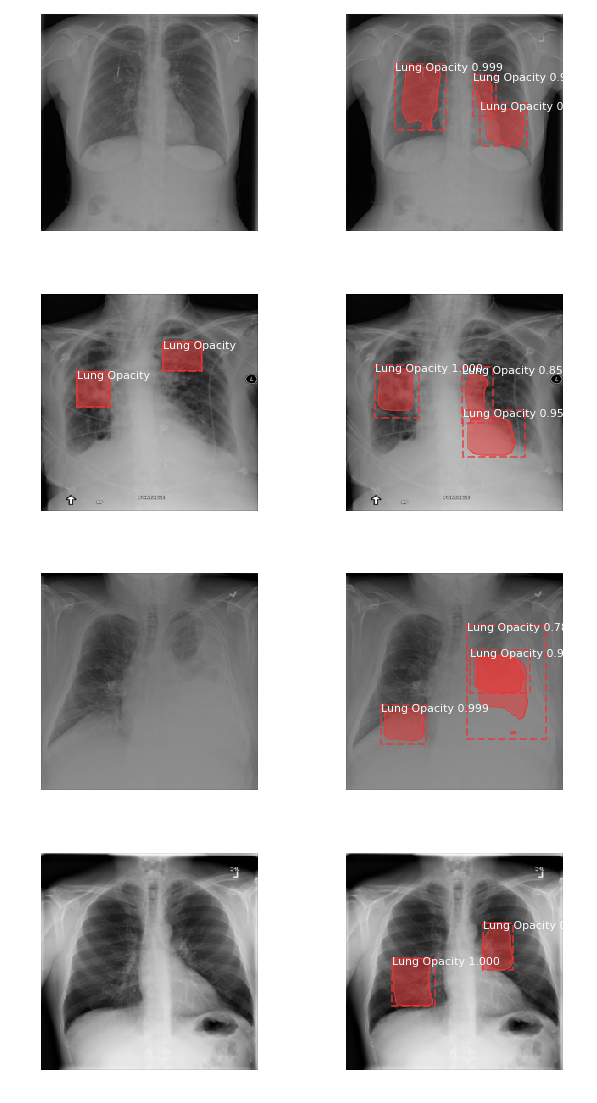

In [35]:
fig = plt.figure(figsize=(10, 30))


for i in range(4):

    image_id = random.choice(dataset_test.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_test.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_test.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

# Predict

In [36]:
def predict_test(image_fps, min_conf=0.98): 

      cm_df = pd.DataFrame(columns = ['patientId', 'y_true', 'y_pred']) 
      #------------------
      session = boto3.Session()
      s3_session = session.client('s3')
      #-------------------
    
      for image_id in tqdm(image_fps): 
                
        fileobj = s3_session.get_object(Bucket=root_path,  Key=image_id )
        # open the file object and read it into the variable dicom_data. 
        dicom_data = fileobj['Body'].read()
        # Read DICOM
        dicom_bytes = DicomBytesIO(dicom_data)
        c_dicom = dcmread(dicom_bytes)  
        image = c_dicom.pixel_array
        
        #ds = pydicom.read_file(image_id)
        #image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]
        

        results = model.detect([image])
        r = results[0]

        print ( ' patient_id' , patient_id ,  ' y_tue ', image_annotations[image_id][0].Target, ' scores ', r['scores'])
        #print(' y_true ', image_annotations[image_id][0].patientId , ' class ', image_annotations[image_id][0].Target )
        y_pred = 0
        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str
                    y_pred = 1
        
        cm_df = cm_df.append ({'patientId': patient_id, 'y_true' : image_annotations[image_id][0].Target , 'y_pred' : y_pred}, ignore_index=True)

        #print(out_str)
      return cm_df

In [37]:
cm_df = predict_test(image_test_fps)

  0%|          | 1/3000 [00:00<49:02,  1.02it/s]

 patient_id fffec09e-8a4a-48b1-b33e-ab4890ccd136  y_tue  0  scores  [0.998393  0.9904812 0.9311233]


  0%|          | 2/3000 [00:01<47:48,  1.05it/s]

 patient_id fffcff11-d018-4414-971a-a7cefa327795  y_tue  0  scores  [0.99956983 0.9967715 ]


  0%|          | 3/3000 [00:02<46:57,  1.06it/s]

 patient_id fffc95b5-605b-4226-80ab-62caec682b22  y_tue  0  scores  [0.9995011 0.995557 ]


  0%|          | 4/3000 [00:03<46:33,  1.07it/s]

 patient_id fffba05a-1635-4545-9bbd-57ad4cfe8d27  y_tue  0  scores  [0.9997794 0.9984475]


  0%|          | 5/3000 [00:04<46:31,  1.07it/s]

 patient_id fffb2395-8edd-4954-8a89-ffe2fd329be3  y_tue  1  scores  [0.9996753 0.9980533]


  0%|          | 6/3000 [00:05<45:48,  1.09it/s]

 patient_id fffb2395-8edd-4954-8a89-ffe2fd329be3  y_tue  1  scores  [0.9996753 0.9980533]


  0%|          | 7/3000 [00:06<45:46,  1.09it/s]

 patient_id fff7447f-99ce-4102-87f3-9788b2459eb4  y_tue  0  scores  [0.9998074  0.99796414 0.8393088 ]


  0%|          | 8/3000 [00:07<45:40,  1.09it/s]

 patient_id fff50447-821b-4b72-ae91-22b0679d6d3e  y_tue  0  scores  [0.99915564 0.991533   0.94722503]


  0%|          | 9/3000 [00:08<46:07,  1.08it/s]

 patient_id fff1cc9c-3895-43be-84e1-a7aaef21002b  y_tue  0  scores  [0.9994561  0.99873585]


  0%|          | 10/3000 [00:09<46:40,  1.07it/s]

 patient_id fff0b503-72a5-446a-843d-f3d152e39053  y_tue  1  scores  [0.9995364  0.99650526]


  0%|          | 11/3000 [00:10<46:13,  1.08it/s]

 patient_id ffee0360-20cf-4d4a-9af5-e5c9b493c73b  y_tue  0  scores  [0.99917114 0.9852871  0.92189014]


  0%|          | 12/3000 [00:11<45:49,  1.09it/s]

 patient_id ffeab8ae-f339-40d6-96f1-f1f8c97d2cb1  y_tue  0  scores  [0.9985574 0.9963935]


  0%|          | 13/3000 [00:11<45:23,  1.10it/s]

 patient_id ffe9ab5c-9d39-4235-9ade-d725dcad6b76  y_tue  0  scores  [0.99983656 0.98886603 0.90916145]


  0%|          | 14/3000 [00:12<45:06,  1.10it/s]

 patient_id ffe9a1c4-634d-408f-9b0f-8098ffb78a4e  y_tue  0  scores  [0.99206287 0.9868038  0.98048156]


  0%|          | 15/3000 [00:13<45:04,  1.10it/s]

 patient_id ffe4707d-517c-4ed0-8a9f-3ad149748991  y_tue  0  scores  [0.9997842  0.98661476 0.9821239 ]


  1%|          | 16/3000 [00:14<45:08,  1.10it/s]

 patient_id ffe16061-b19f-4333-8a03-b41aab42b47d  y_tue  0  scores  [0.998544  0.9971704 0.8403617]


  1%|          | 17/3000 [00:15<44:55,  1.11it/s]

 patient_id ffde3e7e-849c-4077-bfd0-4e4498ee8817  y_tue  0  scores  [0.99942577 0.9982724 ]


  1%|          | 18/3000 [00:16<44:27,  1.12it/s]

 patient_id ffde3879-241c-4b03-9d91-625cae6b49e8  y_tue  0  scores  [0.9994754 0.9975914 0.7813618]


  1%|          | 19/3000 [00:17<44:55,  1.11it/s]

 patient_id ffdc957e-6239-427d-8a54-fdf8ced3a356  y_tue  0  scores  [0.9954182 0.9887106 0.9600443]


  1%|          | 20/3000 [00:18<45:01,  1.10it/s]

 patient_id ffdc8a6a-f513-4a04-9c1d-24840a779220  y_tue  0  scores  [0.9995634  0.98447615]


  1%|          | 21/3000 [00:19<45:24,  1.09it/s]

 patient_id ffdc771e-1f1a-47f7-b732-3e06e48c24e8  y_tue  0  scores  [0.9997619 0.9980793 0.95319  ]


  1%|          | 22/3000 [00:20<45:12,  1.10it/s]

 patient_id ffd787b6-59ca-48cb-bd15-bcedd52cf37c  y_tue  1  scores  [0.9992324  0.99793077]


  1%|          | 23/3000 [00:21<44:57,  1.10it/s]

 patient_id ffd787b6-59ca-48cb-bd15-bcedd52cf37c  y_tue  1  scores  [0.9992324  0.99793077]


  1%|          | 24/3000 [00:21<44:48,  1.11it/s]

 patient_id ffd670a5-b6dc-4f54-928a-69b7a04662eb  y_tue  0  scores  [0.9989114 0.9855047]


  1%|          | 25/3000 [00:22<45:07,  1.10it/s]

 patient_id ffd56560-6754-4a20-83c6-06ad5c4b30ab  y_tue  0  scores  [0.99729925 0.97525066 0.96164656]


  1%|          | 26/3000 [00:23<45:15,  1.10it/s]

 patient_id ffd2bc74-f9d6-49fb-84d7-de060ee22583  y_tue  0  scores  [0.9990345 0.9869552]


  1%|          | 27/3000 [00:24<45:00,  1.10it/s]

 patient_id ffd0c212-bfb6-41e3-b17b-b927b99d1730  y_tue  0  scores  [0.9987835 0.9849657]


  1%|          | 28/3000 [00:25<44:42,  1.11it/s]

 patient_id ffcfe8c1-5641-4dc3-910c-573e3227f536  y_tue  0  scores  [0.9996074 0.9964483]


  1%|          | 29/3000 [00:26<45:01,  1.10it/s]

 patient_id ffcc35e8-6fe8-42df-9605-9fedf57240d1  y_tue  0  scores  [0.99874276 0.9973563  0.80693525]


  1%|          | 30/3000 [00:27<45:11,  1.10it/s]

 patient_id ffc9e552-ca53-43a8-a156-b0f97f0d40f3  y_tue  0  scores  [0.9988147 0.9878791]


  1%|          | 31/3000 [00:28<44:55,  1.10it/s]

 patient_id ffc3fc59-f046-48b8-b7ad-3a9e07362d0c  y_tue  0  scores  [0.9999169  0.98208743]


  1%|          | 32/3000 [00:29<44:33,  1.11it/s]

 patient_id ffc01e64-ba14-4620-8016-235fc1609767  y_tue  0  scores  [0.99964654 0.9960115 ]


  1%|          | 33/3000 [00:30<44:37,  1.11it/s]

 patient_id ffba6230-71cf-4287-a0d1-887f5d16e95d  y_tue  0  scores  [0.9999783  0.99473697 0.73264533]


  1%|          | 34/3000 [00:31<45:08,  1.10it/s]

 patient_id ffb9f122-b2f4-4531-8297-416fc0e47cda  y_tue  0  scores  [0.99830747 0.99630153 0.8566475 ]


  1%|          | 35/3000 [00:31<45:05,  1.10it/s]

 patient_id ffb8998b-f262-4330-820d-bf48a4d8fec1  y_tue  0  scores  [0.9996019 0.9972791]


  1%|          | 36/3000 [00:32<44:45,  1.10it/s]

 patient_id ffb0a415-cd40-4c33-b806-cf533505f89e  y_tue  0  scores  [0.999736   0.99001825 0.87734073]


  1%|          | 37/3000 [00:33<44:52,  1.10it/s]

 patient_id ffb0166b-771d-4463-8e38-20b67fa2d3b2  y_tue  0  scores  [0.99964786 0.9992944  0.83806235]


  1%|▏         | 38/3000 [00:34<44:40,  1.10it/s]

 patient_id ffae40ab-fcfe-4311-a74a-89f605dba48b  y_tue  1  scores  [0.99807125 0.99718034]


  1%|▏         | 39/3000 [00:35<44:53,  1.10it/s]

 patient_id ffaddbba-6aa4-4f12-ab24-b994567f01e6  y_tue  0  scores  [0.9996532  0.9905552  0.91582674]


  1%|▏         | 40/3000 [00:36<44:30,  1.11it/s]

 patient_id ffad4160-d78e-4bcc-ab1f-47e20e613bd6  y_tue  0  scores  [0.9999577]


  1%|▏         | 41/3000 [00:37<45:23,  1.09it/s]

 patient_id ffabea71-fba0-49ff-a038-2b1dac9971b7  y_tue  0  scores  [0.99976176 0.9979602 ]


  1%|▏         | 42/3000 [00:38<44:52,  1.10it/s]

 patient_id ffa54bb3-2fb6-4010-abbb-3f43a2b3d0ce  y_tue  0  scores  [0.9995253  0.99536926 0.7598062 ]


  1%|▏         | 43/3000 [00:39<44:37,  1.10it/s]

 patient_id ffa424d2-6e6b-4eed-93ab-7551e8941215  y_tue  1  scores  [0.99983776 0.99265677]


  1%|▏         | 44/3000 [00:40<44:19,  1.11it/s]

 patient_id ffa424d2-6e6b-4eed-93ab-7551e8941215  y_tue  1  scores  [0.99983776 0.99265677]


  2%|▏         | 45/3000 [00:40<44:43,  1.10it/s]

 patient_id ffa3e9f1-6af8-481f-8523-b476e67edf69  y_tue  0  scores  [0.9996506  0.9319368  0.87543136]


  2%|▏         | 46/3000 [00:41<44:41,  1.10it/s]

 patient_id ffa31ac1-56ef-4f72-98e9-0128274b751f  y_tue  0  scores  [0.999678   0.99943143]


  2%|▏         | 47/3000 [00:42<44:26,  1.11it/s]

 patient_id ffa141d4-00d8-4df5-86e0-b6f37dd8f3b1  y_tue  0  scores  [0.99858034 0.9961875  0.9949591 ]


  2%|▏         | 48/3000 [00:43<44:13,  1.11it/s]

 patient_id ff9f1f48-402c-4a72-9ceb-d97c416726d6  y_tue  0  scores  [0.999782   0.87161356 0.8474024 ]


  2%|▏         | 49/3000 [00:44<44:05,  1.12it/s]

 patient_id ff9d9177-ab50-4667-8193-9569ddf519e5  y_tue  0  scores  [0.9993286  0.99891603 0.97528106]


  2%|▏         | 50/3000 [00:45<44:06,  1.11it/s]

 patient_id ff9d37d1-3660-4187-8f57-d31f9c91a3fd  y_tue  1  scores  [0.9997886 0.9956098]


  2%|▏         | 51/3000 [00:46<44:16,  1.11it/s]

 patient_id ff9c582d-938e-426b-8430-14183c3c1ded  y_tue  0  scores  [0.99982506 0.99898344]


  2%|▏         | 52/3000 [00:47<44:33,  1.10it/s]

 patient_id ff955beb-6f41-4292-adf7-f224054c882f  y_tue  0  scores  [0.9991454  0.9884829  0.82935673]


  2%|▏         | 53/3000 [00:48<44:25,  1.11it/s]

 patient_id ff939423-ded7-4887-907b-af5e68aa9aef  y_tue  0  scores  [0.99954504 0.96114683 0.9124627 ]


  2%|▏         | 54/3000 [00:49<44:21,  1.11it/s]

 patient_id ff91fe68-b870-4efa-a0a8-3de999ef71a2  y_tue  0  scores  [0.99961275 0.88667375]


  2%|▏         | 55/3000 [00:49<44:20,  1.11it/s]

 patient_id ff8f51eb-1269-49b7-8ddf-77dc2c05ffd4  y_tue  0  scores  [0.9996941 0.9357808]


  2%|▏         | 56/3000 [00:50<44:15,  1.11it/s]

 patient_id ff8dffe0-57bb-4b95-b425-38f8ef290339  y_tue  0  scores  [0.99870396 0.99084014 0.976998  ]


  2%|▏         | 57/3000 [00:51<44:14,  1.11it/s]

 patient_id ff8d9de6-d439-476d-a171-36c8d5825e41  y_tue  0  scores  [0.9991973  0.99304926 0.92009145]


  2%|▏         | 58/3000 [00:52<44:19,  1.11it/s]

 patient_id ff8d7572-1183-45e4-a1bf-730f58bdb988  y_tue  0  scores  [0.9994991 0.9983499 0.7931444]


  2%|▏         | 59/3000 [00:53<44:17,  1.11it/s]

 patient_id ff8a0582-abc9-4753-bb71-a9746d466743  y_tue  0  scores  [0.9993956  0.9959109  0.94338864]


  2%|▏         | 60/3000 [00:54<44:13,  1.11it/s]

 patient_id ff87b50b-d50f-4e39-82bb-325d51927ff5  y_tue  0  scores  [0.99985564 0.99598986]


  2%|▏         | 61/3000 [00:55<44:06,  1.11it/s]

 patient_id ff863e04-0cd1-4cc4-b68d-f403d05193c4  y_tue  0  scores  [0.99929094 0.99403584 0.9846779 ]


  2%|▏         | 62/3000 [00:56<43:59,  1.11it/s]

 patient_id ff8563d5-cc01-4dce-87c6-bf12e748955c  y_tue  0  scores  [0.99988854]


  2%|▏         | 63/3000 [00:57<44:04,  1.11it/s]

 patient_id ff82e39d-608f-4f9d-b4db-f8598544e754  y_tue  0  scores  [0.99774265 0.99675435 0.98172116]


  2%|▏         | 64/3000 [00:58<44:17,  1.10it/s]

 patient_id ff7f99be-2021-4094-9cf4-1865061ce3a3  y_tue  0  scores  [0.99961853 0.9991623 ]


  2%|▏         | 65/3000 [00:59<44:41,  1.09it/s]

 patient_id ff7f3397-73b7-4601-9447-cb6261fcb51d  y_tue  0  scores  [0.9929639  0.9616745  0.87966526]


  2%|▏         | 66/3000 [00:59<44:44,  1.09it/s]

 patient_id ff7e4f5e-9895-43c6-bb13-8a482c5a0c27  y_tue  0  scores  [0.9983381  0.97475773]


  2%|▏         | 67/3000 [01:00<44:48,  1.09it/s]

 patient_id ff7bd314-e7ee-4f20-9734-bd4350f091d1  y_tue  0  scores  [0.9996283  0.9843286  0.80568177]


  2%|▏         | 68/3000 [01:01<43:58,  1.11it/s]

 patient_id ff7b514f-5f0b-442e-8c57-a149fb17434e  y_tue  0  scores  [0.9993656 0.9981294]


  2%|▏         | 69/3000 [01:02<43:55,  1.11it/s]

 patient_id ff7b383f-7b87-4f73-9c69-ff5b97e3d13c  y_tue  0  scores  [0.9999261 0.9680159]


  2%|▏         | 70/3000 [01:03<43:53,  1.11it/s]

 patient_id ff7a9337-c12a-45a9-ab7f-3d7ea08e1162  y_tue  0  scores  [0.99534345 0.9816212  0.97440493]


  2%|▏         | 71/3000 [01:04<43:52,  1.11it/s]

 patient_id ff781779-1ab8-43a8-914c-070cbbd97967  y_tue  0  scores  [0.9997192 0.9968497]


  2%|▏         | 72/3000 [01:05<44:10,  1.10it/s]

 patient_id ff769f8d-e923-4086-a69c-3c528061633b  y_tue  0  scores  [0.99841344 0.99183404 0.9828476 ]


  2%|▏         | 73/3000 [01:06<44:04,  1.11it/s]

 patient_id ff728586-b8a3-4d0f-8956-4b93dfc3b728  y_tue  0  scores  [0.9995276  0.98413277 0.77959865]


  2%|▏         | 74/3000 [01:07<44:20,  1.10it/s]

 patient_id ff71338e-e5c8-41c4-b057-e7743497665b  y_tue  0  scores  [0.99932086 0.9962878  0.78177696]


  2%|▎         | 75/3000 [01:08<45:02,  1.08it/s]

 patient_id ff6cc5b2-1e0d-405d-a851-1d56da425660  y_tue  0  scores  [0.9997464 0.9986467]


  3%|▎         | 76/3000 [01:09<44:49,  1.09it/s]

 patient_id ff6ac9c3-3271-466c-8274-6a4076cc6732  y_tue  0  scores  [0.9998994  0.9864276  0.95678025]


  3%|▎         | 77/3000 [01:09<44:33,  1.09it/s]

 patient_id ff6a7ed9-045d-4062-8d79-232060e9b2ce  y_tue  0  scores  [0.9997639]


  3%|▎         | 78/3000 [01:10<44:12,  1.10it/s]

 patient_id ff69289a-dc4c-4c24-af25-b9a71dceac3f  y_tue  0  scores  [0.9996604 0.9983754]


  3%|▎         | 79/3000 [01:11<44:35,  1.09it/s]

 patient_id ff68830c-84cf-44c5-983d-6d332f86d82a  y_tue  0  scores  [0.9998487 0.9972614 0.9967235]


  3%|▎         | 80/3000 [01:12<44:17,  1.10it/s]

 patient_id ff65ded6-dcb8-4e16-a3d2-50b5393bcfa7  y_tue  0  scores  [0.99945146 0.98096734]


  3%|▎         | 81/3000 [01:13<44:09,  1.10it/s]

 patient_id ff659b3e-123c-4501-ab4b-be41216160ac  y_tue  0  scores  [0.9998418  0.9908242  0.76603156]


  3%|▎         | 82/3000 [01:14<44:18,  1.10it/s]

 patient_id ff61c3e8-c3a2-4b06-9974-9adf7953088a  y_tue  0  scores  [0.9993969 0.9939213]


  3%|▎         | 83/3000 [01:15<44:17,  1.10it/s]

 patient_id ff61b8b9-54b4-4c06-b14e-99bf71f0cdbe  y_tue  0  scores  [0.9993849 0.9789525 0.8785779]


  3%|▎         | 84/3000 [01:16<43:36,  1.11it/s]

 patient_id ff615475-a82f-4fa0-8fa2-6fb1a32c9dc8  y_tue  0  scores  [0.99970907 0.9988084 ]


  3%|▎         | 85/3000 [01:17<43:27,  1.12it/s]

 patient_id ff5efd4a-0777-41b9-82c7-b73b4073c509  y_tue  0  scores  [0.9998542]


  3%|▎         | 86/3000 [01:18<43:28,  1.12it/s]

 patient_id ff5b2932-f065-4b79-b2f8-ec2143ffc977  y_tue  0  scores  [0.99965096 0.8599433 ]


  3%|▎         | 87/3000 [01:18<43:48,  1.11it/s]

 patient_id ff5a1534-7139-4ee2-902c-87db8879cae3  y_tue  0  scores  [0.9988194  0.99858594]


  3%|▎         | 88/3000 [01:19<43:27,  1.12it/s]

 patient_id ff58dc9c-7f64-40d9-82da-3bb6d22494b6  y_tue  0  scores  [0.9990706 0.9946301 0.9456975]


  3%|▎         | 89/3000 [01:20<43:25,  1.12it/s]

 patient_id ff585970-2151-469d-84bd-331480de6096  y_tue  0  scores  [0.99978596 0.9978416  0.85117435]


  3%|▎         | 90/3000 [01:21<43:50,  1.11it/s]

 patient_id ff551276-6116-4e99-aeb8-e59eb8f6ce0a  y_tue  0  scores  [0.99989796 0.99264765 0.77877957]


  3%|▎         | 91/3000 [01:22<43:41,  1.11it/s]

 patient_id ff4d51f2-3f7a-4a5e-be45-6599bc9f618c  y_tue  0  scores  [0.99906284 0.9947066  0.8188228 ]


  3%|▎         | 92/3000 [01:23<43:42,  1.11it/s]

 patient_id ff47d677-c81f-4847-900b-a2cb12e06c3b  y_tue  0  scores  [0.9998882  0.93359464]


  3%|▎         | 93/3000 [01:24<43:55,  1.10it/s]

 patient_id ff42dbdc-285e-457d-aa3d-725638fa083b  y_tue  0  scores  [0.999196  0.9982127]


  3%|▎         | 94/3000 [01:25<43:42,  1.11it/s]

 patient_id ff42a2f1-c01b-40a2-b068-db3191a83d3d  y_tue  0  scores  [0.99212766 0.9696849  0.86474186]


  3%|▎         | 95/3000 [01:26<44:11,  1.10it/s]

 patient_id ff40a703-b1db-48d5-a176-0b50763f9a0a  y_tue  1  scores  [0.9992161  0.99714345 0.83888006]


  3%|▎         | 96/3000 [01:27<43:50,  1.10it/s]

 patient_id ff40a703-b1db-48d5-a176-0b50763f9a0a  y_tue  1  scores  [0.9992161  0.99714345 0.83888006]


  3%|▎         | 97/3000 [01:27<43:33,  1.11it/s]

 patient_id ff3cfbd3-ac37-4ee4-b6ad-23f6fa88a449  y_tue  0  scores  [0.99981636 0.99913484]


  3%|▎         | 98/3000 [01:28<43:31,  1.11it/s]

 patient_id ff3c2e94-b672-4bd2-8073-e9a4b6d9294d  y_tue  0  scores  [0.9989862  0.9893606  0.91150165]


  3%|▎         | 99/3000 [01:29<43:54,  1.10it/s]

 patient_id ff3b24b7-a7df-4ee0-a3f8-d213914355c4  y_tue  0  scores  [0.9998716 0.9791059 0.9012359]


  3%|▎         | 100/3000 [01:30<43:35,  1.11it/s]

 patient_id ff3994e2-4e73-495a-b683-1e99e6fbdd83  y_tue  0  scores  [0.99970824 0.99901485 0.8407356 ]


  3%|▎         | 101/3000 [01:31<43:52,  1.10it/s]

 patient_id ff38a1fd-53c4-4c3c-93e2-860f025f90de  y_tue  0  scores  [0.9994419  0.94448686]


  3%|▎         | 102/3000 [01:32<43:57,  1.10it/s]

 patient_id ff372134-6290-4cd7-9e93-b1348a7edfa2  y_tue  0  scores  [0.9989166 0.9758671 0.9456557]


  3%|▎         | 103/3000 [01:33<43:48,  1.10it/s]

 patient_id ff371a27-7df6-4aaf-a5eb-5e64acc4a054  y_tue  0  scores  [0.9990294  0.99408156 0.931975  ]


  3%|▎         | 104/3000 [01:34<44:44,  1.08it/s]

 patient_id ff36df91-52bc-4fa6-a3df-1da3d3f6191a  y_tue  0  scores  [0.99950135 0.72824097 0.70778465]


  4%|▎         | 105/3000 [01:35<44:35,  1.08it/s]

 patient_id ff350a75-ff2e-44d8-a054-13fc5b6ac284  y_tue  0  scores  [0.9992291  0.96705115 0.9156489 ]


  4%|▎         | 106/3000 [01:36<44:10,  1.09it/s]

 patient_id ff34eb2e-60eb-401a-81bc-8083dab28957  y_tue  0  scores  [0.9993585  0.99788445 0.9930936 ]


  4%|▎         | 107/3000 [01:37<43:57,  1.10it/s]

 patient_id ff33da14-0bd6-4fe4-9675-ef704bc33b84  y_tue  1  scores  [0.9993345  0.99595106]


  4%|▎         | 108/3000 [01:38<43:20,  1.11it/s]

 patient_id ff33da14-0bd6-4fe4-9675-ef704bc33b84  y_tue  1  scores  [0.9993345  0.99595106]


  4%|▎         | 109/3000 [01:38<43:13,  1.11it/s]

 patient_id ff337f11-e307-4173-bd1a-5b285dae5073  y_tue  0  scores  [0.9998579 0.9891082]


  4%|▎         | 110/3000 [01:39<43:35,  1.11it/s]

 patient_id ff332704-48e0-445b-9188-b2a696d1f0d7  y_tue  0  scores  [0.99925834 0.99651814 0.98449326]


  4%|▎         | 111/3000 [01:40<43:28,  1.11it/s]

 patient_id ff3263ac-8016-47aa-ac03-4254bf0f2f13  y_tue  0  scores  [0.99984145 0.9947861  0.96870005]


  4%|▎         | 112/3000 [01:41<43:39,  1.10it/s]

 patient_id ff3258f3-2c66-40cf-9d5d-fe77f8036fa6  y_tue  1  scores  [0.9986933 0.9973838]


  4%|▍         | 113/3000 [01:42<43:28,  1.11it/s]

 patient_id ff3258f3-2c66-40cf-9d5d-fe77f8036fa6  y_tue  1  scores  [0.9986933 0.9973838]


  4%|▍         | 114/3000 [01:43<43:42,  1.10it/s]

 patient_id ff30520c-68c9-4d17-acb0-f44eb1f4eb1c  y_tue  0  scores  [0.9998217  0.97750854]


  4%|▍         | 115/3000 [01:44<43:40,  1.10it/s]

 patient_id ff2f54a2-8bdf-45fd-93dc-40b5c3c53ef6  y_tue  0  scores  [0.99523044 0.98331636]


  4%|▍         | 116/3000 [01:45<43:31,  1.10it/s]

 patient_id ff2baf79-403a-474c-89bc-a7f3904de194  y_tue  0  scores  [0.9999604  0.9951767  0.93718153]


  4%|▍         | 117/3000 [01:46<43:17,  1.11it/s]

 patient_id ff28b84f-2f94-4614-893d-08300c32ac88  y_tue  0  scores  [0.9998247  0.88508004]


  4%|▍         | 118/3000 [01:47<43:16,  1.11it/s]

 patient_id ff27ccc3-322b-43a2-8251-49a83f8efd36  y_tue  0  scores  [0.998716   0.97154117 0.90809685]


  4%|▍         | 119/3000 [01:47<43:38,  1.10it/s]

 patient_id ff273673-5610-47a1-8991-6f896eeefc2d  y_tue  1  scores  [0.9998765 0.9951481]


  4%|▍         | 120/3000 [01:48<43:03,  1.11it/s]

 patient_id ff273673-5610-47a1-8991-6f896eeefc2d  y_tue  1  scores  [0.9998765 0.9951481]


  4%|▍         | 121/3000 [01:49<43:02,  1.11it/s]

 patient_id ff241103-be64-4022-b8b1-71a1cec279a3  y_tue  0  scores  [0.99960274 0.99240327 0.97270477]


  4%|▍         | 122/3000 [01:50<43:18,  1.11it/s]

 patient_id ff21f6b8-5ebc-4097-a402-54d203884923  y_tue  0  scores  [0.99334395 0.9765179  0.97142404]


  4%|▍         | 123/3000 [01:51<43:32,  1.10it/s]

 patient_id ff1c8291-32bd-4d9a-8c4e-570dca044bcc  y_tue  0  scores  [0.9978448 0.995924  0.8793204]


  4%|▍         | 124/3000 [01:52<43:28,  1.10it/s]

 patient_id ff1c102f-8294-4156-8771-aab8c6f9a819  y_tue  0  scores  [0.99967   0.9823261 0.7716685]


  4%|▍         | 125/3000 [01:53<44:11,  1.08it/s]

 patient_id ff1bf27e-55e4-41b8-a0ab-4aff74ee529e  y_tue  0  scores  [0.99922836 0.96164596 0.7980108 ]


  4%|▍         | 126/3000 [01:54<44:16,  1.08it/s]

 patient_id ff1bc114-1975-4f8f-9015-54f0d90eb445  y_tue  0  scores  [0.99985707 0.908971  ]


  4%|▍         | 127/3000 [01:55<44:09,  1.08it/s]

 patient_id ff17d695-3f5e-4574-a7f3-0329d9ce92ea  y_tue  0  scores  [0.9982975  0.99783295]


  4%|▍         | 128/3000 [01:56<44:00,  1.09it/s]

 patient_id ff172cdc-bcfe-4fed-904b-6e573b1bc74c  y_tue  0  scores  [0.9964569  0.99302375 0.97813547]


  4%|▍         | 129/3000 [01:57<44:32,  1.07it/s]

 patient_id ff154743-18cd-44d7-a973-d4514b0d1406  y_tue  0  scores  [0.99974185 0.9990388 ]


  4%|▍         | 130/3000 [01:58<44:51,  1.07it/s]

 patient_id ff135e36-fdf0-415f-a260-883b0af0d091  y_tue  0  scores  [0.9978015  0.9806902  0.77355087]


  4%|▍         | 131/3000 [01:59<44:18,  1.08it/s]

 patient_id ff1184dd-a8d8-44b5-bc78-eb3d38adc03f  y_tue  0  scores  [0.9972319  0.99079084 0.9838694 ]


  4%|▍         | 132/3000 [01:59<43:49,  1.09it/s]

 patient_id ff0fcf72-7b10-4c5c-bb43-f81368872b9b  y_tue  0  scores  [0.999959   0.99896514 0.8530958 ]


  4%|▍         | 133/3000 [02:00<43:53,  1.09it/s]

 patient_id ff0dd1fb-3a29-4927-b6fd-6c93a3ffbd6a  y_tue  0  scores  [0.99973613 0.9981888 ]


  4%|▍         | 134/3000 [02:01<43:32,  1.10it/s]

 patient_id ff0b66d5-ef14-45c4-8bd5-3282f45c163c  y_tue  0  scores  [0.9992638  0.99894434 0.90878814]


  4%|▍         | 135/3000 [02:02<43:36,  1.09it/s]

 patient_id ff0ae1db-fe69-424e-8851-27216b79ed4c  y_tue  0  scores  [0.9990575  0.99420434]


  5%|▍         | 136/3000 [02:03<43:25,  1.10it/s]

 patient_id ff04a17a-9514-481c-985f-13e09944cfd0  y_tue  0  scores  [0.99982786 0.99616563]


  5%|▍         | 137/3000 [02:04<43:18,  1.10it/s]

 patient_id ff03d5a3-4e83-48c3-bd33-bff30f359b5f  y_tue  0  scores  [0.99953306 0.99897754]


  5%|▍         | 138/3000 [02:05<43:24,  1.10it/s]

 patient_id ff0200e1-3bac-42d1-880b-17d6a3366d2c  y_tue  1  scores  [0.9997557 0.9986779]


  5%|▍         | 139/3000 [02:06<43:04,  1.11it/s]

 patient_id ff0200e1-3bac-42d1-880b-17d6a3366d2c  y_tue  1  scores  [0.9997557 0.9986779]


  5%|▍         | 140/3000 [02:07<43:11,  1.10it/s]

 patient_id ff00eb58-e9c8-4c4b-8837-88355b3b7d2b  y_tue  0  scores  [0.99925166 0.99907875]


  5%|▍         | 141/3000 [02:08<43:18,  1.10it/s]

 patient_id ff0090ff-4acb-4dc6-a937-86fa8f5e74da  y_tue  0  scores  [0.99835193 0.9802727  0.97839475]


  5%|▍         | 142/3000 [02:08<43:17,  1.10it/s]

 patient_id ff004b71-fe8a-4c62-acb1-44afc44eb59d  y_tue  0  scores  [0.999884   0.92777187 0.74782723]


  5%|▍         | 143/3000 [02:09<43:10,  1.10it/s]

 patient_id fefec27e-8e4b-44c7-bf56-3fbfba05e83d  y_tue  0  scores  [0.9983315  0.99452424 0.9519524 ]


  5%|▍         | 144/3000 [02:11<46:28,  1.02it/s]

 patient_id fefe9ff5-ec06-43bb-a70a-8a7b4b16b3bd  y_tue  0  scores  [0.9996142  0.99893385]


  5%|▍         | 145/3000 [02:12<49:21,  1.04s/it]

 patient_id fefdd549-9fbd-4e90-a7e4-4a0d2d4466d6  y_tue  0  scores  [0.99950373 0.9964055  0.79255134]


  5%|▍         | 146/3000 [02:13<49:17,  1.04s/it]

 patient_id fefb28ce-8006-4fca-af2b-5dc1a4290772  y_tue  0  scores  [0.99973255 0.960332   0.93751526]


  5%|▍         | 147/3000 [02:14<47:21,  1.00it/s]

 patient_id fef9cea7-b11c-467a-b64e-3f7199d18311  y_tue  0  scores  [0.9998436  0.99465406 0.8553195 ]


  5%|▍         | 148/3000 [02:15<46:10,  1.03it/s]

 patient_id fef7b294-017c-4491-9e57-119086855785  y_tue  1  scores  [0.9991172 0.9819402]


  5%|▍         | 149/3000 [02:15<45:03,  1.05it/s]

 patient_id fef734db-9599-4df3-83cb-45de251a98d9  y_tue  0  scores  [0.9985598  0.99710697]


  5%|▌         | 150/3000 [02:16<44:19,  1.07it/s]

 patient_id fef72585-1a73-428d-9138-07f19fa8603c  y_tue  0  scores  [0.9991787 0.9978259]


  5%|▌         | 151/3000 [02:17<43:50,  1.08it/s]

 patient_id fef6d6a6-dab2-4496-99cc-4b7e5ca4d2ed  y_tue  0  scores  [0.99792683 0.99673104]


  5%|▌         | 152/3000 [02:18<43:26,  1.09it/s]

 patient_id fef2c610-5694-4192-ae72-7874fee1feb9  y_tue  0  scores  [0.99974567 0.99974436]


  5%|▌         | 153/3000 [02:19<43:32,  1.09it/s]

 patient_id feeae8c2-49ec-4ef9-8ad2-7e29b3dfd617  y_tue  0  scores  [0.99856395 0.9898336  0.93116426]


  5%|▌         | 154/3000 [02:20<43:14,  1.10it/s]

 patient_id fee72484-77b0-4d59-ad08-5d8f497dde99  y_tue  0  scores  [0.9895929  0.98953336 0.98554546]


  5%|▌         | 155/3000 [02:21<42:59,  1.10it/s]

 patient_id fee5a348-ef53-4b41-b88f-a0563edaaafa  y_tue  0  scores  [0.999169  0.9919933 0.8128676]


  5%|▌         | 156/3000 [02:22<42:48,  1.11it/s]

 patient_id fee51f1f-1143-4609-ad3f-baefbfbdc1f1  y_tue  0  scores  [0.99973196 0.92325836]


  5%|▌         | 157/3000 [02:23<42:36,  1.11it/s]

 patient_id fee34cf4-5179-488b-bf71-3e8f00f26840  y_tue  0  scores  [0.9992449 0.9970745]


  5%|▌         | 158/3000 [02:24<42:49,  1.11it/s]

 patient_id fee10db3-aaf5-415b-849a-56576d782f1c  y_tue  0  scores  [0.99922   0.9686254]


  5%|▌         | 159/3000 [02:24<43:03,  1.10it/s]

 patient_id fee0c2fd-5a4d-4636-9d31-39a58ae0c8b8  y_tue  0  scores  [0.99975437 0.9741917  0.7467281 ]


  5%|▌         | 160/3000 [02:25<42:48,  1.11it/s]

 patient_id fee03015-e202-4e2e-b72e-2a72f0052fc6  y_tue  1  scores  [0.99965394 0.9990164 ]


  5%|▌         | 161/3000 [02:26<42:32,  1.11it/s]

 patient_id fee03015-e202-4e2e-b72e-2a72f0052fc6  y_tue  1  scores  [0.99965394 0.9990164 ]


  5%|▌         | 162/3000 [02:27<42:08,  1.12it/s]

 patient_id fedfec87-0d4f-488f-8e0b-50e2db8942d1  y_tue  0  scores  [0.9997024 0.9996911]


  5%|▌         | 163/3000 [02:28<42:09,  1.12it/s]

 patient_id fedfb751-4365-4ea3-a4d9-ac761534aca3  y_tue  0  scores  [0.9980598  0.99437284 0.843331  ]


  5%|▌         | 164/3000 [02:29<42:42,  1.11it/s]

 patient_id fedbe5e7-71ff-419c-90ee-ebaa630cd5f9  y_tue  0  scores  [0.9993674  0.9867421  0.78761995]


  6%|▌         | 165/3000 [02:30<42:38,  1.11it/s]

 patient_id fed7456a-7a16-400b-823c-771f5fcc4f83  y_tue  0  scores  [0.9994067 0.9604968 0.8162133]


  6%|▌         | 166/3000 [02:31<42:44,  1.11it/s]

 patient_id fed1a50d-85a5-44f4-825f-3a5f2a826678  y_tue  0  scores  [0.9972543 0.979062  0.9241076]


  6%|▌         | 167/3000 [02:32<42:33,  1.11it/s]

 patient_id fed14c6f-8c53-43dc-9c1b-fde62ddef146  y_tue  0  scores  [0.9989926  0.99407876 0.9867198 ]


  6%|▌         | 168/3000 [02:33<42:48,  1.10it/s]

 patient_id fecef59f-44e4-4fdc-b008-a650845defb9  y_tue  0  scores  [0.99952114 0.9981065  0.94806874]


  6%|▌         | 169/3000 [02:33<42:36,  1.11it/s]

 patient_id fecc154a-42d7-4621-9518-07adf1b9d72d  y_tue  0  scores  [0.99967587 0.99764603 0.9954378 ]


  6%|▌         | 170/3000 [02:34<42:50,  1.10it/s]

 patient_id fec89f9c-205d-44d7-99f0-9f79669f45dd  y_tue  0  scores  [0.9998006  0.9918377  0.88786936]


  6%|▌         | 171/3000 [02:35<42:45,  1.10it/s]

 patient_id fec6554c-a84f-4d37-a05b-3838bbdd914d  y_tue  0  scores  [0.99507457 0.9616786  0.95565647]


  6%|▌         | 172/3000 [02:36<42:50,  1.10it/s]

 patient_id fec211b1-ab13-4012-bc20-0f0f049d554a  y_tue  0  scores  [0.9961356 0.9915255 0.7929939]


  6%|▌         | 173/3000 [02:37<42:52,  1.10it/s]

 patient_id febbc3ae-c1c8-4625-8cf0-3170c460ca4f  y_tue  0  scores  [0.99989605 0.8779395 ]


  6%|▌         | 174/3000 [02:38<43:00,  1.09it/s]

 patient_id feb8dd3e-ecfc-493f-9094-00331a043c7c  y_tue  1  scores  [0.9996197  0.99308676 0.96628934]


  6%|▌         | 175/3000 [02:39<42:50,  1.10it/s]

 patient_id feb8c6c9-932a-481e-a2a1-3989cd1d3e90  y_tue  0  scores  [0.9998097 0.99819  ]


  6%|▌         | 176/3000 [02:40<42:26,  1.11it/s]

 patient_id feb64d56-3824-4df5-8ca0-72f146dc3aca  y_tue  0  scores  [0.999752   0.96282226]


  6%|▌         | 177/3000 [02:41<42:32,  1.11it/s]

 patient_id feb18c4a-f0b6-4987-8564-22ca37b19f6b  y_tue  0  scores  [0.9989448  0.9794463  0.90997195]


  6%|▌         | 178/3000 [02:42<42:36,  1.10it/s]

 patient_id feb07ed7-9de5-48e6-b554-c4fba70c985b  y_tue  0  scores  [0.99921393 0.9975074 ]


  6%|▌         | 179/3000 [02:43<43:01,  1.09it/s]

 patient_id feaf9f54-74da-400e-85aa-35db240cf11c  y_tue  0  scores  [0.9979418  0.99766076]


  6%|▌         | 180/3000 [02:44<43:08,  1.09it/s]

 patient_id feab4fe2-17bd-40b1-99c3-a6efbadb3589  y_tue  0  scores  [0.9996086  0.8988457  0.89039946]


  6%|▌         | 181/3000 [02:44<42:46,  1.10it/s]

 patient_id fea6e37a-41c3-45ce-9b27-6f1bed1bc7f4  y_tue  1  scores  [0.9989778  0.99807537]


  6%|▌         | 182/3000 [02:45<42:06,  1.12it/s]

 patient_id fea6e37a-41c3-45ce-9b27-6f1bed1bc7f4  y_tue  1  scores  [0.9989778  0.99807537]


  6%|▌         | 183/3000 [02:46<41:45,  1.12it/s]

 patient_id fea6191a-f4d4-4cc6-8bf7-5e81bd097209  y_tue  1  scores  [0.999548   0.9758139  0.91420645]


  6%|▌         | 184/3000 [02:47<41:55,  1.12it/s]

 patient_id fea45df8-aa0d-4483-ae67-5ed1b4b05b52  y_tue  0  scores  [0.9995434 0.829966 ]


  6%|▌         | 185/3000 [02:48<42:24,  1.11it/s]

 patient_id fea3d4d9-e3ee-495c-a59c-e3db137a0644  y_tue  0  scores  [0.9997546  0.99774384]


  6%|▌         | 186/3000 [02:49<42:42,  1.10it/s]

 patient_id fea04698-267d-4c55-b6f2-4f785d19fe60  y_tue  0  scores  [0.99950135 0.9926252  0.94519955]


  6%|▌         | 187/3000 [02:50<42:23,  1.11it/s]

 patient_id fe9e5b51-dd8e-4c0f-8513-d391970c6972  y_tue  0  scores  [0.9990356 0.9958294]


  6%|▋         | 188/3000 [02:51<42:29,  1.10it/s]

 patient_id fe9e00b9-095e-4b46-b72b-13260d1d2e6b  y_tue  0  scores  [0.999803   0.9913078  0.94182426]


  6%|▋         | 189/3000 [02:52<42:30,  1.10it/s]

 patient_id fe9c2c9d-7028-4091-8b78-8799edc65aaf  y_tue  0  scores  [0.9996717 0.9960295]


  6%|▋         | 190/3000 [02:52<42:10,  1.11it/s]

 patient_id fe9ba80f-ccb3-4de8-9f6b-610f814067d2  y_tue  0  scores  [0.99944264 0.99741673 0.90927535]


  6%|▋         | 191/3000 [02:53<42:18,  1.11it/s]

 patient_id fe984b23-53b7-403e-9c18-b4302ff46f2b  y_tue  0  scores  [0.9994429  0.98911893 0.77424335]


  6%|▋         | 192/3000 [02:54<42:37,  1.10it/s]

 patient_id fe973a22-141f-43cb-91d0-78da23fbd5d3  y_tue  0  scores  [0.99975723 0.99426246]


  6%|▋         | 193/3000 [02:55<42:38,  1.10it/s]

 patient_id fe972a3f-d91e-4e70-a02d-49ae29f0b188  y_tue  1  scores  [0.9986222  0.99612904 0.99124956]


  6%|▋         | 194/3000 [02:56<42:53,  1.09it/s]

 patient_id fe8dda90-2166-4091-8d0f-77d1ddccdeb7  y_tue  0  scores  [0.9995376 0.9986418]


  6%|▋         | 195/3000 [02:57<42:55,  1.09it/s]

 patient_id fe8ce5ce-10ce-47b5-aed2-77094801f185  y_tue  0  scores  [0.9986217 0.9090991 0.7892932]


  7%|▋         | 196/3000 [02:58<42:37,  1.10it/s]

 patient_id fe8c4d70-fa9d-4bb5-b0c8-43bde0bc4e04  y_tue  0  scores  [0.997609  0.9821216 0.9586598]


  7%|▋         | 197/3000 [02:59<42:39,  1.09it/s]

 patient_id fe8aa582-6794-4665-bb34-9c9d6ccb5a56  y_tue  0  scores  [0.9997161 0.9989711]


  7%|▋         | 198/3000 [03:00<42:41,  1.09it/s]

 patient_id fe894020-017c-41f7-9f64-99467937263a  y_tue  0  scores  [0.9976465  0.86794746 0.84156674]


  7%|▋         | 199/3000 [03:01<42:37,  1.10it/s]

 patient_id fe88e494-9645-40b5-bcad-670b8426c9a0  y_tue  0  scores  [0.990943   0.9754976  0.88648725]


  7%|▋         | 200/3000 [03:02<42:26,  1.10it/s]

 patient_id fe849ca6-4b1f-4a54-a807-3d0dc20a47ac  y_tue  0  scores  [0.9968822 0.9925801 0.9246777]


  7%|▋         | 201/3000 [03:03<42:36,  1.10it/s]

 patient_id fe8460ea-9f61-4f29-b315-ffb5c01f4eef  y_tue  0  scores  [0.9998049 0.9980058]


  7%|▋         | 202/3000 [03:03<42:20,  1.10it/s]

 patient_id fe83e190-f2d6-4998-9f82-b1ccd5bcb863  y_tue  1  scores  [0.99794775 0.9966685  0.8606436 ]


  7%|▋         | 203/3000 [03:04<42:11,  1.10it/s]

 patient_id fe7f6d2d-9ee1-4e1d-ac8c-bad8d2c4317b  y_tue  1  scores  [0.99880874 0.9920946  0.9874014 ]


  7%|▋         | 204/3000 [03:05<41:57,  1.11it/s]

 patient_id fe7f6d2d-9ee1-4e1d-ac8c-bad8d2c4317b  y_tue  1  scores  [0.99880874 0.9920946  0.9874014 ]


  7%|▋         | 205/3000 [03:06<42:07,  1.11it/s]

 patient_id fe7edfb1-555b-44e0-8cdf-a04278e4fb75  y_tue  0  scores  [0.99985206 0.8940583 ]


  7%|▋         | 206/3000 [03:07<42:19,  1.10it/s]

 patient_id fe7d3f17-c8e8-47ea-82ef-55db9d285a96  y_tue  0  scores  [0.9982948  0.9883193  0.94970757]


  7%|▋         | 207/3000 [03:08<42:00,  1.11it/s]

 patient_id fe7c43ad-4a80-4752-a271-91cc6fe5a370  y_tue  0  scores  [0.9997706  0.99789387]


  7%|▋         | 208/3000 [03:09<42:02,  1.11it/s]

 patient_id fe7c2f5b-2ca9-4773-9a30-611108c59bc5  y_tue  0  scores  [0.9994054 0.9809676 0.8573123]


  7%|▋         | 209/3000 [03:10<41:48,  1.11it/s]

 patient_id fe7bf68a-7186-4691-a7c8-f9f1a43d8f7b  y_tue  0  scores  [0.9993266 0.9984975 0.7610774]


  7%|▋         | 210/3000 [03:11<41:44,  1.11it/s]

 patient_id fe7a79ba-8b35-4a93-9186-08da014b63e1  y_tue  0  scores  [0.99788386 0.9921704  0.9546238 ]


  7%|▋         | 211/3000 [03:12<41:45,  1.11it/s]

 patient_id fe7a6470-894d-465f-ab6b-205d7f91d9ab  y_tue  0  scores  [0.99964345 0.89644593]


  7%|▋         | 212/3000 [03:12<41:43,  1.11it/s]

 patient_id fe79ab03-4727-45c9-9c42-813f2b34f111  y_tue  1  scores  [0.9996625  0.98275006]


  7%|▋         | 213/3000 [03:13<41:27,  1.12it/s]

 patient_id fe79ab03-4727-45c9-9c42-813f2b34f111  y_tue  1  scores  [0.9996625  0.98275006]


  7%|▋         | 214/3000 [03:14<41:30,  1.12it/s]

 patient_id fe765ddd-3cee-49ef-8cec-d33accd7a5e5  y_tue  0  scores  [0.99971396 0.9995358  0.9951115 ]


  7%|▋         | 215/3000 [03:15<41:37,  1.12it/s]

 patient_id fe75d8cc-3123-4e4c-a21e-4983e741b855  y_tue  0  scores  [0.99942124 0.8998001  0.85656255]


  7%|▋         | 216/3000 [03:16<41:38,  1.11it/s]

 patient_id fe71c437-e46b-406c-8870-3b2298fc7d3a  y_tue  1  scores  [0.99978286 0.9976011  0.9063975 ]


  7%|▋         | 217/3000 [03:17<42:03,  1.10it/s]

 patient_id fe719935-89b2-4f23-b8ed-d56800297a93  y_tue  0  scores  [0.9997327 0.9919302 0.9873848]


  7%|▋         | 218/3000 [03:18<41:54,  1.11it/s]

 patient_id fe711cf1-202a-4e22-a43f-049af714855a  y_tue  0  scores  [0.9997087 0.9995697]


  7%|▋         | 219/3000 [03:19<42:06,  1.10it/s]

 patient_id fe6fcede-1279-4936-af17-acde0f465330  y_tue  0  scores  [0.9999311  0.99361455]


  7%|▋         | 220/3000 [03:20<42:03,  1.10it/s]

 patient_id fe6ae853-4277-42f5-a0fe-09bb32bbdf56  y_tue  0  scores  [0.9998512  0.9988619  0.88866884]


  7%|▋         | 221/3000 [03:21<41:52,  1.11it/s]

 patient_id fe6a671e-ab77-4a45-af7e-1fb715efd15f  y_tue  0  scores  [0.99745196 0.98083514 0.94355345]


  7%|▋         | 222/3000 [03:21<41:59,  1.10it/s]

 patient_id fe636998-9cd9-4b7c-af55-7368857485f0  y_tue  0  scores  [0.9947201  0.9560879  0.83910066]


  7%|▋         | 223/3000 [03:22<41:46,  1.11it/s]

 patient_id fe5f2de2-4299-4ce0-9eb9-791271c4168a  y_tue  0  scores  [0.99927574 0.99923027]


  7%|▋         | 224/3000 [03:23<41:55,  1.10it/s]

 patient_id fe5f1cb5-2742-482c-8197-bb7cf0b2952e  y_tue  0  scores  [0.99983895 0.95193326 0.9137049 ]


  8%|▊         | 225/3000 [03:24<42:04,  1.10it/s]

 patient_id fe5ef7f7-d542-43b9-9b8d-9bd534294a31  y_tue  0  scores  [0.99988556 0.994095   0.83877647]


  8%|▊         | 226/3000 [03:25<42:19,  1.09it/s]

 patient_id fe5e5a88-1f1d-4abf-9a40-03517c3260ba  y_tue  1  scores  [0.99938226 0.9965564 ]


  8%|▊         | 227/3000 [03:26<42:01,  1.10it/s]

 patient_id fe56d8c1-2da6-4409-b1e3-b471f46b2c0d  y_tue  0  scores  [0.9989033 0.9525137 0.8742279]


  8%|▊         | 228/3000 [03:27<42:02,  1.10it/s]

 patient_id fe560784-0eb3-453c-b61b-58350fce5297  y_tue  0  scores  [0.999902 0.998423]


  8%|▊         | 229/3000 [03:28<41:57,  1.10it/s]

 patient_id fe55d2e8-b8a5-4372-825e-ae4d81632e3d  y_tue  0  scores  [0.9973937  0.99234724]


  8%|▊         | 230/3000 [03:29<42:07,  1.10it/s]

 patient_id fe539da9-f41c-404f-bf48-cc20a30a201b  y_tue  1  scores  [0.999881   0.98826873]


  8%|▊         | 231/3000 [03:30<41:50,  1.10it/s]

 patient_id fe518d2d-28a1-42eb-918d-16f7bc6039bb  y_tue  1  scores  [0.9991623 0.9990496]


  8%|▊         | 232/3000 [03:31<41:36,  1.11it/s]

 patient_id fe518d2d-28a1-42eb-918d-16f7bc6039bb  y_tue  1  scores  [0.9991623 0.9990496]


  8%|▊         | 233/3000 [03:31<41:41,  1.11it/s]

 patient_id fe51865c-9003-4094-ac67-1cc70cb33c88  y_tue  0  scores  [0.9977417  0.98513746 0.96979797]


  8%|▊         | 234/3000 [03:32<41:52,  1.10it/s]

 patient_id fe503a3e-17ce-4196-8bfd-4f18a4f2280f  y_tue  0  scores  [0.9989629  0.99551314]


  8%|▊         | 235/3000 [03:33<41:49,  1.10it/s]

 patient_id fe4f5b3e-c635-48b6-af5b-4b5d79283f3c  y_tue  0  scores  [0.9997181 0.998415 ]


  8%|▊         | 236/3000 [03:34<42:02,  1.10it/s]

 patient_id fe4eb388-7f0b-476d-b836-eb19550593f4  y_tue  0  scores  [0.99997735 0.990553   0.92217124]


  8%|▊         | 237/3000 [03:35<41:46,  1.10it/s]

 patient_id fe4d9dea-1e2e-4ef4-886d-bf9a668b7850  y_tue  0  scores  [0.9987521  0.97879606]


  8%|▊         | 238/3000 [03:36<41:23,  1.11it/s]

 patient_id fe4c6320-e70a-4ba0-8e2a-d51c5c29d8c2  y_tue  0  scores  [0.99910307 0.99435115]


  8%|▊         | 239/3000 [03:37<42:02,  1.09it/s]

 patient_id fe4aadc0-da30-49ea-832c-ca0e709cafbc  y_tue  0  scores  [0.9998504 0.982391 ]


  8%|▊         | 240/3000 [03:38<41:51,  1.10it/s]

 patient_id fe463b9d-b949-4018-ae41-9b8dbc815e37  y_tue  0  scores  [0.99994385 0.9892307 ]


  8%|▊         | 241/3000 [03:39<41:35,  1.11it/s]

 patient_id fe455399-fd6f-4baa-8b02-cee57eb9986b  y_tue  0  scores  [0.9996213 0.9973579]


  8%|▊         | 242/3000 [03:40<41:24,  1.11it/s]

 patient_id fe3b3a17-4fac-4180-ac77-a53d39f10406  y_tue  0  scores  [0.9994387  0.97814643 0.96371675]


  8%|▊         | 243/3000 [03:41<43:18,  1.06it/s]

 patient_id fe3458ed-9080-4881-a945-e13e9ff0d14c  y_tue  0  scores  [0.9993722  0.98321646]


  8%|▊         | 244/3000 [03:42<42:48,  1.07it/s]

 patient_id fe30e429-b3d7-4c3b-a701-bbefc8a0dc2f  y_tue  0  scores  [0.99976724 0.86239785 0.8323181 ]


  8%|▊         | 245/3000 [03:43<42:43,  1.07it/s]

 patient_id fe2e6108-895f-4469-8712-7965544dd47c  y_tue  1  scores  [0.9989557  0.99818474 0.99805427]


  8%|▊         | 246/3000 [03:43<42:12,  1.09it/s]

 patient_id fe2bc588-c737-464b-ad90-ed4e76f6c2ce  y_tue  1  scores  [0.99940586 0.999027  ]


  8%|▊         | 247/3000 [03:44<41:51,  1.10it/s]

 patient_id fe2a4cdc-f8d2-4913-96ad-37e66a7c2260  y_tue  0  scores  [0.9969771  0.99638593 0.98068535]


  8%|▊         | 248/3000 [03:45<41:34,  1.10it/s]

 patient_id fe29ab2c-aee8-42f7-85e0-d836d8e30ea8  y_tue  0  scores  [0.9996488  0.99880195]


  8%|▊         | 249/3000 [03:46<42:08,  1.09it/s]

 patient_id fe27a8ff-34e0-4a60-a905-ebf48309b569  y_tue  0  scores  [0.9995042 0.990666 ]


  8%|▊         | 250/3000 [03:47<41:56,  1.09it/s]

 patient_id fe272c75-9f89-4733-a7b7-a0965bc30b53  y_tue  1  scores  [0.9921144 0.9915536]


  8%|▊         | 251/3000 [03:48<41:53,  1.09it/s]

 patient_id fe267737-99e1-42b0-ac7f-ffb6f235037a  y_tue  0  scores  [0.99983096 0.99729925]


  8%|▊         | 252/3000 [03:49<42:38,  1.07it/s]

 patient_id fe261272-47af-4e70-ba04-85d9d6a3b29b  y_tue  0  scores  [0.99963105 0.9466509 ]


  8%|▊         | 253/3000 [03:50<42:11,  1.09it/s]

 patient_id fe23b27d-db99-40f5-b2ab-d9a91cc361cc  y_tue  0  scores  [0.9956564  0.99286675 0.99172664]


  8%|▊         | 254/3000 [03:51<42:00,  1.09it/s]

 patient_id fe230f92-780f-4918-a553-19c210bad853  y_tue  1  scores  [0.99932504 0.9869916  0.9306389 ]


  8%|▊         | 255/3000 [03:52<42:25,  1.08it/s]

 patient_id fe230f92-780f-4918-a553-19c210bad853  y_tue  1  scores  [0.99932504 0.9869916  0.9306389 ]


  9%|▊         | 256/3000 [03:53<42:26,  1.08it/s]

 patient_id fe16b6d8-add2-4d0d-b052-96b1986b67e0  y_tue  1  scores  [0.99991405 0.99916255]


  9%|▊         | 257/3000 [03:54<41:53,  1.09it/s]

 patient_id fe16b6d8-add2-4d0d-b052-96b1986b67e0  y_tue  1  scores  [0.99991405 0.99916255]


  9%|▊         | 258/3000 [03:54<41:49,  1.09it/s]

 patient_id fe169755-e3b1-475b-a31c-e273c77b2013  y_tue  0  scores  [0.9987445 0.9905518 0.9628444]


  9%|▊         | 259/3000 [03:55<41:28,  1.10it/s]

 patient_id fe15b9c9-5c7e-4022-8598-771abbf14490  y_tue  0  scores  [0.9996406 0.991638 ]


  9%|▊         | 260/3000 [03:56<41:11,  1.11it/s]

 patient_id fe1289af-87c8-49c6-800c-1e87b2296df8  y_tue  1  scores  [0.99911326 0.99705315 0.95016205]


  9%|▊         | 261/3000 [03:57<40:53,  1.12it/s]

 patient_id fe1289af-87c8-49c6-800c-1e87b2296df8  y_tue  1  scores  [0.99911326 0.99705315 0.95016205]


  9%|▊         | 262/3000 [03:58<40:53,  1.12it/s]

 patient_id fe0f0271-231a-45fb-9ae4-d9e8a129c549  y_tue  0  scores  [0.9962131  0.99317497 0.9798789 ]


  9%|▉         | 263/3000 [03:59<40:39,  1.12it/s]

 patient_id fe0e168c-b5cf-476b-b8f8-4de4c8707db5  y_tue  0  scores  [0.99872977 0.9907691  0.7432422 ]


  9%|▉         | 264/3000 [04:00<40:46,  1.12it/s]

 patient_id fe047967-9495-42a5-a25b-b5c22f7724c3  y_tue  0  scores  [0.99560577 0.9904981  0.9724913 ]


  9%|▉         | 265/3000 [04:01<40:44,  1.12it/s]

 patient_id fe02ac25-6a2a-4c6b-909e-c8a9c7c67f53  y_tue  0  scores  [0.9997762 0.9303134]


  9%|▉         | 266/3000 [04:02<41:05,  1.11it/s]

 patient_id fdff1f9e-15e5-4b5b-acf7-bdd0d584fcf6  y_tue  0  scores  [0.9968665  0.99475265]


  9%|▉         | 267/3000 [04:02<40:58,  1.11it/s]

 patient_id fdfed7e0-ef79-4e38-ad9e-4da108f89543  y_tue  0  scores  [0.999713   0.98646843 0.8170999 ]


  9%|▉         | 268/3000 [04:03<41:01,  1.11it/s]

 patient_id fdfe5097-3eb4-444a-ba7b-f479c20fd4ab  y_tue  0  scores  [0.9986714  0.99068016]


  9%|▉         | 269/3000 [04:04<41:18,  1.10it/s]

 patient_id fdfce1ff-203e-4b23-a360-3803558a7f7a  y_tue  1  scores  [0.9999484  0.95371056]


  9%|▉         | 270/3000 [04:05<41:11,  1.10it/s]

 patient_id fdfc11cc-75d9-4ab7-a40c-e3576cec8883  y_tue  1  scores  [0.99921095 0.99708134]


  9%|▉         | 271/3000 [04:06<41:36,  1.09it/s]

 patient_id fdfbe45e-d197-4462-900c-bf5f2d489c11  y_tue  0  scores  [0.9986952  0.99757284 0.9013569 ]


  9%|▉         | 272/3000 [04:07<41:43,  1.09it/s]

 patient_id fdf8ddd5-3794-4387-9051-6647f1952b36  y_tue  1  scores  [0.99981445 0.9967289  0.8459011 ]


  9%|▉         | 273/3000 [04:08<41:17,  1.10it/s]

 patient_id fdf09245-a9ca-4281-bca3-8ea420cdc7d8  y_tue  0  scores  [0.9997869  0.99263716]


  9%|▉         | 274/3000 [04:09<41:15,  1.10it/s]

 patient_id fdf04bbb-d289-4421-9ec5-020f71535fab  y_tue  0  scores  [0.9991652 0.9978604 0.7458795]


  9%|▉         | 275/3000 [04:10<41:19,  1.10it/s]

 patient_id fdeff9e3-54ca-487e-a00b-71c9072eed25  y_tue  0  scores  [0.9995441 0.9924867]


  9%|▉         | 276/3000 [04:11<41:09,  1.10it/s]

 patient_id fded8107-fee3-486d-83f7-3f145cc22da6  y_tue  0  scores  [0.9968867  0.98877585 0.9181792 ]


  9%|▉         | 277/3000 [04:12<40:59,  1.11it/s]

 patient_id fdec46aa-eb1a-423b-ae4a-b78af0bb9ece  y_tue  0  scores  [0.9997713 0.9291518]


  9%|▉         | 278/3000 [04:12<41:03,  1.11it/s]

 patient_id fde9b6e5-382b-4fec-8406-70a279a4b696  y_tue  1  scores  [0.9984321 0.9941281]


  9%|▉         | 279/3000 [04:13<40:46,  1.11it/s]

 patient_id fde9b6e5-382b-4fec-8406-70a279a4b696  y_tue  1  scores  [0.9984321 0.9941281]


  9%|▉         | 280/3000 [04:14<41:05,  1.10it/s]

 patient_id fde83ad1-3d9e-4a66-8f10-bb6ead510d52  y_tue  1  scores  [0.99810755 0.9972168  0.78009164]


  9%|▉         | 281/3000 [04:15<40:52,  1.11it/s]

 patient_id fde83ad1-3d9e-4a66-8f10-bb6ead510d52  y_tue  1  scores  [0.99810755 0.9972168  0.78009164]


  9%|▉         | 282/3000 [04:16<40:53,  1.11it/s]

 patient_id fde7bf44-9cb7-4506-9738-5774d4547f6f  y_tue  1  scores  [0.9997173  0.99783033 0.795664  ]


  9%|▉         | 283/3000 [04:17<40:48,  1.11it/s]

 patient_id fde52c03-0614-40e6-9f8d-4c09f05668d4  y_tue  0  scores  [0.9990043  0.99316275]


  9%|▉         | 284/3000 [04:18<40:52,  1.11it/s]

 patient_id fde4f769-7270-43df-93e6-b26f0c651960  y_tue  0  scores  [0.99809927 0.9978884  0.83590627]


 10%|▉         | 285/3000 [04:19<41:09,  1.10it/s]

 patient_id fde4a8e7-6fd7-4f21-ad56-1faa74ca6517  y_tue  0  scores  [0.9997942 0.8842078 0.8826185]


 10%|▉         | 286/3000 [04:20<40:58,  1.10it/s]

 patient_id fde168d7-af3d-4213-9fb5-e0ae8b09c786  y_tue  0  scores  [0.999739   0.99893624]


 10%|▉         | 287/3000 [04:21<40:44,  1.11it/s]

 patient_id fddfb799-68be-418d-8caf-c99045137eb8  y_tue  0  scores  [0.9999274  0.9645711  0.94179684]


 10%|▉         | 288/3000 [04:21<40:56,  1.10it/s]

 patient_id fddd0139-f8cd-4b3c-9879-b99ac10ef51f  y_tue  0  scores  [0.9991917  0.9666519  0.96572834]


 10%|▉         | 289/3000 [04:22<41:08,  1.10it/s]

 patient_id fddab3dd-9b99-46bc-a1dc-4aeab796e979  y_tue  0  scores  [0.9974324  0.99112743 0.98601794]


 10%|▉         | 290/3000 [04:23<41:19,  1.09it/s]

 patient_id fdd7ad70-be5f-4927-95ee-e6d4c05c9bdb  y_tue  0  scores  [0.9998574 0.9913083 0.9291209]


 10%|▉         | 291/3000 [04:24<41:07,  1.10it/s]

 patient_id fdd20e4d-879e-4ff9-bc4e-8ec4184cfff9  y_tue  1  scores  [0.99746335 0.9970222  0.7307862 ]


 10%|▉         | 292/3000 [04:25<40:48,  1.11it/s]

 patient_id fdd20e4d-879e-4ff9-bc4e-8ec4184cfff9  y_tue  1  scores  [0.99746335 0.9970222  0.7307862 ]


 10%|▉         | 293/3000 [04:26<41:04,  1.10it/s]

 patient_id fdd012a3-154d-4c94-ad81-762840746c39  y_tue  0  scores  [0.9966047  0.99071306 0.70508224]


 10%|▉         | 294/3000 [04:27<40:52,  1.10it/s]

 patient_id fdca8fb0-7118-4143-b87d-cc42bb8b4f5a  y_tue  0  scores  [0.9996166 0.9990466]


 10%|▉         | 295/3000 [04:28<40:42,  1.11it/s]

 patient_id fdc8f97c-dc2e-4489-a522-41d99e06471f  y_tue  0  scores  [0.9998331]


 10%|▉         | 296/3000 [04:29<40:34,  1.11it/s]

 patient_id fdc8b07c-8c97-4022-ac84-347f8072f07a  y_tue  1  scores  [0.9992976  0.99915195]


 10%|▉         | 297/3000 [04:30<40:49,  1.10it/s]

 patient_id fdc740ef-4924-4806-9241-5e5685b251ed  y_tue  0  scores  [0.99985266 0.9994368 ]


 10%|▉         | 298/3000 [04:31<41:02,  1.10it/s]

 patient_id fdc60ffc-f5e3-4765-9a24-35b8813c8cb8  y_tue  0  scores  [0.999838   0.9983876  0.98220956]


 10%|▉         | 299/3000 [04:31<40:55,  1.10it/s]

 patient_id fdc1d245-cf5c-4b71-b75d-4d6194029b53  y_tue  0  scores  [0.9995764  0.97542477]


 10%|█         | 300/3000 [04:32<40:58,  1.10it/s]

 patient_id fdbecaf2-b5b3-4e1e-9229-e8b766adc59d  y_tue  0  scores  [0.9985    0.9977684]


 10%|█         | 301/3000 [04:33<41:19,  1.09it/s]

 patient_id fdbb8350-5309-4124-9206-a7db3e795a1f  y_tue  0  scores  [0.99974006]


 10%|█         | 302/3000 [04:34<41:05,  1.09it/s]

 patient_id fdb7ee89-c1fc-473d-8336-c82f1658dbbd  y_tue  0  scores  [0.99869055 0.99152094]


 10%|█         | 303/3000 [04:35<41:27,  1.08it/s]

 patient_id fdb78ab6-782a-4338-95d1-c50d62bbe4b9  y_tue  0  scores  [0.9998018  0.90249753]


 10%|█         | 304/3000 [04:36<41:05,  1.09it/s]

 patient_id fdaeb9e0-3233-4cae-9322-12e4671c573e  y_tue  0  scores  [0.999731  0.9480423]


 10%|█         | 305/3000 [04:37<41:05,  1.09it/s]

 patient_id fdae7287-6f51-406c-8592-e3825f9f3b8e  y_tue  0  scores  [0.99880016 0.99205923 0.96570545]


 10%|█         | 306/3000 [04:38<40:51,  1.10it/s]

 patient_id fdad65b4-3d1d-4e1a-9ba6-5b37d1dce33d  y_tue  0  scores  [0.9910931 0.9821977 0.9463342]


 10%|█         | 307/3000 [04:39<40:35,  1.11it/s]

 patient_id fdaaedbe-1d47-4626-a7ab-f9f06dfd009a  y_tue  0  scores  [0.99687564 0.9922995  0.962611  ]


 10%|█         | 308/3000 [04:40<40:42,  1.10it/s]

 patient_id fda9946c-adac-4be9-a57d-c1ee75887c3c  y_tue  0  scores  [0.9971003  0.98628867 0.9658677 ]


 10%|█         | 309/3000 [04:41<40:59,  1.09it/s]

 patient_id fd9fe662-92ed-4fb0-a4c4-9f98ad218444  y_tue  0  scores  [0.9959293  0.98183286 0.87976664]


 10%|█         | 310/3000 [04:42<40:58,  1.09it/s]

 patient_id fd9724ff-08e0-4732-be2c-f3e9bc94ccfe  y_tue  0  scores  [0.99477404 0.9947035  0.9735016 ]


 10%|█         | 311/3000 [04:42<41:01,  1.09it/s]

 patient_id fd959403-bc04-42c5-9a71-2112925bd350  y_tue  0  scores  [0.99905854 0.99493706 0.7726801 ]


 10%|█         | 312/3000 [04:43<41:00,  1.09it/s]

 patient_id fd91c06f-552a-4f14-96a5-36c6dace4679  y_tue  0  scores  [0.9993998 0.9957867 0.8512313]


 10%|█         | 313/3000 [04:44<40:55,  1.09it/s]

 patient_id fd8de63f-e006-4e20-a937-9ecbde6e31e9  y_tue  1  scores  [0.997315   0.9971328  0.88760704]


 10%|█         | 314/3000 [04:45<40:26,  1.11it/s]

 patient_id fd8de63f-e006-4e20-a937-9ecbde6e31e9  y_tue  1  scores  [0.997315   0.9971328  0.88760704]


 10%|█         | 315/3000 [04:46<40:35,  1.10it/s]

 patient_id fd8770d4-c595-4cfe-965b-9e51bf004dbd  y_tue  0  scores  [0.999589   0.9906838  0.75726306]


 11%|█         | 316/3000 [04:47<40:31,  1.10it/s]

 patient_id fd8423d4-6067-4c67-8530-40e0c492b35f  y_tue  0  scores  [0.99972147 0.8639139  0.78279454]


 11%|█         | 317/3000 [04:48<40:43,  1.10it/s]

 patient_id fd81752d-f1f3-4bcc-9cac-733af412ca91  y_tue  0  scores  [0.999726   0.99780077]


 11%|█         | 318/3000 [04:49<40:39,  1.10it/s]

 patient_id fd7fbc4b-6bdd-47ca-90cc-48be40f1c089  y_tue  0  scores  [0.99944705 0.99853015 0.8351189 ]


 11%|█         | 319/3000 [04:50<40:26,  1.10it/s]

 patient_id fd7f8002-1c5b-487e-8339-1f4d24f594ec  y_tue  0  scores  [0.99839157 0.9973882 ]


 11%|█         | 320/3000 [04:51<40:39,  1.10it/s]

 patient_id fd7cdea2-9ad7-4443-b14d-2b2da999f474  y_tue  0  scores  [0.99943954 0.997658   0.7835024 ]


 11%|█         | 321/3000 [04:52<40:30,  1.10it/s]

 patient_id fd7bad9a-1bff-49ec-9c6c-c9aae9e65726  y_tue  0  scores  [0.99984574 0.99877816]


 11%|█         | 322/3000 [04:52<40:36,  1.10it/s]

 patient_id fd7b14ec-6ac4-4aa7-b9ff-de6930fc3af1  y_tue  0  scores  [0.9971295  0.8781857  0.81968826]


 11%|█         | 323/3000 [04:53<40:38,  1.10it/s]

 patient_id fd78ad6a-c1ea-4ebf-826b-55bf09cfceff  y_tue  0  scores  [0.99986863 0.9036403  0.74490225]


 11%|█         | 324/3000 [04:54<40:46,  1.09it/s]

 patient_id fd75ed04-91db-4a73-bab9-5ac35317e857  y_tue  0  scores  [0.99967027 0.9985324 ]


 11%|█         | 325/3000 [04:55<40:17,  1.11it/s]

 patient_id fd730a34-9615-4497-b1fa-d4d9138056d2  y_tue  0  scores  [0.99976295 0.97960967]


 11%|█         | 326/3000 [04:56<40:23,  1.10it/s]

 patient_id fd72c1b0-9525-4bcc-b70e-15e1755c1b7a  y_tue  1  scores  [0.99898356 0.99759907 0.7429307 ]


 11%|█         | 327/3000 [04:57<40:20,  1.10it/s]

 patient_id fd70d49b-fcc8-4c7c-9bb5-6411b14ab4ff  y_tue  0  scores  [0.9998821  0.99141437 0.9003398 ]


 11%|█         | 328/3000 [04:58<40:19,  1.10it/s]

 patient_id fd7047e2-1865-4f07-89fa-75a86c79409a  y_tue  0  scores  [0.9993623 0.928837  0.9059609]


 11%|█         | 329/3000 [04:59<39:59,  1.11it/s]

 patient_id fd6f8775-392d-4f85-bc25-398c02a30678  y_tue  0  scores  [0.9991067  0.98991066 0.93375   ]


 11%|█         | 330/3000 [05:00<40:20,  1.10it/s]

 patient_id fd6f07c3-2d35-4eef-8bf4-544d39357119  y_tue  0  scores  [0.99905866 0.97981423 0.9400936 ]


 11%|█         | 331/3000 [05:01<40:29,  1.10it/s]

 patient_id fd6bfade-0ea6-4048-a301-a688fafda191  y_tue  0  scores  [0.999777  0.9993248 0.8842171]


 11%|█         | 332/3000 [05:02<40:53,  1.09it/s]

 patient_id fd69f599-13ac-47fb-bd61-7cc8514792b9  y_tue  0  scores  [0.9985648 0.9829124]


 11%|█         | 333/3000 [05:02<40:29,  1.10it/s]

 patient_id fd6874f1-337b-4022-b82b-fe14072b2d31  y_tue  0  scores  [0.99847    0.99819666 0.77983373]


 11%|█         | 334/3000 [05:03<40:14,  1.10it/s]

 patient_id fd67e4af-12e9-4aa8-b227-b8369a09804a  y_tue  0  scores  [0.9995608  0.98366773 0.96174806]


 11%|█         | 335/3000 [05:04<40:07,  1.11it/s]

 patient_id fd67d636-d57c-4698-876b-23e94eed5067  y_tue  1  scores  [0.99946827 0.99622154 0.98999256]


 11%|█         | 336/3000 [05:05<39:56,  1.11it/s]

 patient_id fd6798fe-0267-43c0-a6e8-798760f03399  y_tue  0  scores  [0.9999578  0.99911827]


 11%|█         | 337/3000 [05:06<39:54,  1.11it/s]

 patient_id fd676e0b-14e6-40d4-8c4a-85d028559ad1  y_tue  1  scores  [0.99978966 0.9979013  0.95555216]


 11%|█▏        | 338/3000 [05:07<39:30,  1.12it/s]

 patient_id fd676e0b-14e6-40d4-8c4a-85d028559ad1  y_tue  1  scores  [0.99978966 0.9979013  0.95555216]


 11%|█▏        | 339/3000 [05:08<39:55,  1.11it/s]

 patient_id fd664da6-ecfb-4c78-9bea-039fbf3f21f6  y_tue  0  scores  [0.9998323 0.8673853]


 11%|█▏        | 340/3000 [05:09<40:02,  1.11it/s]

 patient_id fd616534-a079-4323-818c-912a3cc972be  y_tue  0  scores  [0.9994313  0.9736867  0.90224934]


 11%|█▏        | 341/3000 [05:10<40:15,  1.10it/s]

 patient_id fd5f1e8e-1883-4ca8-bbbc-7f14d77d5492  y_tue  0  scores  [0.9994747 0.8493546]


 11%|█▏        | 342/3000 [05:11<43:55,  1.01it/s]

 patient_id fd5d1c97-9947-4703-bb8c-b5e5daeac9fe  y_tue  0  scores  [0.9992568  0.99846125]


 11%|█▏        | 343/3000 [05:12<46:59,  1.06s/it]

 patient_id fd5cc454-f85b-464d-a04f-09d46a86d200  y_tue  1  scores  [0.99803144 0.99067044 0.97506726]


 11%|█▏        | 344/3000 [05:13<46:24,  1.05s/it]

 patient_id fd5cc454-f85b-464d-a04f-09d46a86d200  y_tue  1  scores  [0.99803144 0.99067044 0.97506726]


 12%|█▏        | 345/3000 [05:14<44:41,  1.01s/it]

 patient_id fd579d75-8819-498e-8b87-113557c9c9d5  y_tue  0  scores  [0.9993279 0.9977616]


 12%|█▏        | 346/3000 [05:15<43:10,  1.02it/s]

 patient_id fd576cc7-381e-496c-a347-1d4c07d792bc  y_tue  0  scores  [0.9998715 0.9554396 0.7851077]


 12%|█▏        | 347/3000 [05:16<42:05,  1.05it/s]

 patient_id fd5713c2-2caf-4db9-a57d-af4d55e4e325  y_tue  0  scores  [0.99960047 0.99941313]


 12%|█▏        | 348/3000 [05:17<41:27,  1.07it/s]

 patient_id fd56515c-3b36-4750-bb62-8c8ebcc4747d  y_tue  0  scores  [0.9998541  0.98409677]


 12%|█▏        | 349/3000 [05:18<40:53,  1.08it/s]

 patient_id fd50c07e-0b74-400f-8657-076e7841fb6b  y_tue  0  scores  [0.9997693 0.9907986]


 12%|█▏        | 350/3000 [05:19<40:39,  1.09it/s]

 patient_id fd4d7f71-44fa-4bd3-8474-95a9e8623465  y_tue  0  scores  [0.9999043  0.99676174]


 12%|█▏        | 351/3000 [05:19<40:39,  1.09it/s]

 patient_id fd4b7d79-d45b-4150-98d2-9e36e2e7d202  y_tue  0  scores  [0.9991874 0.9377749]


 12%|█▏        | 352/3000 [05:20<40:18,  1.09it/s]

 patient_id fd4af787-7516-406e-8f06-671e28d791cb  y_tue  0  scores  [0.99107164 0.9679428  0.9171062 ]


 12%|█▏        | 353/3000 [05:21<40:23,  1.09it/s]

 patient_id fd49c13b-5627-4ee1-9b61-54013d8f1fd9  y_tue  0  scores  [0.99978036 0.99869776]


 12%|█▏        | 354/3000 [05:22<40:05,  1.10it/s]

 patient_id fd47d2fd-6474-475c-b5be-4a9edfc823b5  y_tue  0  scores  [0.99991024 0.9864312 ]


 12%|█▏        | 355/3000 [05:23<40:01,  1.10it/s]

 patient_id fd46ed8c-00eb-41f6-b3da-e11b3e4982e7  y_tue  0  scores  [0.99982965 0.9982085  0.90875894]


 12%|█▏        | 356/3000 [05:24<39:55,  1.10it/s]

 patient_id fd45f813-2237-4639-b340-2e1b97737da6  y_tue  1  scores  [0.9997458 0.9976744]


 12%|█▏        | 357/3000 [05:25<39:36,  1.11it/s]

 patient_id fd45f813-2237-4639-b340-2e1b97737da6  y_tue  1  scores  [0.9997458 0.9976744]


 12%|█▏        | 358/3000 [05:26<39:45,  1.11it/s]

 patient_id fd44e53d-3541-4e9b-833e-49696a540106  y_tue  0  scores  [0.99995196 0.7873445 ]


 12%|█▏        | 359/3000 [05:27<40:04,  1.10it/s]

 patient_id fd43dbd5-4dcb-4b62-ae2a-e991a703b48d  y_tue  1  scores  [0.999765  0.9997081]


 12%|█▏        | 360/3000 [05:28<40:20,  1.09it/s]

 patient_id fd434b64-6bb8-4829-a529-a66464af090c  y_tue  0  scores  [0.9994351  0.9970656  0.92731434]


 12%|█▏        | 361/3000 [05:28<40:07,  1.10it/s]

 patient_id fd4114a6-c100-40e7-968c-ecc8dcfdbcf8  y_tue  0  scores  [0.9999106  0.9997639  0.93562794]


 12%|█▏        | 362/3000 [05:29<40:10,  1.09it/s]

 patient_id fd408da6-6972-4d11-beeb-caaa7ee23bfa  y_tue  0  scores  [0.9996001 0.9963175]


 12%|█▏        | 363/3000 [05:30<40:01,  1.10it/s]

 patient_id fd3d5191-b17d-46ec-90f3-05cf72e62c14  y_tue  0  scores  [0.9993623 0.9991999]


 12%|█▏        | 364/3000 [05:31<40:05,  1.10it/s]

 patient_id fd3be36b-4455-453d-929b-3f68447cd8bf  y_tue  0  scores  [0.99971455 0.9770808  0.7065581 ]


 12%|█▏        | 365/3000 [05:32<39:41,  1.11it/s]

 patient_id fd38ecb1-d5fa-49ca-9244-9571f3999c96  y_tue  0  scores  [0.99960345 0.98524773]


 12%|█▏        | 366/3000 [05:33<39:36,  1.11it/s]

 patient_id fd358431-c2ec-4b19-a689-b2fd369d84e1  y_tue  1  scores  [0.999281  0.7834992]


 12%|█▏        | 367/3000 [05:34<39:31,  1.11it/s]

 patient_id fd317c5f-4748-4f1f-b28f-e3989b909812  y_tue  0  scores  [0.9999002 0.9969708]


 12%|█▏        | 368/3000 [05:35<39:35,  1.11it/s]

 patient_id fd301529-5fda-4251-b01d-b879cdc0bbe5  y_tue  1  scores  [0.9998708 0.9998287]


 12%|█▏        | 369/3000 [05:36<39:29,  1.11it/s]

 patient_id fd2dbd18-2202-45da-bb4f-466c33583179  y_tue  0  scores  [0.99866056 0.9978332  0.9966253 ]


 12%|█▏        | 370/3000 [05:37<39:52,  1.10it/s]

 patient_id fd2af0f9-4bfa-4f2a-87c4-4ba774e2fcec  y_tue  1  scores  [0.9997931 0.9933687]


 12%|█▏        | 371/3000 [05:38<39:30,  1.11it/s]

 patient_id fd2abc45-1971-43f7-a466-1cb3642a9b9f  y_tue  0  scores  [0.9963413  0.99565864 0.93541044]


 12%|█▏        | 372/3000 [05:38<39:39,  1.10it/s]

 patient_id fd26330c-9f86-4913-af67-00ba521cd1b4  y_tue  0  scores  [0.9996612 0.9990821]


 12%|█▏        | 373/3000 [05:39<39:20,  1.11it/s]

 patient_id fd24442d-ffcb-4e70-8516-8e699c40b9fb  y_tue  0  scores  [0.9998584 0.9990445]


 12%|█▏        | 374/3000 [05:40<39:51,  1.10it/s]

 patient_id fd1e67db-bdf2-4b41-815b-c33a0d7afa1e  y_tue  0  scores  [0.9911622  0.9884139  0.93864757]


 12%|█▎        | 375/3000 [05:41<40:01,  1.09it/s]

 patient_id fd1550bf-b079-4ff1-a1f3-8aa821c4b83b  y_tue  0  scores  [0.99931705 0.9959824  0.9886995 ]


 13%|█▎        | 376/3000 [05:42<39:44,  1.10it/s]

 patient_id fd147f16-7eeb-474f-98df-c3b0c39c163c  y_tue  1  scores  [0.99929845 0.9838651 ]


 13%|█▎        | 377/3000 [05:43<39:12,  1.12it/s]

 patient_id fd147f16-7eeb-474f-98df-c3b0c39c163c  y_tue  1  scores  [0.99929845 0.9838651 ]


 13%|█▎        | 378/3000 [05:44<39:17,  1.11it/s]

 patient_id fd1194e7-88f8-4108-8f0e-c674206ddf54  y_tue  0  scores  [0.9996693]


 13%|█▎        | 379/3000 [05:45<39:46,  1.10it/s]

 patient_id fd0be912-09ff-42f7-9e89-692c2638069f  y_tue  0  scores  [0.99970466 0.9876446 ]


 13%|█▎        | 380/3000 [05:46<39:35,  1.10it/s]

 patient_id fd0b9c43-248f-4fa4-acd2-a90ea797a523  y_tue  0  scores  [0.99931216 0.9858313  0.82585925]


 13%|█▎        | 381/3000 [05:47<39:52,  1.09it/s]

 patient_id fd0b77b2-0fe2-4104-aea7-280c1f27941f  y_tue  0  scores  [0.999527  0.9688117]


 13%|█▎        | 382/3000 [05:48<39:55,  1.09it/s]

 patient_id fd08f9c5-1101-4353-bfc0-12d06be82d0c  y_tue  0  scores  [0.9981846]


 13%|█▎        | 383/3000 [05:48<39:41,  1.10it/s]

 patient_id fd070065-c0c6-466e-8743-c440da108917  y_tue  0  scores  [0.99950874 0.9419987 ]


 13%|█▎        | 384/3000 [05:49<40:03,  1.09it/s]

 patient_id fd063035-324d-47c7-8587-0e4c96738538  y_tue  0  scores  [0.99961394 0.9981865 ]


 13%|█▎        | 385/3000 [05:50<39:46,  1.10it/s]

 patient_id fd060e38-c89d-4bef-b9aa-427a97a1cf9a  y_tue  0  scores  [0.9999379  0.95683753]


 13%|█▎        | 386/3000 [05:51<39:51,  1.09it/s]

 patient_id fd03d0f4-c4f8-4242-ad20-a69256fd1d93  y_tue  0  scores  [0.99980706 0.9872557  0.90358144]


 13%|█▎        | 387/3000 [05:52<39:53,  1.09it/s]

 patient_id fcf9aa51-4ba1-438b-bfb5-f226d8ff00f9  y_tue  0  scores  [0.9889682  0.9778762  0.96589494]


 13%|█▎        | 388/3000 [05:53<39:45,  1.09it/s]

 patient_id fcf8c32d-ff7e-4d96-8db2-e799650e1bed  y_tue  0  scores  [0.99883443 0.9968041 ]


 13%|█▎        | 389/3000 [05:54<39:48,  1.09it/s]

 patient_id fcf5cd90-1a5d-4e45-925e-ff82dcbdc0ad  y_tue  1  scores  [0.9990791 0.9573466 0.922478 ]


 13%|█▎        | 390/3000 [05:55<39:09,  1.11it/s]

 patient_id fcf5cd90-1a5d-4e45-925e-ff82dcbdc0ad  y_tue  1  scores  [0.9990791 0.9573466 0.922478 ]


 13%|█▎        | 391/3000 [05:56<39:06,  1.11it/s]

 patient_id fcf2db6b-69ec-480d-8924-3653c7d350e4  y_tue  0  scores  [0.99956316 0.99864715]


 13%|█▎        | 392/3000 [05:57<39:26,  1.10it/s]

 patient_id fcf2398a-3fa9-4837-9128-2c60462b9acd  y_tue  0  scores  [0.9956707  0.9934223  0.98007447]


 13%|█▎        | 393/3000 [05:58<39:13,  1.11it/s]

 patient_id fce8b43b-956b-4696-a90c-412398e7227a  y_tue  0  scores  [0.99963737 0.9167911  0.81994593]


 13%|█▎        | 394/3000 [05:58<39:09,  1.11it/s]

 patient_id fce7ad76-edad-4405-99c6-2bc442cf03d3  y_tue  0  scores  [0.99879515 0.987839   0.9842849 ]


 13%|█▎        | 395/3000 [05:59<39:23,  1.10it/s]

 patient_id fce56107-c115-4cb6-b340-19f87b757035  y_tue  1  scores  [0.99731255 0.9965604  0.9931793 ]


 13%|█▎        | 396/3000 [06:00<39:30,  1.10it/s]

 patient_id fce3c904-7261-4957-8494-1dd21e71e4fc  y_tue  0  scores  [0.99900573 0.94160193 0.7685619 ]


 13%|█▎        | 397/3000 [06:01<40:02,  1.08it/s]

 patient_id fcde3246-79cb-4e2e-b9b7-0820aa170a09  y_tue  0  scores  [0.9894546  0.98001456 0.95939034]


 13%|█▎        | 398/3000 [06:02<40:07,  1.08it/s]

 patient_id fcdcd7db-09cc-473d-946d-1e27cbd15297  y_tue  0  scores  [0.9954816  0.98178333 0.96127474]


 13%|█▎        | 399/3000 [06:03<40:10,  1.08it/s]

 patient_id fcdb8765-103f-45dc-8669-ed7aff4fd20c  y_tue  0  scores  [0.9999764  0.97057784]


 13%|█▎        | 400/3000 [06:04<40:13,  1.08it/s]

 patient_id fcd6452c-680d-40a6-9fc6-1793eb3ca0a8  y_tue  1  scores  [0.9996112 0.9968816]


 13%|█▎        | 401/3000 [06:05<40:28,  1.07it/s]

 patient_id fcd6452c-680d-40a6-9fc6-1793eb3ca0a8  y_tue  1  scores  [0.9996112 0.9968816]


 13%|█▎        | 402/3000 [06:06<39:58,  1.08it/s]

 patient_id fcd5676f-eb5c-41e9-aae7-0c056e61f9e5  y_tue  0  scores  [0.9996563 0.994224 ]


 13%|█▎        | 403/3000 [06:07<39:35,  1.09it/s]

 patient_id fcd516a9-18ed-489d-a9a6-d1302b0ba040  y_tue  0  scores  [0.999892   0.98987854 0.9854757 ]


 13%|█▎        | 404/3000 [06:08<39:25,  1.10it/s]

 patient_id fcd2dbee-abcc-4ae4-a2fb-7e89a4857126  y_tue  0  scores  [0.99934274 0.98756766]


 14%|█▎        | 405/3000 [06:09<39:21,  1.10it/s]

 patient_id fcd27c75-8d7b-4235-8efc-048a49b38030  y_tue  0  scores  [0.999584 0.993614]


 14%|█▎        | 406/3000 [06:09<39:11,  1.10it/s]

 patient_id fcd159f4-21d3-4169-a94b-95a2b5ccddcb  y_tue  1  scores  [0.99981123 0.99900013]


 14%|█▎        | 407/3000 [06:10<38:56,  1.11it/s]

 patient_id fcd159f4-21d3-4169-a94b-95a2b5ccddcb  y_tue  1  scores  [0.99981123 0.99900013]


 14%|█▎        | 408/3000 [06:11<39:19,  1.10it/s]

 patient_id fcd09baf-797c-483b-9862-ef5e36258275  y_tue  0  scores  [0.9981578  0.9286798  0.92032194]


 14%|█▎        | 409/3000 [06:12<39:14,  1.10it/s]

 patient_id fcce9705-b960-40f7-9426-4cd36b6f56e6  y_tue  0  scores  [0.9998286  0.99721485]


 14%|█▎        | 410/3000 [06:13<39:12,  1.10it/s]

 patient_id fcc70304-c7bf-47ce-85cc-0754706b1a91  y_tue  0  scores  [0.9989397 0.9850485]


 14%|█▎        | 411/3000 [06:14<39:16,  1.10it/s]

 patient_id fcc5b8a7-b89f-4b6a-9dfd-40564bed2531  y_tue  0  scores  [0.99895835 0.98303944 0.76760024]


 14%|█▎        | 412/3000 [06:15<39:09,  1.10it/s]

 patient_id fcc31b16-52dc-4dd6-ac79-4ac0be052a96  y_tue  0  scores  [0.9997764  0.9416808  0.70202863]


 14%|█▍        | 413/3000 [06:16<39:09,  1.10it/s]

 patient_id fcc27b71-0bb3-425c-95f3-063ed01e10b9  y_tue  0  scores  [0.9997838  0.99904364]


 14%|█▍        | 414/3000 [06:17<39:19,  1.10it/s]

 patient_id fcc073e9-7cb2-44ac-81f2-1ebb32c88dc1  y_tue  0  scores  [0.9997676  0.9874719  0.97424436]


 14%|█▍        | 415/3000 [06:18<39:06,  1.10it/s]

 patient_id fcbe848b-7b14-46ab-94cb-c93939cea090  y_tue  0  scores  [0.99986565 0.9994215 ]


 14%|█▍        | 416/3000 [06:19<39:26,  1.09it/s]

 patient_id fcbe3898-4d24-402a-a64a-f11c95d23235  y_tue  0  scores  [0.9996402 0.9964109]


 14%|█▍        | 417/3000 [06:20<39:41,  1.08it/s]

 patient_id fcbae9af-e49f-4501-a3fa-c1cf3962272c  y_tue  0  scores  [0.9997725  0.99251306]


 14%|█▍        | 418/3000 [06:20<39:21,  1.09it/s]

 patient_id fcbaa64a-0e89-4216-8edc-b6f0881c6a55  y_tue  0  scores  [0.99973017 0.9985084  0.9743937 ]


 14%|█▍        | 419/3000 [06:21<39:07,  1.10it/s]

 patient_id fcb9ac7c-e587-48e2-932d-ce270d6d66b8  y_tue  1  scores  [0.9997569 0.979384 ]


 14%|█▍        | 420/3000 [06:22<38:48,  1.11it/s]

 patient_id fcb9ac7c-e587-48e2-932d-ce270d6d66b8  y_tue  1  scores  [0.9997569 0.979384 ]


 14%|█▍        | 421/3000 [06:23<39:09,  1.10it/s]

 patient_id fcb12207-113f-4c5a-9b23-0bbf5f280a59  y_tue  0  scores  [0.9997484 0.9977518]


 14%|█▍        | 422/3000 [06:24<39:06,  1.10it/s]

 patient_id fcb06a43-8652-4bbf-bdf8-bb961137302a  y_tue  1  scores  [0.99964166 0.99467885 0.83635944]


 14%|█▍        | 423/3000 [06:25<38:57,  1.10it/s]

 patient_id fcb06a43-8652-4bbf-bdf8-bb961137302a  y_tue  1  scores  [0.99964166 0.99467885 0.83635944]


 14%|█▍        | 424/3000 [06:26<39:08,  1.10it/s]

 patient_id fcae8bb7-864b-46d1-b07c-9ab349494c34  y_tue  0  scores  [0.99781954 0.9880888  0.97723615]


 14%|█▍        | 425/3000 [06:27<38:44,  1.11it/s]

 patient_id fcae3037-2029-4c72-9204-cb11b4113e1a  y_tue  0  scores  [0.9977174  0.99360317]


 14%|█▍        | 426/3000 [06:28<39:22,  1.09it/s]

 patient_id fcad64f6-177e-4042-8cd1-0c10e234c82e  y_tue  0  scores  [0.99966884 0.99785006 0.7574272 ]


 14%|█▍        | 427/3000 [06:29<39:04,  1.10it/s]

 patient_id fcad22d2-efe3-4fdc-87a6-7710d37e9111  y_tue  0  scores  [0.998164   0.99779487]


 14%|█▍        | 428/3000 [06:29<39:03,  1.10it/s]

 patient_id fcad0e40-e0d7-4f32-b914-e19041bfd149  y_tue  0  scores  [0.9990081  0.99887174]


 14%|█▍        | 429/3000 [06:30<39:04,  1.10it/s]

 patient_id fcac5979-fa02-40ad-bd07-70da89e391fb  y_tue  0  scores  [0.9993049 0.998716 ]


 14%|█▍        | 430/3000 [06:31<38:39,  1.11it/s]

 patient_id fcac407d-3950-41a9-b7f9-3b201b33a7b1  y_tue  0  scores  [0.9972671  0.99594706]


 14%|█▍        | 431/3000 [06:32<38:30,  1.11it/s]

 patient_id fcabeae4-2631-494c-b7f9-f96d6da5e0ab  y_tue  0  scores  [0.9990244  0.99666506]


 14%|█▍        | 432/3000 [06:33<38:31,  1.11it/s]

 patient_id fca8dd9e-ed0a-4818-863a-a0a7f0aed7f0  y_tue  0  scores  [0.9941022  0.98711383 0.89731264]


 14%|█▍        | 433/3000 [06:34<38:27,  1.11it/s]

 patient_id fca8b18a-9851-4115-af53-6d7540820888  y_tue  0  scores  [0.99662185 0.9945491  0.9354683 ]


 14%|█▍        | 434/3000 [06:35<38:37,  1.11it/s]

 patient_id fca2caa9-24ec-48a1-9cea-83456dd8fbcd  y_tue  0  scores  [0.99778384 0.99372065 0.98915637]


 14%|█▍        | 435/3000 [06:36<38:36,  1.11it/s]

 patient_id fca2546c-2d5b-47b5-b16f-7933453e08cb  y_tue  0  scores  [0.9986273  0.99760014 0.99576426]


 15%|█▍        | 436/3000 [06:37<38:27,  1.11it/s]

 patient_id fc9c1884-617f-4a89-be08-0af7d6fc2cca  y_tue  1  scores  [0.9983309  0.99753296]


 15%|█▍        | 437/3000 [06:38<38:17,  1.12it/s]

 patient_id fc9c1884-617f-4a89-be08-0af7d6fc2cca  y_tue  1  scores  [0.9983309  0.99753296]


 15%|█▍        | 438/3000 [06:39<38:48,  1.10it/s]

 patient_id fc958b63-5da8-448d-8962-3c5167dc9410  y_tue  0  scores  [0.99925226 0.96726984]


 15%|█▍        | 439/3000 [06:39<38:32,  1.11it/s]

 patient_id fc91bbb1-0c63-46fe-91fe-9c8250e78ae9  y_tue  0  scores  [0.99985874 0.99687153]


 15%|█▍        | 440/3000 [06:40<38:19,  1.11it/s]

 patient_id fc8f23cb-b428-4f6f-b521-4211067f2901  y_tue  0  scores  [0.99975246 0.99621695]


 15%|█▍        | 441/3000 [06:41<38:34,  1.11it/s]

 patient_id fc8c9fcc-1d9f-4bf8-9615-4509c14b7654  y_tue  0  scores  [0.9917213  0.99029714 0.858785  ]


 15%|█▍        | 442/3000 [06:42<38:29,  1.11it/s]

 patient_id fc8c7ae6-cf63-4610-a860-fc5c6cab52b5  y_tue  0  scores  [0.999678   0.99739385]


 15%|█▍        | 443/3000 [06:43<38:31,  1.11it/s]

 patient_id fc8b3ea6-e7a3-4e17-8dd6-3bb0050e76f1  y_tue  0  scores  [0.9997099 0.9939594 0.9292408]


 15%|█▍        | 444/3000 [06:44<38:30,  1.11it/s]

 patient_id fc8878b8-aa5b-4ae1-9a32-de3abda9256e  y_tue  0  scores  [0.99928206 0.9729006  0.75169873]


 15%|█▍        | 445/3000 [06:45<38:41,  1.10it/s]

 patient_id fc859be4-b0b6-4f91-aebf-98d3afe280d2  y_tue  0  scores  [0.9991697  0.99784124]


 15%|█▍        | 446/3000 [06:46<38:35,  1.10it/s]

 patient_id fc851d76-9c6c-40ec-b06c-ef7bb6820571  y_tue  0  scores  [0.99977654 0.988197  ]


 15%|█▍        | 447/3000 [06:47<38:36,  1.10it/s]

 patient_id fc84e604-e8b3-4bfc-87ae-a1ef4ee4a5aa  y_tue  0  scores  [0.9996867  0.98803085]


 15%|█▍        | 448/3000 [06:48<38:32,  1.10it/s]

 patient_id fc8234d8-06fe-47f3-8fdd-cf5b01fb721c  y_tue  0  scores  [0.9997657  0.99889743]


 15%|█▍        | 449/3000 [06:48<38:24,  1.11it/s]

 patient_id fc81660d-7d13-43ab-9f1c-0608f5f21d45  y_tue  0  scores  [0.99973255 0.9982503 ]


 15%|█▌        | 450/3000 [06:49<38:13,  1.11it/s]

 patient_id fc80c907-387c-4d6c-ab05-4a22f3cdbcc3  y_tue  0  scores  [0.9980096 0.9900748]


 15%|█▌        | 451/3000 [06:50<38:20,  1.11it/s]

 patient_id fc79f981-816b-420f-8a74-10ef866c3198  y_tue  0  scores  [0.9972023 0.9941315 0.9250065]


 15%|█▌        | 452/3000 [06:51<38:28,  1.10it/s]

 patient_id fc79b29b-3030-4c00-aa30-5924f3c1026f  y_tue  0  scores  [0.999655 0.996349]


 15%|█▌        | 453/3000 [06:52<38:30,  1.10it/s]

 patient_id fc79453b-0369-4c86-9024-6f12b8d0ec86  y_tue  0  scores  [0.99853885 0.9040939  0.8194948 ]


 15%|█▌        | 454/3000 [06:53<38:33,  1.10it/s]

 patient_id fc76e52c-6302-48b2-8750-2f8584fb704c  y_tue  0  scores  [0.99983084 0.9805454 ]


 15%|█▌        | 455/3000 [06:54<38:23,  1.10it/s]

 patient_id fc753cd9-e419-4baa-8233-008548b8aa3a  y_tue  1  scores  [0.9995585 0.9738351 0.8365487]


 15%|█▌        | 456/3000 [06:55<38:34,  1.10it/s]

 patient_id fc74ff08-3d2e-497f-8068-a7c1482cc8a3  y_tue  0  scores  [0.9987074  0.95291936 0.9285395 ]


 15%|█▌        | 457/3000 [06:56<38:26,  1.10it/s]

 patient_id fc728913-01d5-4954-ab5c-125c19e0f310  y_tue  0  scores  [0.9996208 0.9915911 0.7360039]


 15%|█▌        | 458/3000 [06:57<38:22,  1.10it/s]

 patient_id fc7276ad-47d1-451e-bf68-c4e2db43b6a5  y_tue  1  scores  [0.9960846 0.9935794 0.9112208]


 15%|█▌        | 459/3000 [06:57<38:14,  1.11it/s]

 patient_id fc7276ad-47d1-451e-bf68-c4e2db43b6a5  y_tue  1  scores  [0.9960846 0.9935794 0.9112208]


 15%|█▌        | 460/3000 [06:58<38:08,  1.11it/s]

 patient_id fc6f309f-f4b2-45af-bfee-c756cabdd3c1  y_tue  1  scores  [0.99991274 0.9956487 ]


 15%|█▌        | 461/3000 [06:59<38:04,  1.11it/s]

 patient_id fc6edc1e-38dc-41e5-8b15-d11572a7a4c3  y_tue  0  scores  [0.9995472 0.9818018]


 15%|█▌        | 462/3000 [07:00<38:09,  1.11it/s]

 patient_id fc6a9664-a081-4a66-ab6c-1be36810fc5e  y_tue  0  scores  [0.9983376 0.9852571]


 15%|█▌        | 463/3000 [07:01<38:01,  1.11it/s]

 patient_id fc6811a4-fc77-41cc-bd7a-9336bb59c42d  y_tue  0  scores  [0.99923897 0.9889442 ]


 15%|█▌        | 464/3000 [07:02<38:32,  1.10it/s]

 patient_id fc66e9e2-e79a-41bc-b0ec-b67fba51ad1c  y_tue  0  scores  [0.99944943 0.8958446  0.7877757 ]


 16%|█▌        | 465/3000 [07:03<38:50,  1.09it/s]

 patient_id fc66e937-7626-4dba-b8bb-a1d8d0ed8188  y_tue  0  scores  [0.9988574 0.9977452]


 16%|█▌        | 466/3000 [07:04<38:45,  1.09it/s]

 patient_id fc6599d7-fa85-4361-b26e-e51f2375ecf2  y_tue  0  scores  [0.9993229  0.93972236 0.790915  ]


 16%|█▌        | 467/3000 [07:05<38:22,  1.10it/s]

 patient_id fc63a669-3be5-404c-97f2-0902c10ed218  y_tue  0  scores  [0.9988319  0.9984034  0.78678447]


 16%|█▌        | 468/3000 [07:06<38:28,  1.10it/s]

 patient_id fc5e51d0-cd76-45c1-a95b-a6bc6dd5b141  y_tue  0  scores  [0.9988292 0.9987583 0.7922495]


 16%|█▌        | 469/3000 [07:07<38:12,  1.10it/s]

 patient_id fc5b76b1-3ab4-465e-a120-710a4e06cc39  y_tue  0  scores  [0.9997601 0.9862018 0.9844008]


 16%|█▌        | 470/3000 [07:07<38:13,  1.10it/s]

 patient_id fc56c0ff-ad31-4a4a-bf44-8e533a409885  y_tue  0  scores  [0.998727   0.9939908  0.96551716]


 16%|█▌        | 471/3000 [07:08<38:46,  1.09it/s]

 patient_id fc534c8d-f310-48bf-a650-e7d452853105  y_tue  0  scores  [0.99970007 0.9942748 ]


 16%|█▌        | 472/3000 [07:09<38:31,  1.09it/s]

 patient_id fc507735-7738-420e-9da3-8d36f6e19633  y_tue  0  scores  [0.99992764 0.9849412  0.97483826]


 16%|█▌        | 473/3000 [07:10<38:34,  1.09it/s]

 patient_id fc4f2179-5079-4d5b-a551-7c7956b784ab  y_tue  0  scores  [0.9999043 0.9994286]


 16%|█▌        | 474/3000 [07:11<38:17,  1.10it/s]

 patient_id fc4e1dd1-0479-4617-8afa-af9d4a66eabf  y_tue  0  scores  [0.9931739  0.98963064]


 16%|█▌        | 475/3000 [07:12<38:04,  1.11it/s]

 patient_id fc4df6a3-1d49-4c2b-bcf6-40d3a8a34ba5  y_tue  0  scores  [0.99939966 0.9972631 ]


 16%|█▌        | 476/3000 [07:13<38:18,  1.10it/s]

 patient_id fc4d3a9c-ca9e-400f-a849-2513379b324f  y_tue  0  scores  [0.9998209  0.95784676]


 16%|█▌        | 477/3000 [07:14<38:11,  1.10it/s]

 patient_id fc4d2474-5814-4244-a1b7-7ab7328d9071  y_tue  0  scores  [0.9978828 0.9978179]


 16%|█▌        | 478/3000 [07:15<38:22,  1.10it/s]

 patient_id fc4cd513-fc64-44be-aa46-83515c121eee  y_tue  0  scores  [0.9993974 0.9989479 0.9986638]


 16%|█▌        | 479/3000 [07:16<38:07,  1.10it/s]

 patient_id fc4cd37e-7bae-425d-9465-bfdd0ecf0b63  y_tue  0  scores  [0.999833   0.97563976 0.934546  ]


 16%|█▌        | 480/3000 [07:17<37:46,  1.11it/s]

 patient_id fc44af9b-3516-4279-8220-28b0c2680e90  y_tue  0  scores  [0.99921525 0.95041823]


 16%|█▌        | 481/3000 [07:17<37:39,  1.12it/s]

 patient_id fc420432-324a-4126-b0c6-1646d437ec7a  y_tue  0  scores  [0.9991691 0.9962715]


 16%|█▌        | 482/3000 [07:18<37:53,  1.11it/s]

 patient_id fc4131c0-41f9-4f66-b044-0e805f939a24  y_tue  0  scores  [0.9967932 0.9819803 0.8003873]


 16%|█▌        | 483/3000 [07:19<38:02,  1.10it/s]

 patient_id fc412463-62af-401b-aa44-3caef9de2352  y_tue  1  scores  [0.9991301 0.9646448 0.7832035]


 16%|█▌        | 484/3000 [07:20<38:15,  1.10it/s]

 patient_id fc3ee9ee-1d4e-4072-8850-b06ec0c91b42  y_tue  0  scores  [0.99959844 0.9993092 ]


 16%|█▌        | 485/3000 [07:21<38:45,  1.08it/s]

 patient_id fc3d04e2-03c3-4ab2-96a8-298b4fba2f51  y_tue  0  scores  [0.99974364 0.99951637]


 16%|█▌        | 486/3000 [07:22<38:28,  1.09it/s]

 patient_id fc3cf48e-5d7f-4548-84f8-69058d44af2a  y_tue  0  scores  [0.99806994 0.9971354 ]


 16%|█▌        | 487/3000 [07:23<38:21,  1.09it/s]

 patient_id fc3759df-79a4-41f1-a461-a2d12f09f489  y_tue  1  scores  [0.99676836 0.99215937 0.84804505]


 16%|█▋        | 488/3000 [07:24<38:02,  1.10it/s]

 patient_id fc3759df-79a4-41f1-a461-a2d12f09f489  y_tue  1  scores  [0.99676836 0.99215937 0.84804505]


 16%|█▋        | 489/3000 [07:25<38:04,  1.10it/s]

 patient_id fc35980f-918e-4f10-b3e4-d4202394e7da  y_tue  0  scores  [0.99566025 0.99351126 0.98767716]


 16%|█▋        | 490/3000 [07:26<38:05,  1.10it/s]

 patient_id fc355455-f89c-4203-97da-50f007c2b7d8  y_tue  0  scores  [0.99962914 0.9912854  0.8298756 ]


 16%|█▋        | 491/3000 [07:27<38:10,  1.10it/s]

 patient_id fc30c08f-0b13-44bb-a8dd-7517e38fcb8b  y_tue  0  scores  [0.9993579  0.97644603 0.9024888 ]


 16%|█▋        | 492/3000 [07:28<38:19,  1.09it/s]

 patient_id fc28ab06-6c07-4ba0-af16-7f1c5b133a00  y_tue  0  scores  [0.9996119  0.99401134]


 16%|█▋        | 493/3000 [07:28<38:08,  1.10it/s]

 patient_id fc27980c-fe2d-45ba-811a-c4fdf40ea059  y_tue  0  scores  [0.99819654 0.98925555 0.93702286]


 16%|█▋        | 494/3000 [07:29<37:57,  1.10it/s]

 patient_id fc246d66-ec6a-4aec-9477-c0366d1c1b09  y_tue  0  scores  [0.9980204  0.98173827 0.94413644]


 16%|█▋        | 495/3000 [07:30<38:02,  1.10it/s]

 patient_id fc1fd5c7-a3cb-4073-96e2-71bd0ebd698c  y_tue  1  scores  [0.99950707 0.93941665]


 17%|█▋        | 496/3000 [07:31<37:48,  1.10it/s]

 patient_id fc1962a9-5a12-47d7-b164-9e2435dc3beb  y_tue  0  scores  [0.9999238  0.95963556]


 17%|█▋        | 497/3000 [07:32<37:26,  1.11it/s]

 patient_id fc16f271-8405-4020-b564-bc84696bed88  y_tue  0  scores  [0.9987004  0.99824595]


 17%|█▋        | 498/3000 [07:33<37:20,  1.12it/s]

 patient_id fc164842-b109-4f1f-9f60-e8f2358ddf00  y_tue  0  scores  [0.9939972  0.9906517  0.98901063]


 17%|█▋        | 499/3000 [07:34<37:36,  1.11it/s]

 patient_id fc15525b-c4e0-4673-af74-955525e1b99a  y_tue  0  scores  [0.9986992  0.9979102  0.91573304]


 17%|█▋        | 500/3000 [07:35<37:34,  1.11it/s]

 patient_id fc123256-0855-45fc-9796-ad9733ad51d1  y_tue  0  scores  [0.9988778  0.99726343 0.83785415]


 17%|█▋        | 501/3000 [07:36<38:07,  1.09it/s]

 patient_id fc10d91c-63f5-40d5-812c-15e33855d095  y_tue  0  scores  [0.99898463 0.9889641  0.9480765 ]


 17%|█▋        | 502/3000 [07:37<38:05,  1.09it/s]

 patient_id fc0ea5f7-1b7f-4de7-96b6-a9016cec14cc  y_tue  0  scores  [0.99790764 0.9861245  0.9697167 ]


 17%|█▋        | 503/3000 [07:38<38:10,  1.09it/s]

 patient_id fc0e9c65-29d3-4950-9565-b8f44f7f5dca  y_tue  0  scores  [0.9995061  0.89247423 0.75101584]


 17%|█▋        | 504/3000 [07:38<38:08,  1.09it/s]

 patient_id fc0db61a-1db4-44ab-ae7c-ca4fafcacad9  y_tue  0  scores  [0.99974686 0.99937433]


 17%|█▋        | 505/3000 [07:39<37:58,  1.10it/s]

 patient_id fc0912c2-0cfc-420e-8c77-0fae34451d7e  y_tue  1  scores  [0.9995714 0.9964508]


 17%|█▋        | 506/3000 [07:40<37:54,  1.10it/s]

 patient_id fc05042a-ca30-41ab-b0ec-abe039fcb2b3  y_tue  0  scores  [0.9981956 0.9977489]


 17%|█▋        | 507/3000 [07:41<39:00,  1.06it/s]

 patient_id fbff894b-316c-495e-9bba-e6f6228af214  y_tue  0  scores  [0.9989728  0.9883295  0.95140564]


 17%|█▋        | 508/3000 [07:42<38:48,  1.07it/s]

 patient_id fbfc5c95-feb2-43b8-a37f-0846c5db5848  y_tue  0  scores  [0.99978906 0.70869464]


 17%|█▋        | 509/3000 [07:43<38:35,  1.08it/s]

 patient_id fbfada67-91d7-43b8-863e-5bf1699da4be  y_tue  0  scores  [0.9999355]


 17%|█▋        | 510/3000 [07:44<38:10,  1.09it/s]

 patient_id fbf900a9-0991-45d9-8bdc-b451f2671492  y_tue  0  scores  [0.9996767  0.99677116]


 17%|█▋        | 511/3000 [07:45<38:18,  1.08it/s]

 patient_id fbf7eeaa-32ff-4e80-9b44-37c686a6d4db  y_tue  0  scores  [0.9875501  0.98126125 0.9800913 ]


 17%|█▋        | 512/3000 [07:46<37:58,  1.09it/s]

 patient_id fbf6ef2b-45e2-4f69-bd64-8ca05c929ab7  y_tue  0  scores  [0.99953353 0.98820704]


 17%|█▋        | 513/3000 [07:47<37:51,  1.09it/s]

 patient_id fbf35b8f-626d-4737-b152-d1f65a64080e  y_tue  0  scores  [0.999765   0.9864348  0.74833494]


 17%|█▋        | 514/3000 [07:48<37:42,  1.10it/s]

 patient_id fbf2ba14-0481-4fbb-82b1-f832b3949c82  y_tue  0  scores  [0.9961838  0.98245794 0.8592562 ]


 17%|█▋        | 515/3000 [07:49<37:49,  1.09it/s]

 patient_id fbedf818-1c7b-4348-b46d-7ecf27cb086f  y_tue  0  scores  [0.99801767 0.99759287]


 17%|█▋        | 516/3000 [07:49<38:00,  1.09it/s]

 patient_id fbed0d04-0a3a-4533-9423-c2988ca3f599  y_tue  0  scores  [0.9996562 0.9992101]


 17%|█▋        | 517/3000 [07:50<37:41,  1.10it/s]

 patient_id fbeb2722-52ac-458e-adbf-4e62e03d44dd  y_tue  0  scores  [0.9997837 0.9854049]


 17%|█▋        | 518/3000 [07:51<37:43,  1.10it/s]

 patient_id fbea2dbf-3828-4b0b-a8cf-e1a1e513851b  y_tue  1  scores  [0.9969645  0.98901176 0.91550237]


 17%|█▋        | 519/3000 [07:52<37:16,  1.11it/s]

 patient_id fbea2dbf-3828-4b0b-a8cf-e1a1e513851b  y_tue  1  scores  [0.9969645  0.98901176 0.91550237]


 17%|█▋        | 520/3000 [07:53<37:30,  1.10it/s]

 patient_id fbe7c985-22cd-4853-b4d0-2f594fb3237a  y_tue  0  scores  [0.9998147  0.73594236]


 17%|█▋        | 521/3000 [07:54<37:17,  1.11it/s]

 patient_id fbe7bc54-f73c-498c-b63e-c04a9008bec3  y_tue  0  scores  [0.99934596 0.9580981 ]


 17%|█▋        | 522/3000 [07:55<37:16,  1.11it/s]

 patient_id fbe6e89b-e7bc-413e-b339-54793c6e113e  y_tue  0  scores  [0.9998933 0.9926472]


 17%|█▋        | 523/3000 [07:56<37:17,  1.11it/s]

 patient_id fbe58065-a841-4d40-84c3-76e932562beb  y_tue  0  scores  [0.99897826 0.9989736 ]


 17%|█▋        | 524/3000 [07:57<37:09,  1.11it/s]

 patient_id fbe4ddb0-d7bd-45f9-960d-3eac5f6acf99  y_tue  0  scores  [0.995346  0.9781771]


 18%|█▊        | 525/3000 [07:58<37:25,  1.10it/s]

 patient_id fbe472aa-1dda-4c4d-af44-2d41966c819d  y_tue  0  scores  [0.99935037 0.97513163 0.79072136]


 18%|█▊        | 526/3000 [07:58<37:00,  1.11it/s]

 patient_id fbe28e06-81b4-4273-8865-013e177105e3  y_tue  0  scores  [0.9997012 0.9986426 0.7218047]


 18%|█▊        | 527/3000 [07:59<37:23,  1.10it/s]

 patient_id fbe24156-e52a-4d9d-9f9f-4e6adafe670a  y_tue  0  scores  [0.99861574 0.993537   0.98565036]


 18%|█▊        | 528/3000 [08:00<37:36,  1.10it/s]

 patient_id fbdf29e8-4147-4c2c-abd7-b09b49bfef42  y_tue  0  scores  [0.99970824 0.9701044 ]


 18%|█▊        | 529/3000 [08:01<37:36,  1.09it/s]

 patient_id fbde1e4d-650b-4ac5-8921-65510589656c  y_tue  1  scores  [0.999764  0.9981713]


 18%|█▊        | 530/3000 [08:02<37:08,  1.11it/s]

 patient_id fbde1e4d-650b-4ac5-8921-65510589656c  y_tue  1  scores  [0.999764  0.9981713]


 18%|█▊        | 531/3000 [08:03<37:00,  1.11it/s]

 patient_id fbdd9aa2-5da6-448a-8237-9907e0a379fc  y_tue  0  scores  [0.99956805 0.9969302 ]


 18%|█▊        | 532/3000 [08:04<37:04,  1.11it/s]

 patient_id fbdd7e42-8db2-4228-a4e1-b671e5414942  y_tue  0  scores  [0.99978906 0.99199295 0.78955674]


 18%|█▊        | 533/3000 [08:05<37:07,  1.11it/s]

 patient_id fbdac2cc-dbcc-40d5-9928-63cb5a80f585  y_tue  0  scores  [0.9994431 0.9994174]


 18%|█▊        | 534/3000 [08:06<37:19,  1.10it/s]

 patient_id fbda4352-4269-4a94-a8ab-3b65fe4ef9a0  y_tue  0  scores  [0.9996816 0.9979297]


 18%|█▊        | 535/3000 [08:07<37:46,  1.09it/s]

 patient_id fbd80ae9-ddf4-414f-a6ab-77da639c33c1  y_tue  1  scores  [0.99945647 0.9934807 ]


 18%|█▊        | 536/3000 [08:08<37:17,  1.10it/s]

 patient_id fbd80ae9-ddf4-414f-a6ab-77da639c33c1  y_tue  1  scores  [0.99945647 0.9934807 ]


 18%|█▊        | 537/3000 [08:09<37:29,  1.09it/s]

 patient_id fbd6b078-cca9-4c7c-8170-af5d714e49bd  y_tue  0  scores  [0.99714416 0.9921841  0.9698537 ]


 18%|█▊        | 538/3000 [08:09<37:21,  1.10it/s]

 patient_id fbd611c7-629b-4f62-a9b2-cc5620627c4d  y_tue  0  scores  [0.999683  0.9990651]


 18%|█▊        | 539/3000 [08:11<40:44,  1.01it/s]

 patient_id fbcf6bcb-5154-445e-93a6-66e7f72af9bb  y_tue  0  scores  [0.99990654 0.9909247  0.8969121 ]


 18%|█▊        | 540/3000 [08:12<42:32,  1.04s/it]

 patient_id fbcef55b-b6d2-427b-912c-0e98bb9fc128  y_tue  0  scores  [0.9991596 0.9203697 0.9062847]


 18%|█▊        | 541/3000 [08:13<43:34,  1.06s/it]

 patient_id fbcdfaa3-ce49-4186-968e-fc4cd26cb80c  y_tue  0  scores  [0.9960108  0.9944959  0.96178526]


 18%|█▊        | 542/3000 [08:14<41:48,  1.02s/it]

 patient_id fbca815a-13e5-4fcb-8ce0-7d9eef06a3ce  y_tue  0  scores  [0.99977356 0.9040505 ]


 18%|█▊        | 543/3000 [08:15<40:23,  1.01it/s]

 patient_id fbca4f58-4356-4658-8abe-95d73dfbeba8  y_tue  0  scores  [0.99838316 0.9711033  0.95067954]


 18%|█▊        | 544/3000 [08:16<39:06,  1.05it/s]

 patient_id fbc37522-ef06-41f1-a5b3-8d9aebd4b7a9  y_tue  0  scores  [0.99913377 0.9970049  0.9767477 ]


 18%|█▊        | 545/3000 [08:16<38:06,  1.07it/s]

 patient_id fbc0ed64-7998-4e75-b5ed-ba4c51e8d5b8  y_tue  0  scores  [0.998648   0.9918114  0.87382704]


 18%|█▊        | 546/3000 [08:17<37:57,  1.08it/s]

 patient_id fbbfc48b-6ce9-49aa-bc3f-94a56f378b81  y_tue  0  scores  [0.99917114 0.99751055]


 18%|█▊        | 547/3000 [08:18<37:33,  1.09it/s]

 patient_id fbbe6a9f-8940-4d3d-9fff-2f94998cad65  y_tue  0  scores  [0.9999194  0.98191804 0.91366863]


 18%|█▊        | 548/3000 [08:19<37:32,  1.09it/s]

 patient_id fbbe59b1-39aa-45f2-adf8-42fba9f99c6c  y_tue  0  scores  [0.9999058 0.8977422]


 18%|█▊        | 549/3000 [08:20<37:31,  1.09it/s]

 patient_id fbbd3bfd-b16b-41a0-8330-3079e17f6174  y_tue  0  scores  [0.9998876 0.9956161 0.9938425]


 18%|█▊        | 550/3000 [08:21<37:05,  1.10it/s]

 patient_id fbbd3b4b-eab1-4bc2-b588-4caf9420d34f  y_tue  0  scores  [0.9994313  0.9902024  0.86435837]


 18%|█▊        | 551/3000 [08:22<37:00,  1.10it/s]

 patient_id fbbd1c86-6545-4cf7-8273-0c77161c847c  y_tue  0  scores  [0.9945868 0.973214 ]


 18%|█▊        | 552/3000 [08:23<37:15,  1.10it/s]

 patient_id fbbd0b3f-2305-450b-950f-0f88754ebd94  y_tue  1  scores  [0.99991727 0.9932637  0.83642167]


 18%|█▊        | 553/3000 [08:24<37:40,  1.08it/s]

 patient_id fbbcd1fc-07ab-4d58-894a-971fcaf9fbc8  y_tue  0  scores  [0.9997079 0.9989347]


 18%|█▊        | 554/3000 [08:25<37:19,  1.09it/s]

 patient_id fbbb6d5c-ccfc-40d0-ad22-a124af7a7681  y_tue  0  scores  [0.9989717 0.9988926]


 18%|█▊        | 555/3000 [08:26<37:19,  1.09it/s]

 patient_id fbb96812-25b1-4354-85bc-9fdb50740c2d  y_tue  0  scores  [0.99825984 0.99775875 0.9859326 ]


 19%|█▊        | 556/3000 [08:26<36:49,  1.11it/s]

 patient_id fbb70ec7-443b-4261-8c5a-44d3ffd9bb9e  y_tue  0  scores  [0.99923396 0.9810463  0.973327  ]


 19%|█▊        | 557/3000 [08:27<36:52,  1.10it/s]

 patient_id fbb54a48-095e-4c87-b29d-e4eb2cf1adc1  y_tue  0  scores  [0.99993277 0.95026386 0.7487816 ]


 19%|█▊        | 558/3000 [08:28<37:09,  1.10it/s]

 patient_id fbb3b33c-0ce2-488c-b787-05b31358d66e  y_tue  0  scores  [0.9995036 0.9975126]


 19%|█▊        | 559/3000 [08:29<37:19,  1.09it/s]

 patient_id fbb1a00f-e687-4f08-a085-94ba2a3ff0ec  y_tue  1  scores  [0.99976605 0.9996462 ]


 19%|█▊        | 560/3000 [08:30<37:05,  1.10it/s]

 patient_id fbad7c75-64cc-43f8-b1cb-c1276146bb2c  y_tue  0  scores  [0.9997167  0.99677175 0.7997181 ]


 19%|█▊        | 561/3000 [08:31<37:11,  1.09it/s]

 patient_id fbac067a-b92f-4438-bf84-260360d534ac  y_tue  0  scores  [0.9995983  0.99578154]


 19%|█▊        | 562/3000 [08:32<37:04,  1.10it/s]

 patient_id fbab1671-b256-4cc5-9219-79fb47ef75c5  y_tue  1  scores  [0.9999212  0.99908364]


 19%|█▉        | 563/3000 [08:33<36:53,  1.10it/s]

 patient_id fba94e13-5eba-4e45-bd94-eed513c30d30  y_tue  0  scores  [0.9995807  0.9897626  0.98974264]


 19%|█▉        | 564/3000 [08:34<37:19,  1.09it/s]

 patient_id fba904be-febc-4adc-89e8-446aed62b4e5  y_tue  0  scores  [0.99995184 0.9940031 ]


 19%|█▉        | 565/3000 [08:35<37:15,  1.09it/s]

 patient_id fba69c73-b836-4af1-8c84-4526ee8fdde3  y_tue  1  scores  [0.9995851 0.9966923]


 19%|█▉        | 566/3000 [08:36<36:55,  1.10it/s]

 patient_id fba161dc-8b05-480e-93b2-a409f2bcd666  y_tue  0  scores  [0.9998839  0.96749026]


 19%|█▉        | 567/3000 [08:37<36:43,  1.10it/s]

 patient_id fba0309a-edbe-4d97-b806-f6fe8460ced3  y_tue  1  scores  [0.9995017 0.9953336]


 19%|█▉        | 568/3000 [08:37<36:47,  1.10it/s]

 patient_id fb9e0b1d-d3b4-4043-93de-b721ab144f5c  y_tue  0  scores  [0.9993808 0.9577039 0.9426475]


 19%|█▉        | 569/3000 [08:38<36:36,  1.11it/s]

 patient_id fb9a58ba-a25a-439f-af8a-f1383ccaeb39  y_tue  0  scores  [0.99736625 0.9901439  0.7880084 ]


 19%|█▉        | 570/3000 [08:39<36:53,  1.10it/s]

 patient_id fb99325c-b1f6-422f-8b20-b6fab98c8fcc  y_tue  0  scores  [0.99909437 0.998906  ]


 19%|█▉        | 571/3000 [08:40<36:46,  1.10it/s]

 patient_id fb92d9dc-51e7-4311-8e68-ccc610fc175a  y_tue  0  scores  [0.9991466 0.9303741 0.9057368]


 19%|█▉        | 572/3000 [08:41<36:48,  1.10it/s]

 patient_id fb8f1568-dd7f-4739-8d1d-87b3b0a2f9c5  y_tue  0  scores  [0.99955815 0.95358413]


 19%|█▉        | 573/3000 [08:42<36:29,  1.11it/s]

 patient_id fb8a32a0-d1e5-4057-b1e0-2c26d5645d32  y_tue  0  scores  [0.99964285 0.9979779 ]


 19%|█▉        | 574/3000 [08:43<36:20,  1.11it/s]

 patient_id fb876708-dfd4-4c92-b9c2-c0842d7529ee  y_tue  0  scores  [0.9993339 0.9870438 0.7334056]


 19%|█▉        | 575/3000 [08:44<36:27,  1.11it/s]

 patient_id fb82c2c6-3560-400e-a6d3-1b8b473db183  y_tue  1  scores  [0.9997545  0.99549204 0.9493175 ]


 19%|█▉        | 576/3000 [08:45<36:47,  1.10it/s]

 patient_id fb8167ad-76f8-4f75-a422-90304c82f9d7  y_tue  1  scores  [0.9995541  0.99571085]


 19%|█▉        | 577/3000 [08:46<36:57,  1.09it/s]

 patient_id fb7fb7fe-5887-4ae3-93c8-33615b96d11c  y_tue  0  scores  [0.9997044 0.9499477]


 19%|█▉        | 578/3000 [08:46<36:42,  1.10it/s]

 patient_id fb7f9d1e-4d67-4ab7-bde9-6e2fe336f197  y_tue  0  scores  [0.9993742 0.9723342]


 19%|█▉        | 579/3000 [08:47<36:29,  1.11it/s]

 patient_id fb7e354c-d3d5-40c4-84ec-127621a5d38f  y_tue  0  scores  [0.9998122  0.9981699  0.95978785]


 19%|█▉        | 580/3000 [08:48<36:45,  1.10it/s]

 patient_id fb7e027c-7111-41f9-b0d6-32d16ebc2c6b  y_tue  0  scores  [0.99814534 0.96001095]


 19%|█▉        | 581/3000 [08:49<36:38,  1.10it/s]

 patient_id fb7da100-dbbc-4fee-b22b-24cec8ce8404  y_tue  0  scores  [0.99974436 0.97065204 0.936742  ]


 19%|█▉        | 582/3000 [08:50<36:28,  1.10it/s]

 patient_id fb7caab5-e71b-44b0-b395-2074ae1c161f  y_tue  0  scores  [0.99940705 0.99415994]


 19%|█▉        | 583/3000 [08:51<36:26,  1.11it/s]

 patient_id fb7c7c19-3c2c-452e-84ad-16a435b1ee6e  y_tue  0  scores  [0.99973756 0.99661046 0.75824904]


 19%|█▉        | 584/3000 [08:52<36:25,  1.11it/s]

 patient_id fb79a8a2-0c21-4386-b95f-3427da288202  y_tue  0  scores  [0.997401   0.99483746 0.98974377]


 20%|█▉        | 585/3000 [08:53<37:17,  1.08it/s]

 patient_id fb771e55-ad38-4f26-8eee-30573851bc48  y_tue  1  scores  [0.99985325 0.9973488 ]


 20%|█▉        | 586/3000 [08:54<37:15,  1.08it/s]

 patient_id fb76d89d-c58e-4a62-b390-d85ca269b2a7  y_tue  0  scores  [0.99980944 0.99965084]


 20%|█▉        | 587/3000 [08:55<36:59,  1.09it/s]

 patient_id fb73b991-f19b-415f-9cc9-2a10f7226bee  y_tue  0  scores  [0.9991949 0.9899204]


 20%|█▉        | 588/3000 [08:56<36:44,  1.09it/s]

 patient_id fb70a27a-582a-4a85-a95f-0f5698652f62  y_tue  0  scores  [0.9974602  0.9826385  0.98160905]


 20%|█▉        | 589/3000 [08:57<36:41,  1.10it/s]

 patient_id fb6802dd-a4d0-4474-8000-c6dc8c3cdc5f  y_tue  0  scores  [0.9997502  0.96627253]


 20%|█▉        | 590/3000 [08:57<36:49,  1.09it/s]

 patient_id fb679675-c42d-4c9f-9006-456eaa860e1d  y_tue  0  scores  [0.9997329 0.9965442]


 20%|█▉        | 591/3000 [08:58<37:05,  1.08it/s]

 patient_id fb6547ae-25ae-4b2e-9047-d5dbd2b328ac  y_tue  0  scores  [0.99961925 0.99862635]


 20%|█▉        | 592/3000 [08:59<36:47,  1.09it/s]

 patient_id fb64d9d2-da1a-49a6-97b8-c40156481137  y_tue  0  scores  [0.99953926 0.91424865 0.8620209 ]


 20%|█▉        | 593/3000 [09:00<36:19,  1.10it/s]

 patient_id fb645e98-aa7c-4923-848a-f21088285f4b  y_tue  0  scores  [0.9963433  0.9961325  0.98342335]


 20%|█▉        | 594/3000 [09:01<36:06,  1.11it/s]

 patient_id fb63ea5a-86c0-4deb-b832-da7772d2a758  y_tue  0  scores  [0.99959475 0.9987231  0.9385744 ]


 20%|█▉        | 595/3000 [09:02<36:00,  1.11it/s]

 patient_id fb61dafc-4419-4b10-8008-b5d4499571d6  y_tue  0  scores  [0.99769396 0.9959013  0.7924945 ]


 20%|█▉        | 596/3000 [09:03<36:15,  1.10it/s]

 patient_id fb5d92c4-e61a-477b-b32e-1fc6c179c80b  y_tue  0  scores  [0.9987565 0.99473   0.9811691]


 20%|█▉        | 597/3000 [09:04<36:18,  1.10it/s]

 patient_id fb5d6826-b9ea-4ab6-abb4-96a530496c62  y_tue  0  scores  [0.999387   0.98464566 0.8300363 ]


 20%|█▉        | 598/3000 [09:05<36:47,  1.09it/s]

 patient_id fb5c55e3-ef08-4170-a193-7708c964cc54  y_tue  0  scores  [0.99961805 0.9929327  0.95833415]


 20%|█▉        | 599/3000 [09:06<36:41,  1.09it/s]

 patient_id fb56f2c9-8f6c-43ec-bf15-ddc3abcfbe0a  y_tue  1  scores  [0.99772435 0.9956766 ]


 20%|██        | 600/3000 [09:07<36:21,  1.10it/s]

 patient_id fb533c87-6972-43e0-9a98-0144c900246f  y_tue  0  scores  [0.9988813  0.94744986]


 20%|██        | 601/3000 [09:08<37:01,  1.08it/s]

 patient_id fb502044-2ba1-44cd-8592-3481c00701a3  y_tue  0  scores  [0.998212   0.99809355]


 20%|██        | 602/3000 [09:08<36:43,  1.09it/s]

 patient_id fb4e8f36-76ed-4354-9b37-545743fb3ca6  y_tue  0  scores  [0.9994305  0.99784493]


 20%|██        | 603/3000 [09:09<36:25,  1.10it/s]

 patient_id fb4d9f1d-83f9-42b6-9237-0b249b610206  y_tue  0  scores  [0.99756444 0.9932555  0.7885953 ]


 20%|██        | 604/3000 [09:10<36:36,  1.09it/s]

 patient_id fb4d9ae0-d202-4bca-bca6-fadf2abd746c  y_tue  0  scores  [0.99945027 0.9976882  0.768623  ]


 20%|██        | 605/3000 [09:11<36:44,  1.09it/s]

 patient_id fb4d84df-d806-4a95-b5b0-e23f824d77b7  y_tue  0  scores  [0.99810696 0.9980556 ]


 20%|██        | 606/3000 [09:12<36:23,  1.10it/s]

 patient_id fb4b98af-d6d1-468f-8194-ceffd09d9fb0  y_tue  0  scores  [0.9970009 0.984242  0.9137562]


 20%|██        | 607/3000 [09:13<36:17,  1.10it/s]

 patient_id fb4a8435-917c-4d52-94c6-9ed16c95a078  y_tue  0  scores  [0.99948764 0.99856406]


 20%|██        | 608/3000 [09:14<36:29,  1.09it/s]

 patient_id fb4406f0-2d2c-4571-9b15-5db51e7cbe60  y_tue  0  scores  [0.99971586 0.98041487]


 20%|██        | 609/3000 [09:15<36:31,  1.09it/s]

 patient_id fb423cbf-a579-48cc-93e2-239f30a1f0c7  y_tue  0  scores  [0.997843   0.99494886 0.8346908 ]


 20%|██        | 610/3000 [09:16<36:14,  1.10it/s]

 patient_id fb3e28f5-b1a3-4e67-82af-09e2746b5624  y_tue  0  scores  [0.999342   0.9991623  0.97965884]


 20%|██        | 611/3000 [09:17<36:22,  1.09it/s]

 patient_id fb3d62c8-5eba-4aa3-b904-4bfd270bffa6  y_tue  0  scores  [0.9998435  0.99965286]


 20%|██        | 612/3000 [09:18<36:17,  1.10it/s]

 patient_id fb3c2065-8458-481d-b45c-9e1887409ecb  y_tue  0  scores  [0.99973077 0.9203803 ]


 20%|██        | 613/3000 [09:18<36:16,  1.10it/s]

 patient_id fb38c12c-50d6-4d3d-b6b4-84e2ee60f9f7  y_tue  0  scores  [0.99952877 0.99759465 0.9466195 ]


 20%|██        | 614/3000 [09:19<36:16,  1.10it/s]

 patient_id fb2dc9da-0ddd-4d3e-b94c-64a64c0eaf00  y_tue  0  scores  [0.9984648 0.9934278 0.9888719]


 20%|██        | 615/3000 [09:20<36:16,  1.10it/s]

 patient_id fb2d6329-0e0a-40e2-9f31-9491cda7c267  y_tue  0  scores  [0.9989041  0.99470747]


 21%|██        | 616/3000 [09:21<36:00,  1.10it/s]

 patient_id fb2ce3bd-513d-488d-9701-f942437f841a  y_tue  0  scores  [0.99934334 0.9927757 ]


 21%|██        | 617/3000 [09:22<35:56,  1.11it/s]

 patient_id fb28dcb2-055a-4619-9b8d-5ca654fd0345  y_tue  0  scores  [0.9997888 0.9961106 0.8311617]


 21%|██        | 618/3000 [09:23<35:48,  1.11it/s]

 patient_id fb27d648-bed7-400f-915d-4aa448ac6927  y_tue  0  scores  [0.99970347 0.9923114 ]


 21%|██        | 619/3000 [09:24<36:00,  1.10it/s]

 patient_id fb274a38-8da7-4606-bbc6-dd05bab75d97  y_tue  0  scores  [0.9988476  0.95800674]


 21%|██        | 620/3000 [09:25<35:55,  1.10it/s]

 patient_id fb25a758-fb40-471d-b15e-03aa03e245b0  y_tue  0  scores  [0.99975973 0.9968702  0.8179783 ]


 21%|██        | 621/3000 [09:26<36:10,  1.10it/s]

 patient_id fb257443-cb0f-4647-be9d-fad23f7318d3  y_tue  0  scores  [0.9945458  0.9487214  0.87133956]


 21%|██        | 622/3000 [09:27<36:17,  1.09it/s]

 patient_id fb24b346-0d92-44fa-9f1f-93524248cb60  y_tue  0  scores  [0.999283  0.9985682 0.8968864]


 21%|██        | 623/3000 [09:28<36:15,  1.09it/s]

 patient_id fb232be9-9fef-420a-b06a-d7f4b99c5ca6  y_tue  0  scores  [0.99992764 0.9795533  0.96132857]


 21%|██        | 624/3000 [09:28<36:18,  1.09it/s]

 patient_id fb1e65f1-4b6a-4900-8b7e-ba69ed91574f  y_tue  0  scores  [0.99779993 0.9890309  0.8190596 ]


 21%|██        | 625/3000 [09:29<36:17,  1.09it/s]

 patient_id fb1a132a-f87e-4d4b-816c-31eb4b4e28c6  y_tue  0  scores  [0.99884003 0.9872    ]


 21%|██        | 626/3000 [09:30<35:59,  1.10it/s]

 patient_id fb185f1d-6c19-40be-8db0-7fb0e0517fe9  y_tue  0  scores  [0.9996289 0.9895494]


 21%|██        | 627/3000 [09:31<36:19,  1.09it/s]

 patient_id fb10f71b-fd9d-43cc-a310-c5b48b7d22c8  y_tue  1  scores  [0.99637127 0.9963509  0.9138913 ]


 21%|██        | 628/3000 [09:32<36:00,  1.10it/s]

 patient_id fb10f71b-fd9d-43cc-a310-c5b48b7d22c8  y_tue  1  scores  [0.99637127 0.9963509  0.9138913 ]


 21%|██        | 629/3000 [09:33<35:40,  1.11it/s]

 patient_id fb0eb436-4668-46fe-8a94-9f06164271f8  y_tue  0  scores  [0.9993476]


 21%|██        | 630/3000 [09:34<35:34,  1.11it/s]

 patient_id fb0a56d7-73ca-49d7-85a8-146880e12799  y_tue  0  scores  [0.9976646  0.99468154]


 21%|██        | 631/3000 [09:35<35:35,  1.11it/s]

 patient_id fb08296a-0313-486a-8956-f053f0e65e1b  y_tue  0  scores  [0.99975115 0.99145305 0.88603276]


 21%|██        | 632/3000 [09:36<36:58,  1.07it/s]

 patient_id fb06bc98-4c80-4b67-94d2-b9e20e168f3c  y_tue  1  scores  [0.9996723 0.9980415 0.8529866]


 21%|██        | 633/3000 [09:37<36:35,  1.08it/s]

 patient_id fb06bc98-4c80-4b67-94d2-b9e20e168f3c  y_tue  1  scores  [0.9996723 0.9980415 0.8529866]


 21%|██        | 634/3000 [09:38<36:09,  1.09it/s]

 patient_id fb0579b0-ea15-46a8-9d2f-f769bf7dc32d  y_tue  0  scores  [0.99959594 0.99890304]


 21%|██        | 635/3000 [09:39<35:47,  1.10it/s]

 patient_id fb023c4f-3ac7-4578-9a9e-2fd87f9e0b91  y_tue  0  scores  [0.99940586 0.9918612  0.91900855]


 21%|██        | 636/3000 [09:39<35:23,  1.11it/s]

 patient_id fb00a3b8-e507-4ad3-b6b3-64f267d0e62e  y_tue  0  scores  [0.9985537  0.96699077]


 21%|██        | 637/3000 [09:40<35:42,  1.10it/s]

 patient_id faff9ead-8dc0-43ae-8c72-30e1b75cedf2  y_tue  0  scores  [0.9996238  0.98522633 0.92406845]


 21%|██▏       | 638/3000 [09:41<38:13,  1.03it/s]

 patient_id fafe3297-b07c-4955-ba8e-1657cf57ae8e  y_tue  0  scores  [0.99967265 0.9983157  0.75934464]


 21%|██▏       | 639/3000 [09:42<37:24,  1.05it/s]

 patient_id fafd4c8e-9a69-470f-a46f-ccd7ca767bcd  y_tue  0  scores  [0.9978569  0.99194664]


 21%|██▏       | 640/3000 [09:43<36:46,  1.07it/s]

 patient_id fafb820f-cd7f-4a19-a24f-f294e69a0f87  y_tue  1  scores  [0.99941087 0.9990694 ]


 21%|██▏       | 641/3000 [09:44<36:01,  1.09it/s]

 patient_id fafb820f-cd7f-4a19-a24f-f294e69a0f87  y_tue  1  scores  [0.99941087 0.9990694 ]


 21%|██▏       | 642/3000 [09:45<36:04,  1.09it/s]

 patient_id faf9a876-0015-42e8-893c-fb45e39eb351  y_tue  0  scores  [0.9984913 0.9466297 0.8510064]


 21%|██▏       | 643/3000 [09:46<35:47,  1.10it/s]

 patient_id faf74125-4269-4574-8322-d33c1706d93c  y_tue  0  scores  [0.99988484 0.8360978 ]


 21%|██▏       | 644/3000 [09:47<35:34,  1.10it/s]

 patient_id faf33ba3-c694-4e86-809d-ff468b6a4021  y_tue  0  scores  [0.9992322  0.96813375 0.8940371 ]


 22%|██▏       | 645/3000 [09:48<36:21,  1.08it/s]

 patient_id faee7a7d-14fe-4c7a-bf98-470b48beaf75  y_tue  0  scores  [0.9999112  0.9911041  0.76805884]


 22%|██▏       | 646/3000 [09:49<35:55,  1.09it/s]

 patient_id faeba3cd-ebb5-4110-93eb-03ca0dd51d5e  y_tue  0  scores  [0.9998412 0.9962535]


 22%|██▏       | 647/3000 [09:50<35:39,  1.10it/s]

 patient_id faea0fa1-5c99-445c-81fb-e9f5adb417c4  y_tue  0  scores  [0.9967541  0.99570554 0.9653283 ]


 22%|██▏       | 648/3000 [09:50<35:34,  1.10it/s]

 patient_id fae7b1fc-10f3-492d-a79a-49061fe0059d  y_tue  0  scores  [0.9926974 0.9916334 0.9834278]


 22%|██▏       | 649/3000 [09:51<35:39,  1.10it/s]

 patient_id fade48fa-2d30-4b29-bcbd-3fcbf80a8254  y_tue  0  scores  [0.9993587 0.9540827]


 22%|██▏       | 650/3000 [09:52<35:28,  1.10it/s]

 patient_id fade31f3-4cee-4fe6-8d42-f858a2636eac  y_tue  0  scores  [0.9954522  0.9884129  0.95285535]


 22%|██▏       | 651/3000 [09:53<35:16,  1.11it/s]

 patient_id fade17b1-04f4-41a0-8c75-bdf69e31e0a7  y_tue  0  scores  [0.99767727 0.9845313  0.92601645]


 22%|██▏       | 652/3000 [09:54<35:43,  1.10it/s]

 patient_id fadb6964-390b-4f84-bfd4-de4720334337  y_tue  0  scores  [0.9997923]


 22%|██▏       | 653/3000 [09:55<35:29,  1.10it/s]

 patient_id fadb0cca-fc28-4db8-9cb9-acad066ed8fa  y_tue  0  scores  [0.99963224 0.9982828 ]


 22%|██▏       | 654/3000 [09:56<35:25,  1.10it/s]

 patient_id fad8d98a-d6b7-4d1e-b9a2-3f9415c0acb2  y_tue  0  scores  [0.99961275 0.9856198 ]


 22%|██▏       | 655/3000 [09:57<35:33,  1.10it/s]

 patient_id fad80315-158c-4399-b3b2-bee20c35863d  y_tue  1  scores  [0.9993843 0.9977533]


 22%|██▏       | 656/3000 [09:58<35:36,  1.10it/s]

 patient_id fad6cec8-922a-4490-ab8c-57dd59e908c2  y_tue  0  scores  [0.99991333 0.92536616 0.7229699 ]


 22%|██▏       | 657/3000 [09:59<35:22,  1.10it/s]

 patient_id fad3b944-c243-4211-b1b9-8d66d2ad30ad  y_tue  0  scores  [0.9990114  0.97566074 0.95998335]


 22%|██▏       | 658/3000 [10:00<35:12,  1.11it/s]

 patient_id fad3102b-f4e5-4ad2-9012-47344a53d61e  y_tue  0  scores  [0.9972863  0.9914117  0.91750544]


 22%|██▏       | 659/3000 [10:00<35:05,  1.11it/s]

 patient_id facdd4ed-c4f9-4110-a3d4-5cc3666c4abf  y_tue  0  scores  [0.9997212 0.9961423]


 22%|██▏       | 660/3000 [10:01<35:12,  1.11it/s]

 patient_id faccc909-7b46-4c7c-ad86-1ebdfec79bf9  y_tue  0  scores  [0.9989091  0.99787533]


 22%|██▏       | 661/3000 [10:02<35:08,  1.11it/s]

 patient_id fac5712f-07a4-4600-b015-5bea1db2dfc0  y_tue  0  scores  [0.9988531  0.98949665 0.98805165]


 22%|██▏       | 662/3000 [10:03<35:15,  1.11it/s]

 patient_id fac2dc3f-45cd-4997-b4e8-16c931e98bc3  y_tue  0  scores  [0.9999095 0.9916351 0.989131 ]


 22%|██▏       | 663/3000 [10:04<35:08,  1.11it/s]

 patient_id fabcaf4a-8724-4d33-848a-541457221d89  y_tue  0  scores  [0.9988707  0.99041444 0.8907612 ]


 22%|██▏       | 664/3000 [10:05<34:54,  1.12it/s]

 patient_id fabc44c0-d909-4102-adea-187645ba3b5e  y_tue  0  scores  [0.99757546 0.9895683 ]


 22%|██▏       | 665/3000 [10:06<35:08,  1.11it/s]

 patient_id faba5858-b8e1-478c-acb7-0902932f834e  y_tue  0  scores  [0.99946433 0.9929316 ]


 22%|██▏       | 666/3000 [10:07<35:20,  1.10it/s]

 patient_id fab998f9-d187-47be-9cc4-f652f449c042  y_tue  0  scores  [0.9997197 0.9746329]


 22%|██▏       | 667/3000 [10:08<35:08,  1.11it/s]

 patient_id fab7b94e-97fe-4e9d-b383-f9c2bb586c08  y_tue  0  scores  [0.9970753  0.99605775 0.9076213 ]


 22%|██▏       | 668/3000 [10:09<35:15,  1.10it/s]

 patient_id fab52177-1e88-4f19-adbf-8af72570ee48  y_tue  0  scores  [0.99937075 0.964536   0.9261951 ]


 22%|██▏       | 669/3000 [10:09<35:14,  1.10it/s]

 patient_id fab48811-4427-4930-a5d0-527c202208aa  y_tue  0  scores  [0.99988246 0.9078262  0.8757097 ]


 22%|██▏       | 670/3000 [10:10<35:29,  1.09it/s]

 patient_id fab24daa-03a0-48da-a402-c3363abcb880  y_tue  0  scores  [0.99841416 0.96793294 0.8078972 ]


 22%|██▏       | 671/3000 [10:11<35:17,  1.10it/s]

 patient_id fab1ae5a-5a01-46db-a260-7e6b537f53eb  y_tue  0  scores  [0.9996172  0.99173754 0.89281267]


 22%|██▏       | 672/3000 [10:12<35:35,  1.09it/s]

 patient_id fab18a7a-9b10-40a8-a2c3-e6f6644de5d6  y_tue  0  scores  [0.9975896  0.9933114  0.84549314]


 22%|██▏       | 673/3000 [10:13<35:39,  1.09it/s]

 patient_id faae5f7d-08ad-4242-b054-1c988002e35c  y_tue  0  scores  [0.9996662 0.995193  0.9915172]


 22%|██▏       | 674/3000 [10:14<35:35,  1.09it/s]

 patient_id faac8c86-e421-4dee-bcc8-200026cd17fc  y_tue  0  scores  [0.9996972 0.998451  0.9475267]


 22%|██▎       | 675/3000 [10:15<35:28,  1.09it/s]

 patient_id faac8329-80b2-4100-b9fd-d2aa86d7b7fc  y_tue  0  scores  [0.9999162  0.91806555]


 23%|██▎       | 676/3000 [10:16<35:15,  1.10it/s]

 patient_id faac3aa2-9311-4caf-8c60-e9151aaca922  y_tue  0  scores  [0.9968688  0.98732495 0.96627986]


 23%|██▎       | 677/3000 [10:17<35:08,  1.10it/s]

 patient_id faab7ff6-f9cb-4f05-aec5-eab41e45ea63  y_tue  0  scores  [0.9991417  0.98844194 0.97421694]


 23%|██▎       | 678/3000 [10:18<34:59,  1.11it/s]

 patient_id faab1954-075a-473c-acf1-aca1ba777de8  y_tue  0  scores  [0.9970657 0.9478946]


 23%|██▎       | 679/3000 [10:19<35:13,  1.10it/s]

 patient_id faaa6a12-62d3-47bf-8138-d7b3a3c97629  y_tue  0  scores  [0.99967635 0.9985488 ]


 23%|██▎       | 680/3000 [10:20<35:11,  1.10it/s]

 patient_id faa9803c-bcc6-4b3e-acbb-85bcf8b4c5b2  y_tue  0  scores  [0.99981564 0.984871  ]


 23%|██▎       | 681/3000 [10:20<35:07,  1.10it/s]

 patient_id faa89d54-2079-4711-9d65-1c9aa3f58f3f  y_tue  1  scores  [0.9988508 0.9960846]


 23%|██▎       | 682/3000 [10:21<34:58,  1.10it/s]

 patient_id faa81a73-79f9-4b95-9b5c-9170ecae3df6  y_tue  0  scores  [0.9996741  0.99916995 0.76571697]


 23%|██▎       | 683/3000 [10:22<34:52,  1.11it/s]

 patient_id faa4d458-b94d-46a4-8fea-c2f9ca5a70e9  y_tue  1  scores  [0.9962543 0.9865306 0.9662439]


 23%|██▎       | 684/3000 [10:23<35:02,  1.10it/s]

 patient_id faa193f7-eeab-4acd-bc73-72208df5dd72  y_tue  0  scores  [0.9995136 0.9986267]


 23%|██▎       | 685/3000 [10:24<35:28,  1.09it/s]

 patient_id fa9d8ccd-2763-47f3-a59d-898fd7a0bd32  y_tue  0  scores  [0.9986613  0.9832879  0.93758655]


 23%|██▎       | 686/3000 [10:25<35:26,  1.09it/s]

 patient_id fa9acd74-3b4a-42a4-9726-fae933108fe8  y_tue  0  scores  [0.9998845 0.9882776]


 23%|██▎       | 687/3000 [10:26<35:06,  1.10it/s]

 patient_id fa98b567-cb73-4b3a-8c10-dd5c7fd470d2  y_tue  0  scores  [0.99808383 0.9954882  0.72002906]


 23%|██▎       | 688/3000 [10:27<35:04,  1.10it/s]

 patient_id fa9875b1-0e89-4112-ae6c-60436379e26c  y_tue  0  scores  [0.99657804 0.98750955 0.8578665 ]


 23%|██▎       | 689/3000 [10:28<34:56,  1.10it/s]

 patient_id fa96b6c0-2ae5-40e8-9dca-5fe96cb9fa7a  y_tue  0  scores  [0.9992405 0.9979226 0.9270962]


 23%|██▎       | 690/3000 [10:29<34:44,  1.11it/s]

 patient_id fa9279e7-29b5-4997-b30d-dcfa0a3ba47f  y_tue  0  scores  [0.9997582  0.97818106 0.95546806]


 23%|██▎       | 691/3000 [10:30<34:57,  1.10it/s]

 patient_id fa91ac15-83b7-4d20-8413-39a68ca65eef  y_tue  0  scores  [0.99983966 0.99480057]


 23%|██▎       | 692/3000 [10:30<35:11,  1.09it/s]

 patient_id fa90de74-1515-4fa1-860b-b98ca8f96639  y_tue  0  scores  [0.99971384 0.9968227 ]


 23%|██▎       | 693/3000 [10:31<35:05,  1.10it/s]

 patient_id fa8f46e9-4e03-49b8-92c5-3432a300cb7e  y_tue  1  scores  [0.99817896 0.99407816 0.72094655]


 23%|██▎       | 694/3000 [10:32<34:37,  1.11it/s]

 patient_id fa8f46e9-4e03-49b8-92c5-3432a300cb7e  y_tue  1  scores  [0.99817896 0.99407816 0.72094655]


 23%|██▎       | 695/3000 [10:33<35:01,  1.10it/s]

 patient_id fa8ecb83-87ca-4c08-bc50-3a020f8a76f5  y_tue  0  scores  [0.9996458 0.9778973]


 23%|██▎       | 696/3000 [10:34<35:02,  1.10it/s]

 patient_id fa8ea2ce-097a-4e42-8f9b-c3d0603484f1  y_tue  1  scores  [0.99987113 0.9994991 ]


 23%|██▎       | 697/3000 [10:35<34:50,  1.10it/s]

 patient_id fa8ea2ce-097a-4e42-8f9b-c3d0603484f1  y_tue  1  scores  [0.99987113 0.9994991 ]


 23%|██▎       | 698/3000 [10:36<34:42,  1.11it/s]

 patient_id fa8e6773-3d06-4af1-b5c6-6f8ab0ec61ae  y_tue  0  scores  [0.9995403  0.99329835 0.9671127 ]


 23%|██▎       | 699/3000 [10:37<34:39,  1.11it/s]

 patient_id fa8b38fd-e95d-4484-96cd-01def7c6dd98  y_tue  0  scores  [0.9996209  0.87744564]


 23%|██▎       | 700/3000 [10:38<34:38,  1.11it/s]

 patient_id fa892e51-e0d0-4fe8-b31e-351a8057bc84  y_tue  0  scores  [0.99987733 0.9943703 ]


 23%|██▎       | 701/3000 [10:39<35:16,  1.09it/s]

 patient_id fa851982-db94-47f4-8469-e31eb0817d89  y_tue  0  scores  [0.99973696 0.9996681 ]


 23%|██▎       | 702/3000 [10:40<34:58,  1.10it/s]

 patient_id fa7f8cee-db31-4015-92c8-25d3f792c179  y_tue  0  scores  [0.9995888  0.9964251  0.82627934]


 23%|██▎       | 703/3000 [10:40<34:56,  1.10it/s]

 patient_id fa7af4c7-4c35-48b6-bf91-585da33e4b6e  y_tue  0  scores  [0.9996107  0.99923146]


 23%|██▎       | 704/3000 [10:41<34:41,  1.10it/s]

 patient_id fa77a4cf-1db1-483f-af3d-c2be04c3e1f1  y_tue  0  scores  [0.9998776 0.9479164]


 24%|██▎       | 705/3000 [10:42<34:33,  1.11it/s]

 patient_id fa7241a7-13e6-4b63-9153-6159a6e49227  y_tue  0  scores  [0.9998976  0.99859184 0.9337554 ]


 24%|██▎       | 706/3000 [10:43<34:40,  1.10it/s]

 patient_id fa6f2444-e397-47d7-aa38-60302c4b454b  y_tue  0  scores  [0.9990404  0.99735403 0.9786276 ]


 24%|██▎       | 707/3000 [10:44<34:40,  1.10it/s]

 patient_id fa6a042d-525b-4b4e-b1e9-0c1d4f8cf540  y_tue  0  scores  [0.99976736 0.99306375]


 24%|██▎       | 708/3000 [10:45<34:26,  1.11it/s]

 patient_id fa68dbe4-1da4-48f3-b88d-bc0f8a6d0af9  y_tue  1  scores  [0.99974495 0.95688885]


 24%|██▎       | 709/3000 [10:46<34:19,  1.11it/s]

 patient_id fa680b55-3a19-4e56-a42f-b55ae0edcea7  y_tue  0  scores  [0.999335   0.97448313]


 24%|██▎       | 710/3000 [10:47<34:08,  1.12it/s]

 patient_id fa674e0d-3a2d-4da9-a336-df42cb12f8f6  y_tue  0  scores  [0.9978288 0.9525579]


 24%|██▎       | 711/3000 [10:48<34:06,  1.12it/s]

 patient_id fa65005b-f6ed-4c46-ae15-285ea0595747  y_tue  0  scores  [0.9993381  0.98669136 0.97567844]


 24%|██▎       | 712/3000 [10:49<34:29,  1.11it/s]

 patient_id fa636043-e30f-4539-bd89-9263da5fa7b7  y_tue  0  scores  [0.9995515  0.99863064]


 24%|██▍       | 713/3000 [10:49<34:30,  1.10it/s]

 patient_id fa625855-c4e8-4764-abf3-3013eda34b16  y_tue  0  scores  [0.9994388  0.99803025]


 24%|██▍       | 714/3000 [10:50<34:42,  1.10it/s]

 patient_id fa5cab52-5ad0-44a2-932e-142483abd8a5  y_tue  0  scores  [0.9998369 0.9993124 0.8240461]


 24%|██▍       | 715/3000 [10:51<34:35,  1.10it/s]

 patient_id fa596a49-d322-4bc9-9573-cac9926e11da  y_tue  0  scores  [0.9992015  0.99235594]


 24%|██▍       | 716/3000 [10:52<34:30,  1.10it/s]

 patient_id fa584b0e-860e-4b54-aadd-65dd0ba16f67  y_tue  0  scores  [0.99974245 0.9992355 ]


 24%|██▍       | 717/3000 [10:53<34:40,  1.10it/s]

 patient_id fa57116a-57a0-406c-ac92-62cc15536a27  y_tue  0  scores  [0.99995494 0.99287486 0.704106  ]


 24%|██▍       | 718/3000 [10:54<34:33,  1.10it/s]

 patient_id fa545d15-c639-42d9-a12d-b1f2c3a614a2  y_tue  0  scores  [0.9997584 0.9955478 0.971467 ]


 24%|██▍       | 719/3000 [10:55<34:15,  1.11it/s]

 patient_id fa532a37-779b-4d09-af50-553d103ff4d2  y_tue  1  scores  [0.996843  0.9948909]


 24%|██▍       | 720/3000 [10:56<33:52,  1.12it/s]

 patient_id fa532a37-779b-4d09-af50-553d103ff4d2  y_tue  1  scores  [0.996843  0.9948909]


 24%|██▍       | 721/3000 [10:57<34:09,  1.11it/s]

 patient_id fa5236cf-8dbb-4036-b125-d54e8add3793  y_tue  0  scores  [0.99900097 0.98430413]


 24%|██▍       | 722/3000 [10:58<34:25,  1.10it/s]

 patient_id fa50cff1-1e10-4912-9f08-247b8ba7fb04  y_tue  0  scores  [0.99992263 0.99888617]


 24%|██▍       | 723/3000 [10:58<34:14,  1.11it/s]

 patient_id fa4f2172-b7b7-47c9-ba52-04642e880a68  y_tue  0  scores  [0.99975497 0.99678564]


 24%|██▍       | 724/3000 [10:59<34:27,  1.10it/s]

 patient_id fa4c19ae-e145-40e1-9ed1-0e5383808bad  y_tue  0  scores  [0.99913895 0.9981839  0.7985533 ]


 24%|██▍       | 725/3000 [11:00<34:10,  1.11it/s]

 patient_id fa4a5234-c908-42fc-8b29-ea34b6bc7a31  y_tue  0  scores  [0.99996126 0.99708825 0.97788906]


 24%|██▍       | 726/3000 [11:01<34:08,  1.11it/s]

 patient_id fa493720-2b2a-456e-a8a8-6ba60e90fb8b  y_tue  1  scores  [0.9988562 0.9837113 0.8554515]


 24%|██▍       | 727/3000 [11:02<33:36,  1.13it/s]

 patient_id fa493720-2b2a-456e-a8a8-6ba60e90fb8b  y_tue  1  scores  [0.9988562 0.9837113 0.8554515]


 24%|██▍       | 728/3000 [11:03<33:41,  1.12it/s]

 patient_id fa483c6f-9d87-4b50-b748-b0f6edded7bb  y_tue  0  scores  [0.9974395  0.99546814]


 24%|██▍       | 729/3000 [11:04<34:05,  1.11it/s]

 patient_id fa42a65d-581e-44bf-a8de-b89e9a6c17fb  y_tue  1  scores  [0.99944633 0.98171896 0.84941334]


 24%|██▍       | 730/3000 [11:05<34:07,  1.11it/s]

 patient_id fa35c48a-e3b1-40ad-9c2d-7a9cb9f40eeb  y_tue  0  scores  [0.99824476 0.9961313  0.9952048 ]


 24%|██▍       | 731/3000 [11:06<34:21,  1.10it/s]

 patient_id fa3179b8-cc14-411f-89bb-611ac377f574  y_tue  0  scores  [0.99957675]


 24%|██▍       | 732/3000 [11:07<34:13,  1.10it/s]

 patient_id fa315c5c-8444-4014-b4e5-ed21f891b251  y_tue  0  scores  [0.99929595 0.9981694 ]


 24%|██▍       | 733/3000 [11:08<34:23,  1.10it/s]

 patient_id fa3038f0-67dd-43dd-89b2-a926afe329d9  y_tue  0  scores  [0.9991524  0.99904114]


 24%|██▍       | 734/3000 [11:08<34:20,  1.10it/s]

 patient_id fa2ef1a4-30c5-4198-9604-e1060054ebea  y_tue  0  scores  [0.99956936 0.99379903]


 24%|██▍       | 735/3000 [11:09<34:31,  1.09it/s]

 patient_id fa2e48d0-4326-48e9-bb10-9ee2d6600f9e  y_tue  1  scores  [0.98988944 0.94973475]


 25%|██▍       | 736/3000 [11:11<37:41,  1.00it/s]

 patient_id fa2e48d0-4326-48e9-bb10-9ee2d6600f9e  y_tue  1  scores  [0.98988944 0.94973475]


 25%|██▍       | 737/3000 [11:12<39:44,  1.05s/it]

 patient_id fa2d2cf7-acfc-4c2a-a231-9e60abcf5d66  y_tue  0  scores  [0.9993519 0.9988813]


 25%|██▍       | 738/3000 [11:13<39:56,  1.06s/it]

 patient_id fa2c4817-831b-4c4f-81f1-645acb122756  y_tue  0  scores  [0.9988205  0.99534935]


 25%|██▍       | 739/3000 [11:14<38:12,  1.01s/it]

 patient_id fa2b348b-d8a6-4435-97e2-a8c57b38b11a  y_tue  0  scores  [0.99785703 0.99539477 0.9851335 ]


 25%|██▍       | 740/3000 [11:15<37:10,  1.01it/s]

 patient_id fa2932b5-02fa-4d1a-b2c6-3db35049e65a  y_tue  0  scores  [0.9997681  0.9872278  0.98409283]


 25%|██▍       | 741/3000 [11:16<36:11,  1.04it/s]

 patient_id fa25dcb3-b8ba-4b68-83b5-39acef565a97  y_tue  0  scores  [0.9999341 0.9961761]


 25%|██▍       | 742/3000 [11:16<35:35,  1.06it/s]

 patient_id fa25938b-974e-46b9-8cd0-ea346ed99c7b  y_tue  0  scores  [0.99922585 0.96743697]


 25%|██▍       | 743/3000 [11:17<35:02,  1.07it/s]

 patient_id fa252d6a-dfcf-41bb-8089-6fe5cd196abf  y_tue  0  scores  [0.99922466 0.998803   0.7540684 ]


 25%|██▍       | 744/3000 [11:18<34:49,  1.08it/s]

 patient_id fa2492de-0260-45e3-9491-a0eaed9658a0  y_tue  1  scores  [0.999127  0.9927908]


 25%|██▍       | 745/3000 [11:19<34:34,  1.09it/s]

 patient_id fa2492de-0260-45e3-9491-a0eaed9658a0  y_tue  1  scores  [0.999127  0.9927908]


 25%|██▍       | 746/3000 [11:20<34:49,  1.08it/s]

 patient_id fa231b7a-839b-43b2-8e52-19ddef1327da  y_tue  0  scores  [0.99964476 0.9941346 ]


 25%|██▍       | 747/3000 [11:21<34:38,  1.08it/s]

 patient_id fa1ec3fb-24de-464e-a770-df03963a7b68  y_tue  0  scores  [0.99987805 0.9915187 ]


 25%|██▍       | 748/3000 [11:22<34:07,  1.10it/s]

 patient_id fa1dec3b-9428-43ac-9365-128608ce1539  y_tue  0  scores  [0.9969951 0.9950854]


 25%|██▍       | 749/3000 [11:23<34:19,  1.09it/s]

 patient_id fa1c922d-6651-46bb-99c8-33c51ce612c6  y_tue  0  scores  [0.99592555 0.99554825 0.97159123]


 25%|██▌       | 750/3000 [11:24<34:13,  1.10it/s]

 patient_id fa1b42e8-d6b1-42b2-9d1a-9dfeaa356338  y_tue  0  scores  [0.99902415 0.99209785 0.9666581 ]


 25%|██▌       | 751/3000 [11:25<34:22,  1.09it/s]

 patient_id fa1aa629-3155-4f4c-896d-6c330b1433ae  y_tue  0  scores  [0.99952304 0.99742115]


 25%|██▌       | 752/3000 [11:26<34:29,  1.09it/s]

 patient_id fa1996ec-770e-4004-8d23-27b7a6cbaaa8  y_tue  0  scores  [0.99630046 0.99623716 0.819572  ]


 25%|██▌       | 753/3000 [11:26<34:06,  1.10it/s]

 patient_id fa171602-fde0-4256-8b12-8d50dba408b9  y_tue  0  scores  [0.99922705 0.99455404]


 25%|██▌       | 754/3000 [11:27<33:58,  1.10it/s]

 patient_id fa1547fa-61fa-42e4-aa05-73e5d8fba944  y_tue  0  scores  [0.9993445  0.94637656]


 25%|██▌       | 755/3000 [11:28<33:54,  1.10it/s]

 patient_id fa14080c-771a-402e-b456-3d3a1bb0ff8e  y_tue  0  scores  [0.9970874 0.9954789 0.9496484]


 25%|██▌       | 756/3000 [11:29<33:57,  1.10it/s]

 patient_id fa12fd68-820d-450b-9e36-589caa97a286  y_tue  0  scores  [0.999864]


 25%|██▌       | 757/3000 [11:30<34:11,  1.09it/s]

 patient_id fa1294ec-d2af-4945-b9cb-62cc2d6ee6de  y_tue  0  scores  [0.9987514  0.99842584 0.8739079 ]


 25%|██▌       | 758/3000 [11:31<33:50,  1.10it/s]

 patient_id fa110348-7f47-4528-8339-a8df940b6ae6  y_tue  0  scores  [0.9993561  0.99850535]


 25%|██▌       | 759/3000 [11:32<33:54,  1.10it/s]

 patient_id fa0f397f-7b3c-4244-9692-80e622821131  y_tue  0  scores  [0.9991374  0.99912983 0.998793  ]


 25%|██▌       | 760/3000 [11:33<33:46,  1.11it/s]

 patient_id fa087745-6e5e-414b-9900-f15f597c76ab  y_tue  0  scores  [0.9997614  0.99493295]


 25%|██▌       | 761/3000 [11:34<33:43,  1.11it/s]

 patient_id fa03359d-9704-44e0-9050-987ffecc5435  y_tue  0  scores  [0.99898773 0.9923585 ]


 25%|██▌       | 762/3000 [11:35<33:51,  1.10it/s]

 patient_id f9ffb667-10ee-40cc-8f01-c9cc11ae24a5  y_tue  0  scores  [0.99803466 0.9947731  0.9281421 ]


 25%|██▌       | 763/3000 [11:36<33:51,  1.10it/s]

 patient_id f9ff51b4-c9af-4224-b0f1-38a81a94830e  y_tue  0  scores  [0.9999262 0.9979663]


 25%|██▌       | 764/3000 [11:36<33:39,  1.11it/s]

 patient_id f9fd2573-c775-4711-ac2c-37ae51e5d345  y_tue  0  scores  [0.997413  0.9812712]


 26%|██▌       | 765/3000 [11:37<33:32,  1.11it/s]

 patient_id f9f8083c-d90a-4527-96a5-a44b24d817c3  y_tue  0  scores  [0.9992874 0.9948725 0.9519635]


 26%|██▌       | 766/3000 [11:38<33:41,  1.11it/s]

 patient_id f9f6d4d7-a07d-4856-81a2-5674ba0fc0b8  y_tue  0  scores  [0.99900335 0.99828315 0.9390802 ]


 26%|██▌       | 767/3000 [11:39<34:05,  1.09it/s]

 patient_id f9f45545-d210-439c-9869-d2a33f48b139  y_tue  0  scores  [0.99886644 0.98732483 0.9676877 ]


 26%|██▌       | 768/3000 [11:40<33:54,  1.10it/s]

 patient_id f9f345cd-62ef-422f-9762-24c1d7dbfefc  y_tue  0  scores  [0.9997702 0.9601897]


 26%|██▌       | 769/3000 [11:41<37:29,  1.01s/it]

 patient_id f9ede7dc-60c9-44d3-b0c5-e1535eb8e9e6  y_tue  0  scores  [0.9989249  0.99540955 0.980853  ]


 26%|██▌       | 770/3000 [11:42<36:18,  1.02it/s]

 patient_id f9ece63e-a771-49a6-bd6f-a78feb367f34  y_tue  0  scores  [0.997707  0.9817524 0.8566482]


 26%|██▌       | 771/3000 [11:43<35:38,  1.04it/s]

 patient_id f9ea85a3-2279-431c-bbbd-5151bce5d1c1  y_tue  0  scores  [0.9994942  0.99023247 0.81267506]


 26%|██▌       | 772/3000 [11:44<35:14,  1.05it/s]

 patient_id f9e3f81c-4262-40bd-856d-f9c18e69262e  y_tue  0  scores  [0.99867237 0.9616859 ]


 26%|██▌       | 773/3000 [11:45<34:39,  1.07it/s]

 patient_id f9e219c6-6963-4c2b-b628-2db1ab7d8d78  y_tue  0  scores  [0.9991967 0.9079493]


 26%|██▌       | 774/3000 [11:46<34:20,  1.08it/s]

 patient_id f9d7c652-d12b-4351-b3f6-da8e2473f5e3  y_tue  0  scores  [0.999811  0.9824896 0.8456939]


 26%|██▌       | 775/3000 [11:47<34:04,  1.09it/s]

 patient_id f9d39144-ca15-4589-a595-aeb28b50925e  y_tue  0  scores  [0.9994892  0.99070483]


 26%|██▌       | 776/3000 [11:48<33:50,  1.10it/s]

 patient_id f9cddf36-c6d7-4936-87b3-e307a77dbbf2  y_tue  1  scores  [0.9995946 0.9505354]


 26%|██▌       | 777/3000 [11:49<33:43,  1.10it/s]

 patient_id f9cd3c04-953f-404d-b252-c860b11d167e  y_tue  0  scores  [0.9994649 0.9976926]


 26%|██▌       | 778/3000 [11:49<33:38,  1.10it/s]

 patient_id f9ccffe6-0f7b-43d7-9962-84888673fb57  y_tue  1  scores  [0.9997253 0.9980556]


 26%|██▌       | 779/3000 [11:50<33:31,  1.10it/s]

 patient_id f9ccffe6-0f7b-43d7-9962-84888673fb57  y_tue  1  scores  [0.9997253 0.9980556]


 26%|██▌       | 780/3000 [11:51<33:23,  1.11it/s]

 patient_id f9cc258d-3ac2-4f5a-a7af-5fca61e18faa  y_tue  0  scores  [0.99871314 0.9739435  0.9145037 ]


 26%|██▌       | 781/3000 [11:52<33:09,  1.12it/s]

 patient_id f9c99896-bcb6-45b4-9128-528f695e3628  y_tue  1  scores  [0.999795   0.99902904]


 26%|██▌       | 782/3000 [11:53<32:48,  1.13it/s]

 patient_id f9c99896-bcb6-45b4-9128-528f695e3628  y_tue  1  scores  [0.999795   0.99902904]


 26%|██▌       | 783/3000 [11:54<32:48,  1.13it/s]

 patient_id f9c4f02b-52b5-4f36-96d7-b706d678d9b9  y_tue  1  scores  [0.9973236  0.99703264]


 26%|██▌       | 784/3000 [11:55<33:27,  1.10it/s]

 patient_id f9c431ac-ade5-4b0f-bf0d-14fbdd702175  y_tue  0  scores  [0.9994351 0.9678385 0.7076428]


 26%|██▌       | 785/3000 [11:56<33:36,  1.10it/s]

 patient_id f9c26b15-b775-437a-8a40-0850794f23bb  y_tue  1  scores  [0.99909115 0.9987149 ]


 26%|██▌       | 786/3000 [11:57<33:43,  1.09it/s]

 patient_id f9c26b15-b775-437a-8a40-0850794f23bb  y_tue  1  scores  [0.99909115 0.9987149 ]


 26%|██▌       | 787/3000 [11:58<33:51,  1.09it/s]

 patient_id f9c25a59-d1dd-431e-ae40-85295a25e647  y_tue  0  scores  [0.9991804  0.99061257 0.94142437]


 26%|██▋       | 788/3000 [11:59<33:41,  1.09it/s]

 patient_id f9c00705-ccbf-4cf0-a1ba-988ea98d9b9e  y_tue  0  scores  [0.99985266 0.9438784  0.8965884 ]


 26%|██▋       | 789/3000 [11:59<33:50,  1.09it/s]

 patient_id f9bf7579-e589-4953-bd68-d92f44f0aa95  y_tue  1  scores  [0.9999567 0.9945168]


 26%|██▋       | 790/3000 [12:00<33:29,  1.10it/s]

 patient_id f9bf4d68-b885-4fea-9702-77924abf06eb  y_tue  0  scores  [0.999752  0.9996153]


 26%|██▋       | 791/3000 [12:01<33:14,  1.11it/s]

 patient_id f9be3c52-0a14-49ed-9963-2d81371cb27b  y_tue  0  scores  [0.99993944]


 26%|██▋       | 792/3000 [12:02<33:17,  1.11it/s]

 patient_id f9bc0771-a7f0-47b5-8a70-3624bd3e8d6d  y_tue  0  scores  [0.9997484 0.9869214]


 26%|██▋       | 793/3000 [12:03<33:10,  1.11it/s]

 patient_id f9bb71fc-fec8-4faf-8c59-2e5391e6327c  y_tue  0  scores  [0.9946385  0.98469466 0.9764033 ]


 26%|██▋       | 794/3000 [12:04<33:24,  1.10it/s]

 patient_id f9b9a4ee-49bd-4054-9a60-03c771aac376  y_tue  1  scores  [0.9999094  0.9952253  0.91983086]


 26%|██▋       | 795/3000 [12:05<33:11,  1.11it/s]

 patient_id f9b9749d-3509-4678-bffa-e2c60a3f8384  y_tue  0  scores  [0.9989058  0.98266256]


 27%|██▋       | 796/3000 [12:06<33:01,  1.11it/s]

 patient_id f9b7501e-d8f1-4765-b940-254680b3e2d6  y_tue  0  scores  [0.999102  0.9962568]


 27%|██▋       | 797/3000 [12:07<32:52,  1.12it/s]

 patient_id f9b51197-b08a-44ed-9d86-d88488319ef8  y_tue  0  scores  [0.99979836]


 27%|██▋       | 798/3000 [12:08<32:45,  1.12it/s]

 patient_id f9b4c07f-4d0c-4afc-bab6-96014387fb5e  y_tue  0  scores  [0.9953982 0.9931339 0.8573067]


 27%|██▋       | 799/3000 [12:08<32:52,  1.12it/s]

 patient_id f9b2b7a0-fc18-49c8-8ed9-7108ddfa1dbb  y_tue  0  scores  [0.9998838 0.9879204 0.873112 ]


 27%|██▋       | 800/3000 [12:09<34:05,  1.08it/s]

 patient_id f9b1d0ca-bf12-403f-9bfd-18377cdeae85  y_tue  0  scores  [0.99976784 0.9875789 ]


 27%|██▋       | 801/3000 [12:10<34:00,  1.08it/s]

 patient_id f9b19de5-902b-4896-82c6-a3dd5b8cb267  y_tue  0  scores  [0.9999114 0.9991223 0.9936585]


 27%|██▋       | 802/3000 [12:11<33:50,  1.08it/s]

 patient_id f9b031df-747f-4158-ac9c-15a7b1908827  y_tue  0  scores  [0.9987067 0.995455  0.9369698]


 27%|██▋       | 803/3000 [12:12<33:37,  1.09it/s]

 patient_id f9aa0398-7cf5-49f2-9cce-fe86b12f9c1d  y_tue  0  scores  [0.99986184 0.9883215 ]


 27%|██▋       | 804/3000 [12:13<33:24,  1.10it/s]

 patient_id f9a883de-5326-44c8-8fe2-487f199887d4  y_tue  0  scores  [0.999908   0.99068624 0.7963815 ]


 27%|██▋       | 805/3000 [12:14<33:33,  1.09it/s]

 patient_id f9a66a3b-9e7c-43b2-9b52-312778377251  y_tue  1  scores  [0.99833506 0.98670584]


 27%|██▋       | 806/3000 [12:15<33:18,  1.10it/s]

 patient_id f9a571b8-65a5-463c-8ee7-db2f3728f5d2  y_tue  1  scores  [0.9999337  0.90402657]


 27%|██▋       | 807/3000 [12:16<33:35,  1.09it/s]

 patient_id f9a49f40-36ba-4993-976c-116c12cf166f  y_tue  1  scores  [0.99945503 0.98428196 0.96414375]


 27%|██▋       | 808/3000 [12:17<33:00,  1.11it/s]

 patient_id f9a49f40-36ba-4993-976c-116c12cf166f  y_tue  1  scores  [0.99945503 0.98428196 0.96414375]


 27%|██▋       | 809/3000 [12:18<33:02,  1.10it/s]

 patient_id f9a41f85-2c42-4b7a-bc19-b0cf75e22d7d  y_tue  0  scores  [0.9994129 0.9976949 0.8217873]


 27%|██▋       | 810/3000 [12:19<33:28,  1.09it/s]

 patient_id f9a3c734-1483-4385-ab4f-e45853f3f00e  y_tue  1  scores  [0.9995838  0.99885774]


 27%|██▋       | 811/3000 [12:19<33:22,  1.09it/s]

 patient_id f9a3c734-1483-4385-ab4f-e45853f3f00e  y_tue  1  scores  [0.9995838  0.99885774]


 27%|██▋       | 812/3000 [12:20<33:00,  1.10it/s]

 patient_id f9a26f29-b3dc-489a-8465-1335e88122a2  y_tue  0  scores  [0.99944824 0.9993868 ]


 27%|██▋       | 813/3000 [12:21<33:21,  1.09it/s]

 patient_id f9a0d038-76b5-4252-aeb3-b0a82aeeddba  y_tue  0  scores  [0.9989466  0.98338175 0.8197233 ]


 27%|██▋       | 814/3000 [12:22<33:31,  1.09it/s]

 patient_id f99f9af4-013d-4add-b3b4-a6bc133f3f2a  y_tue  0  scores  [0.99990773 0.9988871  0.94053286]


 27%|██▋       | 815/3000 [12:23<33:48,  1.08it/s]

 patient_id f99e4a69-4026-42c6-883a-c4183a8eff12  y_tue  0  scores  [0.999619   0.99046504 0.9678228 ]


 27%|██▋       | 816/3000 [12:24<33:46,  1.08it/s]

 patient_id f99e3606-9561-4523-aada-2a8514f185d9  y_tue  0  scores  [0.9976174 0.9871661 0.9043483]


 27%|██▋       | 817/3000 [12:25<33:39,  1.08it/s]

 patient_id f99dcdfc-1490-43ac-87ab-39a7cc4189b1  y_tue  0  scores  [0.99991953 0.88425744 0.7703471 ]


 27%|██▋       | 818/3000 [12:26<33:30,  1.09it/s]

 patient_id f99ca055-6c33-4770-92a9-1d1696680f20  y_tue  0  scores  [0.99984074 0.99467456]


 27%|██▋       | 819/3000 [12:27<33:23,  1.09it/s]

 patient_id f99c02a3-1731-4d3b-80c2-fc0cf713787e  y_tue  1  scores  [0.9994935 0.998798 ]


 27%|██▋       | 820/3000 [12:28<33:00,  1.10it/s]

 patient_id f99c02a3-1731-4d3b-80c2-fc0cf713787e  y_tue  1  scores  [0.9994935 0.998798 ]


 27%|██▋       | 821/3000 [12:29<32:58,  1.10it/s]

 patient_id f99ae625-f66e-4ec5-ad5d-a87f036664e1  y_tue  0  scores  [0.99719363 0.7845519  0.771561  ]


 27%|██▋       | 822/3000 [12:30<32:56,  1.10it/s]

 patient_id f99a905b-e577-42ee-9713-9e82e6663c06  y_tue  0  scores  [0.9998596  0.94401014]


 27%|██▋       | 823/3000 [12:30<32:49,  1.11it/s]

 patient_id f9948c5e-f97b-45a2-a5f5-236cf83fdc13  y_tue  1  scores  [0.9992349 0.9988304]


 27%|██▋       | 824/3000 [12:31<32:34,  1.11it/s]

 patient_id f9948c5e-f97b-45a2-a5f5-236cf83fdc13  y_tue  1  scores  [0.9992349 0.9988304]


 28%|██▊       | 825/3000 [12:32<32:51,  1.10it/s]

 patient_id f99423e2-de7c-45d7-9e88-9ec4b7b0936e  y_tue  0  scores  [0.9994148]


 28%|██▊       | 826/3000 [12:33<32:36,  1.11it/s]

 patient_id f992fc37-d711-40b3-abb2-752ff26217bf  y_tue  0  scores  [0.9996896 0.9719149 0.9495065]


 28%|██▊       | 827/3000 [12:34<32:36,  1.11it/s]

 patient_id f992640c-368e-4af3-a315-6240af940587  y_tue  0  scores  [0.9995939  0.99914217]


 28%|██▊       | 828/3000 [12:35<32:33,  1.11it/s]

 patient_id f9904fe9-81b5-4574-9224-6258521799cf  y_tue  0  scores  [0.9974486  0.9792412  0.97496235]


 28%|██▊       | 829/3000 [12:36<32:31,  1.11it/s]

 patient_id f98f029b-bd96-4a3b-b7df-68a198750541  y_tue  0  scores  [0.99898213 0.9700904  0.77589524]


 28%|██▊       | 830/3000 [12:37<32:49,  1.10it/s]

 patient_id f98a1305-2906-4fee-87b1-f641370fd548  y_tue  0  scores  [0.9997558 0.9972851]


 28%|██▊       | 831/3000 [12:38<32:46,  1.10it/s]

 patient_id f9891c8d-1f7c-42bb-b46f-7d60405f8c76  y_tue  0  scores  [0.9990729  0.96690816 0.9374392 ]


 28%|██▊       | 832/3000 [12:39<32:59,  1.10it/s]

 patient_id f9883384-de94-4687-8c57-69d2e4a37c82  y_tue  1  scores  [0.99935144 0.999185   0.8332021 ]


 28%|██▊       | 833/3000 [12:40<33:22,  1.08it/s]

 patient_id f986edcb-2bc8-4bd0-9b22-e16f9633392d  y_tue  0  scores  [0.9983393 0.9922996]


 28%|██▊       | 834/3000 [12:40<33:05,  1.09it/s]

 patient_id f985cbd6-659a-4be9-a781-c384be2dc646  y_tue  0  scores  [0.99773896 0.99728143]


 28%|██▊       | 835/3000 [12:41<33:01,  1.09it/s]

 patient_id f98256eb-738f-4da3-a36f-84d3df884410  y_tue  0  scores  [0.9999385  0.94653183 0.8387687 ]


 28%|██▊       | 836/3000 [12:42<32:55,  1.10it/s]

 patient_id f98182cc-5969-4b1e-9905-2615b2de36c5  y_tue  0  scores  [0.99956447 0.9994168  0.98331946]


 28%|██▊       | 837/3000 [12:43<32:38,  1.10it/s]

 patient_id f97cec99-5948-479e-9b0b-8e80506ea61e  y_tue  0  scores  [0.9994918 0.9985305]


 28%|██▊       | 838/3000 [12:44<32:45,  1.10it/s]

 patient_id f97a1f8a-e676-42cb-b65b-f4aa62a5341f  y_tue  0  scores  [0.99728    0.9724096  0.91326725]


 28%|██▊       | 839/3000 [12:45<32:47,  1.10it/s]

 patient_id f97972cb-b8f7-4363-9607-fd6c880250b9  y_tue  0  scores  [0.9995185 0.9987269]


 28%|██▊       | 840/3000 [12:46<32:42,  1.10it/s]

 patient_id f979069d-6915-4f84-9b97-345f35ad2083  y_tue  1  scores  [0.9993765 0.9982717]


 28%|██▊       | 841/3000 [12:47<32:31,  1.11it/s]

 patient_id f9788fca-99e4-4e5d-9c27-d75e4ddf7745  y_tue  0  scores  [0.9999063 0.8810522]


 28%|██▊       | 842/3000 [12:48<32:38,  1.10it/s]

 patient_id f9784b2e-2810-43a9-b884-db8bfc836c44  y_tue  0  scores  [0.999493   0.98049265 0.97441316]


 28%|██▊       | 843/3000 [12:49<32:46,  1.10it/s]

 patient_id f977a539-0903-4dde-80d0-59e9733794d3  y_tue  0  scores  [0.9998123 0.9527632]


 28%|██▊       | 844/3000 [12:50<32:52,  1.09it/s]

 patient_id f975624b-62f4-4739-86fe-3e7c32a055a9  y_tue  0  scores  [0.9960949  0.97712904 0.96691483]


 28%|██▊       | 845/3000 [12:50<32:40,  1.10it/s]

 patient_id f974e98d-2659-463a-9c69-6c596b1f249d  y_tue  0  scores  [0.9993801 0.9986141]


 28%|██▊       | 846/3000 [12:51<32:26,  1.11it/s]

 patient_id f974aee2-90c8-4e12-bc06-6aa4a594e872  y_tue  0  scores  [0.99974304 0.987281   0.98682195]


 28%|██▊       | 847/3000 [12:52<32:36,  1.10it/s]

 patient_id f97469eb-bac7-4520-b08f-c81b3e3ccf45  y_tue  0  scores  [0.99867564 0.99731654 0.982756  ]


 28%|██▊       | 848/3000 [12:53<33:14,  1.08it/s]

 patient_id f97180ce-0316-453f-b683-432af3288c98  y_tue  0  scores  [0.9995597 0.8582628]


 28%|██▊       | 849/3000 [12:54<33:06,  1.08it/s]

 patient_id f9715e1e-5d0f-4616-9bb4-c98e105acab1  y_tue  1  scores  [0.99930835 0.99178606]


 28%|██▊       | 850/3000 [12:55<32:43,  1.10it/s]

 patient_id f9715e1e-5d0f-4616-9bb4-c98e105acab1  y_tue  1  scores  [0.99930835 0.99178606]


 28%|██▊       | 851/3000 [12:56<32:40,  1.10it/s]

 patient_id f970005f-e300-4102-a486-f9bbf30849bb  y_tue  0  scores  [0.9998754 0.9972397 0.8160986]


 28%|██▊       | 852/3000 [12:57<32:31,  1.10it/s]

 patient_id f966c01e-ee55-4544-a700-032f9d538a2b  y_tue  1  scores  [0.9996414  0.87513024]


 28%|██▊       | 853/3000 [12:58<32:06,  1.11it/s]

 patient_id f966c01e-ee55-4544-a700-032f9d538a2b  y_tue  1  scores  [0.9996414  0.87513024]


 28%|██▊       | 854/3000 [12:59<32:21,  1.11it/s]

 patient_id f9663bae-690a-43c4-bfee-e4bf84622407  y_tue  0  scores  [0.999871   0.99784017]


 28%|██▊       | 855/3000 [13:00<32:21,  1.11it/s]

 patient_id f9651c64-a88f-46fd-9ca1-63a55f50873c  y_tue  1  scores  [0.9996977  0.99674547]


 29%|██▊       | 856/3000 [13:00<32:19,  1.11it/s]

 patient_id f9632d11-8abe-4cee-bda5-6586bfb8e8e6  y_tue  0  scores  [0.9998903  0.99252135 0.8264961 ]


 29%|██▊       | 857/3000 [13:01<32:19,  1.10it/s]

 patient_id f96219c6-014a-4386-bc58-ed27333089ed  y_tue  0  scores  [0.9995555  0.99681807 0.7304542 ]


 29%|██▊       | 858/3000 [13:02<32:32,  1.10it/s]

 patient_id f961ffa3-2df5-48ce-854a-1440df7f7a6e  y_tue  1  scores  [0.9989473 0.9983506]


 29%|██▊       | 859/3000 [13:03<32:18,  1.10it/s]

 patient_id f961ffa3-2df5-48ce-854a-1440df7f7a6e  y_tue  1  scores  [0.9989473 0.9983506]


 29%|██▊       | 860/3000 [13:04<32:30,  1.10it/s]

 patient_id f95ede95-909c-4710-a5f5-ee6a8eaf3ed6  y_tue  0  scores  [0.99960226 0.99855095]


 29%|██▊       | 861/3000 [13:05<32:16,  1.10it/s]

 patient_id f95dd310-be6f-40b1-a6c5-b293aef2357f  y_tue  0  scores  [0.99883205 0.85438055 0.81425464]


 29%|██▊       | 862/3000 [13:06<32:06,  1.11it/s]

 patient_id f95bd69c-d895-4f45-8ddc-8128431401b1  y_tue  0  scores  [0.9996358 0.9917915 0.9154514]


 29%|██▉       | 863/3000 [13:07<31:58,  1.11it/s]

 patient_id f95974ee-1e46-44e7-832e-02f8a54676c2  y_tue  0  scores  [0.9996295 0.998774 ]


 29%|██▉       | 864/3000 [13:08<31:48,  1.12it/s]

 patient_id f957afbf-fa78-47a0-942c-17b2f5262fc9  y_tue  1  scores  [0.9997532  0.99952126]


 29%|██▉       | 865/3000 [13:09<31:36,  1.13it/s]

 patient_id f957afbf-fa78-47a0-942c-17b2f5262fc9  y_tue  1  scores  [0.9997532  0.99952126]


 29%|██▉       | 866/3000 [13:09<31:38,  1.12it/s]

 patient_id f9538c72-0f7b-45e3-98a8-de3e4434fe4d  y_tue  1  scores  [0.99907434 0.99791914]


 29%|██▉       | 867/3000 [13:10<31:54,  1.11it/s]

 patient_id f94ed461-a19b-48df-a5f2-261b944ba1e9  y_tue  0  scores  [0.99874395 0.996646  ]


 29%|██▉       | 868/3000 [13:11<31:43,  1.12it/s]

 patient_id f947b895-67f8-4132-a24c-99f803410b4d  y_tue  0  scores  [0.99983406 0.990243  ]


 29%|██▉       | 869/3000 [13:12<31:41,  1.12it/s]

 patient_id f9471bff-686b-4d20-932b-bb0c76c8b77f  y_tue  1  scores  [0.9998584  0.99838936]


 29%|██▉       | 870/3000 [13:13<32:09,  1.10it/s]

 patient_id f94658d9-472d-4046-8201-649f5cfab54b  y_tue  0  scores  [0.999589]


 29%|██▉       | 871/3000 [13:14<32:32,  1.09it/s]

 patient_id f943bdb9-3c23-49f4-be0b-0f8bff48c7d3  y_tue  0  scores  [0.99591666 0.9949452  0.9910212 ]


 29%|██▉       | 872/3000 [13:15<32:33,  1.09it/s]

 patient_id f9405a63-3a1b-4cc5-8f00-7b0a81c36a71  y_tue  1  scores  [0.99953914 0.99845207]


 29%|██▉       | 873/3000 [13:16<32:08,  1.10it/s]

 patient_id f9405a63-3a1b-4cc5-8f00-7b0a81c36a71  y_tue  1  scores  [0.99953914 0.99845207]


 29%|██▉       | 874/3000 [13:17<32:25,  1.09it/s]

 patient_id f93e87d5-b92d-4053-8bdd-f6025afb8495  y_tue  0  scores  [0.99919564 0.9794734  0.81779575]


 29%|██▉       | 875/3000 [13:18<32:13,  1.10it/s]

 patient_id f93e4397-1773-4858-8e5d-a449c11a36db  y_tue  1  scores  [0.9999292  0.9887318  0.89288807]


 29%|██▉       | 876/3000 [13:19<37:14,  1.05s/it]

 patient_id f93d9a23-cc0d-4eff-abf1-62139ebe80d9  y_tue  0  scores  [0.9988085 0.9960757 0.9894093]


 29%|██▉       | 877/3000 [13:20<35:57,  1.02s/it]

 patient_id f93d61c1-097d-4fbb-872d-d420c6a8d563  y_tue  0  scores  [0.99940467 0.998669  ]


 29%|██▉       | 878/3000 [13:21<34:40,  1.02it/s]

 patient_id f93be5ac-14d4-44e2-8681-759561bd3b8e  y_tue  0  scores  [0.9986916  0.98898715]


 29%|██▉       | 879/3000 [13:22<34:09,  1.03it/s]

 patient_id f93b6a95-294a-4daa-8dbd-bdad1ac5e631  y_tue  0  scores  [0.9985781 0.9840238 0.9742895]


 29%|██▉       | 880/3000 [13:23<33:34,  1.05it/s]

 patient_id f938d936-8c4a-497e-9b73-244a22786490  y_tue  0  scores  [0.9997212 0.968869 ]


 29%|██▉       | 881/3000 [13:24<33:04,  1.07it/s]

 patient_id f937e2d2-c4e5-4cdc-b094-91daa023e9ef  y_tue  0  scores  [0.9991405  0.99776864]


 29%|██▉       | 882/3000 [13:24<32:47,  1.08it/s]

 patient_id f93481d4-8870-429b-9293-333d5f82a636  y_tue  0  scores  [0.99681735 0.9956493  0.97838587]


 29%|██▉       | 883/3000 [13:25<32:32,  1.08it/s]

 patient_id f9316e52-0c04-4da2-9cc0-402a67b703b6  y_tue  0  scores  [0.9990681  0.99656063 0.8235461 ]


 29%|██▉       | 884/3000 [13:26<32:15,  1.09it/s]

 patient_id f92e80ed-83e2-4f75-9df3-c41242715bad  y_tue  0  scores  [0.9978089  0.98721135 0.9060159 ]


 30%|██▉       | 885/3000 [13:27<31:58,  1.10it/s]

 patient_id f92e409f-ade8-48a5-84db-55fa498ec3c3  y_tue  0  scores  [0.9996724 0.9987356]


 30%|██▉       | 886/3000 [13:28<31:34,  1.12it/s]

 patient_id f92e2dac-3468-43b3-8eeb-824f2a52c8e8  y_tue  0  scores  [0.9992781 0.991355 ]


 30%|██▉       | 887/3000 [13:29<31:53,  1.10it/s]

 patient_id f92ddac9-aba6-4607-ba72-6ab7e8776fef  y_tue  1  scores  [0.99969625 0.9641974 ]


 30%|██▉       | 888/3000 [13:30<32:29,  1.08it/s]

 patient_id f92ddac9-aba6-4607-ba72-6ab7e8776fef  y_tue  1  scores  [0.99969625 0.9641974 ]


 30%|██▉       | 889/3000 [13:31<32:09,  1.09it/s]

 patient_id f9291cf3-bd24-4b06-9550-69c99384ceed  y_tue  0  scores  [0.9993962 0.9980136]


 30%|██▉       | 890/3000 [13:32<32:15,  1.09it/s]

 patient_id f92793eb-6396-4597-ad39-2cc6e8eff84b  y_tue  1  scores  [0.9985611  0.99822146 0.77487457]


 30%|██▉       | 891/3000 [13:33<31:55,  1.10it/s]

 patient_id f92793eb-6396-4597-ad39-2cc6e8eff84b  y_tue  1  scores  [0.9985611  0.99822146 0.77487457]


 30%|██▉       | 892/3000 [13:34<31:44,  1.11it/s]

 patient_id f923f89f-845f-4a82-b398-1824fba5156a  y_tue  0  scores  [0.9992092  0.99878246 0.9077278 ]


 30%|██▉       | 893/3000 [13:34<32:06,  1.09it/s]

 patient_id f9230537-bb87-4de7-90f1-73bc730d4b3b  y_tue  1  scores  [0.9995432 0.996452  0.9899631]


 30%|██▉       | 894/3000 [13:35<31:43,  1.11it/s]

 patient_id f9230537-bb87-4de7-90f1-73bc730d4b3b  y_tue  1  scores  [0.9995432 0.996452  0.9899631]


 30%|██▉       | 895/3000 [13:36<31:18,  1.12it/s]

 patient_id f9230537-bb87-4de7-90f1-73bc730d4b3b  y_tue  1  scores  [0.9995432 0.996452  0.9899631]


 30%|██▉       | 896/3000 [13:37<31:19,  1.12it/s]

 patient_id f91faf5e-488b-4a56-8175-85ab2b16b012  y_tue  0  scores  [0.9998357  0.99749583 0.72641206]


 30%|██▉       | 897/3000 [13:38<31:19,  1.12it/s]

 patient_id f91cc1bd-468c-4c3e-9d92-76c422a756ac  y_tue  0  scores  [0.99815077 0.9945825  0.8993503 ]


 30%|██▉       | 898/3000 [13:39<31:28,  1.11it/s]

 patient_id f91c1b44-d084-441a-83ef-97dc5a71cac8  y_tue  0  scores  [0.997329  0.9953105 0.9240833]


 30%|██▉       | 899/3000 [13:40<31:43,  1.10it/s]

 patient_id f91b1a04-f3df-47bb-8969-a1735323eafd  y_tue  0  scores  [0.9995931 0.8911152 0.8702551]


 30%|███       | 900/3000 [13:41<34:35,  1.01it/s]

 patient_id f91a1aad-3a8a-46b7-a074-29c901dcf624  y_tue  0  scores  [0.9997718  0.82945395 0.73362416]


 30%|███       | 901/3000 [13:42<34:02,  1.03it/s]

 patient_id f919d3cb-dc68-46b6-8c29-2d3914fbaec0  y_tue  1  scores  [0.9994072  0.99914014]


 30%|███       | 902/3000 [13:43<32:53,  1.06it/s]

 patient_id f919d3cb-dc68-46b6-8c29-2d3914fbaec0  y_tue  1  scores  [0.9994072  0.99914014]


 30%|███       | 903/3000 [13:44<32:14,  1.08it/s]

 patient_id f9145790-db17-4006-9fc0-5e90b9347d2c  y_tue  0  scores  [0.9991333  0.99636143 0.99075574]


 30%|███       | 904/3000 [13:45<31:46,  1.10it/s]

 patient_id f9103466-b110-45d8-a51c-96017068fa1e  y_tue  0  scores  [0.9997341 0.9991273 0.7113388]


 30%|███       | 905/3000 [13:45<31:30,  1.11it/s]

 patient_id f90f1f2f-7ae1-4260-8774-fed4be51bc9e  y_tue  0  scores  [0.99887687 0.97035664 0.9481651 ]


 30%|███       | 906/3000 [13:46<31:32,  1.11it/s]

 patient_id f90d21a1-b2bf-4367-8788-f9576b3b2bba  y_tue  0  scores  [0.998776  0.9659215 0.9635584]


 30%|███       | 907/3000 [13:47<31:32,  1.11it/s]

 patient_id f90bc08f-242b-4b32-a0e4-58e0f824b4b3  y_tue  0  scores  [0.9996872  0.945671   0.77202964]


 30%|███       | 908/3000 [13:48<31:33,  1.11it/s]

 patient_id f90638d9-e7a5-4c30-be55-218409c17ca0  y_tue  0  scores  [0.999716   0.98813057 0.8718074 ]


 30%|███       | 909/3000 [13:49<31:26,  1.11it/s]

 patient_id f904ebd6-038b-4f50-8f2c-431d909843d0  y_tue  0  scores  [0.9997583 0.9981269]


 30%|███       | 910/3000 [13:50<31:24,  1.11it/s]

 patient_id f9049d8a-21b7-4884-972c-2c80f3028220  y_tue  0  scores  [0.99971503 0.98968774]


 30%|███       | 911/3000 [13:51<31:20,  1.11it/s]

 patient_id f90241b5-ef89-4fcc-b7d6-c8b3835b8089  y_tue  0  scores  [0.9998615 0.9985436]


 30%|███       | 912/3000 [13:52<31:40,  1.10it/s]

 patient_id f8fef94a-8314-462a-a3de-a45fd2265efe  y_tue  0  scores  [0.9957949 0.994013  0.9744416]


 30%|███       | 913/3000 [13:53<31:43,  1.10it/s]

 patient_id f8fda695-e674-4535-b484-82f849fdf9ba  y_tue  0  scores  [0.999688   0.9970565  0.96085995]


 30%|███       | 914/3000 [13:54<31:33,  1.10it/s]

 patient_id f8fda666-c689-4416-bd0b-9c690511ca69  y_tue  0  scores  [0.9974252 0.9653424 0.9020977]


 30%|███       | 915/3000 [13:55<31:27,  1.10it/s]

 patient_id f8f85fb2-ebab-465b-87f2-41ab2f27c666  y_tue  0  scores  [0.9977731  0.96125555 0.9471917 ]


 31%|███       | 916/3000 [13:55<31:23,  1.11it/s]

 patient_id f8f84dd5-5c41-4f63-9d3b-23e6e04d7fe8  y_tue  0  scores  [0.99978596 0.998892  ]


 31%|███       | 917/3000 [13:56<31:25,  1.10it/s]

 patient_id f8f17799-4475-4e81-add5-7cb50ec255fa  y_tue  0  scores  [0.99849963 0.9968226  0.96049875]


 31%|███       | 918/3000 [13:57<31:37,  1.10it/s]

 patient_id f8f07e3d-87d4-4c60-a905-a9f7372f79cf  y_tue  0  scores  [0.9998901  0.99853075]


 31%|███       | 919/3000 [13:58<31:21,  1.11it/s]

 patient_id f8e8da4e-f23d-477a-84e8-4e45eaa25fca  y_tue  0  scores  [0.9995202 0.9829675 0.8337589]


 31%|███       | 920/3000 [13:59<31:13,  1.11it/s]

 patient_id f8e647ad-f72d-4843-a19a-ea0b9abf8777  y_tue  0  scores  [0.99932134 0.9939421 ]


 31%|███       | 921/3000 [14:00<31:26,  1.10it/s]

 patient_id f8e5348b-2284-4be6-ad2a-5a5973463365  y_tue  0  scores  [0.99970067 0.9983399 ]


 31%|███       | 922/3000 [14:01<31:40,  1.09it/s]

 patient_id f8e31e7f-d865-4bcc-b0c7-4d2411a4f062  y_tue  0  scores  [0.9994746  0.99886847]


 31%|███       | 923/3000 [14:02<31:31,  1.10it/s]

 patient_id f8e0ed85-399a-4c57-afc5-a111923d2662  y_tue  0  scores  [0.9986337  0.99288887 0.980573  ]


 31%|███       | 924/3000 [14:03<31:33,  1.10it/s]

 patient_id f8dffe8e-2715-47ec-bdef-8d33db0464ee  y_tue  0  scores  [0.9987073 0.9982376]


 31%|███       | 925/3000 [14:04<31:22,  1.10it/s]

 patient_id f8dbc41b-06f8-4fca-9495-d35f49cf0130  y_tue  0  scores  [0.99990547 0.7319881 ]


 31%|███       | 926/3000 [14:05<31:07,  1.11it/s]

 patient_id f8d85fb6-48ad-4fc5-b49b-dfc266c24080  y_tue  0  scores  [0.9988914 0.9757218]


 31%|███       | 927/3000 [14:05<31:18,  1.10it/s]

 patient_id f8d6fe6f-1c5d-4fb9-b8ba-ab07920252d9  y_tue  0  scores  [0.9996513  0.99745494 0.79625016]


 31%|███       | 928/3000 [14:06<31:27,  1.10it/s]

 patient_id f8d2f617-b0f6-4ff5-a49b-e63120e4c9c9  y_tue  0  scores  [0.99929845 0.9825723 ]


 31%|███       | 929/3000 [14:07<31:22,  1.10it/s]

 patient_id f8cf5335-860a-4248-8ee6-fa92dde76ab8  y_tue  0  scores  [0.9995901  0.98533106]


 31%|███       | 930/3000 [14:08<31:12,  1.11it/s]

 patient_id f8ce366f-985a-489d-9527-8fa0442c44a1  y_tue  0  scores  [0.99957246 0.99641645]


 31%|███       | 931/3000 [14:09<31:00,  1.11it/s]

 patient_id f8cadc7e-6554-4967-89f3-d22e7bce757b  y_tue  1  scores  [0.99978966 0.99074185]


 31%|███       | 932/3000 [14:10<31:18,  1.10it/s]

 patient_id f8cadc7e-6554-4967-89f3-d22e7bce757b  y_tue  1  scores  [0.99978966 0.99074185]


 31%|███       | 933/3000 [14:11<33:51,  1.02it/s]

 patient_id f8cab9e0-ac0e-4f61-a888-19561e6a73af  y_tue  0  scores  [0.99975103 0.9928226  0.9847209 ]


 31%|███       | 934/3000 [14:12<36:59,  1.07s/it]

 patient_id f8c7e5a1-4367-4564-9efe-ec56082eeb71  y_tue  0  scores  [0.99973387 0.9986507  0.87101513]


 31%|███       | 935/3000 [14:13<35:26,  1.03s/it]

 patient_id f8bd3b85-13cb-4742-a3e4-3c780d6f0cb2  y_tue  0  scores  [0.99976975 0.9076611  0.8399468 ]


 31%|███       | 936/3000 [14:14<34:26,  1.00s/it]

 patient_id f8ba25b1-23c2-4f71-bdb3-3850e40f5426  y_tue  0  scores  [0.9995869  0.99797744]


 31%|███       | 937/3000 [14:15<33:36,  1.02it/s]

 patient_id f8b8277d-1c42-4488-b573-d230cadcb570  y_tue  0  scores  [0.99799937 0.9912816 ]


 31%|███▏      | 938/3000 [14:16<32:49,  1.05it/s]

 patient_id f8b2aff8-bcb0-4a58-a3e6-7c52e2334032  y_tue  1  scores  [0.9994661  0.99445987]


 31%|███▏      | 939/3000 [14:17<31:51,  1.08it/s]

 patient_id f8b2aff8-bcb0-4a58-a3e6-7c52e2334032  y_tue  1  scores  [0.9994661  0.99445987]


 31%|███▏      | 940/3000 [14:18<31:42,  1.08it/s]

 patient_id f8b17b97-3187-4fa8-a229-447af37b61b2  y_tue  0  scores  [0.9990841  0.9990465  0.98389614]


 31%|███▏      | 941/3000 [14:19<31:29,  1.09it/s]

 patient_id f8aea454-db83-4024-ac88-400a1cc955e3  y_tue  0  scores  [0.9990276 0.9952649 0.9902677]


 31%|███▏      | 942/3000 [14:20<31:07,  1.10it/s]

 patient_id f8ae7a9c-9168-4a6f-8309-cd004da478b0  y_tue  0  scores  [0.9999311  0.98054045 0.8321438 ]


 31%|███▏      | 943/3000 [14:21<30:58,  1.11it/s]

 patient_id f8ac6c4f-8f6e-4aa0-86fa-772f8601ceb4  y_tue  0  scores  [0.9998522  0.9996301  0.72493917]


 31%|███▏      | 944/3000 [14:21<31:17,  1.09it/s]

 patient_id f8aa49a2-296c-4b1d-a866-78a7e5fee296  y_tue  0  scores  [0.9999244 0.7415083]


 32%|███▏      | 945/3000 [14:22<31:22,  1.09it/s]

 patient_id f8a5a275-712b-433d-9578-84d44a87d062  y_tue  0  scores  [0.9939704 0.9934196 0.9505362]


 32%|███▏      | 946/3000 [14:23<31:34,  1.08it/s]

 patient_id f8a38e37-ad16-433c-bb45-84fe178517bc  y_tue  0  scores  [0.9997154 0.9973918]


 32%|███▏      | 947/3000 [14:24<31:14,  1.10it/s]

 patient_id f8a277a0-c56f-4af1-944d-7ccf6beb99c8  y_tue  0  scores  [0.9996319 0.9971915 0.7799844]


 32%|███▏      | 948/3000 [14:25<31:00,  1.10it/s]

 patient_id f8a1abfb-bce3-495e-b0e4-ded21381efcb  y_tue  0  scores  [0.9993863  0.99783224]


 32%|███▏      | 949/3000 [14:26<30:42,  1.11it/s]

 patient_id f8a11cd6-e541-4765-a41b-3d70b6f3481e  y_tue  0  scores  [0.9985245  0.99845064]


 32%|███▏      | 950/3000 [14:27<30:50,  1.11it/s]

 patient_id f8a015d6-f7e6-4dd6-8984-6db9ae4c556b  y_tue  1  scores  [0.99987817 0.99598604 0.9390003 ]


 32%|███▏      | 951/3000 [14:28<30:42,  1.11it/s]

 patient_id f89cdd03-5ea2-4e80-98fb-1d2e57686638  y_tue  1  scores  [0.9994868  0.99640614]


 32%|███▏      | 952/3000 [14:29<30:42,  1.11it/s]

 patient_id f8999631-5b05-4c6c-93ec-aec4451ef9bb  y_tue  0  scores  [0.9999788 0.9958301]


 32%|███▏      | 953/3000 [14:30<30:57,  1.10it/s]

 patient_id f89807dc-088f-403a-84a1-8137ce06aa35  y_tue  0  scores  [0.9981542 0.9922057]


 32%|███▏      | 954/3000 [14:31<30:57,  1.10it/s]

 patient_id f894a3fd-deab-4aff-b04e-8ff78aeae482  y_tue  0  scores  [0.9986141 0.9972367 0.9677634]


 32%|███▏      | 955/3000 [14:31<30:54,  1.10it/s]

 patient_id f8918010-5d4d-430b-bacb-8ca1f278abae  y_tue  0  scores  [0.9999349 0.9690307]


 32%|███▏      | 956/3000 [14:32<30:46,  1.11it/s]

 patient_id f8913627-b157-4236-aa0a-272639a52724  y_tue  0  scores  [0.9986261 0.9970657 0.8689877]


 32%|███▏      | 957/3000 [14:33<30:49,  1.10it/s]

 patient_id f890cd67-ad53-41ff-bfd5-43419a2bd481  y_tue  0  scores  [0.9991666  0.98174334]


 32%|███▏      | 958/3000 [14:34<30:39,  1.11it/s]

 patient_id f88e605a-a637-4df6-a153-5c51bb304a73  y_tue  1  scores  [0.99977285 0.9962978 ]


 32%|███▏      | 959/3000 [14:35<30:25,  1.12it/s]

 patient_id f88e605a-a637-4df6-a153-5c51bb304a73  y_tue  1  scores  [0.99977285 0.9962978 ]


 32%|███▏      | 960/3000 [14:36<30:20,  1.12it/s]

 patient_id f88b00fa-454b-4965-8279-bad3674a9909  y_tue  0  scores  [0.99961084 0.93815684 0.73602754]


 32%|███▏      | 961/3000 [14:37<30:34,  1.11it/s]

 patient_id f888c6c9-2c96-484d-b16f-bd7495288635  y_tue  0  scores  [0.99982834 0.94922215]


 32%|███▏      | 962/3000 [14:38<30:56,  1.10it/s]

 patient_id f8868bd7-01d1-43b6-aa99-29a98665dedc  y_tue  0  scores  [0.9994574 0.9993832 0.9284325]


 32%|███▏      | 963/3000 [14:39<30:53,  1.10it/s]

 patient_id f885ec45-b837-42bb-9958-c6f61a7982d1  y_tue  0  scores  [0.9996178 0.995097  0.9662375]


 32%|███▏      | 964/3000 [14:40<30:44,  1.10it/s]

 patient_id f8850ac3-bde9-473c-aca8-095f16193071  y_tue  1  scores  [0.9994838 0.9990048]


 32%|███▏      | 965/3000 [14:40<30:35,  1.11it/s]

 patient_id f88386c3-c170-4103-b132-ac31c1630054  y_tue  0  scores  [0.9981829  0.99595696 0.919455  ]


 32%|███▏      | 966/3000 [14:41<30:29,  1.11it/s]

 patient_id f880d2fc-8720-42f4-b72e-0755aa82b94a  y_tue  0  scores  [0.9992354]


 32%|███▏      | 967/3000 [14:42<30:24,  1.11it/s]

 patient_id f87e319e-34e7-4d47-893f-8a004ffcb94f  y_tue  1  scores  [0.99995637 0.8689443 ]


 32%|███▏      | 968/3000 [14:43<30:21,  1.12it/s]

 patient_id f87cf3dd-a96e-46fd-b777-f5bc480a2de1  y_tue  0  scores  [0.99929917 0.9383621 ]


 32%|███▏      | 969/3000 [14:44<30:22,  1.11it/s]

 patient_id f87a8977-f5a8-4f0f-9502-0abe1bbd04ef  y_tue  0  scores  [0.9986265 0.9966941 0.8815125]


 32%|███▏      | 970/3000 [14:45<30:42,  1.10it/s]

 patient_id f8767c5d-9024-43d9-9044-843f2cec00c7  y_tue  1  scores  [0.997681   0.99623245 0.9774943 ]


 32%|███▏      | 971/3000 [14:46<30:32,  1.11it/s]

 patient_id f8767c5d-9024-43d9-9044-843f2cec00c7  y_tue  1  scores  [0.997681   0.99623245 0.9774943 ]


 32%|███▏      | 972/3000 [14:47<30:28,  1.11it/s]

 patient_id f87332a3-9e9b-4405-bcb2-d52652adbaba  y_tue  1  scores  [0.99960417 0.9965856 ]


 32%|███▏      | 973/3000 [14:48<30:49,  1.10it/s]

 patient_id f872eee2-fed9-4921-9749-9d5dbc24ed10  y_tue  0  scores  [0.99979156 0.9271028 ]


 32%|███▏      | 974/3000 [14:49<30:52,  1.09it/s]

 patient_id f87218ff-28fe-4eec-a67e-ab234171efad  y_tue  0  scores  [0.99981827 0.9963736 ]


 32%|███▎      | 975/3000 [14:50<30:58,  1.09it/s]

 patient_id f86eae7e-2499-4f10-ade7-c25f47cf614f  y_tue  0  scores  [0.99963105 0.9985102 ]


 33%|███▎      | 976/3000 [14:50<30:45,  1.10it/s]

 patient_id f86b5b00-73a5-4d58-ba24-196ee4c58b17  y_tue  0  scores  [0.99985063 0.98126113 0.76132363]


 33%|███▎      | 977/3000 [14:51<30:38,  1.10it/s]

 patient_id f86a02d1-4ee2-4578-b001-a03952254643  y_tue  1  scores  [0.99900264 0.99178153 0.74096096]


 33%|███▎      | 978/3000 [14:52<30:25,  1.11it/s]

 patient_id f86a02d1-4ee2-4578-b001-a03952254643  y_tue  1  scores  [0.99900264 0.99178153 0.74096096]


 33%|███▎      | 979/3000 [14:53<30:08,  1.12it/s]

 patient_id f8698897-e9e6-4bd0-99f9-b5bac7641998  y_tue  0  scores  [0.9996728 0.9987417 0.8154904]


 33%|███▎      | 980/3000 [14:54<30:06,  1.12it/s]

 patient_id f868de0f-be9e-4da2-aee7-b0bc5b66e086  y_tue  0  scores  [0.9996842 0.9799713 0.9689957]


 33%|███▎      | 981/3000 [14:55<30:05,  1.12it/s]

 patient_id f86808c4-51eb-423b-978c-25a176edaffe  y_tue  0  scores  [0.9998672  0.9944384  0.91501087]


 33%|███▎      | 982/3000 [14:56<30:04,  1.12it/s]

 patient_id f867328a-ebe2-4e08-8422-49bb6c6e5497  y_tue  0  scores  [0.999816  0.9896936]


 33%|███▎      | 983/3000 [14:57<30:03,  1.12it/s]

 patient_id f8654099-285f-4d70-8ff1-9696afc932da  y_tue  0  scores  [0.9997243  0.99594206]


 33%|███▎      | 984/3000 [14:58<30:07,  1.12it/s]

 patient_id f8652adc-fea7-4f0a-be71-ec8bac772822  y_tue  0  scores  [0.99989927 0.9946378 ]


 33%|███▎      | 985/3000 [14:58<30:07,  1.11it/s]

 patient_id f862a9e3-b63f-4dda-86ee-cde5be5f3dce  y_tue  0  scores  [0.99956447 0.9989428 ]


 33%|███▎      | 986/3000 [14:59<30:08,  1.11it/s]

 patient_id f860705c-9008-4c59-9c39-1d99226c33b3  y_tue  0  scores  [0.99835193 0.997612   0.8838966 ]


 33%|███▎      | 987/3000 [15:00<30:21,  1.11it/s]

 patient_id f85fe6ee-2887-42db-8444-6848d1a03311  y_tue  0  scores  [0.997062  0.9940196]


 33%|███▎      | 988/3000 [15:01<30:05,  1.11it/s]

 patient_id f85d067a-4a40-47d2-91fe-682928b1ab18  y_tue  0  scores  [0.9998877 0.9853719 0.8251678]


 33%|███▎      | 989/3000 [15:02<30:27,  1.10it/s]

 patient_id f859c3c0-94a4-4d3f-ac91-91b7a3378854  y_tue  0  scores  [0.9998073  0.9450212  0.77258134]


 33%|███▎      | 990/3000 [15:03<30:28,  1.10it/s]

 patient_id f85835b4-bf19-4055-b3ad-82edd40cb96c  y_tue  0  scores  [0.99937254 0.99839145]


 33%|███▎      | 991/3000 [15:04<30:16,  1.11it/s]

 patient_id f854d6cf-8297-4894-80fe-90f9a11d0cb0  y_tue  1  scores  [0.9995566 0.9993444]


 33%|███▎      | 992/3000 [15:05<30:25,  1.10it/s]

 patient_id f85378a5-386e-4889-b494-575e6b6da3ab  y_tue  0  scores  [0.9978631  0.9955289  0.98920876]


 33%|███▎      | 993/3000 [15:06<30:13,  1.11it/s]

 patient_id f85334f9-9258-44b2-b4c4-6dbd17170bb2  y_tue  0  scores  [0.9987784 0.9971625]


 33%|███▎      | 994/3000 [15:07<30:23,  1.10it/s]

 patient_id f852e922-6bcc-4ef2-851e-7fcc81296ddf  y_tue  0  scores  [0.9997999 0.9961998 0.8142676]


 33%|███▎      | 995/3000 [15:08<30:22,  1.10it/s]

 patient_id f8529eb0-34f1-4ea5-8c72-30fcb80eb33e  y_tue  0  scores  [0.99802554 0.9548356  0.93439007]


 33%|███▎      | 996/3000 [15:08<30:22,  1.10it/s]

 patient_id f84e394b-9502-4961-8d77-ed7a4be922ed  y_tue  0  scores  [0.99994457 0.9926427  0.7753729 ]


 33%|███▎      | 997/3000 [15:09<30:24,  1.10it/s]

 patient_id f84a628a-75e6-403a-a15c-5dd0126fcc01  y_tue  0  scores  [0.9995419  0.99945015]


 33%|███▎      | 998/3000 [15:10<30:14,  1.10it/s]

 patient_id f84a3e26-c393-41fc-b494-574a64e5b17b  y_tue  0  scores  [0.99884546 0.9956863 ]


 33%|███▎      | 999/3000 [15:11<30:09,  1.11it/s]

 patient_id f849c5e2-3a1b-49bc-8b0c-018157b97e2a  y_tue  0  scores  [0.9997508 0.9992279]


 33%|███▎      | 1000/3000 [15:12<30:08,  1.11it/s]

 patient_id f84739d6-6fa1-4025-9dde-a1bd80b56eef  y_tue  0  scores  [0.997726   0.93861735 0.90459377]


 33%|███▎      | 1001/3000 [15:13<30:48,  1.08it/s]

 patient_id f8407f91-c629-4655-94bd-1cc6d290cb39  y_tue  0  scores  [0.99964356 0.99284804]


 33%|███▎      | 1002/3000 [15:14<30:39,  1.09it/s]

 patient_id f83df085-ffda-4d09-8c53-6689bcc2a7a0  y_tue  0  scores  [0.9996506 0.998988 ]


 33%|███▎      | 1003/3000 [15:15<30:42,  1.08it/s]

 patient_id f83bd383-228a-43c5-a11d-834829350bfa  y_tue  0  scores  [0.99872404 0.9975037 ]


 33%|███▎      | 1004/3000 [15:16<30:36,  1.09it/s]

 patient_id f8377b25-0c03-4615-b18d-f0131b80b3d4  y_tue  1  scores  [0.9998839  0.99567753]


 34%|███▎      | 1005/3000 [15:17<30:19,  1.10it/s]

 patient_id f8377b25-0c03-4615-b18d-f0131b80b3d4  y_tue  1  scores  [0.9998839  0.99567753]


 34%|███▎      | 1006/3000 [15:18<30:11,  1.10it/s]

 patient_id f8339422-793f-40c2-8fec-34f8aa036bb0  y_tue  0  scores  [0.99915445 0.9914186  0.98909575]


 34%|███▎      | 1007/3000 [15:19<30:07,  1.10it/s]

 patient_id f82e1593-34de-4cd1-8a54-bf7f25f22e44  y_tue  0  scores  [0.9998293 0.993934 ]


 34%|███▎      | 1008/3000 [15:19<29:54,  1.11it/s]

 patient_id f8296520-afbd-40f5-b988-087201f8b2a9  y_tue  0  scores  [0.9997366 0.9951748]


 34%|███▎      | 1009/3000 [15:20<30:08,  1.10it/s]

 patient_id f828ad6a-96e3-465b-b189-b0968a34e4a8  y_tue  0  scores  [0.9997471  0.99590814]


 34%|███▎      | 1010/3000 [15:21<29:59,  1.11it/s]

 patient_id f8279c3c-7906-4ac7-a2da-a2a94e4de519  y_tue  0  scores  [0.9998871  0.99237907 0.82589495]


 34%|███▎      | 1011/3000 [15:22<29:56,  1.11it/s]

 patient_id f82233c4-bf33-49d2-b1de-e7111a7428ee  y_tue  0  scores  [0.99989843 0.9942887  0.98585063]


 34%|███▎      | 1012/3000 [15:23<29:50,  1.11it/s]

 patient_id f81f6a14-c475-4683-ac19-db561ee0fe57  y_tue  0  scores  [0.99957603 0.99763656 0.98062277]


 34%|███▍      | 1013/3000 [15:24<30:04,  1.10it/s]

 patient_id f8153745-24f3-43d5-8684-209b59fcddfe  y_tue  1  scores  [0.99891245 0.99878603]


 34%|███▍      | 1014/3000 [15:25<29:48,  1.11it/s]

 patient_id f8119c58-ee61-473b-935f-d7b80004430a  y_tue  0  scores  [0.99944085 0.98901355 0.97728366]


 34%|███▍      | 1015/3000 [15:26<29:47,  1.11it/s]

 patient_id f80bd490-f23b-4f53-aa79-fe38a79ae491  y_tue  0  scores  [0.9996153  0.9799712  0.97621924]


 34%|███▍      | 1016/3000 [15:27<29:58,  1.10it/s]

 patient_id f80ad235-2e52-4952-bf33-73edfdb675f0  y_tue  0  scores  [0.99733895 0.96806765 0.9646216 ]


 34%|███▍      | 1017/3000 [15:28<29:55,  1.10it/s]

 patient_id f8093df6-3bbe-4a3a-8cfd-31732ef99aca  y_tue  0  scores  [0.9998042 0.7665449 0.7373866]


 34%|███▍      | 1018/3000 [15:28<30:00,  1.10it/s]

 patient_id f8050782-86fe-4dbd-9a94-95d97257c2dc  y_tue  0  scores  [0.99989104 0.9967609  0.8570405 ]


 34%|███▍      | 1019/3000 [15:29<29:57,  1.10it/s]

 patient_id f8024b23-e4e2-4723-b372-0ebcd2a205b2  y_tue  0  scores  [0.9996457 0.9983192]


 34%|███▍      | 1020/3000 [15:30<30:00,  1.10it/s]

 patient_id f7ffee08-c47b-4c2c-8748-93d6ba148652  y_tue  0  scores  [0.99819535 0.9900849  0.9204337 ]


 34%|███▍      | 1021/3000 [15:31<30:21,  1.09it/s]

 patient_id f7ff2cf6-1aa0-466c-804f-b4678b97e2d3  y_tue  0  scores  [0.9980495 0.9951102]


 34%|███▍      | 1022/3000 [15:32<30:02,  1.10it/s]

 patient_id f7feb95a-6cb9-46fd-84ea-3d421ae122ef  y_tue  0  scores  [0.9998105  0.99010473]


 34%|███▍      | 1023/3000 [15:33<30:30,  1.08it/s]

 patient_id f7fcd6bd-940c-4ef9-94f1-8c322bf53586  y_tue  0  scores  [0.9992854  0.99775726]


 34%|███▍      | 1024/3000 [15:34<30:10,  1.09it/s]

 patient_id f7fcc3d4-4926-4a44-b588-2dcf16aeba63  y_tue  0  scores  [0.9993     0.99628735]


 34%|███▍      | 1025/3000 [15:35<29:56,  1.10it/s]

 patient_id f7f55fde-fecd-4120-90fc-d018fbf10f84  y_tue  0  scores  [0.9986494  0.99801457 0.8907916 ]


 34%|███▍      | 1026/3000 [15:36<29:59,  1.10it/s]

 patient_id f7f3e746-b2d6-47e8-87fd-e7d9db9b1836  y_tue  1  scores  [0.99973184 0.985609   0.95430183]


 34%|███▍      | 1027/3000 [15:37<29:50,  1.10it/s]

 patient_id f7f1d7c2-1fa2-430f-8b57-6de4e754c315  y_tue  0  scores  [0.99979275 0.9897171 ]


 34%|███▍      | 1028/3000 [15:38<30:01,  1.09it/s]

 patient_id f7efd4bc-b7b8-4da0-bd04-291c912e98e8  y_tue  0  scores  [0.9986009  0.96155715 0.9238479 ]


 34%|███▍      | 1029/3000 [15:39<30:13,  1.09it/s]

 patient_id f7ee1e68-4179-4703-a902-b35b8e2ccae7  y_tue  0  scores  [0.99573165 0.9950682  0.90231425]


 34%|███▍      | 1030/3000 [15:39<30:01,  1.09it/s]

 patient_id f7e14331-ae8f-4367-8ca3-93699785e0e2  y_tue  0  scores  [0.99967563 0.9846503 ]


 34%|███▍      | 1031/3000 [15:40<29:50,  1.10it/s]

 patient_id f7dfa994-ff99-46eb-bac4-e431688046cf  y_tue  0  scores  [0.9998622 0.9708254 0.9593727]


 34%|███▍      | 1032/3000 [15:42<32:52,  1.00s/it]

 patient_id f7da7393-47e2-48f7-b876-a7e42d58582b  y_tue  0  scores  [0.9996147  0.99567837 0.7696966 ]


 34%|███▍      | 1033/3000 [15:42<31:46,  1.03it/s]

 patient_id f7da035b-b3c6-4288-9e0f-82074cf5473d  y_tue  0  scores  [0.9989869 0.9981364 0.9841755]


 34%|███▍      | 1034/3000 [15:43<31:22,  1.04it/s]

 patient_id f7d97e6c-91e5-4768-a3c9-8df4fbe4114f  y_tue  0  scores  [0.99987864 0.9924446 ]


 34%|███▍      | 1035/3000 [15:44<30:48,  1.06it/s]

 patient_id f7d7c75e-5971-4111-be3c-1be97c9d22e0  y_tue  0  scores  [0.99961555 0.9967987  0.9339062 ]


 35%|███▍      | 1036/3000 [15:45<30:30,  1.07it/s]

 patient_id f7d0e9c2-68d8-4742-9ce6-1ac3d250cb35  y_tue  1  scores  [0.99989104 0.99149066]


 35%|███▍      | 1037/3000 [15:46<30:17,  1.08it/s]

 patient_id f7d0ac07-d563-4dde-b27b-0fad32e59274  y_tue  0  scores  [0.99716383 0.9961067 ]


 35%|███▍      | 1038/3000 [15:47<29:56,  1.09it/s]

 patient_id f7ced97c-cf41-4868-8d6b-b9cf5dd1dcc2  y_tue  0  scores  [0.99901843 0.99438477 0.9628748 ]


 35%|███▍      | 1039/3000 [15:48<29:53,  1.09it/s]

 patient_id f7ccfda0-98a0-4bd6-a032-66d0940cb118  y_tue  0  scores  [0.9997265 0.9859709]


 35%|███▍      | 1040/3000 [15:49<29:47,  1.10it/s]

 patient_id f7cc8800-27a2-4aca-b9d2-d07030ecbd7f  y_tue  1  scores  [0.99958295 0.9963128 ]


 35%|███▍      | 1041/3000 [15:50<29:23,  1.11it/s]

 patient_id f7cc8800-27a2-4aca-b9d2-d07030ecbd7f  y_tue  1  scores  [0.99958295 0.9963128 ]


 35%|███▍      | 1042/3000 [15:51<29:17,  1.11it/s]

 patient_id f7cb30d5-3102-46c2-a66d-6af7a147b51a  y_tue  0  scores  [0.99954826 0.97196937]


 35%|███▍      | 1043/3000 [15:51<29:11,  1.12it/s]

 patient_id f7c0d1b0-ddab-4199-bd80-7f6963a3fa3c  y_tue  0  scores  [0.99971706 0.9950663 ]


 35%|███▍      | 1044/3000 [15:52<29:14,  1.12it/s]

 patient_id f7bf7dd9-76af-4fbe-bfc7-a524691da76b  y_tue  0  scores  [0.9998703  0.98788434]


 35%|███▍      | 1045/3000 [15:53<29:29,  1.10it/s]

 patient_id f7bd2b79-ca7e-4787-9d78-7041d7aa7498  y_tue  1  scores  [0.9995685 0.9981964 0.9328465]


 35%|███▍      | 1046/3000 [15:54<29:20,  1.11it/s]

 patient_id f7bd2b79-ca7e-4787-9d78-7041d7aa7498  y_tue  1  scores  [0.9995685 0.9981964 0.9328465]


 35%|███▍      | 1047/3000 [15:55<29:35,  1.10it/s]

 patient_id f7baf04d-3174-4711-b697-87792749d612  y_tue  0  scores  [0.99981993 0.992361  ]


 35%|███▍      | 1048/3000 [15:56<29:28,  1.10it/s]

 patient_id f7b6c4f3-b7ea-43e5-a4b8-8e893e877ccd  y_tue  0  scores  [0.9977725  0.98477167 0.9552649 ]


 35%|███▍      | 1049/3000 [15:57<29:33,  1.10it/s]

 patient_id f7b62a45-653e-4495-b50b-dc23c63db0d0  y_tue  0  scores  [0.9997253 0.9420014]


 35%|███▌      | 1050/3000 [15:58<29:26,  1.10it/s]

 patient_id f7b557b1-623e-4466-a60b-ada96f7ba8ff  y_tue  0  scores  [0.9972192 0.996332  0.8464736]


 35%|███▌      | 1051/3000 [15:59<29:25,  1.10it/s]

 patient_id f7b45870-76fe-42f3-9833-acef8c336dac  y_tue  1  scores  [0.9996068  0.9679465  0.90462136]


 35%|███▌      | 1052/3000 [16:00<29:23,  1.10it/s]

 patient_id f7b3faca-1b1d-4428-9dc2-086106c871bf  y_tue  0  scores  [0.9996382  0.99350655]


 35%|███▌      | 1053/3000 [16:01<29:25,  1.10it/s]

 patient_id f7b2bbb3-b6d2-4df7-b9d0-ba983a3c0c7c  y_tue  0  scores  [0.9996074  0.94430643 0.9163942 ]


 35%|███▌      | 1054/3000 [16:01<29:32,  1.10it/s]

 patient_id f7b0889e-a9fe-40a9-a6a3-c9ce53252ec4  y_tue  1  scores  [0.9996389  0.9945083  0.96764064]


 35%|███▌      | 1055/3000 [16:02<29:22,  1.10it/s]

 patient_id f7b0889e-a9fe-40a9-a6a3-c9ce53252ec4  y_tue  1  scores  [0.9996389  0.9945083  0.96764064]


 35%|███▌      | 1056/3000 [16:03<29:22,  1.10it/s]

 patient_id f7ab3ae5-e730-4a76-80d2-aa8468f47be2  y_tue  0  scores  [0.9997825 0.9891944 0.9585645]


 35%|███▌      | 1057/3000 [16:04<29:22,  1.10it/s]

 patient_id f7aaf2ce-cceb-49f8-b62d-fe2a31665718  y_tue  0  scores  [0.99849486 0.98140866 0.7827673 ]


 35%|███▌      | 1058/3000 [16:05<29:16,  1.11it/s]

 patient_id f7aa6eeb-8643-46b7-83d8-1e216af7785e  y_tue  0  scores  [0.999271   0.99834085]


 35%|███▌      | 1059/3000 [16:06<29:37,  1.09it/s]

 patient_id f7a9a992-549e-47d4-8ffb-ba22fef38d8d  y_tue  0  scores  [0.9983177 0.9931884]


 35%|███▌      | 1060/3000 [16:07<29:25,  1.10it/s]

 patient_id f7a60085-3653-4011-b420-ed3a92a4a80a  y_tue  0  scores  [0.99993765 0.9806399 ]


 35%|███▌      | 1061/3000 [16:08<29:18,  1.10it/s]

 patient_id f7a5fd29-dd8d-4f85-8164-69b2e83da35e  y_tue  0  scores  [0.99963963 0.9916747  0.9907607 ]


 35%|███▌      | 1062/3000 [16:09<28:55,  1.12it/s]

 patient_id f7a488d3-34b2-4bcf-b61a-b4ad12c230e0  y_tue  0  scores  [0.9994911  0.99943775]


 35%|███▌      | 1063/3000 [16:10<28:49,  1.12it/s]

 patient_id f7a42b73-f909-4e1f-89dd-c776f45cdc40  y_tue  1  scores  [0.99957556 0.9943551 ]


 35%|███▌      | 1064/3000 [16:10<28:46,  1.12it/s]

 patient_id f7a42b73-f909-4e1f-89dd-c776f45cdc40  y_tue  1  scores  [0.99957556 0.9943551 ]


 36%|███▌      | 1065/3000 [16:11<28:48,  1.12it/s]

 patient_id f7a37b72-fda5-4adc-b3b0-968c923bc1c6  y_tue  0  scores  [0.997982   0.9935034  0.92277044]


 36%|███▌      | 1066/3000 [16:12<28:42,  1.12it/s]

 patient_id f7a1de8c-7802-4af3-98c4-4dfb088b986d  y_tue  0  scores  [0.9998802  0.99817884]


 36%|███▌      | 1067/3000 [16:13<28:48,  1.12it/s]

 patient_id f7a172fc-a34f-4155-806d-7b0afe2a6156  y_tue  1  scores  [0.9994735  0.99842334]


 36%|███▌      | 1068/3000 [16:14<28:51,  1.12it/s]

 patient_id f7a172fc-a34f-4155-806d-7b0afe2a6156  y_tue  1  scores  [0.9994735  0.99842334]


 36%|███▌      | 1069/3000 [16:15<29:04,  1.11it/s]

 patient_id f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9  y_tue  0  scores  [0.9973947  0.99293303 0.9361962 ]


 36%|███▌      | 1070/3000 [16:16<28:56,  1.11it/s]

 patient_id f79fc759-fde0-4e2e-8951-26ac8af5ef89  y_tue  1  scores  [0.9989766 0.9978276]


 36%|███▌      | 1071/3000 [16:17<28:42,  1.12it/s]

 patient_id f79fc759-fde0-4e2e-8951-26ac8af5ef89  y_tue  1  scores  [0.9989766 0.9978276]


 36%|███▌      | 1072/3000 [16:18<28:48,  1.12it/s]

 patient_id f79fa94e-8886-425c-95d4-81abfea92aee  y_tue  0  scores  [0.99981385 0.9519193  0.9393456 ]


 36%|███▌      | 1073/3000 [16:19<28:47,  1.12it/s]

 patient_id f79e5a75-5e15-431a-9ba3-de64c1724b65  y_tue  0  scores  [0.9934604  0.9881831  0.97599185]


 36%|███▌      | 1074/3000 [16:19<28:55,  1.11it/s]

 patient_id f79bfdae-858b-404b-b25f-7acf681804da  y_tue  0  scores  [0.9967674 0.9630734 0.960841 ]


 36%|███▌      | 1075/3000 [16:20<28:48,  1.11it/s]

 patient_id f79893ef-5f7f-4b63-bcbe-694a2bd8bf42  y_tue  0  scores  [0.9988965  0.94131106]


 36%|███▌      | 1076/3000 [16:21<28:59,  1.11it/s]

 patient_id f797d075-bb52-465b-84bf-da47866e002d  y_tue  0  scores  [0.9965088  0.82767916]


 36%|███▌      | 1077/3000 [16:22<28:55,  1.11it/s]

 patient_id f7963c46-8d6f-43c0-bfb1-b7d41dd0cc6c  y_tue  0  scores  [0.99967587 0.99842227]


 36%|███▌      | 1078/3000 [16:23<29:00,  1.10it/s]

 patient_id f794dead-5aa3-438e-a185-a74fab95616d  y_tue  0  scores  [0.99927145 0.9970053  0.9522373 ]


 36%|███▌      | 1079/3000 [16:24<29:14,  1.10it/s]

 patient_id f79478cf-4446-49c7-904e-96ffff565a34  y_tue  0  scores  [0.9998022  0.99947864 0.7030605 ]


 36%|███▌      | 1080/3000 [16:25<28:56,  1.11it/s]

 patient_id f7909c0c-c9f0-4c93-be7f-113926850ac3  y_tue  0  scores  [0.9996482  0.99947995]


 36%|███▌      | 1081/3000 [16:26<29:00,  1.10it/s]

 patient_id f78f155c-0caf-466b-ae36-1f365861b01d  y_tue  0  scores  [0.99972934 0.99305046 0.97825295]


 36%|███▌      | 1082/3000 [16:27<29:07,  1.10it/s]

 patient_id f78c5367-68ae-409b-b1e2-1c8fdb24ff96  y_tue  0  scores  [0.9943064  0.98464245 0.9516191 ]


 36%|███▌      | 1083/3000 [16:28<28:59,  1.10it/s]

 patient_id f78a62d0-f9aa-4828-ad8c-ec4917f52d48  y_tue  1  scores  [0.9997186 0.9862077]


 36%|███▌      | 1084/3000 [16:29<28:51,  1.11it/s]

 patient_id f785a2f6-f2f7-4a89-9bde-e77d31e35a6a  y_tue  0  scores  [0.9996238 0.9884093]


 36%|███▌      | 1085/3000 [16:29<28:45,  1.11it/s]

 patient_id f78584ca-15f7-45e6-abb5-a2493fb9e05a  y_tue  0  scores  [0.99962366 0.998398   0.9344523 ]


 36%|███▌      | 1086/3000 [16:30<29:12,  1.09it/s]

 patient_id f7856767-112d-4ff6-8b20-1188c0c47a1a  y_tue  1  scores  [0.9996458  0.9950304  0.89546955]


 36%|███▌      | 1087/3000 [16:31<29:08,  1.09it/s]

 patient_id f78069b2-dc85-42f7-b210-9ca0f6630f94  y_tue  0  scores  [0.99966586 0.967305   0.88845253]


 36%|███▋      | 1088/3000 [16:32<29:10,  1.09it/s]

 patient_id f77f88c9-699e-4341-a55f-f84eeeedb7c0  y_tue  0  scores  [0.99955314 0.99797684]


 36%|███▋      | 1089/3000 [16:33<29:02,  1.10it/s]

 patient_id f77b0afe-0085-4ee0-afad-a1e9fda8fe65  y_tue  1  scores  [0.99942446 0.99538463]


 36%|███▋      | 1090/3000 [16:34<28:47,  1.11it/s]

 patient_id f77b0afe-0085-4ee0-afad-a1e9fda8fe65  y_tue  1  scores  [0.99942446 0.99538463]


 36%|███▋      | 1091/3000 [16:35<28:49,  1.10it/s]

 patient_id f7793f41-fe23-4e09-8bef-6394b56bed37  y_tue  1  scores  [0.9994816  0.99312925]


 36%|███▋      | 1092/3000 [16:36<28:43,  1.11it/s]

 patient_id f776cf8f-56fa-40eb-8cf0-0d0dce7deda9  y_tue  0  scores  [0.9987851 0.998359 ]


 36%|███▋      | 1093/3000 [16:37<28:51,  1.10it/s]

 patient_id f77599f5-8013-42b2-9504-de61474b302d  y_tue  0  scores  [0.9995202  0.98784304]


 36%|███▋      | 1094/3000 [16:38<28:50,  1.10it/s]

 patient_id f7742dff-46c8-4431-b6b2-d7cc9033f071  y_tue  0  scores  [0.9998802 0.9828672]


 36%|███▋      | 1095/3000 [16:39<28:41,  1.11it/s]

 patient_id f773866f-22ae-498d-8cef-8f8638a77425  y_tue  0  scores  [0.9973448 0.9479475 0.9366067]


 37%|███▋      | 1096/3000 [16:39<28:43,  1.10it/s]

 patient_id f770d37d-4f5c-4b0f-afdf-ffb9198a603d  y_tue  0  scores  [0.99830556 0.9982292  0.9300098 ]


 37%|███▋      | 1097/3000 [16:40<28:33,  1.11it/s]

 patient_id f76c9846-d88a-4d7c-b887-2759a4333f7c  y_tue  1  scores  [0.99807054 0.9975732 ]


 37%|███▋      | 1098/3000 [16:41<28:26,  1.11it/s]

 patient_id f76b1745-cadc-4b8b-af5d-12ad18cb6166  y_tue  0  scores  [0.9997116 0.9859059]


 37%|███▋      | 1099/3000 [16:42<28:39,  1.11it/s]

 patient_id f7661af4-f66e-4867-a3d6-7e1fab5aabb2  y_tue  0  scores  [0.9971866 0.9947925 0.9702195]


 37%|███▋      | 1100/3000 [16:43<28:37,  1.11it/s]

 patient_id f760c946-a103-4991-a6e5-ff60c24cd99f  y_tue  1  scores  [0.99873525 0.99708074]


 37%|███▋      | 1101/3000 [16:44<28:57,  1.09it/s]

 patient_id f760c946-a103-4991-a6e5-ff60c24cd99f  y_tue  1  scores  [0.99873525 0.99708074]


 37%|███▋      | 1102/3000 [16:45<28:49,  1.10it/s]

 patient_id f75f713d-fbf5-4844-a112-f8d0e6683ff9  y_tue  0  scores  [0.9998294  0.9908029  0.97281915]


 37%|███▋      | 1103/3000 [16:46<28:38,  1.10it/s]

 patient_id f75ca225-f1a4-4de7-a359-72e2aef59b5e  y_tue  0  scores  [0.99920624 0.9800796 ]


 37%|███▋      | 1104/3000 [16:47<28:30,  1.11it/s]

 patient_id f759e4b7-21fe-4f3a-aaeb-0b8b99cb103c  y_tue  1  scores  [0.99980885 0.8803932  0.7695195 ]


 37%|███▋      | 1105/3000 [16:48<28:32,  1.11it/s]

 patient_id f758a20a-506d-4e4e-97d7-54043148fb59  y_tue  0  scores  [0.99451053 0.9753705  0.8039407 ]


 37%|███▋      | 1106/3000 [16:48<28:33,  1.11it/s]

 patient_id f7584979-c7a8-43c4-9199-74ed1f70187c  y_tue  0  scores  [0.9996505  0.99938774]


 37%|███▋      | 1107/3000 [16:49<28:26,  1.11it/s]

 patient_id f75825ef-d6a7-4738-b1aa-2aa410b1398d  y_tue  0  scores  [0.9997596  0.99959904]


 37%|███▋      | 1108/3000 [16:50<28:16,  1.12it/s]

 patient_id f75354ff-e121-428c-a19b-12baf2672915  y_tue  0  scores  [0.9998859  0.90404624]


 37%|███▋      | 1109/3000 [16:51<28:28,  1.11it/s]

 patient_id f750621a-0f9d-4dea-941d-a2c52a8aba72  y_tue  0  scores  [0.997124  0.9964109]


 37%|███▋      | 1110/3000 [16:52<28:25,  1.11it/s]

 patient_id f74e692e-1ccd-4f5e-bc19-482325025a41  y_tue  0  scores  [0.9989504  0.99151987]


 37%|███▋      | 1111/3000 [16:53<28:35,  1.10it/s]

 patient_id f749cc07-c137-4fdc-9572-5353e989e475  y_tue  0  scores  [0.9998105  0.99861884 0.879869  ]


 37%|███▋      | 1112/3000 [16:54<28:42,  1.10it/s]

 patient_id f7446ce3-2bd4-48f1-a068-522b4f531c3f  y_tue  1  scores  [0.9994073 0.9980556]


 37%|███▋      | 1113/3000 [16:55<28:24,  1.11it/s]

 patient_id f7446ce3-2bd4-48f1-a068-522b4f531c3f  y_tue  1  scores  [0.9994073 0.9980556]


 37%|███▋      | 1114/3000 [16:56<28:20,  1.11it/s]

 patient_id f743c21e-5876-460b-bbd6-2e2dcca41baa  y_tue  1  scores  [0.9978156 0.9956695 0.9449426]


 37%|███▋      | 1115/3000 [16:57<28:10,  1.12it/s]

 patient_id f743c21e-5876-460b-bbd6-2e2dcca41baa  y_tue  1  scores  [0.9978156 0.9956695 0.9449426]


 37%|███▋      | 1116/3000 [16:57<27:53,  1.13it/s]

 patient_id f743c21e-5876-460b-bbd6-2e2dcca41baa  y_tue  1  scores  [0.9978156 0.9956695 0.9449426]


 37%|███▋      | 1117/3000 [16:58<27:56,  1.12it/s]

 patient_id f741a9b1-f5d5-4160-bf27-bf8dbc94cf50  y_tue  1  scores  [0.9996049 0.9947601]


 37%|███▋      | 1118/3000 [16:59<28:14,  1.11it/s]

 patient_id f7410d4f-98bc-4a27-8185-b7c9bea83dc4  y_tue  0  scores  [0.99844664 0.9969002 ]


 37%|███▋      | 1119/3000 [17:00<28:19,  1.11it/s]

 patient_id f73ff426-6e28-476e-82c6-31d3603a1cc3  y_tue  1  scores  [0.99826556 0.9972939 ]


 37%|███▋      | 1120/3000 [17:01<28:12,  1.11it/s]

 patient_id f73e8ce7-ed4c-42b2-9110-700e3c5f9887  y_tue  0  scores  [0.9973447 0.8902787]


 37%|███▋      | 1121/3000 [17:02<28:17,  1.11it/s]

 patient_id f73a6f8a-40b3-4079-85ab-a2e155903ee4  y_tue  0  scores  [0.99913186 0.9941706  0.85482615]


 37%|███▋      | 1122/3000 [17:03<28:19,  1.10it/s]

 patient_id f7379744-be39-44b2-8816-a743857bd6a6  y_tue  1  scores  [0.99986434 0.99903595]


 37%|███▋      | 1123/3000 [17:04<28:09,  1.11it/s]

 patient_id f7379744-be39-44b2-8816-a743857bd6a6  y_tue  1  scores  [0.99986434 0.99903595]


 37%|███▋      | 1124/3000 [17:05<28:08,  1.11it/s]

 patient_id f736efcc-ac9e-4f00-9e27-03add80f6f63  y_tue  1  scores  [0.9987809  0.99820006]


 38%|███▊      | 1125/3000 [17:06<28:07,  1.11it/s]

 patient_id f736efcc-ac9e-4f00-9e27-03add80f6f63  y_tue  1  scores  [0.9987809  0.99820006]


 38%|███▊      | 1126/3000 [17:06<28:21,  1.10it/s]

 patient_id f73629d1-43c0-4ce9-91c4-28081f532e1f  y_tue  1  scores  [0.9997328 0.999238  0.8268894]


 38%|███▊      | 1127/3000 [17:07<28:07,  1.11it/s]

 patient_id f73629d1-43c0-4ce9-91c4-28081f532e1f  y_tue  1  scores  [0.9997328 0.999238  0.8268894]


 38%|███▊      | 1128/3000 [17:08<28:01,  1.11it/s]

 patient_id f733b1be-95cb-427f-b799-8810dab0ed0c  y_tue  1  scores  [0.99973994 0.99779224]


 38%|███▊      | 1129/3000 [17:09<27:52,  1.12it/s]

 patient_id f733b1be-95cb-427f-b799-8810dab0ed0c  y_tue  1  scores  [0.99973994 0.99779224]


 38%|███▊      | 1130/3000 [17:10<28:39,  1.09it/s]

 patient_id f7314793-6863-4d4c-b090-a29308443ba7  y_tue  0  scores  [0.99949944 0.98758346 0.86221665]


 38%|███▊      | 1131/3000 [17:11<31:25,  1.01s/it]

 patient_id f72a28ac-8488-4fa6-9024-b0243155905c  y_tue  0  scores  [0.9996933 0.9875628]


 38%|███▊      | 1132/3000 [17:13<33:33,  1.08s/it]

 patient_id f7250628-0db8-4baa-adbf-fd694cbd3b7d  y_tue  1  scores  [0.9993812  0.99906844]


 38%|███▊      | 1133/3000 [17:13<31:41,  1.02s/it]

 patient_id f7250628-0db8-4baa-adbf-fd694cbd3b7d  y_tue  1  scores  [0.9993812  0.99906844]


 38%|███▊      | 1134/3000 [17:14<30:39,  1.01it/s]

 patient_id f724fce2-194f-42a9-afd0-c90445479a19  y_tue  0  scores  [0.99867296 0.9978142 ]


 38%|███▊      | 1135/3000 [17:15<29:41,  1.05it/s]

 patient_id f722bf9f-827a-40c4-900d-ffeec2a630e6  y_tue  0  scores  [0.99937004 0.91880554 0.89969903]


 38%|███▊      | 1136/3000 [17:16<29:04,  1.07it/s]

 patient_id f71e67aa-aac5-49f3-bb67-118f06466b7b  y_tue  0  scores  [0.999645  0.9995073 0.8332671]


 38%|███▊      | 1137/3000 [17:17<28:47,  1.08it/s]

 patient_id f71ca4fa-eabc-4ab1-b2e4-0535cdc25425  y_tue  0  scores  [0.99981016 0.88971555 0.78089863]


 38%|███▊      | 1138/3000 [17:18<28:19,  1.10it/s]

 patient_id f7197843-6673-4364-a46c-3a783c8540e9  y_tue  0  scores  [0.9994931  0.9933664  0.98030776]


 38%|███▊      | 1139/3000 [17:19<28:21,  1.09it/s]

 patient_id f71656b8-8746-4025-a813-9ae4c61a0d36  y_tue  0  scores  [0.9820629  0.98071265 0.91875994]


 38%|███▊      | 1140/3000 [17:20<28:33,  1.09it/s]

 patient_id f7141c5e-6cfb-4306-a138-090db3e9fca3  y_tue  0  scores  [0.9995103 0.997621  0.727689 ]


 38%|███▊      | 1141/3000 [17:21<28:30,  1.09it/s]

 patient_id f7137606-eaa5-46e8-aab4-08a40d3cedfc  y_tue  0  scores  [0.99940765 0.9985454 ]


 38%|███▊      | 1142/3000 [17:22<28:40,  1.08it/s]

 patient_id f7107a21-770a-4305-a5ba-1b2a505d9c75  y_tue  0  scores  [0.9988243  0.99846834]


 38%|███▊      | 1143/3000 [17:23<28:53,  1.07it/s]

 patient_id f70fe0f0-7fbc-4614-9305-4861196b1143  y_tue  0  scores  [0.99854785 0.9976585 ]


 38%|███▊      | 1144/3000 [17:24<29:06,  1.06it/s]

 patient_id f709fca4-e872-4251-aa84-e1941fde8f58  y_tue  0  scores  [0.99925023 0.9955922  0.96173817]


 38%|███▊      | 1145/3000 [17:24<28:45,  1.08it/s]

 patient_id f707e47d-3fc7-4837-92e2-541bd4b6c655  y_tue  0  scores  [0.999401  0.9982332]


 38%|███▊      | 1146/3000 [17:25<29:13,  1.06it/s]

 patient_id f70553b5-ee4f-45f4-a023-0d696aeedffe  y_tue  0  scores  [0.9998982  0.98899347 0.94658685]


 38%|███▊      | 1147/3000 [17:26<28:53,  1.07it/s]

 patient_id f700d213-ca55-4297-9e4f-4b0cad996a7c  y_tue  0  scores  [0.99993265 0.8957879 ]


 38%|███▊      | 1148/3000 [17:27<28:46,  1.07it/s]

 patient_id f6fe45a1-aba1-403c-b6e0-79a35ff88c10  y_tue  0  scores  [0.99997056 0.9489376 ]


 38%|███▊      | 1149/3000 [17:28<28:41,  1.08it/s]

 patient_id f6fc2565-6f6c-4f0c-9a4f-c367ef4cacf0  y_tue  0  scores  [0.9973023  0.9944989  0.98383707]


 38%|███▊      | 1150/3000 [17:29<28:32,  1.08it/s]

 patient_id f6f837c1-d12b-4b47-862f-76b2402ef616  y_tue  0  scores  [0.99917597 0.9986809  0.80476725]


 38%|███▊      | 1151/3000 [17:30<28:25,  1.08it/s]

 patient_id f6f6cb82-f83b-4abd-88b1-4ad5e9436bfd  y_tue  0  scores  [0.99941945 0.99743384]


 38%|███▊      | 1152/3000 [17:31<28:12,  1.09it/s]

 patient_id f6ef134a-8d97-4994-b204-988c5447933e  y_tue  0  scores  [0.9994116  0.90616184 0.79438406]


 38%|███▊      | 1153/3000 [17:32<28:06,  1.10it/s]

 patient_id f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e  y_tue  1  scores  [0.9987643 0.9842296 0.9365746]


 38%|███▊      | 1154/3000 [17:33<27:48,  1.11it/s]

 patient_id f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e  y_tue  1  scores  [0.9987643 0.9842296 0.9365746]


 38%|███▊      | 1155/3000 [17:34<27:40,  1.11it/s]

 patient_id f6e78734-eed1-449e-9929-ec8ebd157f3a  y_tue  0  scores  [0.99975055 0.99946886]


 39%|███▊      | 1156/3000 [17:35<27:44,  1.11it/s]

 patient_id f6e6a811-d674-4606-bf12-59e0cced16e8  y_tue  0  scores  [0.9987192  0.99289715]


 39%|███▊      | 1157/3000 [17:35<27:51,  1.10it/s]

 patient_id f6e624f8-75fd-4f03-9119-24a617008e2b  y_tue  0  scores  [0.9986957 0.9964753]


 39%|███▊      | 1158/3000 [17:36<27:44,  1.11it/s]

 patient_id f6e3bb77-4eac-447e-8fd5-d12d5ced14e0  y_tue  0  scores  [0.9981096 0.9577387]


 39%|███▊      | 1159/3000 [17:37<27:38,  1.11it/s]

 patient_id f6e19d24-ce31-4546-8804-b704fff14a45  y_tue  0  scores  [0.9998362 0.989484 ]


 39%|███▊      | 1160/3000 [17:38<27:48,  1.10it/s]

 patient_id f6e13f4d-82c4-44ea-ac28-14921fec4ae9  y_tue  0  scores  [0.99827445 0.99783295 0.7256819 ]


 39%|███▊      | 1161/3000 [17:39<27:50,  1.10it/s]

 patient_id f6ddea00-5bbf-46ee-8606-634dd5237657  y_tue  0  scores  [0.99997234 0.9883661 ]


 39%|███▊      | 1162/3000 [17:40<28:06,  1.09it/s]

 patient_id f6d902d5-b278-4e17-ac21-46de3bd75869  y_tue  0  scores  [0.99983084 0.99897635]


 39%|███▉      | 1163/3000 [17:41<30:58,  1.01s/it]

 patient_id f6d898f0-7f9d-4178-b7cd-49eb2b33acf1  y_tue  0  scores  [0.9997969  0.99953043]


 39%|███▉      | 1164/3000 [17:42<30:02,  1.02it/s]

 patient_id f6d5b202-5ff1-428a-8d3e-5b64d67fc095  y_tue  0  scores  [0.9997204  0.95561486]


 39%|███▉      | 1165/3000 [17:43<29:12,  1.05it/s]

 patient_id f6d18c0f-9c71-4693-a8e2-56edd30008b8  y_tue  0  scores  [0.9998641 0.9986976]


 39%|███▉      | 1166/3000 [17:44<28:40,  1.07it/s]

 patient_id f6cfde90-10de-4584-aed1-2a0ef8238b11  y_tue  1  scores  [0.9993843 0.9985978]


 39%|███▉      | 1167/3000 [17:45<28:11,  1.08it/s]

 patient_id f6cfde90-10de-4584-aed1-2a0ef8238b11  y_tue  1  scores  [0.9993843 0.9985978]


 39%|███▉      | 1168/3000 [17:46<28:01,  1.09it/s]

 patient_id f6ce369b-42d2-40b4-8020-00ffb5ee2dc1  y_tue  0  scores  [0.998669  0.9920248]


 39%|███▉      | 1169/3000 [17:47<28:25,  1.07it/s]

 patient_id f6cd2ddd-4708-469c-9c48-a7219e2a2965  y_tue  0  scores  [0.99950695 0.9985538  0.78237665]


 39%|███▉      | 1170/3000 [17:48<28:06,  1.09it/s]

 patient_id f6cbfc94-c9d9-458e-8ee0-4a80a3a9e49c  y_tue  0  scores  [0.99936205 0.9896549  0.95441324]


 39%|███▉      | 1171/3000 [17:49<27:51,  1.09it/s]

 patient_id f6c8b5ed-851e-44ae-90d3-b39cbd112305  y_tue  0  scores  [0.9971512 0.9931335 0.9542747]


 39%|███▉      | 1172/3000 [17:49<27:51,  1.09it/s]

 patient_id f6c48267-7544-4d6d-bcbd-3dab254b653b  y_tue  0  scores  [0.9994868 0.9853339 0.9813703]


 39%|███▉      | 1173/3000 [17:50<27:53,  1.09it/s]

 patient_id f6c2c26b-7d88-4709-a874-e85c65358c3f  y_tue  1  scores  [0.99927443 0.9981559 ]


 39%|███▉      | 1174/3000 [17:51<27:38,  1.10it/s]

 patient_id f6c2c26b-7d88-4709-a874-e85c65358c3f  y_tue  1  scores  [0.99927443 0.9981559 ]


 39%|███▉      | 1175/3000 [17:52<27:51,  1.09it/s]

 patient_id f6c25e61-9623-4421-a9e5-ec775b128523  y_tue  0  scores  [0.99939513 0.97378653]


 39%|███▉      | 1176/3000 [17:53<27:40,  1.10it/s]

 patient_id f6be6dc3-9539-46c0-a1f5-b10919ff81cd  y_tue  1  scores  [0.99975127 0.9991773 ]


 39%|███▉      | 1177/3000 [17:54<27:23,  1.11it/s]

 patient_id f6be6dc3-9539-46c0-a1f5-b10919ff81cd  y_tue  1  scores  [0.99975127 0.9991773 ]


 39%|███▉      | 1178/3000 [17:55<27:24,  1.11it/s]

 patient_id f6bd4ebd-efbc-4315-b67f-19ed7610b2d2  y_tue  1  scores  [0.9990933 0.9747226]


 39%|███▉      | 1179/3000 [17:56<27:13,  1.11it/s]

 patient_id f6bd4ebd-efbc-4315-b67f-19ed7610b2d2  y_tue  1  scores  [0.9990933 0.9747226]


 39%|███▉      | 1180/3000 [17:57<27:39,  1.10it/s]

 patient_id f6bbce6a-4ebf-4fb5-9981-b0f00111618b  y_tue  0  scores  [0.998536   0.99710745]


 39%|███▉      | 1181/3000 [17:58<27:40,  1.10it/s]

 patient_id f6ba1426-6cf9-42a8-ab35-ab0dcead78e2  y_tue  0  scores  [0.99624395 0.99606544]


 39%|███▉      | 1182/3000 [17:58<27:32,  1.10it/s]

 patient_id f6b51ab0-d1b0-4fbb-8b6e-3acc0464b055  y_tue  0  scores  [0.99982315 0.9993741 ]


 39%|███▉      | 1183/3000 [17:59<27:32,  1.10it/s]

 patient_id f6b1cd9b-dce3-498d-8041-4cbb66a77d14  y_tue  0  scores  [0.99977666 0.99789435]


 39%|███▉      | 1184/3000 [18:00<27:29,  1.10it/s]

 patient_id f6b16a6d-345a-4348-93ba-48c69ac76822  y_tue  1  scores  [0.99969125 0.992296  ]


 40%|███▉      | 1185/3000 [18:01<27:18,  1.11it/s]

 patient_id f6b09a6d-d47f-44e0-a8d4-a332eb8854aa  y_tue  0  scores  [0.9988335 0.9944646 0.989574 ]


 40%|███▉      | 1186/3000 [18:02<27:17,  1.11it/s]

 patient_id f6ae6a07-2f67-49cc-92ac-c84daae85ba3  y_tue  0  scores  [0.99151516 0.9618512  0.95982474]


 40%|███▉      | 1187/3000 [18:03<27:41,  1.09it/s]

 patient_id f6a91706-c486-40f9-aae4-8d4cccb05e6f  y_tue  0  scores  [0.99759454 0.97991735 0.82947576]


 40%|███▉      | 1188/3000 [18:04<27:36,  1.09it/s]

 patient_id f6a4e9dc-4b6a-40cd-96bb-a88d57d237f6  y_tue  0  scores  [0.99797124 0.9899664  0.98890126]


 40%|███▉      | 1189/3000 [18:05<27:38,  1.09it/s]

 patient_id f6a0a903-ea6a-4ab5-8fe0-27ad480c6cda  y_tue  0  scores  [0.99953854 0.9895667  0.9415492 ]


 40%|███▉      | 1190/3000 [18:06<27:30,  1.10it/s]

 patient_id f6a05a24-1cd8-4eb1-ad7c-5d5fd5d885be  y_tue  0  scores  [0.99707615 0.9830905  0.9316772 ]


 40%|███▉      | 1191/3000 [18:07<27:25,  1.10it/s]

 patient_id f69dd7b7-4787-4e31-adb2-2dd626ee8da8  y_tue  0  scores  [0.99692553 0.9965301  0.99402076]


 40%|███▉      | 1192/3000 [18:08<27:38,  1.09it/s]

 patient_id f69d3d54-8cd6-493a-8aa1-8759da558653  y_tue  0  scores  [0.9981881 0.9950132 0.8277015]


 40%|███▉      | 1193/3000 [18:09<27:33,  1.09it/s]

 patient_id f69b3d65-3650-4bd3-8809-a0fc0eac5f2a  y_tue  0  scores  [0.9999857 0.9945913 0.9160665]


 40%|███▉      | 1194/3000 [18:09<27:38,  1.09it/s]

 patient_id f69af194-65fb-412b-8004-9b6a643b1c39  y_tue  0  scores  [0.9998615  0.97226375]


 40%|███▉      | 1195/3000 [18:10<27:33,  1.09it/s]

 patient_id f69a4b5a-6048-42ae-87b2-c66a6331d7de  y_tue  0  scores  [0.9997249  0.99475634 0.91126066]


 40%|███▉      | 1196/3000 [18:11<27:40,  1.09it/s]

 patient_id f6996063-32fb-4c81-88d5-88d378cde412  y_tue  0  scores  [0.9996402  0.99679416]


 40%|███▉      | 1197/3000 [18:12<27:43,  1.08it/s]

 patient_id f696261f-49c1-4274-81be-4e6b9e8c5602  y_tue  1  scores  [0.9994479  0.98291105 0.905876  ]


 40%|███▉      | 1198/3000 [18:13<27:27,  1.09it/s]

 patient_id f696261f-49c1-4274-81be-4e6b9e8c5602  y_tue  1  scores  [0.9994479  0.98291105 0.905876  ]


 40%|███▉      | 1199/3000 [18:14<27:33,  1.09it/s]

 patient_id f694c8f4-978d-484d-be6f-e201c64a0206  y_tue  0  scores  [0.99985754 0.99475276 0.7332679 ]


 40%|████      | 1200/3000 [18:15<27:17,  1.10it/s]

 patient_id f693f17f-613f-4eec-8076-32b3d957557f  y_tue  0  scores  [0.9967217  0.99471223 0.8636215 ]


 40%|████      | 1201/3000 [18:16<27:36,  1.09it/s]

 patient_id f68d03d0-4afd-490f-8132-06e2103b690e  y_tue  0  scores  [0.9984785 0.9919145]


 40%|████      | 1202/3000 [18:17<27:45,  1.08it/s]

 patient_id f689b923-b02c-4716-8f4e-589b56def328  y_tue  0  scores  [0.9993332  0.99733293]


 40%|████      | 1203/3000 [18:18<27:39,  1.08it/s]

 patient_id f689614c-d955-41c2-8ee3-833ff080ef67  y_tue  0  scores  [0.99971586 0.99796814 0.76601255]


 40%|████      | 1204/3000 [18:19<27:25,  1.09it/s]

 patient_id f688fd10-1744-4d06-92a2-43f3d54a96e6  y_tue  0  scores  [0.9954997 0.9876409]


 40%|████      | 1205/3000 [18:20<27:17,  1.10it/s]

 patient_id f6889509-932d-48fd-849a-c2bc6dd32b0a  y_tue  0  scores  [0.9998041  0.9979918  0.83197707]


 40%|████      | 1206/3000 [18:20<27:08,  1.10it/s]

 patient_id f6817f19-9e9c-4db0-9c58-4a17f576b48c  y_tue  0  scores  [0.9998988  0.99946123 0.97282684]


 40%|████      | 1207/3000 [18:21<27:14,  1.10it/s]

 patient_id f67d2434-0c18-441e-9ed4-66af65f511f7  y_tue  1  scores  [0.99946994 0.996867  ]


 40%|████      | 1208/3000 [18:22<26:59,  1.11it/s]

 patient_id f67d2434-0c18-441e-9ed4-66af65f511f7  y_tue  1  scores  [0.99946994 0.996867  ]


 40%|████      | 1209/3000 [18:23<27:03,  1.10it/s]

 patient_id f67a4557-a5eb-40d0-b9c2-129b5db7f78f  y_tue  0  scores  [0.9994697 0.965367 ]


 40%|████      | 1210/3000 [18:24<27:00,  1.10it/s]

 patient_id f6795551-1ff4-4f68-850a-8f84b31fef4d  y_tue  0  scores  [0.99927825 0.99924767]


 40%|████      | 1211/3000 [18:25<27:03,  1.10it/s]

 patient_id f676d04c-a1cb-4714-a17b-e3bf1ec329d7  y_tue  1  scores  [0.9991892 0.9871661 0.958616 ]


 40%|████      | 1212/3000 [18:26<27:01,  1.10it/s]

 patient_id f6763491-eff0-40fd-bb34-f61e0b0da4ae  y_tue  0  scores  [0.99954456 0.9928207 ]


 40%|████      | 1213/3000 [18:27<26:53,  1.11it/s]

 patient_id f66e2981-44a4-4526-879b-ad517b23d02c  y_tue  0  scores  [0.99975616 0.99341667 0.98393965]


 40%|████      | 1214/3000 [18:28<26:47,  1.11it/s]

 patient_id f669b477-d922-45cd-9e15-2e560c8a065e  y_tue  0  scores  [0.998572   0.9967056  0.76813257]


 40%|████      | 1215/3000 [18:29<26:51,  1.11it/s]

 patient_id f6699a50-54a8-41c7-a4f4-d98c45218610  y_tue  0  scores  [0.9977253  0.9972983  0.99403834]


 41%|████      | 1216/3000 [18:30<27:07,  1.10it/s]

 patient_id f668f678-55e8-4f1c-b225-81592b0897d5  y_tue  0  scores  [0.99828666 0.9651459  0.9282353 ]


 41%|████      | 1217/3000 [18:30<26:56,  1.10it/s]

 patient_id f6676d12-7621-47c8-82d0-2bf385f89e38  y_tue  0  scores  [0.996678  0.8978213]


 41%|████      | 1218/3000 [18:31<27:10,  1.09it/s]

 patient_id f6669e27-825f-4fb9-b86a-ba61b9538342  y_tue  1  scores  [0.9997675 0.9993279]


 41%|████      | 1219/3000 [18:32<26:56,  1.10it/s]

 patient_id f6669e27-825f-4fb9-b86a-ba61b9538342  y_tue  1  scores  [0.9997675 0.9993279]


 41%|████      | 1220/3000 [18:33<26:47,  1.11it/s]

 patient_id f66549b1-f756-45d1-88cd-f0083e9a25ca  y_tue  1  scores  [0.9988691  0.9908827  0.98413634]


 41%|████      | 1221/3000 [18:34<26:38,  1.11it/s]

 patient_id f66549b1-f756-45d1-88cd-f0083e9a25ca  y_tue  1  scores  [0.9988691  0.9908827  0.98413634]


 41%|████      | 1222/3000 [18:35<26:34,  1.12it/s]

 patient_id f661fe70-2fc1-4564-9f53-45504c0b0688  y_tue  1  scores  [0.9997509  0.99931145]


 41%|████      | 1223/3000 [18:36<26:33,  1.12it/s]

 patient_id f661fe70-2fc1-4564-9f53-45504c0b0688  y_tue  1  scores  [0.9997509  0.99931145]


 41%|████      | 1224/3000 [18:37<26:42,  1.11it/s]

 patient_id f65f55d8-b3a2-4238-a3ec-f69d1775e85c  y_tue  0  scores  [0.99950373 0.993504   0.9440806 ]


 41%|████      | 1225/3000 [18:38<26:44,  1.11it/s]

 patient_id f65e81f1-e1b5-43d0-8815-f9004343ac56  y_tue  1  scores  [0.998626  0.9937023 0.9865704]


 41%|████      | 1226/3000 [18:39<26:52,  1.10it/s]

 patient_id f6581bd5-a2f7-4c37-ba2b-6208f905ea78  y_tue  0  scores  [0.99956876 0.997288   0.9961737 ]


 41%|████      | 1227/3000 [18:39<26:58,  1.10it/s]

 patient_id f655a822-225d-4fe0-a69f-0886f91c5f2b  y_tue  1  scores  [0.9963894  0.99433666]


 41%|████      | 1228/3000 [18:40<26:52,  1.10it/s]

 patient_id f652df75-c199-44a9-870b-54f68aae814d  y_tue  1  scores  [0.999655   0.99864954]


 41%|████      | 1229/3000 [18:41<27:00,  1.09it/s]

 patient_id f652df75-c199-44a9-870b-54f68aae814d  y_tue  1  scores  [0.999655   0.99864954]


 41%|████      | 1230/3000 [18:42<26:47,  1.10it/s]

 patient_id f6527579-0d96-459a-9c36-0b0047308bc6  y_tue  0  scores  [0.9990357 0.9988662 0.8505327]


 41%|████      | 1231/3000 [18:43<26:43,  1.10it/s]

 patient_id f65222d9-14c9-429f-b4a4-97faa79ad44c  y_tue  0  scores  [0.99919087 0.9972088  0.9925069 ]


 41%|████      | 1232/3000 [18:44<26:49,  1.10it/s]

 patient_id f6514d42-39c3-4816-8c6f-214ca72b4f87  y_tue  0  scores  [0.99893576 0.99827003 0.86456424]


 41%|████      | 1233/3000 [18:45<26:53,  1.10it/s]

 patient_id f650ee02-3a03-4da0-8fd9-12f1ffae35b4  y_tue  1  scores  [0.99844533 0.9924798  0.84828126]


 41%|████      | 1234/3000 [18:46<26:31,  1.11it/s]

 patient_id f650ee02-3a03-4da0-8fd9-12f1ffae35b4  y_tue  1  scores  [0.99844533 0.9924798  0.84828126]


 41%|████      | 1235/3000 [18:47<26:22,  1.12it/s]

 patient_id f64be80f-19e4-4c00-938c-9ad848e9278d  y_tue  0  scores  [0.9987857  0.98655254 0.9710599 ]


 41%|████      | 1236/3000 [18:48<26:21,  1.12it/s]

 patient_id f64ad96d-2e62-4d8c-96d0-bc2e99b4a1a7  y_tue  0  scores  [0.99888545 0.96023256]


 41%|████      | 1237/3000 [18:48<26:21,  1.11it/s]

 patient_id f6484a63-db0b-4171-810f-ad895c44dbe3  y_tue  0  scores  [0.9990841  0.99630237 0.80620277]


 41%|████▏     | 1238/3000 [18:49<26:21,  1.11it/s]

 patient_id f6427ef1-605c-4bdb-a6c1-ae4f961a56ae  y_tue  0  scores  [0.9983059  0.9722248  0.93185294]


 41%|████▏     | 1239/3000 [18:50<26:15,  1.12it/s]

 patient_id f639bed9-c6f3-4cf6-ac10-448b147d0e4f  y_tue  0  scores  [0.99971586 0.9981608  0.9593525 ]


 41%|████▏     | 1240/3000 [18:51<26:09,  1.12it/s]

 patient_id f638a33c-ee3e-4179-a095-4fec05ab51e5  y_tue  1  scores  [0.9994867 0.9992436]


 41%|████▏     | 1241/3000 [18:52<25:57,  1.13it/s]

 patient_id f638a33c-ee3e-4179-a095-4fec05ab51e5  y_tue  1  scores  [0.9994867 0.9992436]


 41%|████▏     | 1242/3000 [18:53<26:03,  1.12it/s]

 patient_id f635fe0d-8ab0-403c-9bb6-06224fe5e5ad  y_tue  0  scores  [0.9997919 0.992675  0.9653804]


 41%|████▏     | 1243/3000 [18:54<26:17,  1.11it/s]

 patient_id f632328d-5819-4b29-b54f-adf4934bbee6  y_tue  0  scores  [0.9989015 0.9917229 0.9496894]


 41%|████▏     | 1244/3000 [18:55<26:17,  1.11it/s]

 patient_id f630809e-2498-44af-beaa-dda23a36cf20  y_tue  1  scores  [0.9995691 0.998468  0.8305139]


 42%|████▏     | 1245/3000 [18:56<26:24,  1.11it/s]

 patient_id f62f689c-a7a0-4bb2-8321-2dd3dabd424d  y_tue  0  scores  [0.999694   0.99344045]


 42%|████▏     | 1246/3000 [18:57<26:20,  1.11it/s]

 patient_id f62e72c9-b5f2-4572-86cf-ba0992e9a626  y_tue  0  scores  [0.99978346 0.9869176  0.98287696]


 42%|████▏     | 1247/3000 [18:57<26:29,  1.10it/s]

 patient_id f62c9cfa-ee5d-44fc-8ad3-f3041e4ef521  y_tue  0  scores  [0.9986941  0.97964305 0.9794648 ]


 42%|████▏     | 1248/3000 [18:58<26:32,  1.10it/s]

 patient_id f62c81d2-f85c-432f-861d-1911b66d9727  y_tue  0  scores  [0.99962103 0.9987203 ]


 42%|████▏     | 1249/3000 [18:59<26:35,  1.10it/s]

 patient_id f627cd4f-39f4-4b3f-8729-1dfad8fce3fb  y_tue  0  scores  [0.99932444 0.9988821 ]


 42%|████▏     | 1250/3000 [19:00<26:37,  1.10it/s]

 patient_id f626cd28-748a-4b1c-8388-8dffa22bac5a  y_tue  0  scores  [0.9993956 0.9982103]


 42%|████▏     | 1251/3000 [19:01<26:25,  1.10it/s]

 patient_id f62488bf-6241-453e-af87-c7649ec75780  y_tue  0  scores  [0.99958926 0.9987149  0.98292935]


 42%|████▏     | 1252/3000 [19:02<26:28,  1.10it/s]

 patient_id f623bffb-23e3-4861-a081-17ff805f9570  y_tue  0  scores  [0.99971575 0.9911943 ]


 42%|████▏     | 1253/3000 [19:03<26:27,  1.10it/s]

 patient_id f6236cb5-cc36-4ec4-895c-d11ce043341d  y_tue  0  scores  [0.9998822 0.9364972]


 42%|████▏     | 1254/3000 [19:04<26:32,  1.10it/s]

 patient_id f62228fa-f536-4720-952c-99cdd76d3c52  y_tue  0  scores  [0.99973947 0.99918646 0.90195954]


 42%|████▏     | 1255/3000 [19:05<26:22,  1.10it/s]

 patient_id f61c2271-a0f0-4a88-a803-71bd7dba0be9  y_tue  1  scores  [0.9996294  0.99800247]


 42%|████▏     | 1256/3000 [19:06<26:02,  1.12it/s]

 patient_id f61c2271-a0f0-4a88-a803-71bd7dba0be9  y_tue  1  scores  [0.9996294  0.99800247]


 42%|████▏     | 1257/3000 [19:07<26:05,  1.11it/s]

 patient_id f6168c78-b028-4144-8451-f45a7cd1977a  y_tue  0  scores  [0.99993575 0.9729058 ]


 42%|████▏     | 1258/3000 [19:07<26:14,  1.11it/s]

 patient_id f60ed3c9-4287-4724-a085-71e0c51f8d41  y_tue  0  scores  [0.9979291  0.9974311  0.81587845]


 42%|████▏     | 1259/3000 [19:08<26:32,  1.09it/s]

 patient_id f609f84e-7834-4854-925e-bb4b883e445a  y_tue  0  scores  [0.99914765 0.9976497  0.71662116]


 42%|████▏     | 1260/3000 [19:09<26:23,  1.10it/s]

 patient_id f60834a1-571e-4454-b5e5-d25f4fee021a  y_tue  0  scores  [0.9999161  0.97745615 0.9185877 ]


 42%|████▏     | 1261/3000 [19:10<26:28,  1.10it/s]

 patient_id f60820ca-d313-4a66-82c3-b517b6a3a467  y_tue  0  scores  [0.99989986 0.9679722  0.7125932 ]


 42%|████▏     | 1262/3000 [19:11<26:22,  1.10it/s]

 patient_id f6077569-6aa3-4132-856b-6bdcbdd70cd6  y_tue  1  scores  [0.99821544 0.9972806  0.9766075 ]


 42%|████▏     | 1263/3000 [19:12<26:10,  1.11it/s]

 patient_id f603fefa-2256-40d5-890b-931a943ea8c2  y_tue  0  scores  [0.99499136 0.9888826  0.96149355]


 42%|████▏     | 1264/3000 [19:13<26:05,  1.11it/s]

 patient_id f5ff6567-9b99-4070-9b62-51b336336859  y_tue  1  scores  [0.9996295  0.99843603]


 42%|████▏     | 1265/3000 [19:14<25:49,  1.12it/s]

 patient_id f5ff6567-9b99-4070-9b62-51b336336859  y_tue  1  scores  [0.9996295  0.99843603]


 42%|████▏     | 1266/3000 [19:15<26:16,  1.10it/s]

 patient_id f5fb166f-fbb1-474f-a7ad-1677dc6d60a7  y_tue  1  scores  [0.99996054 0.98777485 0.9606382 ]


 42%|████▏     | 1267/3000 [19:16<26:02,  1.11it/s]

 patient_id f5fa9177-2573-40f8-9ab2-8a0f66b69978  y_tue  0  scores  [0.99951553 0.99692565]


 42%|████▏     | 1268/3000 [19:17<26:09,  1.10it/s]

 patient_id f5fa8017-92d4-4d23-93c0-7603d6ceda13  y_tue  0  scores  [0.9995716 0.9896235 0.7068496]


 42%|████▏     | 1269/3000 [19:17<26:14,  1.10it/s]

 patient_id f5f736d7-ce6f-4e5b-8374-aad9cbf4b86b  y_tue  0  scores  [0.9987858 0.9620251 0.9441577]


 42%|████▏     | 1270/3000 [19:18<26:13,  1.10it/s]

 patient_id f5f2d13e-b5d4-4d1a-ba3c-f4d742b3eca8  y_tue  0  scores  [0.99889886 0.99868244 0.98245054]


 42%|████▏     | 1271/3000 [19:19<26:02,  1.11it/s]

 patient_id f5f1e4d9-8575-4f68-aee1-76d71dfa1da2  y_tue  0  scores  [0.9997694  0.99906164]


 42%|████▏     | 1272/3000 [19:20<25:56,  1.11it/s]

 patient_id f5efd30f-e604-4179-8be4-7ea3ee48e5a3  y_tue  0  scores  [0.9992042 0.996086 ]


 42%|████▏     | 1273/3000 [19:21<25:56,  1.11it/s]

 patient_id f5ec1010-b315-453d-a163-2cc716ab182f  y_tue  1  scores  [0.9998486  0.94958866 0.9213426 ]


 42%|████▏     | 1274/3000 [19:22<25:52,  1.11it/s]

 patient_id f5e72497-fdfc-4862-8d10-0a292fc4d347  y_tue  0  scores  [0.9998776  0.98832464]


 42%|████▎     | 1275/3000 [19:23<26:08,  1.10it/s]

 patient_id f5e587fa-9b99-4e6f-a0f6-b510bdad6183  y_tue  0  scores  [0.9990564  0.99152946]


 43%|████▎     | 1276/3000 [19:24<26:21,  1.09it/s]

 patient_id f5ddbbd2-7c2d-428c-b445-fad9b2dd28ff  y_tue  0  scores  [0.9993469  0.9913346  0.94170773]


 43%|████▎     | 1277/3000 [19:25<26:14,  1.09it/s]

 patient_id f5dda7ca-c53f-47f8-8a10-08a1e31794c9  y_tue  1  scores  [0.99994755 0.87241507 0.77348584]


 43%|████▎     | 1278/3000 [19:26<26:02,  1.10it/s]

 patient_id f5dda7ca-c53f-47f8-8a10-08a1e31794c9  y_tue  1  scores  [0.99994755 0.87241507 0.77348584]


 43%|████▎     | 1279/3000 [19:26<26:04,  1.10it/s]

 patient_id f5dd9e14-95a4-4d0b-8589-4a0001486e94  y_tue  0  scores  [0.99952817 0.9948678 ]


 43%|████▎     | 1280/3000 [19:27<25:56,  1.11it/s]

 patient_id f5dc76a7-237a-419c-a28a-c3fc7ff43b65  y_tue  1  scores  [0.998884   0.99831724 0.9473177 ]


 43%|████▎     | 1281/3000 [19:28<25:38,  1.12it/s]

 patient_id f5dc76a7-237a-419c-a28a-c3fc7ff43b65  y_tue  1  scores  [0.998884   0.99831724 0.9473177 ]


 43%|████▎     | 1282/3000 [19:29<25:46,  1.11it/s]

 patient_id f5dadf63-c828-441a-b595-ea7698087291  y_tue  1  scores  [0.9982486  0.99719065 0.8138203 ]


 43%|████▎     | 1283/3000 [19:30<26:03,  1.10it/s]

 patient_id f5dadf63-c828-441a-b595-ea7698087291  y_tue  1  scores  [0.9982486  0.99719065 0.8138203 ]


 43%|████▎     | 1284/3000 [19:31<26:09,  1.09it/s]

 patient_id f5da329a-7e4b-4aaa-afdd-f9446143cc16  y_tue  0  scores  [0.9998373 0.9967135]


 43%|████▎     | 1285/3000 [19:32<25:58,  1.10it/s]

 patient_id f5d8bb32-a42d-4ac6-9044-8866abea58d5  y_tue  0  scores  [0.9954964 0.9877708 0.9821912]


 43%|████▎     | 1286/3000 [19:33<25:52,  1.10it/s]

 patient_id f5d42908-a9c2-43ed-a58e-c02503cf85f1  y_tue  0  scores  [0.9991111  0.9765811  0.88982344]


 43%|████▎     | 1287/3000 [19:34<25:48,  1.11it/s]

 patient_id f5d3f075-33f7-4aab-afcf-d96e514f3dfc  y_tue  0  scores  [0.99921095 0.9979519 ]


 43%|████▎     | 1288/3000 [19:35<25:54,  1.10it/s]

 patient_id f5d04960-0f99-4b7d-813c-c42fd5596a8e  y_tue  0  scores  [0.9997696]


 43%|████▎     | 1289/3000 [19:36<26:09,  1.09it/s]

 patient_id f5ccd1b4-4b99-4c19-933f-5408ed0bebac  y_tue  0  scores  [0.9989146  0.965957   0.79467696]


 43%|████▎     | 1290/3000 [19:37<26:25,  1.08it/s]

 patient_id f5cb4b26-5821-4b91-90a0-629f4f0cbd2f  y_tue  1  scores  [0.9992036 0.9954223 0.922056 ]


 43%|████▎     | 1291/3000 [19:37<26:04,  1.09it/s]

 patient_id f5cb4b26-5821-4b91-90a0-629f4f0cbd2f  y_tue  1  scores  [0.9992036 0.9954223 0.922056 ]


 43%|████▎     | 1292/3000 [19:38<25:59,  1.10it/s]

 patient_id f5ca8de7-148f-4136-ba0c-14014c6715ed  y_tue  0  scores  [0.99967146 0.8219318  0.70529455]


 43%|████▎     | 1293/3000 [19:39<25:39,  1.11it/s]

 patient_id f5c92fed-e929-4944-8658-345ab207ef0b  y_tue  0  scores  [0.9992059 0.9629338 0.8039364]


 43%|████▎     | 1294/3000 [19:40<25:52,  1.10it/s]

 patient_id f5c8c054-78a6-4085-8028-7bb635dc6122  y_tue  0  scores  [0.9999119  0.9520295  0.84109336]


 43%|████▎     | 1295/3000 [19:41<28:39,  1.01s/it]

 patient_id f5c855dd-5275-4646-9cda-7ed7288f0ea0  y_tue  0  scores  [0.9996007]


 43%|████▎     | 1296/3000 [19:42<27:37,  1.03it/s]

 patient_id f5c357e1-82e8-46bc-8b8d-ab4d57788aa4  y_tue  0  scores  [0.99918777 0.9981108 ]


 43%|████▎     | 1297/3000 [19:43<27:03,  1.05it/s]

 patient_id f5c2a165-7210-4db1-b467-1e30cbd606fd  y_tue  0  scores  [0.99944514 0.9855297  0.7184354 ]


 43%|████▎     | 1298/3000 [19:44<26:51,  1.06it/s]

 patient_id f5bb54ee-a4a0-49d6-be55-5687176002f4  y_tue  1  scores  [0.9999169 0.9988432 0.9949892]


 43%|████▎     | 1299/3000 [19:45<26:26,  1.07it/s]

 patient_id f5bb54ee-a4a0-49d6-be55-5687176002f4  y_tue  1  scores  [0.9999169 0.9988432 0.9949892]


 43%|████▎     | 1300/3000 [19:46<26:04,  1.09it/s]

 patient_id f5ba9b65-ab27-4b62-a451-bd60c45f9203  y_tue  0  scores  [0.9994566  0.9990835  0.97373635]


 43%|████▎     | 1301/3000 [19:47<26:14,  1.08it/s]

 patient_id f5ba9837-2483-4663-8472-2961beaddd18  y_tue  0  scores  [0.99911195 0.9974245 ]


 43%|████▎     | 1302/3000 [19:48<26:13,  1.08it/s]

 patient_id f5b9e64c-e373-4ccb-806c-850c5a38dad6  y_tue  1  scores  [0.99956435 0.9989537 ]


 43%|████▎     | 1303/3000 [19:49<25:56,  1.09it/s]

 patient_id f5b6bfda-91a9-49e3-8d26-1a71d774e515  y_tue  0  scores  [0.99962807 0.9819579  0.913283  ]


 43%|████▎     | 1304/3000 [19:50<26:06,  1.08it/s]

 patient_id f5b6b51b-0389-4d1b-be07-8a69cadbd873  y_tue  0  scores  [0.99979097 0.9974613 ]


 44%|████▎     | 1305/3000 [19:51<25:59,  1.09it/s]

 patient_id f5b67371-5425-4409-9065-3ab3f48afbfb  y_tue  0  scores  [0.9994779  0.99632984]


 44%|████▎     | 1306/3000 [19:51<25:45,  1.10it/s]

 patient_id f5b63011-870c-40cb-8bad-c15a5270500e  y_tue  0  scores  [0.9995315 0.9947292 0.9822812]


 44%|████▎     | 1307/3000 [19:52<25:36,  1.10it/s]

 patient_id f5b466b8-f96d-4b30-9989-ce0185c8e555  y_tue  0  scores  [0.99937844 0.9981881 ]


 44%|████▎     | 1308/3000 [19:53<25:46,  1.09it/s]

 patient_id f5b3b276-d93a-420e-a8a8-03f22bf850d3  y_tue  0  scores  [0.99958235 0.8032544 ]


 44%|████▎     | 1309/3000 [19:54<25:39,  1.10it/s]

 patient_id f5b2e019-e73c-4619-9728-47d6ad26326a  y_tue  0  scores  [0.9981305  0.96079326]


 44%|████▎     | 1310/3000 [19:55<25:41,  1.10it/s]

 patient_id f5b1ac12-2715-4baf-bf9f-ec682bf16b32  y_tue  0  scores  [0.99971455 0.9985734 ]


 44%|████▎     | 1311/3000 [19:56<25:33,  1.10it/s]

 patient_id f5b0cb30-2b64-47f3-a9ad-66eba87fc724  y_tue  1  scores  [0.99930954 0.9976661 ]


 44%|████▎     | 1312/3000 [19:57<25:09,  1.12it/s]

 patient_id f5b0cb30-2b64-47f3-a9ad-66eba87fc724  y_tue  1  scores  [0.99930954 0.9976661 ]


 44%|████▍     | 1313/3000 [19:58<25:17,  1.11it/s]

 patient_id f5ae497d-667f-492d-ad80-5b0938648319  y_tue  0  scores  [0.9997695  0.97960484]


 44%|████▍     | 1314/3000 [19:59<25:26,  1.10it/s]

 patient_id f5ab7e82-92a1-4845-85a1-499a17943eb4  y_tue  0  scores  [0.99905723 0.9987832 ]


 44%|████▍     | 1315/3000 [20:00<25:16,  1.11it/s]

 patient_id f5ab1b24-8ee2-4f6b-8866-0c5e6d0581cf  y_tue  0  scores  [0.9998217 0.973914  0.9041124]


 44%|████▍     | 1316/3000 [20:00<25:08,  1.12it/s]

 patient_id f5a9f284-5c9b-4eb1-8c03-aa2bf65bb9e6  y_tue  1  scores  [0.99938655 0.99837273]


 44%|████▍     | 1317/3000 [20:01<25:06,  1.12it/s]

 patient_id f5a39048-3956-4679-bc82-0ae4cce50614  y_tue  0  scores  [0.99989367 0.98608786 0.92637736]


 44%|████▍     | 1318/3000 [20:02<25:08,  1.12it/s]

 patient_id f59d9b1e-1962-4c82-b1de-0d38666b0595  y_tue  0  scores  [0.99931264 0.99828726 0.95156705]


 44%|████▍     | 1319/3000 [20:03<25:16,  1.11it/s]

 patient_id f59d592e-2807-4dd0-8e56-810be8c02fac  y_tue  1  scores  [0.9999306  0.99531674]


 44%|████▍     | 1320/3000 [20:04<25:17,  1.11it/s]

 patient_id f59ae80d-d98e-465f-963a-1064764211f8  y_tue  1  scores  [0.99972063 0.9958335 ]


 44%|████▍     | 1321/3000 [20:05<25:07,  1.11it/s]

 patient_id f59ae80d-d98e-465f-963a-1064764211f8  y_tue  1  scores  [0.99972063 0.9958335 ]


 44%|████▍     | 1322/3000 [20:06<25:03,  1.12it/s]

 patient_id f59ae39e-a3c9-46ba-a402-2e17e91bfd5e  y_tue  0  scores  [0.99946576 0.9986727 ]


 44%|████▍     | 1323/3000 [20:07<25:09,  1.11it/s]

 patient_id f5958376-2baa-4471-af65-d4fc45c9f6b1  y_tue  0  scores  [0.9985373  0.92092896 0.7456697 ]


 44%|████▍     | 1324/3000 [20:08<25:27,  1.10it/s]

 patient_id f593cb8e-047a-48d1-b1f5-7d637fb94ce6  y_tue  0  scores  [0.9992711  0.9166414  0.89671856]


 44%|████▍     | 1325/3000 [20:09<25:14,  1.11it/s]

 patient_id f5926c42-623f-4a7d-9214-bf9f0964e9fd  y_tue  1  scores  [0.9995659 0.9710459]


 44%|████▍     | 1326/3000 [20:09<25:43,  1.08it/s]

 patient_id f5920dcb-fa9b-40fd-95c6-5adc7ca33b78  y_tue  0  scores  [0.99965656 0.92826056 0.8247515 ]


 44%|████▍     | 1327/3000 [20:11<27:46,  1.00it/s]

 patient_id f58dec68-d24b-4b22-ac2b-615bee2272ec  y_tue  0  scores  [0.9990293  0.98941857 0.95272344]


 44%|████▍     | 1328/3000 [20:12<29:43,  1.07s/it]

 patient_id f58c7fae-cc03-4096-b181-ed0ef21cca33  y_tue  0  scores  [0.99916625 0.90256155]


 44%|████▍     | 1329/3000 [20:13<29:18,  1.05s/it]

 patient_id f58a1365-013f-49b1-b5c4-24523ba9bc0f  y_tue  0  scores  [0.9998115 0.9601177 0.7763593]


 44%|████▍     | 1330/3000 [20:14<28:01,  1.01s/it]

 patient_id f58907a6-f635-482e-9723-bc4325e90d99  y_tue  0  scores  [0.99774206 0.96829456 0.8118145 ]


 44%|████▍     | 1331/3000 [20:15<27:03,  1.03it/s]

 patient_id f5886232-1874-4b66-948e-a0c086d4c853  y_tue  0  scores  [0.998511  0.9878989 0.9732358]


 44%|████▍     | 1332/3000 [20:16<26:41,  1.04it/s]

 patient_id f5881ae9-f678-4e5f-a05d-01a7ba2b4157  y_tue  0  scores  [0.9985266 0.9982572 0.9701607]


 44%|████▍     | 1333/3000 [20:17<26:34,  1.05it/s]

 patient_id f58819c4-260b-4825-b9b6-d643e96cf1b0  y_tue  0  scores  [0.9998516 0.8123416]


 44%|████▍     | 1334/3000 [20:17<26:09,  1.06it/s]

 patient_id f5848669-b012-4685-9bc2-3c76680f7289  y_tue  1  scores  [0.99944574 0.99821436]


 44%|████▍     | 1335/3000 [20:18<25:54,  1.07it/s]

 patient_id f583fe64-e101-4a4d-a2d1-acaab5ae915f  y_tue  0  scores  [0.9990025  0.98445386 0.9385738 ]


 45%|████▍     | 1336/3000 [20:19<25:32,  1.09it/s]

 patient_id f581273f-c436-4c7f-8a6b-5c973b749e58  y_tue  0  scores  [0.9994122 0.967777 ]


 45%|████▍     | 1337/3000 [20:20<25:40,  1.08it/s]

 patient_id f5808231-bcfc-4205-95cd-9ba5ed5bed03  y_tue  0  scores  [0.9997651  0.9656655  0.92458165]


 45%|████▍     | 1338/3000 [20:21<25:35,  1.08it/s]

 patient_id f57ecf23-7226-45d3-b6af-375abe2db134  y_tue  0  scores  [0.9992061 0.9936226]


 45%|████▍     | 1339/3000 [20:22<25:13,  1.10it/s]

 patient_id f57cbea1-af17-4d38-b672-790137f5534b  y_tue  0  scores  [0.99975973 0.99610573]


 45%|████▍     | 1340/3000 [20:23<25:01,  1.11it/s]

 patient_id f57c04bd-77ad-49a5-85d3-b7f371878a87  y_tue  0  scores  [0.99997866 0.9474907  0.9247271 ]


 45%|████▍     | 1341/3000 [20:24<25:01,  1.10it/s]

 patient_id f57af871-f713-436b-85b3-58e686c685f2  y_tue  1  scores  [0.9994861  0.99412316 0.9858256 ]


 45%|████▍     | 1342/3000 [20:25<25:18,  1.09it/s]

 patient_id f57a3824-8b1f-451a-a3b0-48beb8058057  y_tue  0  scores  [0.9987263 0.9978269 0.977382 ]


 45%|████▍     | 1343/3000 [20:26<25:17,  1.09it/s]

 patient_id f57866db-e88b-45f6-b9ce-1a185ac5dea8  y_tue  0  scores  [0.99968207 0.9820312  0.9655177 ]


 45%|████▍     | 1344/3000 [20:27<25:06,  1.10it/s]

 patient_id f5776e96-52ce-4515-88bf-190ab6e0c816  y_tue  0  scores  [0.99451077 0.99381775 0.9599583 ]


 45%|████▍     | 1345/3000 [20:28<25:11,  1.10it/s]

 patient_id f5755261-fe82-4af9-9086-b7c7558d6738  y_tue  0  scores  [0.9996239 0.9970299]


 45%|████▍     | 1346/3000 [20:28<25:15,  1.09it/s]

 patient_id f574ff99-c50b-47e9-95fa-03d5eaae7069  y_tue  0  scores  [0.9978077  0.9953307  0.98893774]


 45%|████▍     | 1347/3000 [20:29<25:23,  1.08it/s]

 patient_id f574b116-7f36-4ed5-9d6c-d885fd7b6caf  y_tue  0  scores  [0.99944776 0.99933547]


 45%|████▍     | 1348/3000 [20:30<25:27,  1.08it/s]

 patient_id f572b812-8956-414f-8c2d-ba18603f59de  y_tue  0  scores  [0.9999529  0.99099874]


 45%|████▍     | 1349/3000 [20:31<25:28,  1.08it/s]

 patient_id f56a56a5-e176-4cdb-843c-dffd1ebfca55  y_tue  0  scores  [0.99771786 0.9963569  0.88927877]


 45%|████▌     | 1350/3000 [20:32<25:14,  1.09it/s]

 patient_id f569df59-d9b3-4af9-8b26-657ee2abcd9a  y_tue  1  scores  [0.99980146 0.9975242 ]


 45%|████▌     | 1351/3000 [20:33<25:00,  1.10it/s]

 patient_id f569df59-d9b3-4af9-8b26-657ee2abcd9a  y_tue  1  scores  [0.99980146 0.9975242 ]


 45%|████▌     | 1352/3000 [20:34<25:08,  1.09it/s]

 patient_id f566c3b0-cfd0-4857-8155-6e4c44e5c442  y_tue  0  scores  [0.9998474 0.9340337]


 45%|████▌     | 1353/3000 [20:35<24:58,  1.10it/s]

 patient_id f564eb38-b043-4b6d-9465-7cc85023073b  y_tue  0  scores  [0.9983127 0.997877 ]


 45%|████▌     | 1354/3000 [20:36<25:07,  1.09it/s]

 patient_id f562c94c-0207-42bd-96cd-7fb1087d0cb2  y_tue  0  scores  [0.99991095 0.98304385]


 45%|████▌     | 1355/3000 [20:37<25:18,  1.08it/s]

 patient_id f560fc1c-ec3a-409c-a035-344bff1bbc06  y_tue  1  scores  [0.99941576 0.9992926 ]


 45%|████▌     | 1356/3000 [20:38<25:11,  1.09it/s]

 patient_id f55fba9e-9583-4c64-a6b7-6fcdc4545ddd  y_tue  0  scores  [0.9986576  0.99834335 0.70518416]


 45%|████▌     | 1357/3000 [20:39<25:06,  1.09it/s]

 patient_id f55e1332-1c90-4a79-9c7b-114b9722162d  y_tue  0  scores  [0.99831057 0.9784315  0.9608319 ]


 45%|████▌     | 1358/3000 [20:39<24:57,  1.10it/s]

 patient_id f55de1b9-73f2-487c-b717-c09b047a388b  y_tue  0  scores  [0.9997948  0.98553675 0.91478103]


 45%|████▌     | 1359/3000 [20:40<24:55,  1.10it/s]

 patient_id f55b427a-a060-465a-9812-2bb747e673eb  y_tue  0  scores  [0.999913   0.9865675  0.87509453]


 45%|████▌     | 1360/3000 [20:41<24:50,  1.10it/s]

 patient_id f557ce1e-c538-4c36-91b3-63e01a78b10c  y_tue  0  scores  [0.9993831  0.99834466]


 45%|████▌     | 1361/3000 [20:42<24:47,  1.10it/s]

 patient_id f557b7c9-6e13-4f1e-830c-b1185eb8b5c0  y_tue  0  scores  [0.99985564 0.99634725]


 45%|████▌     | 1362/3000 [20:43<24:45,  1.10it/s]

 patient_id f557a0c4-bedd-4311-8897-af91caf1c501  y_tue  0  scores  [0.9982718 0.9896443]


 45%|████▌     | 1363/3000 [20:44<24:49,  1.10it/s]

 patient_id f556368d-3eb0-4b06-bc4d-535acc1ea1ad  y_tue  1  scores  [0.9996656 0.9996469]


 45%|████▌     | 1364/3000 [20:45<24:41,  1.10it/s]

 patient_id f5544779-e6b9-456b-a475-867e41212602  y_tue  1  scores  [0.99968183 0.9971329  0.9148393 ]


 46%|████▌     | 1365/3000 [20:46<24:40,  1.10it/s]

 patient_id f553ad13-ccec-4c78-919f-262555295471  y_tue  0  scores  [0.9997693  0.99186546]


 46%|████▌     | 1366/3000 [20:47<24:43,  1.10it/s]

 patient_id f54f2bdd-5ae9-4fa1-b411-fee73631f191  y_tue  0  scores  [0.99937963 0.924263   0.90938497]


 46%|████▌     | 1367/3000 [20:48<24:46,  1.10it/s]

 patient_id f54cd24e-1464-46f4-b8b3-3e6946ae2584  y_tue  0  scores  [0.9991335 0.9980507]


 46%|████▌     | 1368/3000 [20:49<24:51,  1.09it/s]

 patient_id f54cc1dd-2929-4b50-a0ed-6778734cd9a7  y_tue  0  scores  [0.99948657 0.98440856 0.86588687]


 46%|████▌     | 1369/3000 [20:49<24:51,  1.09it/s]

 patient_id f54914fd-4c5e-4cca-96a2-7dad442fbae8  y_tue  0  scores  [0.9998735  0.97861904]


 46%|████▌     | 1370/3000 [20:50<24:40,  1.10it/s]

 patient_id f5450bad-6d77-476a-be6d-f574d4617127  y_tue  0  scores  [0.99952185 0.9926474 ]


 46%|████▌     | 1371/3000 [20:51<24:34,  1.10it/s]

 patient_id f543b86f-4da7-46a5-b987-b0e68a52c42d  y_tue  0  scores  [0.9995067 0.9991714]


 46%|████▌     | 1372/3000 [20:52<24:36,  1.10it/s]

 patient_id f543b03c-a1f8-4fdc-acf3-6225597ba325  y_tue  0  scores  [0.9999827  0.99695134 0.7847925 ]


 46%|████▌     | 1373/3000 [20:53<24:31,  1.11it/s]

 patient_id f54386e6-9f2e-4e3b-b6e5-d5bea5f40983  y_tue  0  scores  [0.9992785 0.9666599]


 46%|████▌     | 1374/3000 [20:54<24:27,  1.11it/s]

 patient_id f5436018-8bb4-4c8d-8685-bc17c71e191d  y_tue  0  scores  [0.9987715  0.98558444 0.9766333 ]


 46%|████▌     | 1375/3000 [20:55<24:41,  1.10it/s]

 patient_id f541c8a3-6d96-43a2-9c1f-21dcaa943f67  y_tue  0  scores  [0.9992206  0.998733   0.98752964]


 46%|████▌     | 1376/3000 [20:56<24:40,  1.10it/s]

 patient_id f540ecf3-66ea-46bd-92c6-9ef59d909b8b  y_tue  0  scores  [0.9999367 0.9971437 0.8481519]


 46%|████▌     | 1377/3000 [20:57<24:35,  1.10it/s]

 patient_id f53f445e-bd91-4aa3-86e4-b2acd8873b62  y_tue  0  scores  [0.9998902  0.91825056 0.8532966 ]


 46%|████▌     | 1378/3000 [20:58<24:41,  1.09it/s]

 patient_id f53ee77b-da21-4d65-8ad3-97561e829092  y_tue  0  scores  [0.9997111 0.9974704]


 46%|████▌     | 1379/3000 [20:59<24:46,  1.09it/s]

 patient_id f53cc12c-be19-4247-ae41-0ccbab721c9d  y_tue  0  scores  [0.99916255 0.9386438  0.9371962 ]


 46%|████▌     | 1380/3000 [20:59<24:36,  1.10it/s]

 patient_id f53a8cb7-7848-4589-8301-b5fcf6314ae4  y_tue  0  scores  [0.9983021 0.9978027]


 46%|████▌     | 1381/3000 [21:00<24:38,  1.10it/s]

 patient_id f5310d22-83c1-4051-b114-843c10c67749  y_tue  0  scores  [0.9996679 0.9867373]


 46%|████▌     | 1382/3000 [21:01<24:39,  1.09it/s]

 patient_id f530bed2-b5bf-4240-892d-ced0140d1a8e  y_tue  1  scores  [0.99972814 0.99852234 0.74928415]


 46%|████▌     | 1383/3000 [21:02<24:49,  1.09it/s]

 patient_id f52e95d4-ee6a-4497-a7f5-6fc1887d4976  y_tue  0  scores  [0.99930656 0.9739207  0.93777275]


 46%|████▌     | 1384/3000 [21:03<24:39,  1.09it/s]

 patient_id f52d8346-4c50-4788-9302-29b043356ee1  y_tue  0  scores  [0.99971277 0.99215335]


 46%|████▌     | 1385/3000 [21:04<24:30,  1.10it/s]

 patient_id f52d03b4-5110-4ae3-aff6-b3993581512b  y_tue  0  scores  [0.9996288  0.99871683]


 46%|████▌     | 1386/3000 [21:05<24:41,  1.09it/s]

 patient_id f5257a21-9efd-491f-94da-5cbce76d8f95  y_tue  1  scores  [0.99908745 0.99735045 0.9932995 ]


 46%|████▌     | 1387/3000 [21:06<24:35,  1.09it/s]

 patient_id f5257a21-9efd-491f-94da-5cbce76d8f95  y_tue  1  scores  [0.99908745 0.99735045 0.9932995 ]


 46%|████▋     | 1388/3000 [21:07<24:24,  1.10it/s]

 patient_id f521abd5-47f2-4360-91f7-dd6d8bf2c8d0  y_tue  0  scores  [0.9986009  0.91479415 0.89123845]


 46%|████▋     | 1389/3000 [21:08<24:19,  1.10it/s]

 patient_id f5216d65-31e4-4acc-bc14-a49f92ce4793  y_tue  0  scores  [0.9997955 0.9897305 0.8907157]


 46%|████▋     | 1390/3000 [21:09<24:10,  1.11it/s]

 patient_id f51d825e-be93-4428-bcd6-3feedc5ffe61  y_tue  0  scores  [0.9994661  0.9973207  0.99635834]


 46%|████▋     | 1391/3000 [21:09<24:20,  1.10it/s]

 patient_id f51bfe9a-de7b-43f9-966d-947b1ad8f96e  y_tue  0  scores  [0.9998553  0.90950793 0.8428087 ]


 46%|████▋     | 1392/3000 [21:10<24:29,  1.09it/s]

 patient_id f517aad3-95b2-4807-8e93-e82042b98619  y_tue  0  scores  [0.98883456 0.9817392 ]


 46%|████▋     | 1393/3000 [21:11<24:28,  1.09it/s]

 patient_id f5107d16-3da1-4258-8d9a-02e45c3c0d00  y_tue  0  scores  [0.9995034  0.99351245 0.9560742 ]


 46%|████▋     | 1394/3000 [21:12<24:23,  1.10it/s]

 patient_id f50fec1e-9b9e-45f6-b3bb-a97d3fe741db  y_tue  0  scores  [0.9996872  0.96689457]


 46%|████▋     | 1395/3000 [21:13<24:19,  1.10it/s]

 patient_id f50f3c2d-e52b-40d2-9acc-277cd996e673  y_tue  0  scores  [0.99951124 0.97762656 0.95652765]


 47%|████▋     | 1396/3000 [21:14<24:16,  1.10it/s]

 patient_id f50defa5-381d-4982-a1c3-c31e2b26af61  y_tue  0  scores  [0.99637127 0.9903295  0.976434  ]


 47%|████▋     | 1397/3000 [21:15<23:57,  1.11it/s]

 patient_id f50b0e32-b723-4a51-9c27-0f7c2582f3f7  y_tue  0  scores  [0.99983597 0.99778545 0.9561306 ]


 47%|████▋     | 1398/3000 [21:16<23:57,  1.11it/s]

 patient_id f50616b4-c6ab-44bc-8a70-28464c77c397  y_tue  1  scores  [0.9998745 0.9958045]


 47%|████▋     | 1399/3000 [21:17<23:45,  1.12it/s]

 patient_id f50616b4-c6ab-44bc-8a70-28464c77c397  y_tue  1  scores  [0.9998745 0.9958045]


 47%|████▋     | 1400/3000 [21:18<23:50,  1.12it/s]

 patient_id f500e821-60d4-49ca-98b3-88d55a1fc1c3  y_tue  0  scores  [0.99990165]


 47%|████▋     | 1401/3000 [21:19<24:14,  1.10it/s]

 patient_id f4fffaa6-a5b8-494e-911b-1560d1937422  y_tue  1  scores  [0.99969697 0.9978892 ]


 47%|████▋     | 1402/3000 [21:19<23:59,  1.11it/s]

 patient_id f4fffaa6-a5b8-494e-911b-1560d1937422  y_tue  1  scores  [0.99969697 0.9978892 ]


 47%|████▋     | 1403/3000 [21:20<24:16,  1.10it/s]

 patient_id f4fc77ad-b315-4342-934a-4908ac846c23  y_tue  0  scores  [0.99945396 0.9555864  0.8632613 ]


 47%|████▋     | 1404/3000 [21:21<24:18,  1.09it/s]

 patient_id f4f822fa-eb0d-42bc-946c-32fea8b69f40  y_tue  0  scores  [0.99963975 0.96435124]


 47%|████▋     | 1405/3000 [21:22<24:01,  1.11it/s]

 patient_id f4f59f5a-2958-43fb-89c4-2f97da2cc0f2  y_tue  0  scores  [0.9986994 0.9985538]


 47%|████▋     | 1406/3000 [21:23<24:04,  1.10it/s]

 patient_id f4ed7de6-fcbb-425f-9a20-9ef2dda05d78  y_tue  1  scores  [0.99871874 0.9978618  0.99639434]


 47%|████▋     | 1407/3000 [21:24<24:04,  1.10it/s]

 patient_id f4ed7b22-a757-4854-89a1-39284dd15975  y_tue  0  scores  [0.9990503  0.98804283 0.7324317 ]


 47%|████▋     | 1408/3000 [21:25<24:01,  1.10it/s]

 patient_id f4ed7271-d4b8-4bbd-a084-2728e2ef0253  y_tue  0  scores  [0.9995784 0.9992418]


 47%|████▋     | 1409/3000 [21:26<23:56,  1.11it/s]

 patient_id f4e98c8f-b5f6-4e9d-9f9f-1d4694cad954  y_tue  0  scores  [0.9998621 0.9841449]


 47%|████▋     | 1410/3000 [21:27<23:57,  1.11it/s]

 patient_id f4e3322b-f2c5-4111-9350-6d9d236817ca  y_tue  0  scores  [0.9997042 0.9840412]


 47%|████▋     | 1411/3000 [21:28<23:56,  1.11it/s]

 patient_id f4db9279-0ccf-47ad-b630-fd954b34c59c  y_tue  0  scores  [0.9984883  0.99327374 0.8782987 ]


 47%|████▋     | 1412/3000 [21:28<24:04,  1.10it/s]

 patient_id f4d92d38-4a58-45d4-a5a3-dd83772e51bc  y_tue  0  scores  [0.999141   0.99869055 0.9754419 ]


 47%|████▋     | 1413/3000 [21:29<24:09,  1.10it/s]

 patient_id f4d8860f-fe7a-46fe-b3a6-e553fe67b3cf  y_tue  0  scores  [0.9996921  0.9789378  0.92322695]


 47%|████▋     | 1414/3000 [21:30<23:57,  1.10it/s]

 patient_id f4d869f3-4dc0-4da7-8886-80731365e3f2  y_tue  0  scores  [0.99741983 0.9777539 ]


 47%|████▋     | 1415/3000 [21:31<24:00,  1.10it/s]

 patient_id f4d4d49c-57bd-45fc-92e3-bdb587005341  y_tue  0  scores  [0.9999138  0.9597032  0.93606424]


 47%|████▋     | 1416/3000 [21:32<23:56,  1.10it/s]

 patient_id f4d41558-793b-4bd6-bca7-b2284534c1ba  y_tue  0  scores  [0.9999224  0.99949014]


 47%|████▋     | 1417/3000 [21:33<24:07,  1.09it/s]

 patient_id f4d19ea8-6752-459d-aaa3-3a27bd9e6f86  y_tue  0  scores  [0.99970955 0.98853254]


 47%|████▋     | 1418/3000 [21:34<23:56,  1.10it/s]

 patient_id f4cc96e5-d590-43a6-b5d6-7125e69563d9  y_tue  0  scores  [0.999874  0.9821945]


 47%|████▋     | 1419/3000 [21:35<24:05,  1.09it/s]

 patient_id f4cc8d1d-d7ba-4170-9e6c-69621b3e2869  y_tue  0  scores  [0.99981636 0.9991743 ]


 47%|████▋     | 1420/3000 [21:36<23:59,  1.10it/s]

 patient_id f4cb870f-426d-4caa-ba6e-e8051a4fe66a  y_tue  0  scores  [0.99550927 0.9680582  0.8941673 ]


 47%|████▋     | 1421/3000 [21:37<24:03,  1.09it/s]

 patient_id f4caca65-760a-4726-a622-38ddc68e55e9  y_tue  0  scores  [0.9994685 0.9977112]


 47%|████▋     | 1422/3000 [21:38<24:10,  1.09it/s]

 patient_id f4c7d67e-1025-46e0-bba5-cee068b8bd6c  y_tue  1  scores  [0.99926597 0.934969  ]


 47%|████▋     | 1423/3000 [21:38<23:54,  1.10it/s]

 patient_id f4c6e50c-67a6-43b5-805c-df7da921f8f7  y_tue  0  scores  [0.9988951  0.97893554 0.79206955]


 47%|████▋     | 1424/3000 [21:39<24:01,  1.09it/s]

 patient_id f4c5713a-67b9-4163-9b2c-ea6337384f17  y_tue  0  scores  [0.99964094 0.89436257 0.8940212 ]


 48%|████▊     | 1425/3000 [21:40<24:02,  1.09it/s]

 patient_id f4c33ee7-952c-44df-b966-69ebc9118efa  y_tue  0  scores  [0.9993512 0.990387  0.7452696]


 48%|████▊     | 1426/3000 [21:42<26:11,  1.00it/s]

 patient_id f4c1d5e2-95aa-46f1-9815-10bf70f564d1  y_tue  0  scores  [0.9981645 0.9939513]


 48%|████▊     | 1427/3000 [21:43<26:36,  1.01s/it]

 patient_id f4c1757d-92b9-40b0-9352-e71fab2e513f  y_tue  0  scores  [0.99957913 0.94226277]


 48%|████▊     | 1428/3000 [21:44<26:03,  1.01it/s]

 patient_id f4c11c00-110d-4760-bccc-329ea6771dae  y_tue  0  scores  [0.99965584 0.98440427]


 48%|████▊     | 1429/3000 [21:44<25:37,  1.02it/s]

 patient_id f4bad3fc-bc93-4634-bed9-a9977f6cec56  y_tue  0  scores  [0.99971277 0.9988199  0.9606776 ]


 48%|████▊     | 1430/3000 [21:45<24:52,  1.05it/s]

 patient_id f4baabee-9501-419a-839d-2377b97d848b  y_tue  0  scores  [0.9996642  0.99717975 0.97983885]


 48%|████▊     | 1431/3000 [21:46<24:28,  1.07it/s]

 patient_id f4b7ca2f-3d16-449c-8e25-394b1293b45e  y_tue  0  scores  [0.99843115 0.99481755 0.92685527]


 48%|████▊     | 1432/3000 [21:47<24:22,  1.07it/s]

 patient_id f4b6d435-9ed6-4495-8b50-0745085f1400  y_tue  0  scores  [0.9978288  0.99346656]


 48%|████▊     | 1433/3000 [21:48<24:26,  1.07it/s]

 patient_id f4b5f778-32f9-4197-b765-2347e3a4973d  y_tue  1  scores  [0.99956375 0.99854505]


 48%|████▊     | 1434/3000 [21:49<23:54,  1.09it/s]

 patient_id f4b5f778-32f9-4197-b765-2347e3a4973d  y_tue  1  scores  [0.99956375 0.99854505]


 48%|████▊     | 1435/3000 [21:50<23:40,  1.10it/s]

 patient_id f4b5f778-32f9-4197-b765-2347e3a4973d  y_tue  1  scores  [0.99956375 0.99854505]


 48%|████▊     | 1436/3000 [21:51<23:44,  1.10it/s]

 patient_id f4b33c44-a7c1-4a14-a094-34bf19b38fd5  y_tue  1  scores  [0.9992304 0.9984207]


 48%|████▊     | 1437/3000 [21:52<23:39,  1.10it/s]

 patient_id f4b0d823-4c8d-42ce-8e1f-9695227bae83  y_tue  0  scores  [0.999926  0.9183579 0.8449904]


 48%|████▊     | 1438/3000 [21:53<23:32,  1.11it/s]

 patient_id f4b051b5-e21f-4599-b698-dd7f034aa110  y_tue  0  scores  [0.99956685 0.9986241 ]


 48%|████▊     | 1439/3000 [21:54<23:40,  1.10it/s]

 patient_id f4ad4e88-ab12-4415-b52b-f372e83b15ef  y_tue  0  scores  [0.99890673 0.9533309  0.94960207]


 48%|████▊     | 1440/3000 [21:54<23:50,  1.09it/s]

 patient_id f4a8c643-9800-42d9-bcd7-9a4917c3fa4f  y_tue  0  scores  [0.999158  0.9988971 0.9460604]


 48%|████▊     | 1441/3000 [21:55<23:49,  1.09it/s]

 patient_id f4a6bb3b-0139-4b83-9ced-02f6122ecf4c  y_tue  0  scores  [0.99725085 0.9936061  0.975249  ]


 48%|████▊     | 1442/3000 [21:56<23:54,  1.09it/s]

 patient_id f49e0a34-836f-43ec-ae02-8b7891502404  y_tue  0  scores  [0.9984274 0.993335  0.9802209]


 48%|████▊     | 1443/3000 [21:57<23:39,  1.10it/s]

 patient_id f49dcbd1-e15c-40dc-bf62-44d8c593931d  y_tue  0  scores  [0.99962306 0.99937755]


 48%|████▊     | 1444/3000 [21:58<23:30,  1.10it/s]

 patient_id f49ad8c6-4e33-4038-813c-5d71baa3c574  y_tue  0  scores  [0.9989512 0.9987411]


 48%|████▊     | 1445/3000 [21:59<23:17,  1.11it/s]

 patient_id f49695ae-3b94-4a4b-8175-a4abfac6583f  y_tue  0  scores  [0.9997991 0.9966098]


 48%|████▊     | 1446/3000 [22:00<23:13,  1.12it/s]

 patient_id f494f699-44ee-4724-8ce8-ac7158417f02  y_tue  0  scores  [0.9978588 0.9928958 0.9907494]


 48%|████▊     | 1447/3000 [22:01<23:17,  1.11it/s]

 patient_id f49074c2-e73d-4884-804e-a2caab37bcf9  y_tue  1  scores  [0.99723226 0.9907588  0.9882135 ]


 48%|████▊     | 1448/3000 [22:02<23:21,  1.11it/s]

 patient_id f489249d-93ed-4544-a96c-300aed45260d  y_tue  0  scores  [0.9995958 0.9775864]


 48%|████▊     | 1449/3000 [22:03<23:29,  1.10it/s]

 patient_id f47ff61f-e517-455a-9e14-2e8daf40ddc6  y_tue  0  scores  [0.9996038 0.9930528 0.9277135]


 48%|████▊     | 1450/3000 [22:04<23:30,  1.10it/s]

 patient_id f47eaf3e-20dd-4de9-8169-14924b65cf15  y_tue  0  scores  [0.9994074  0.95361674]


 48%|████▊     | 1451/3000 [22:04<23:24,  1.10it/s]

 patient_id f47ca753-31a2-4db1-993a-8eaf62f109c4  y_tue  0  scores  [0.99901783 0.9986058 ]


 48%|████▊     | 1452/3000 [22:05<23:22,  1.10it/s]

 patient_id f47b9425-6f76-404c-b15b-4efcdbc66a56  y_tue  0  scores  [0.9991019 0.996992 ]


 48%|████▊     | 1453/3000 [22:06<23:24,  1.10it/s]

 patient_id f47902cc-3169-4b1f-b11b-f3ca9275324a  y_tue  0  scores  [0.9998963  0.91132027]


 48%|████▊     | 1454/3000 [22:07<23:15,  1.11it/s]

 patient_id f477d62a-f037-4a8e-9749-ae8d43558c69  y_tue  0  scores  [0.99976236 0.9997528  0.83165383]


 48%|████▊     | 1455/3000 [22:08<23:21,  1.10it/s]

 patient_id f477573b-b80c-46a3-a803-b545d879475e  y_tue  0  scores  [0.99866855 0.970156  ]


 49%|████▊     | 1456/3000 [22:09<23:30,  1.09it/s]

 patient_id f474bb81-46a6-47d0-a554-671ea5486861  y_tue  0  scores  [0.999509  0.8898539]


 49%|████▊     | 1457/3000 [22:10<23:26,  1.10it/s]

 patient_id f4742efc-bf72-4a71-b844-789774fac77a  y_tue  0  scores  [0.9990421 0.9981628 0.9088432]


 49%|████▊     | 1458/3000 [22:11<23:25,  1.10it/s]

 patient_id f4741367-a732-4b34-8b4e-586346f1a702  y_tue  0  scores  [0.9996722  0.99813384]


 49%|████▊     | 1459/3000 [22:12<23:26,  1.10it/s]

 patient_id f473e66c-9d8e-4a04-bc05-f3359d5b014d  y_tue  0  scores  [0.9999329  0.89772654 0.79175484]


 49%|████▊     | 1460/3000 [22:13<23:22,  1.10it/s]

 patient_id f470193d-f1f2-4a18-bf81-6e937c607ed8  y_tue  0  scores  [0.9979304 0.9976712 0.9936417]


 49%|████▊     | 1461/3000 [22:13<23:08,  1.11it/s]

 patient_id f46cc156-2f2c-429c-a595-3cd0b157cd0e  y_tue  0  scores  [0.9986155  0.99829286 0.96742725]


 49%|████▊     | 1462/3000 [22:14<23:15,  1.10it/s]

 patient_id f46b5b60-a0ce-48ef-8ad9-3244227107ea  y_tue  0  scores  [0.99987257 0.9981224  0.99403495]


 49%|████▉     | 1463/3000 [22:15<23:05,  1.11it/s]

 patient_id f468ef88-8f3b-445c-9e1b-ad15b5e62dce  y_tue  0  scores  [0.9997352  0.99464476]


 49%|████▉     | 1464/3000 [22:16<23:12,  1.10it/s]

 patient_id f468dd1e-3723-4488-8cd3-1aca7b25bea9  y_tue  0  scores  [0.99970347 0.98456085]


 49%|████▉     | 1465/3000 [22:17<23:17,  1.10it/s]

 patient_id f468acf0-c324-44c8-b60f-65bb2ca843c5  y_tue  0  scores  [0.99990916 0.87343687]


 49%|████▉     | 1466/3000 [22:18<23:12,  1.10it/s]

 patient_id f467e3d7-a578-497e-97b2-d3a7b05b2afa  y_tue  0  scores  [0.99993443 0.98897433]


 49%|████▉     | 1467/3000 [22:19<23:20,  1.09it/s]

 patient_id f466e5b6-259b-4d94-8300-623d39861f57  y_tue  0  scores  [0.99977654 0.9935389  0.7953795 ]


 49%|████▉     | 1468/3000 [22:20<23:10,  1.10it/s]

 patient_id f464165e-7d7a-444e-a3f9-e8eb477cfff5  y_tue  0  scores  [0.99983656 0.99652183]


 49%|████▉     | 1469/3000 [22:21<23:11,  1.10it/s]

 patient_id f462597a-29bc-4693-b781-1f04036eba96  y_tue  0  scores  [0.99964976 0.98838335]


 49%|████▉     | 1470/3000 [22:22<23:02,  1.11it/s]

 patient_id f461c59d-14a1-46d7-ae32-b2722a82880a  y_tue  0  scores  [0.9988587 0.9759344 0.9347909]


 49%|████▉     | 1471/3000 [22:23<23:11,  1.10it/s]

 patient_id f45dfdeb-b9f7-41d6-9867-aa3bb6b0c1f4  y_tue  0  scores  [0.99871886 0.97697055 0.8645848 ]


 49%|████▉     | 1472/3000 [22:24<23:19,  1.09it/s]

 patient_id f45cbe6f-332d-4304-9124-58724cff74c6  y_tue  0  scores  [0.99743277 0.9965431 ]


 49%|████▉     | 1473/3000 [22:24<23:10,  1.10it/s]

 patient_id f45c7f95-8c7f-4660-8c23-c4da2e293f0d  y_tue  0  scores  [0.9996958  0.99964345]


 49%|████▉     | 1474/3000 [22:25<23:03,  1.10it/s]

 patient_id f455013b-884e-4f9f-b603-86b137c2b845  y_tue  0  scores  [0.999816   0.95666444 0.85067034]


 49%|████▉     | 1475/3000 [22:26<22:56,  1.11it/s]

 patient_id f454d325-7967-4c13-ab5f-139dc0f1ecbf  y_tue  1  scores  [0.9998109 0.9782427 0.9611897]


 49%|████▉     | 1476/3000 [22:27<23:01,  1.10it/s]

 patient_id f45232b2-f5d2-4264-ad0b-50b7d45e3d63  y_tue  0  scores  [0.9973611 0.9924819 0.8246401]


 49%|████▉     | 1477/3000 [22:28<22:54,  1.11it/s]

 patient_id f44b65ac-fe69-411e-be10-56a8498fc620  y_tue  0  scores  [0.99953747 0.9984724 ]


 49%|████▉     | 1478/3000 [22:29<22:56,  1.11it/s]

 patient_id f447bddd-828e-4604-9cfe-504b3db1918e  y_tue  0  scores  [0.99817955 0.99529773 0.9942781 ]


 49%|████▉     | 1479/3000 [22:30<22:46,  1.11it/s]

 patient_id f445a565-4abc-4f5c-8abe-ae7ad2e823ab  y_tue  0  scores  [0.9999014 0.9835091]


 49%|████▉     | 1480/3000 [22:31<22:45,  1.11it/s]

 patient_id f442e9c8-0df8-47ec-8e79-530e68191db0  y_tue  0  scores  [0.9994667 0.9980787]


 49%|████▉     | 1481/3000 [22:32<22:45,  1.11it/s]

 patient_id f442953e-1f6b-4968-a376-62a80cd20a0c  y_tue  0  scores  [0.9999503 0.9516619 0.906052 ]


 49%|████▉     | 1482/3000 [22:32<22:40,  1.12it/s]

 patient_id f440eda0-0021-4ed1-8d38-fcf15e103b08  y_tue  0  scores  [0.9996829  0.9145492  0.90937555]


 49%|████▉     | 1483/3000 [22:33<22:48,  1.11it/s]

 patient_id f43eef3c-d1f8-41c9-b931-f31ee378175b  y_tue  0  scores  [0.9999752  0.90958464 0.84139556]


 49%|████▉     | 1484/3000 [22:34<23:06,  1.09it/s]

 patient_id f43d1494-2924-4e7e-ba1f-12bbe10219ad  y_tue  0  scores  [0.9997025  0.98258406]


 50%|████▉     | 1485/3000 [22:35<23:08,  1.09it/s]

 patient_id f43d1325-d4d1-4665-b36f-47657e04b7d5  y_tue  0  scores  [0.9997032  0.9918127  0.98032504]


 50%|████▉     | 1486/3000 [22:36<22:59,  1.10it/s]

 patient_id f43d047d-9a5e-4a78-9d2b-78b0d4e74758  y_tue  0  scores  [0.99488896 0.9945169 ]


 50%|████▉     | 1487/3000 [22:37<22:59,  1.10it/s]

 patient_id f43b37bf-bc46-493f-8072-7d2e6be6f13b  y_tue  0  scores  [0.99896    0.96675515 0.7695264 ]


 50%|████▉     | 1488/3000 [22:38<23:04,  1.09it/s]

 patient_id f43643f1-6b66-47ab-9c8b-042a0ddfb048  y_tue  0  scores  [0.99881625 0.9987293 ]


 50%|████▉     | 1489/3000 [22:39<23:01,  1.09it/s]

 patient_id f4362a52-b9f5-4d96-a6ba-04284a233eb0  y_tue  1  scores  [0.99953127 0.99920446]


 50%|████▉     | 1490/3000 [22:40<22:45,  1.11it/s]

 patient_id f4362a52-b9f5-4d96-a6ba-04284a233eb0  y_tue  1  scores  [0.99953127 0.99920446]


 50%|████▉     | 1491/3000 [22:41<22:28,  1.12it/s]

 patient_id f4362a52-b9f5-4d96-a6ba-04284a233eb0  y_tue  1  scores  [0.99953127 0.99920446]


 50%|████▉     | 1492/3000 [22:42<22:40,  1.11it/s]

 patient_id f434498b-4813-4547-8c48-f658fadc1632  y_tue  0  scores  [0.99932635 0.9980059 ]


 50%|████▉     | 1493/3000 [22:43<22:41,  1.11it/s]

 patient_id f4314c00-ee82-4457-9599-d8355c3894fa  y_tue  0  scores  [0.99613416 0.9863002  0.97319025]


 50%|████▉     | 1494/3000 [22:43<22:35,  1.11it/s]

 patient_id f42bc96b-8247-4b58-8343-6c4b1eefe7b0  y_tue  0  scores  [0.99962616 0.9943922 ]


 50%|████▉     | 1495/3000 [22:44<22:32,  1.11it/s]

 patient_id f4290e1f-6a3b-4691-8e1c-5d721b045964  y_tue  0  scores  [0.99946386 0.96232706]


 50%|████▉     | 1496/3000 [22:45<22:39,  1.11it/s]

 patient_id f42223b1-1a5b-45c2-a1d2-25c6df776484  y_tue  1  scores  [0.9998467  0.98166555 0.972438  ]


 50%|████▉     | 1497/3000 [22:46<22:48,  1.10it/s]

 patient_id f41e4af2-787c-4e1f-9d63-573c4665b90f  y_tue  0  scores  [0.99559826 0.98879015 0.9865284 ]


 50%|████▉     | 1498/3000 [22:47<22:39,  1.10it/s]

 patient_id f418c86c-13cb-44a4-b090-21030f9fc95e  y_tue  0  scores  [0.99912196 0.99320495]


 50%|████▉     | 1499/3000 [22:48<22:38,  1.10it/s]

 patient_id f4172404-7b38-4faa-b69d-8d96b7acfb38  y_tue  0  scores  [0.99934477 0.972939   0.95294183]


 50%|█████     | 1500/3000 [22:49<22:50,  1.09it/s]

 patient_id f412da70-2179-4690-a47a-a3027b6dd5f8  y_tue  0  scores  [0.9998116  0.92523646 0.8991233 ]


 50%|█████     | 1501/3000 [22:50<23:06,  1.08it/s]

 patient_id f4113fee-b7a0-472c-8f68-24e999fbf73a  y_tue  1  scores  [0.9997696  0.99187803 0.9911494 ]


 50%|█████     | 1502/3000 [22:51<22:54,  1.09it/s]

 patient_id f41059b2-fa86-4b20-ba04-e064e02afa2f  y_tue  0  scores  [0.99992454 0.96698654 0.8019697 ]


 50%|█████     | 1503/3000 [22:52<22:56,  1.09it/s]

 patient_id f40fc29a-01f1-4b0a-94ab-967c74fbc524  y_tue  0  scores  [0.9996804  0.99864453]


 50%|█████     | 1504/3000 [22:53<22:47,  1.09it/s]

 patient_id f40ca2b6-61d7-4400-8768-ffe697b9b48f  y_tue  0  scores  [0.99897814 0.99116886 0.8887387 ]


 50%|█████     | 1505/3000 [22:53<22:53,  1.09it/s]

 patient_id f40ba5da-1ef0-49d4-bb19-492892b41704  y_tue  1  scores  [0.9998621 0.9975827]


 50%|█████     | 1506/3000 [22:54<22:36,  1.10it/s]

 patient_id f40ba5da-1ef0-49d4-bb19-492892b41704  y_tue  1  scores  [0.9998621 0.9975827]


 50%|█████     | 1507/3000 [22:55<22:33,  1.10it/s]

 patient_id f40b09b3-1b92-4ff0-be7e-c70115e7e8dc  y_tue  0  scores  [0.99934405 0.99929905]


 50%|█████     | 1508/3000 [22:56<22:50,  1.09it/s]

 patient_id f40574cd-4fc5-43a7-a2e8-8bf66093c80a  y_tue  1  scores  [0.9998142  0.99593335 0.71744835]


 50%|█████     | 1509/3000 [22:57<22:45,  1.09it/s]

 patient_id f40574cd-4fc5-43a7-a2e8-8bf66093c80a  y_tue  1  scores  [0.9998142  0.99593335 0.71744835]


 50%|█████     | 1510/3000 [22:58<22:37,  1.10it/s]

 patient_id f403aa91-e52c-41b5-8d86-af6c5546cbf1  y_tue  0  scores  [0.99978465 0.99500823]


 50%|█████     | 1511/3000 [22:59<22:42,  1.09it/s]

 patient_id f3fcb80a-c5b8-4563-b6f9-a8c6b104f894  y_tue  0  scores  [0.9992612 0.9957612 0.9595924]


 50%|█████     | 1512/3000 [23:00<22:24,  1.11it/s]

 patient_id f3f98941-5ec0-450a-a616-16f23750184b  y_tue  0  scores  [0.9996561 0.9939672]


 50%|█████     | 1513/3000 [23:01<22:21,  1.11it/s]

 patient_id f3f4d035-b090-452c-9c40-73d65f1b1940  y_tue  0  scores  [0.999233   0.82883203 0.7024644 ]


 50%|█████     | 1514/3000 [23:02<22:20,  1.11it/s]

 patient_id f3f41ec7-f74f-4db2-8764-34dcaf968b6d  y_tue  0  scores  [0.9973713  0.99202806]


 50%|█████     | 1515/3000 [23:03<22:18,  1.11it/s]

 patient_id f3f36e6b-8ce1-450e-b072-b61feabeebaf  y_tue  0  scores  [0.9996743 0.9475804]


 51%|█████     | 1516/3000 [23:03<22:24,  1.10it/s]

 patient_id f3f27f57-fcc9-44c2-b55e-02c009f7d1ca  y_tue  0  scores  [0.9999062 0.9564702]


 51%|█████     | 1517/3000 [23:04<22:32,  1.10it/s]

 patient_id f3f1403b-d7c5-45fb-aa5b-3d2bae31de1e  y_tue  0  scores  [0.99970585 0.97864574]


 51%|█████     | 1518/3000 [23:05<22:34,  1.09it/s]

 patient_id f3ed5f13-2aa5-4e1c-af8b-e2683cfbd6a7  y_tue  0  scores  [0.99857867 0.9827525  0.9752256 ]


 51%|█████     | 1519/3000 [23:06<22:23,  1.10it/s]

 patient_id f3ec2418-1739-4222-9c09-7c204c88dca7  y_tue  0  scores  [0.99988234 0.9837054  0.937866  ]


 51%|█████     | 1520/3000 [23:07<22:17,  1.11it/s]

 patient_id f3eaeb73-c20e-4903-a40a-878664fd3ef2  y_tue  0  scores  [0.9994735 0.9992981]


 51%|█████     | 1521/3000 [23:08<22:13,  1.11it/s]

 patient_id f3e87ce1-a7d5-4ab8-b49a-8acbec1acd75  y_tue  0  scores  [0.99977666 0.98993886]


 51%|█████     | 1522/3000 [23:09<22:24,  1.10it/s]

 patient_id f3e84228-4dae-4184-88d2-b68179777982  y_tue  0  scores  [0.9991617  0.97392386 0.9222767 ]


 51%|█████     | 1523/3000 [23:10<22:19,  1.10it/s]

 patient_id f3e7cfe1-248e-4513-b6b9-712b09f86080  y_tue  0  scores  [0.9994803 0.9906198]


 51%|█████     | 1524/3000 [23:11<24:30,  1.00it/s]

 patient_id f3e723d3-0349-4ca0-b92a-f92e943c7caf  y_tue  0  scores  [0.99945    0.99844223 0.98044074]


 51%|█████     | 1525/3000 [23:12<26:24,  1.07s/it]

 patient_id f3e5615b-dd2c-49da-9155-55498576b801  y_tue  0  scores  [0.99955124 0.99911374]


 51%|█████     | 1526/3000 [23:13<25:19,  1.03s/it]

 patient_id f3e3d5b4-aa1c-43f5-9a7c-8e9193244910  y_tue  0  scores  [0.9996063  0.99663854 0.80578357]


 51%|█████     | 1527/3000 [23:14<24:23,  1.01it/s]

 patient_id f3e2d08e-759d-4c0f-92f5-fb939fec0ba2  y_tue  0  scores  [0.999843  0.9581536]


 51%|█████     | 1528/3000 [23:15<23:40,  1.04it/s]

 patient_id f3e242b1-3950-494e-857f-d110859325ac  y_tue  0  scores  [0.99955684 0.99885905]


 51%|█████     | 1529/3000 [23:16<23:09,  1.06it/s]

 patient_id f3e00cca-4e89-4cf4-ad1d-5e799e32ab51  y_tue  0  scores  [0.9999387  0.97743464 0.90483564]


 51%|█████     | 1530/3000 [23:17<22:57,  1.07it/s]

 patient_id f3dad065-7251-4b2f-baca-12161e6e40a4  y_tue  0  scores  [0.9993771 0.9974031]


 51%|█████     | 1531/3000 [23:18<22:46,  1.08it/s]

 patient_id f3d92793-8431-4766-aa3a-2f5d688be9d9  y_tue  0  scores  [0.9998017 0.9965121]


 51%|█████     | 1532/3000 [23:19<22:26,  1.09it/s]

 patient_id f3d8b643-0706-4997-8819-92bb95524626  y_tue  1  scores  [0.9998363 0.9929685 0.8827589]


 51%|█████     | 1533/3000 [23:20<22:18,  1.10it/s]

 patient_id f3d574fd-fbf5-46fc-819f-649dacf56c70  y_tue  0  scores  [0.99763834 0.9965397 ]


 51%|█████     | 1534/3000 [23:20<22:27,  1.09it/s]

 patient_id f3d51616-15d7-419c-acae-90413b7fdcae  y_tue  1  scores  [0.99868447 0.9885544 ]


 51%|█████     | 1535/3000 [23:21<22:14,  1.10it/s]

 patient_id f3d51616-15d7-419c-acae-90413b7fdcae  y_tue  1  scores  [0.99868447 0.9885544 ]


 51%|█████     | 1536/3000 [23:22<22:04,  1.11it/s]

 patient_id f3d27f70-4d3e-4785-be48-3ec3b385aba1  y_tue  0  scores  [0.9959074  0.99386734 0.86961293]


 51%|█████     | 1537/3000 [23:23<21:59,  1.11it/s]

 patient_id f3d18e27-278c-439c-bab4-3073cae12b95  y_tue  0  scores  [0.99950683 0.98714733 0.965515  ]


 51%|█████▏    | 1538/3000 [23:24<22:03,  1.10it/s]

 patient_id f3cfcf80-aa3e-4f8f-b8f5-8835df4fec30  y_tue  0  scores  [0.99909425 0.9052015  0.8983027 ]


 51%|█████▏    | 1539/3000 [23:25<22:02,  1.10it/s]

 patient_id f3cf82b6-f7cd-4eb3-a55e-b6b5cb502d2c  y_tue  0  scores  [0.9997998]


 51%|█████▏    | 1540/3000 [23:26<22:11,  1.10it/s]

 patient_id f3ce6341-8c12-417b-b674-be1a2dcdd750  y_tue  0  scores  [0.9997063  0.98430794 0.9790542 ]


 51%|█████▏    | 1541/3000 [23:27<22:01,  1.10it/s]

 patient_id f3cad617-4b5e-46df-ba12-a0d2f434468f  y_tue  0  scores  [0.9998784  0.9900939  0.72833085]


 51%|█████▏    | 1542/3000 [23:28<21:56,  1.11it/s]

 patient_id f3c57937-bb53-4463-99e9-ae51e120678f  y_tue  0  scores  [0.99829584 0.9908416 ]


 51%|█████▏    | 1543/3000 [23:29<21:50,  1.11it/s]

 patient_id f3c21d9a-bdde-4776-9541-d8f0dc32c8b9  y_tue  0  scores  [0.9988294 0.9984023]


 51%|█████▏    | 1544/3000 [23:29<21:56,  1.11it/s]

 patient_id f3bea900-7094-44d2-bb12-fdec80766f9d  y_tue  1  scores  [0.9946321 0.9469696 0.9276077]


 52%|█████▏    | 1545/3000 [23:30<21:49,  1.11it/s]

 patient_id f3bab5d5-efa1-4868-b207-b649b0df3577  y_tue  0  scores  [0.99956316 0.9975026 ]


 52%|█████▏    | 1546/3000 [23:31<21:56,  1.10it/s]

 patient_id f3b65849-f297-491c-a9fa-3ce25dcfb1d4  y_tue  0  scores  [0.99920624 0.99069536]


 52%|█████▏    | 1547/3000 [23:32<22:05,  1.10it/s]

 patient_id f3b39f98-862a-4323-91be-088327ab6da8  y_tue  0  scores  [0.9994986  0.96155953 0.94255507]


 52%|█████▏    | 1548/3000 [23:33<21:57,  1.10it/s]

 patient_id f3b1b61e-693d-4fee-b67b-fa4f09554391  y_tue  1  scores  [0.99777514 0.98419315]


 52%|█████▏    | 1549/3000 [23:34<22:10,  1.09it/s]

 patient_id f3b1a1b8-b6d9-4ac7-85ea-41765f99eaf8  y_tue  1  scores  [0.9990933 0.9965088]


 52%|█████▏    | 1550/3000 [23:35<22:15,  1.09it/s]

 patient_id f3b138a2-eb69-4450-b9cc-7de8ed762dea  y_tue  0  scores  [0.99996674 0.9937803  0.83259946]


 52%|█████▏    | 1551/3000 [23:36<22:12,  1.09it/s]

 patient_id f3b015ab-e337-4e7f-971d-eb7cc3dd4e92  y_tue  0  scores  [0.99861646 0.99671006]


 52%|█████▏    | 1552/3000 [23:37<22:10,  1.09it/s]

 patient_id f3b00827-c7ca-451d-a127-19e1f26ce6f3  y_tue  0  scores  [0.99868304 0.99866533 0.9731444 ]


 52%|█████▏    | 1553/3000 [23:38<22:09,  1.09it/s]

 patient_id f3aa1daa-4873-446a-a5b7-7da7f955245e  y_tue  1  scores  [0.9985318  0.99838984]


 52%|█████▏    | 1554/3000 [23:39<21:54,  1.10it/s]

 patient_id f3aa1daa-4873-446a-a5b7-7da7f955245e  y_tue  1  scores  [0.9985318  0.99838984]


 52%|█████▏    | 1555/3000 [23:39<21:44,  1.11it/s]

 patient_id f3a8dd37-68a7-439e-8511-92f264205a75  y_tue  0  scores  [0.99958354 0.9917008  0.8808072 ]


 52%|█████▏    | 1556/3000 [23:40<21:55,  1.10it/s]

 patient_id f3a738a0-d2d3-4a27-98a7-0b05fbf20662  y_tue  0  scores  [0.9993315  0.99331164]


 52%|█████▏    | 1557/3000 [23:42<23:52,  1.01it/s]

 patient_id f3a72d62-fce7-4654-92a1-9cf26353d156  y_tue  1  scores  [0.99982613 0.9960891 ]


 52%|█████▏    | 1558/3000 [23:43<24:37,  1.02s/it]

 patient_id f3a3590f-55d7-4da6-80bc-2cb7736e8777  y_tue  0  scores  [0.99610376 0.98982024 0.97837275]


 52%|█████▏    | 1559/3000 [23:44<23:48,  1.01it/s]

 patient_id f3a19c20-4fc9-4c5a-b9bb-26baff924c6a  y_tue  0  scores  [0.999432   0.9599438  0.95873904]


 52%|█████▏    | 1560/3000 [23:45<23:11,  1.04it/s]

 patient_id f39dd8fb-7938-40a0-b483-a3db0c66bb2f  y_tue  0  scores  [0.99720496 0.98880005 0.94877636]


 52%|█████▏    | 1561/3000 [23:45<22:42,  1.06it/s]

 patient_id f39dcdae-cc69-479f-8616-964e3f293bd5  y_tue  0  scores  [0.9905365  0.98972553 0.944819  ]


 52%|█████▏    | 1562/3000 [23:46<22:19,  1.07it/s]

 patient_id f3990d71-733e-4311-b425-f8aacc8f5b40  y_tue  0  scores  [0.9999304 0.9991141]


 52%|█████▏    | 1563/3000 [23:47<22:02,  1.09it/s]

 patient_id f39799f5-baee-46d5-b415-2bf9a7ae9285  y_tue  0  scores  [0.9996643 0.9987733]


 52%|█████▏    | 1564/3000 [23:48<21:53,  1.09it/s]

 patient_id f39755d7-a28a-41f8-81d7-b46633eb4610  y_tue  0  scores  [0.99929297 0.9981877  0.98735845]


 52%|█████▏    | 1565/3000 [23:49<21:49,  1.10it/s]

 patient_id f3930747-6ec7-4b40-a73a-c19fa5b6d4e3  y_tue  0  scores  [0.9993536 0.9993352 0.8530726]


 52%|█████▏    | 1566/3000 [23:50<22:06,  1.08it/s]

 patient_id f391ffd3-b44b-43b5-9d07-28595a4168d1  y_tue  0  scores  [0.99977523 0.9446936  0.70252234]


 52%|█████▏    | 1567/3000 [23:51<22:12,  1.08it/s]

 patient_id f385200a-1f87-41fa-bab5-79350e4c275c  y_tue  0  scores  [0.99989545 0.994572   0.9164154 ]


 52%|█████▏    | 1568/3000 [23:52<21:57,  1.09it/s]

 patient_id f384658b-3b45-4371-9fa2-6452623fe9c1  y_tue  0  scores  [0.9993724  0.9992186  0.98002464]


 52%|█████▏    | 1569/3000 [23:53<21:44,  1.10it/s]

 patient_id f3826a5e-d3ca-41c5-b389-c128589aacd1  y_tue  0  scores  [0.9998585 0.9951279]


 52%|█████▏    | 1570/3000 [23:54<21:42,  1.10it/s]

 patient_id f37f1b3d-eeb0-4a82-837e-8246e400e810  y_tue  0  scores  [0.99884135 0.9945697  0.9285581 ]


 52%|█████▏    | 1571/3000 [23:55<21:32,  1.11it/s]

 patient_id f37a0400-beea-4925-8b4b-420f1b33284b  y_tue  1  scores  [0.9987771 0.9697291 0.8520324]


 52%|█████▏    | 1572/3000 [23:55<21:33,  1.10it/s]

 patient_id f37885af-d611-402f-a662-7e9d6deb5bbb  y_tue  0  scores  [0.99901795 0.9975333 ]


 52%|█████▏    | 1573/3000 [23:56<21:26,  1.11it/s]

 patient_id f3769c94-c61a-4177-a75b-d10a652d7d54  y_tue  0  scores  [0.9993895 0.9988281]


 52%|█████▏    | 1574/3000 [23:57<21:32,  1.10it/s]

 patient_id f374ad36-73cd-4eb4-9e6d-f334c7c9954a  y_tue  0  scores  [0.9995943  0.96640134]


 52%|█████▎    | 1575/3000 [23:58<21:23,  1.11it/s]

 patient_id f374753c-58fc-4c68-9b0f-8281b024e124  y_tue  0  scores  [0.9997199  0.99068916]


 53%|█████▎    | 1576/3000 [23:59<21:32,  1.10it/s]

 patient_id f373e392-055d-4a9b-8d74-489df686d28d  y_tue  0  scores  [0.9990023  0.98918253 0.98077023]


 53%|█████▎    | 1577/3000 [24:00<21:17,  1.11it/s]

 patient_id f3700f5c-2540-4b61-aa4c-1ea915725b37  y_tue  0  scores  [0.99782073 0.9948212  0.9638311 ]


 53%|█████▎    | 1578/3000 [24:01<21:23,  1.11it/s]

 patient_id f36fee76-73c1-4064-92ed-05107d08b98c  y_tue  0  scores  [0.9988857  0.98977613]


 53%|█████▎    | 1579/3000 [24:02<21:24,  1.11it/s]

 patient_id f36f96b9-8d71-4c43-b585-24237da9d260  y_tue  0  scores  [0.9996445 0.977137  0.9686185]


 53%|█████▎    | 1580/3000 [24:03<21:17,  1.11it/s]

 patient_id f36c1075-71a4-41b7-9687-8abbb3c06c58  y_tue  0  scores  [0.9998455 0.9441421]


 53%|█████▎    | 1581/3000 [24:04<21:30,  1.10it/s]

 patient_id f36bbc73-8624-4599-82b2-4c3f882e117e  y_tue  0  scores  [0.9998679  0.99568766 0.8296269 ]


 53%|█████▎    | 1582/3000 [24:04<21:37,  1.09it/s]

 patient_id f36a65b9-1b55-4b23-b756-55f97c961605  y_tue  0  scores  [0.998681   0.9913119  0.88545823]


 53%|█████▎    | 1583/3000 [24:05<21:37,  1.09it/s]

 patient_id f36450a2-0184-4bd9-b168-a62bde57a6d4  y_tue  0  scores  [0.99979573 0.99619967]


 53%|█████▎    | 1584/3000 [24:06<21:35,  1.09it/s]

 patient_id f363306d-1c02-4182-9118-17e28d66d265  y_tue  0  scores  [0.999881  0.9981883]


 53%|█████▎    | 1585/3000 [24:07<21:32,  1.09it/s]

 patient_id f36259c8-6751-4c6f-b9d4-44fd4f86e61b  y_tue  0  scores  [0.9996699 0.9881273]


 53%|█████▎    | 1586/3000 [24:08<21:26,  1.10it/s]

 patient_id f35eba6c-1a97-4582-aee3-8dc4734cdaf1  y_tue  0  scores  [0.99933654 0.94357085]


 53%|█████▎    | 1587/3000 [24:09<21:21,  1.10it/s]

 patient_id f35df256-c4bf-4767-b9ab-bdf429af9903  y_tue  0  scores  [0.9997789  0.98703045 0.9557692 ]


 53%|█████▎    | 1588/3000 [24:10<21:29,  1.09it/s]

 patient_id f35d3738-ea47-483d-b7fd-047c10b49eae  y_tue  0  scores  [0.9996352  0.99862003]


 53%|█████▎    | 1589/3000 [24:11<21:22,  1.10it/s]

 patient_id f35ab079-a816-44f6-94ac-def3d420a9dc  y_tue  0  scores  [0.99988246 0.9975948  0.9241456 ]


 53%|█████▎    | 1590/3000 [24:12<21:17,  1.10it/s]

 patient_id f35a1f9e-7b65-42cf-9678-7696737108c4  y_tue  0  scores  [0.998858  0.9790882]


 53%|█████▎    | 1591/3000 [24:13<21:25,  1.10it/s]

 patient_id f358e7d1-679a-4389-bce6-c08a6189478f  y_tue  0  scores  [0.99922895 0.99127614]


 53%|█████▎    | 1592/3000 [24:14<21:23,  1.10it/s]

 patient_id f354ebaa-05b0-4a0c-955c-7d2222ae0772  y_tue  0  scores  [0.99987996 0.9772386  0.901729  ]


 53%|█████▎    | 1593/3000 [24:15<21:25,  1.09it/s]

 patient_id f34ab641-fbf5-450e-a8d6-40f8095fdcb4  y_tue  0  scores  [0.99953187 0.9055316 ]


 53%|█████▎    | 1594/3000 [24:15<21:22,  1.10it/s]

 patient_id f34899e1-3927-4191-b50c-bec95808139c  y_tue  1  scores  [0.9992192  0.97911364 0.9360019 ]


 53%|█████▎    | 1595/3000 [24:16<21:24,  1.09it/s]

 patient_id f3430463-8389-4ac6-8000-ced039977707  y_tue  0  scores  [0.99970216 0.99401593]


 53%|█████▎    | 1596/3000 [24:17<21:14,  1.10it/s]

 patient_id f33fc3e8-fa60-4d6e-8e38-6d87eed0191a  y_tue  0  scores  [0.9942373 0.984599  0.971764 ]


 53%|█████▎    | 1597/3000 [24:18<21:14,  1.10it/s]

 patient_id f33f9fff-1560-4ee7-8d8e-35de9bf457f2  y_tue  0  scores  [0.9976574  0.99716455 0.9747396 ]


 53%|█████▎    | 1598/3000 [24:19<21:11,  1.10it/s]

 patient_id f33e64a8-868a-4dbf-a88e-105db80d5550  y_tue  0  scores  [0.9990079 0.989999  0.7467077]


 53%|█████▎    | 1599/3000 [24:20<21:29,  1.09it/s]

 patient_id f33d80d4-83d0-4f00-ab0e-0f5542ad88d2  y_tue  0  scores  [0.99996173 0.95348537 0.89354575]


 53%|█████▎    | 1600/3000 [24:21<21:38,  1.08it/s]

 patient_id f33c4b1b-b30d-4fe8-ba79-f5321fb0357d  y_tue  0  scores  [0.9995455 0.9983171]


 53%|█████▎    | 1601/3000 [24:22<21:40,  1.08it/s]

 patient_id f33a8eaa-d1dd-4084-aa40-9c99392a9039  y_tue  0  scores  [0.99944144 0.9570825  0.80863965]


 53%|█████▎    | 1602/3000 [24:23<21:27,  1.09it/s]

 patient_id f3362510-e94e-4ce8-a4d6-b54e1677c280  y_tue  0  scores  [0.9998159 0.9748521 0.9729584]


 53%|█████▎    | 1603/3000 [24:24<21:24,  1.09it/s]

 patient_id f336113a-6002-41da-8451-997d62e36a34  y_tue  1  scores  [0.99972135 0.99846494]


 53%|█████▎    | 1604/3000 [24:25<21:26,  1.08it/s]

 patient_id f32e03a8-4c73-49dc-a142-c6d8d55dff94  y_tue  1  scores  [0.9980895  0.99589777 0.826731  ]


 54%|█████▎    | 1605/3000 [24:26<21:14,  1.09it/s]

 patient_id f32bd2b1-9ed2-454b-9c4d-edd8e25b6fc7  y_tue  0  scores  [0.9991418  0.94564396]


 54%|█████▎    | 1606/3000 [24:26<21:06,  1.10it/s]

 patient_id f32a14a8-be06-42f0-b757-984c98f7e556  y_tue  0  scores  [0.9996891  0.9735807  0.75475717]


 54%|█████▎    | 1607/3000 [24:27<21:24,  1.08it/s]

 patient_id f326a7ef-e7f7-43e0-8c9b-e8ab6033a567  y_tue  0  scores  [0.99591845 0.9859249  0.98421776]


 54%|█████▎    | 1608/3000 [24:28<21:21,  1.09it/s]

 patient_id f3236920-9024-4ee1-bbac-a89b68cfb44b  y_tue  1  scores  [0.9999385  0.99845815]


 54%|█████▎    | 1609/3000 [24:29<21:10,  1.10it/s]

 patient_id f3236920-9024-4ee1-bbac-a89b68cfb44b  y_tue  1  scores  [0.9999385  0.99845815]


 54%|█████▎    | 1610/3000 [24:30<21:09,  1.10it/s]

 patient_id f3219d27-aeb5-4c40-b99b-e90f926f1c5b  y_tue  0  scores  [0.9995865 0.9985341 0.731359 ]


 54%|█████▎    | 1611/3000 [24:31<21:00,  1.10it/s]

 patient_id f320d4f9-9c2b-4b13-aae5-5c9e751a2e45  y_tue  0  scores  [0.99983346 0.991589  ]


 54%|█████▎    | 1612/3000 [24:32<20:56,  1.10it/s]

 patient_id f320219c-ef2e-486b-8a20-705e09f2ff66  y_tue  0  scores  [0.99928814 0.99911076]


 54%|█████▍    | 1613/3000 [24:33<21:08,  1.09it/s]

 patient_id f31efbad-096e-4f84-988a-7448cd9cd27b  y_tue  0  scores  [0.99989986 0.9980106  0.9949738 ]


 54%|█████▍    | 1614/3000 [24:34<21:08,  1.09it/s]

 patient_id f31e9d45-6981-4d60-a201-130fde4967c3  y_tue  0  scores  [0.99775   0.9952768]


 54%|█████▍    | 1615/3000 [24:35<21:14,  1.09it/s]

 patient_id f31d1fb1-604b-4fec-b320-f07ce2694008  y_tue  0  scores  [0.99935883 0.98329103 0.75771195]


 54%|█████▍    | 1616/3000 [24:36<21:13,  1.09it/s]

 patient_id f31a958a-66bf-4ccc-9fd7-79bbb9d17e7a  y_tue  1  scores  [0.9994399  0.99829835]


 54%|█████▍    | 1617/3000 [24:36<21:11,  1.09it/s]

 patient_id f316fb8c-af2d-42ec-aba0-6761643a7c3e  y_tue  0  scores  [0.9998629 0.9765875 0.9605754]


 54%|█████▍    | 1618/3000 [24:37<21:02,  1.09it/s]

 patient_id f3167256-c029-4656-9d51-a96fb895d498  y_tue  0  scores  [0.99959785 0.99834454]


 54%|█████▍    | 1619/3000 [24:38<20:54,  1.10it/s]

 patient_id f314dd58-cd26-4373-9c76-52b4823c4a91  y_tue  0  scores  [0.9984913 0.9713949 0.9642987]


 54%|█████▍    | 1620/3000 [24:39<20:57,  1.10it/s]

 patient_id f3142a9f-b625-41d9-a7b7-9a4aba0c2abb  y_tue  1  scores  [0.9997279 0.9987551]


 54%|█████▍    | 1621/3000 [24:40<20:46,  1.11it/s]

 patient_id f3142a9f-b625-41d9-a7b7-9a4aba0c2abb  y_tue  1  scores  [0.9997279 0.9987551]


 54%|█████▍    | 1622/3000 [24:41<20:42,  1.11it/s]

 patient_id f30f944e-95b7-4148-9100-d11806c3f643  y_tue  0  scores  [0.9997354 0.9877045 0.9600665]


 54%|█████▍    | 1623/3000 [24:42<20:30,  1.12it/s]

 patient_id f30e0c38-d83e-4ce4-bfcd-c72211d1fd56  y_tue  0  scores  [0.9997969 0.9958598 0.9547611]


 54%|█████▍    | 1624/3000 [24:43<20:44,  1.11it/s]

 patient_id f3088d94-d727-4381-ab83-1b2bc54c2505  y_tue  1  scores  [0.99968696 0.9993801 ]


 54%|█████▍    | 1625/3000 [24:44<20:41,  1.11it/s]

 patient_id f3022722-2635-497a-89a4-72f21b03ace5  y_tue  0  scores  [0.99975127 0.97729945 0.9056654 ]


 54%|█████▍    | 1626/3000 [24:45<20:42,  1.11it/s]

 patient_id f2fe90de-1a09-42a9-9cba-2b8a5b69bd85  y_tue  0  scores  [0.9997588  0.99956936]


 54%|█████▍    | 1627/3000 [24:46<20:38,  1.11it/s]

 patient_id f2fda506-7c73-4746-a7a6-59968f1e8de2  y_tue  1  scores  [0.99757594 0.99741334]


 54%|█████▍    | 1628/3000 [24:46<20:32,  1.11it/s]

 patient_id f2fda506-7c73-4746-a7a6-59968f1e8de2  y_tue  1  scores  [0.99757594 0.99741334]


 54%|█████▍    | 1629/3000 [24:47<20:34,  1.11it/s]

 patient_id f2fb646b-cedb-4841-8c6a-0b969e07ff52  y_tue  0  scores  [0.99759823 0.99620783 0.70058554]


 54%|█████▍    | 1630/3000 [24:48<20:45,  1.10it/s]

 patient_id f2f7c1f9-726d-4b21-87a2-14331a08615e  y_tue  0  scores  [0.99858177 0.9938459  0.9403625 ]


 54%|█████▍    | 1631/3000 [24:49<20:39,  1.10it/s]

 patient_id f2f6de7e-9fbe-4016-9c43-7031e6382baf  y_tue  0  scores  [0.99919707 0.95247835 0.769142  ]


 54%|█████▍    | 1632/3000 [24:50<20:33,  1.11it/s]

 patient_id f2f6d2de-0a65-46f8-8353-3e0304a98732  y_tue  0  scores  [0.9999192  0.98306656]


 54%|█████▍    | 1633/3000 [24:51<20:38,  1.10it/s]

 patient_id f2f4c322-398b-4e19-826f-ec7303af2a69  y_tue  0  scores  [0.9980869 0.9690397 0.8384849]


 54%|█████▍    | 1634/3000 [24:52<20:35,  1.11it/s]

 patient_id f2f3fb4b-6060-426a-81d2-b84c1ec588bd  y_tue  0  scores  [0.9998412 0.994381 ]


 55%|█████▍    | 1635/3000 [24:53<20:37,  1.10it/s]

 patient_id f2f285d8-db26-4907-a795-c43ffbf0cad1  y_tue  0  scores  [0.9984975  0.99358034 0.835834  ]


 55%|█████▍    | 1636/3000 [24:54<20:32,  1.11it/s]

 patient_id f2ed2022-f1e9-499f-b1a2-549d4090c9e4  y_tue  0  scores  [0.99286    0.992247   0.97557974]


 55%|█████▍    | 1637/3000 [24:55<20:31,  1.11it/s]

 patient_id f2e9d188-0b45-43a5-ac3b-ebe11e3b02c6  y_tue  0  scores  [0.99935263 0.9952047  0.7064101 ]


 55%|█████▍    | 1638/3000 [24:55<20:35,  1.10it/s]

 patient_id f2e93a01-a525-4859-a086-947c2b911388  y_tue  0  scores  [0.9994155  0.99688405]


 55%|█████▍    | 1639/3000 [24:56<20:40,  1.10it/s]

 patient_id f2e8cacc-b217-4e82-93ba-33bf5e04e94c  y_tue  1  scores  [0.9996125  0.99815255]


 55%|█████▍    | 1640/3000 [24:57<20:36,  1.10it/s]

 patient_id f2e8cacc-b217-4e82-93ba-33bf5e04e94c  y_tue  1  scores  [0.9996125  0.99815255]


 55%|█████▍    | 1641/3000 [24:58<20:30,  1.10it/s]

 patient_id f2e71eff-2656-4b52-a014-eea3d0d00efc  y_tue  1  scores  [0.99932265 0.99888545 0.8265534 ]


 55%|█████▍    | 1642/3000 [24:59<20:22,  1.11it/s]

 patient_id f2e71eff-2656-4b52-a014-eea3d0d00efc  y_tue  1  scores  [0.99932265 0.99888545 0.8265534 ]


 55%|█████▍    | 1643/3000 [25:00<20:26,  1.11it/s]

 patient_id f2e4c367-947c-48ad-be63-2a1879f7b280  y_tue  0  scores  [0.9997682  0.96583796 0.7480713 ]


 55%|█████▍    | 1644/3000 [25:01<20:18,  1.11it/s]

 patient_id f2e391e5-32f4-4a08-beab-4178b12525ee  y_tue  0  scores  [0.999468  0.9853786]


 55%|█████▍    | 1645/3000 [25:02<20:08,  1.12it/s]

 patient_id f2e2f263-4a74-4d95-b518-bc1138a87fd1  y_tue  0  scores  [0.9996873 0.9955193 0.9915314]


 55%|█████▍    | 1646/3000 [25:03<20:11,  1.12it/s]

 patient_id f2dc6cb2-9883-46d1-ab94-ffb54cb9ea36  y_tue  0  scores  [0.9868161  0.98642796 0.93976605]


 55%|█████▍    | 1647/3000 [25:04<20:27,  1.10it/s]

 patient_id f2d88109-15ab-4935-a934-f200da3db5c7  y_tue  0  scores  [0.9983309 0.9961159 0.8459366]


 55%|█████▍    | 1648/3000 [25:04<20:24,  1.10it/s]

 patient_id f2d5e4d1-e845-488b-9d2a-d3de29920b81  y_tue  0  scores  [0.98962575 0.98492694 0.9841404 ]


 55%|█████▍    | 1649/3000 [25:05<20:26,  1.10it/s]

 patient_id f2d58e86-1fcb-48c5-9a6d-a23966e7720b  y_tue  1  scores  [0.9995278 0.9987412 0.8791905]


 55%|█████▌    | 1650/3000 [25:06<20:23,  1.10it/s]

 patient_id f2d364d1-01f9-4b46-9fbf-57a23db072ee  y_tue  0  scores  [0.9994562  0.99584323]


 55%|█████▌    | 1651/3000 [25:07<20:23,  1.10it/s]

 patient_id f2d1a06c-2475-4d1c-b41d-849b8fe1f77f  y_tue  0  scores  [0.99973434 0.9966241 ]


 55%|█████▌    | 1652/3000 [25:08<20:20,  1.10it/s]

 patient_id f2cdb6cd-1196-40de-baa9-5e23a9cf3370  y_tue  0  scores  [0.99811184 0.9947314  0.98740315]


 55%|█████▌    | 1653/3000 [25:09<20:24,  1.10it/s]

 patient_id f2ca38b7-7222-4f3e-819d-c3c3713d9238  y_tue  0  scores  [0.9995714 0.9886956]


 55%|█████▌    | 1654/3000 [25:10<20:23,  1.10it/s]

 patient_id f2c99cd5-cbd9-484a-82c2-538696fa186f  y_tue  0  scores  [0.9995203  0.99948823 0.7479271 ]


 55%|█████▌    | 1655/3000 [25:11<20:16,  1.11it/s]

 patient_id f2c7cf6e-f082-46f7-b72e-64627c5dec5c  y_tue  0  scores  [0.9996289 0.9935644 0.9630652]


 55%|█████▌    | 1656/3000 [25:12<20:17,  1.10it/s]

 patient_id f2bc6d71-2f5b-49ed-941c-2cd7068a83de  y_tue  0  scores  [0.9999207  0.96147627]


 55%|█████▌    | 1657/3000 [25:13<20:22,  1.10it/s]

 patient_id f2baba6a-09c0-4d2d-b2a4-947f02132b9b  y_tue  0  scores  [0.9950531 0.9919521 0.937289 ]


 55%|█████▌    | 1658/3000 [25:14<20:31,  1.09it/s]

 patient_id f2b8f524-44f2-47cd-b02d-780eebd41695  y_tue  0  scores  [0.9985298  0.972844   0.94219756]


 55%|█████▌    | 1659/3000 [25:14<20:22,  1.10it/s]

 patient_id f2b864ba-1e99-4c8d-9951-1c12280c9779  y_tue  0  scores  [0.99982446 0.9843865  0.75033665]


 55%|█████▌    | 1660/3000 [25:15<20:23,  1.09it/s]

 patient_id f2b7f190-704d-41ac-932e-e32bf26a3cfa  y_tue  0  scores  [0.99922645 0.996296   0.9636865 ]


 55%|█████▌    | 1661/3000 [25:16<20:27,  1.09it/s]

 patient_id f2b4e7b9-b338-41e3-860c-fc0b5c2d077e  y_tue  0  scores  [0.99989176 0.95783645 0.9270134 ]


 55%|█████▌    | 1662/3000 [25:17<20:16,  1.10it/s]

 patient_id f2b3b055-d209-4a47-97ab-ffcab564c313  y_tue  0  scores  [0.9975145  0.98230654]


 55%|█████▌    | 1663/3000 [25:18<20:10,  1.10it/s]

 patient_id f2b2ca25-e8cb-40e1-a5fc-9aa635f42f6a  y_tue  0  scores  [0.996745   0.98372203 0.85701096]


 55%|█████▌    | 1664/3000 [25:19<20:09,  1.10it/s]

 patient_id f2b1c859-e2d1-4aa7-a602-c73ef7cac2b3  y_tue  0  scores  [0.9992816 0.9978606]


 56%|█████▌    | 1665/3000 [25:20<20:15,  1.10it/s]

 patient_id f2ac8239-1afa-4024-877b-2b8167066232  y_tue  0  scores  [0.9994673  0.98660475]


 56%|█████▌    | 1666/3000 [25:21<20:18,  1.09it/s]

 patient_id f2a921c9-5e22-4720-8719-066ec8abca14  y_tue  0  scores  [0.9907194 0.9880834 0.921488 ]


 56%|█████▌    | 1667/3000 [25:22<20:11,  1.10it/s]

 patient_id f2a78be0-4397-4b01-8357-c2596406edd1  y_tue  1  scores  [0.99888605 0.99782157]


 56%|█████▌    | 1668/3000 [25:23<20:02,  1.11it/s]

 patient_id f2a78be0-4397-4b01-8357-c2596406edd1  y_tue  1  scores  [0.99888605 0.99782157]


 56%|█████▌    | 1669/3000 [25:24<20:08,  1.10it/s]

 patient_id f2a5e1cc-09f6-4cb9-95b5-702a910100ab  y_tue  0  scores  [0.999035  0.9987478]


 56%|█████▌    | 1670/3000 [25:25<20:18,  1.09it/s]

 patient_id f2a55ee5-fea4-4504-8156-0bbac0e6a11d  y_tue  0  scores  [0.99987185 0.9931676  0.75258195]


 56%|█████▌    | 1671/3000 [25:25<20:09,  1.10it/s]

 patient_id f2a43464-f2a3-4cb5-a4c8-b8fbe8553813  y_tue  0  scores  [0.99856794 0.9983311  0.89667135]


 56%|█████▌    | 1672/3000 [25:26<20:25,  1.08it/s]

 patient_id f29ed1fa-5d58-408f-8e40-43a7ec4a9cd4  y_tue  0  scores  [0.99950266 0.97630626]


 56%|█████▌    | 1673/3000 [25:27<20:12,  1.09it/s]

 patient_id f29e3380-0224-468d-b0b0-b2ba8892e7a5  y_tue  0  scores  [0.9993253  0.91358393]


 56%|█████▌    | 1674/3000 [25:28<20:13,  1.09it/s]

 patient_id f29da87d-abd4-4141-96d9-e48f95ca67ab  y_tue  1  scores  [0.99885523 0.99863666]


 56%|█████▌    | 1675/3000 [25:29<19:58,  1.11it/s]

 patient_id f29da87d-abd4-4141-96d9-e48f95ca67ab  y_tue  1  scores  [0.99885523 0.99863666]


 56%|█████▌    | 1676/3000 [25:30<19:58,  1.10it/s]

 patient_id f29d2e7b-9a63-4614-8e61-62553edcb7fb  y_tue  1  scores  [0.99937916 0.99077356]


 56%|█████▌    | 1677/3000 [25:31<19:41,  1.12it/s]

 patient_id f29d2e7b-9a63-4614-8e61-62553edcb7fb  y_tue  1  scores  [0.99937916 0.99077356]


 56%|█████▌    | 1678/3000 [25:32<19:54,  1.11it/s]

 patient_id f298a58f-b8a7-4805-80c1-1cf5025edefc  y_tue  0  scores  [0.9998155  0.9733392  0.93572676]


 56%|█████▌    | 1679/3000 [25:33<19:51,  1.11it/s]

 patient_id f296c9bc-cd98-43eb-8490-1c8d742b4985  y_tue  0  scores  [0.9991279 0.9757628 0.7366619]


 56%|█████▌    | 1680/3000 [25:34<20:00,  1.10it/s]

 patient_id f296ba01-7a0c-488c-af5c-9ebe6f42e705  y_tue  0  scores  [0.9955823 0.9900119]


 56%|█████▌    | 1681/3000 [25:34<19:52,  1.11it/s]

 patient_id f2955702-cc5d-480e-91a5-9466f6e0e548  y_tue  0  scores  [0.9996935 0.9992067]


 56%|█████▌    | 1682/3000 [25:35<19:54,  1.10it/s]

 patient_id f295132a-40a6-4e4d-94fb-a5b05f8915d5  y_tue  0  scores  [0.999691  0.9947619]


 56%|█████▌    | 1683/3000 [25:36<20:05,  1.09it/s]

 patient_id f292998b-db97-44de-a3eb-2baf1ac12070  y_tue  0  scores  [0.9998425  0.94862485 0.8941091 ]


 56%|█████▌    | 1684/3000 [25:37<19:56,  1.10it/s]

 patient_id f28d0c8a-01a2-4b1b-9ce8-8c93efd3aae4  y_tue  0  scores  [0.9981116 0.9965425]


 56%|█████▌    | 1685/3000 [25:38<19:57,  1.10it/s]

 patient_id f28c48aa-fafd-4e82-b73c-32e5c660f0ed  y_tue  0  scores  [0.99955124 0.998782  ]


 56%|█████▌    | 1686/3000 [25:39<20:06,  1.09it/s]

 patient_id f286cf4f-d2cc-44e6-97c0-e763e53d39c1  y_tue  0  scores  [0.99420094 0.9936877  0.9712985 ]


 56%|█████▌    | 1687/3000 [25:40<20:12,  1.08it/s]

 patient_id f284125d-d931-4e20-a65a-0931c722c46b  y_tue  0  scores  [0.99963415 0.9964228 ]


 56%|█████▋    | 1688/3000 [25:41<22:12,  1.02s/it]

 patient_id f284005b-1ff5-4eec-b56e-87e0acfc247b  y_tue  0  scores  [0.9978473  0.9918315  0.97045726]


 56%|█████▋    | 1689/3000 [25:42<22:58,  1.05s/it]

 patient_id f28343ab-cf35-440b-95d4-d65ee8b8db13  y_tue  0  scores  [0.99919814 0.9971973 ]


 56%|█████▋    | 1690/3000 [25:43<21:47,  1.00it/s]

 patient_id f281eb27-ff81-4223-9f5c-b3e49a9a7b08  y_tue  0  scores  [0.99989235 0.9951165 ]


 56%|█████▋    | 1691/3000 [25:44<21:17,  1.02it/s]

 patient_id f281dbe7-7dfc-4077-ae80-b02ed96dd95a  y_tue  0  scores  [0.9987924  0.98206145 0.95502454]


 56%|█████▋    | 1692/3000 [25:45<20:49,  1.05it/s]

 patient_id f27f1efa-0d7f-4d71-aa3e-9ae8125bf1b4  y_tue  0  scores  [0.9990446 0.9927671]


 56%|█████▋    | 1693/3000 [25:46<20:23,  1.07it/s]

 patient_id f27e1121-c394-4577-80c6-762f47e916b2  y_tue  1  scores  [0.9976114  0.9967378  0.94476074]


 56%|█████▋    | 1694/3000 [25:47<20:06,  1.08it/s]

 patient_id f27e1121-c394-4577-80c6-762f47e916b2  y_tue  1  scores  [0.9976114  0.9967378  0.94476074]


 56%|█████▋    | 1695/3000 [25:48<20:05,  1.08it/s]

 patient_id f277360c-a13a-4189-ac46-7125796e1628  y_tue  0  scores  [0.999884   0.94225764 0.93963015]


 57%|█████▋    | 1696/3000 [25:49<19:57,  1.09it/s]

 patient_id f277020f-6595-45e4-9394-5cfeaa3abeba  y_tue  0  scores  [0.9999715 0.941581  0.8960442]


 57%|█████▋    | 1697/3000 [25:50<20:01,  1.08it/s]

 patient_id f27252da-ac5d-46b2-8df9-32e09763574b  y_tue  1  scores  [0.9995097  0.99797374 0.96515214]


 57%|█████▋    | 1698/3000 [25:51<19:46,  1.10it/s]

 patient_id f27252da-ac5d-46b2-8df9-32e09763574b  y_tue  1  scores  [0.9995097  0.99797374 0.96515214]


 57%|█████▋    | 1699/3000 [25:51<19:51,  1.09it/s]

 patient_id f26f795e-e989-40ce-a076-5763295ce46b  y_tue  1  scores  [0.9938046  0.99284077 0.99048656]


 57%|█████▋    | 1700/3000 [25:52<19:48,  1.09it/s]

 patient_id f26f795e-e989-40ce-a076-5763295ce46b  y_tue  1  scores  [0.9938046  0.99284077 0.99048656]


 57%|█████▋    | 1701/3000 [25:53<20:05,  1.08it/s]

 patient_id f26ede75-cee6-4248-9219-017f327b25ca  y_tue  1  scores  [0.9994056 0.9660972 0.9361003]


 57%|█████▋    | 1702/3000 [25:54<19:56,  1.08it/s]

 patient_id f26e8bc4-46d5-49c4-b6a4-015c496a2dcb  y_tue  0  scores  [0.99960893 0.99932647]


 57%|█████▋    | 1703/3000 [25:55<19:44,  1.09it/s]

 patient_id f26e5df0-bd0d-4d54-86b6-ea40ca0952a3  y_tue  1  scores  [0.9998753 0.9988471]


 57%|█████▋    | 1704/3000 [25:56<19:34,  1.10it/s]

 patient_id f26e5df0-bd0d-4d54-86b6-ea40ca0952a3  y_tue  1  scores  [0.9998753 0.9988471]


 57%|█████▋    | 1705/3000 [25:57<19:40,  1.10it/s]

 patient_id f26cecac-42c4-49b3-802f-e5777138b4fe  y_tue  0  scores  [0.99997306 0.9976545  0.94619167]


 57%|█████▋    | 1706/3000 [25:58<19:34,  1.10it/s]

 patient_id f269feaa-02aa-4383-979d-6569b2d45801  y_tue  0  scores  [0.9997464 0.996635 ]


 57%|█████▋    | 1707/3000 [25:59<19:31,  1.10it/s]

 patient_id f2698fda-0477-435f-b297-f1b284a731aa  y_tue  0  scores  [0.99824476 0.99626946 0.7022919 ]


 57%|█████▋    | 1708/3000 [26:00<19:23,  1.11it/s]

 patient_id f26810b7-9e48-477e-961e-88a1b5065964  y_tue  0  scores  [0.99835086 0.99275345 0.7188839 ]


 57%|█████▋    | 1709/3000 [26:01<19:26,  1.11it/s]

 patient_id f265ebdf-6992-4483-81cb-f5490108fc0c  y_tue  0  scores  [0.9990798  0.97697884]


 57%|█████▋    | 1710/3000 [26:01<19:24,  1.11it/s]

 patient_id f2653d69-8eb5-425e-be65-b9b5409aa310  y_tue  0  scores  [0.9998714  0.99829215 0.7184685 ]


 57%|█████▋    | 1711/3000 [26:02<19:24,  1.11it/s]

 patient_id f263f957-d60f-4ad9-bec8-51c1389afd64  y_tue  0  scores  [0.99926513 0.9961844  0.93974864]


 57%|█████▋    | 1712/3000 [26:03<19:27,  1.10it/s]

 patient_id f263d63e-1715-4bd8-af5e-fa4e824fa55b  y_tue  1  scores  [0.9991875  0.993027   0.80675274]


 57%|█████▋    | 1713/3000 [26:04<19:28,  1.10it/s]

 patient_id f263d63e-1715-4bd8-af5e-fa4e824fa55b  y_tue  1  scores  [0.9991875  0.993027   0.80675274]


 57%|█████▋    | 1714/3000 [26:05<19:26,  1.10it/s]

 patient_id f25fbd2a-7adc-4701-95c4-549983ce8aa7  y_tue  0  scores  [0.9994885 0.9975044 0.9564879]


 57%|█████▋    | 1715/3000 [26:06<19:27,  1.10it/s]

 patient_id f25e47fc-ad80-44a0-acb8-bdf668d70a66  y_tue  0  scores  [0.9997261 0.9986224]


 57%|█████▋    | 1716/3000 [26:07<19:28,  1.10it/s]

 patient_id f25d3891-8cc8-4494-be77-fdd086a36473  y_tue  0  scores  [0.99907434 0.99568117 0.70650613]


 57%|█████▋    | 1717/3000 [26:08<19:22,  1.10it/s]

 patient_id f25d23de-7a45-4e74-bdcb-3f689b99ef6b  y_tue  0  scores  [0.99965894 0.9140346  0.76888305]


 57%|█████▋    | 1718/3000 [26:09<19:17,  1.11it/s]

 patient_id f25757a4-1613-4ebb-b0b2-c09d28908c73  y_tue  0  scores  [0.9990752 0.9964276 0.9938141]


 57%|█████▋    | 1719/3000 [26:10<19:34,  1.09it/s]

 patient_id f253e506-0d68-4818-a6e2-72452be18934  y_tue  0  scores  [0.99883455 0.9864172 ]


 57%|█████▋    | 1720/3000 [26:11<21:08,  1.01it/s]

 patient_id f2503512-a6c5-4bb6-b6d0-f5af47fed61d  y_tue  0  scores  [0.9972258  0.9956381  0.93181133]


 57%|█████▋    | 1721/3000 [26:12<22:29,  1.05s/it]

 patient_id f24d6b7a-c6fe-47ed-9fe1-268182a995cd  y_tue  0  scores  [0.99940646 0.99940324 0.8162957 ]


 57%|█████▋    | 1722/3000 [26:13<22:18,  1.05s/it]

 patient_id f24cdbd7-3c4c-44b2-818a-b0c191306db5  y_tue  0  scores  [0.9905066  0.98233044 0.91750777]


 57%|█████▋    | 1723/3000 [26:14<21:24,  1.01s/it]

 patient_id f24a721d-1f92-4df0-8efb-4e20927d96e4  y_tue  0  scores  [0.9988098  0.97874475 0.93623185]


 57%|█████▋    | 1724/3000 [26:15<20:40,  1.03it/s]

 patient_id f248f5a2-490d-4711-9ae7-6c9b14beab2e  y_tue  0  scores  [0.9971921  0.97483104 0.9628179 ]


 57%|█████▊    | 1725/3000 [26:16<20:13,  1.05it/s]

 patient_id f246d3e4-b575-4c05-a342-30fd4f044abd  y_tue  0  scores  [0.9996146 0.9952089]


 58%|█████▊    | 1726/3000 [26:17<20:03,  1.06it/s]

 patient_id f245e457-d791-4435-adf9-05a6c103cee2  y_tue  0  scores  [0.99937147 0.9041394  0.8687669 ]


 58%|█████▊    | 1727/3000 [26:18<19:53,  1.07it/s]

 patient_id f2456c22-36bd-40e2-b44a-8c153cf59960  y_tue  0  scores  [0.9979461  0.97624683]


 58%|█████▊    | 1728/3000 [26:18<19:36,  1.08it/s]

 patient_id f2451ef6-3063-4afc-bebd-5c4ee6a0f828  y_tue  0  scores  [0.9989992  0.99562955 0.9906379 ]


 58%|█████▊    | 1729/3000 [26:19<19:29,  1.09it/s]

 patient_id f244ee07-26ec-4393-8739-4bf02b3e2660  y_tue  0  scores  [0.9995902  0.93800706]


 58%|█████▊    | 1730/3000 [26:20<19:25,  1.09it/s]

 patient_id f23d7784-06b4-4e44-8dcd-e1eec3e7d7cf  y_tue  1  scores  [0.99790037 0.99205846 0.8045756 ]


 58%|█████▊    | 1731/3000 [26:21<19:22,  1.09it/s]

 patient_id f23bbee6-567d-4ef8-8b29-2ecb12a45be1  y_tue  1  scores  [0.9994374  0.99844956 0.8699824 ]


 58%|█████▊    | 1732/3000 [26:22<19:28,  1.08it/s]

 patient_id f23ba6fa-6625-4b77-9d81-332e5091b50d  y_tue  0  scores  [0.9995376  0.99321187]


 58%|█████▊    | 1733/3000 [26:23<19:17,  1.09it/s]

 patient_id f23b3fbf-b769-4333-85fe-8b218421465b  y_tue  0  scores  [0.99991906 0.9947056  0.9148762 ]


 58%|█████▊    | 1734/3000 [26:24<19:11,  1.10it/s]

 patient_id f23a1412-7334-4aa7-878a-ebdaa5e83062  y_tue  0  scores  [0.99987245 0.9942192 ]


 58%|█████▊    | 1735/3000 [26:25<19:05,  1.10it/s]

 patient_id f23907b3-9638-4986-b471-b4f2873f6504  y_tue  1  scores  [0.9976398  0.9732867  0.92565423]


 58%|█████▊    | 1736/3000 [26:26<19:02,  1.11it/s]

 patient_id f235b2ed-d890-4d45-b612-be8e8ed11cc8  y_tue  0  scores  [0.99931145 0.9970794  0.9327153 ]


 58%|█████▊    | 1737/3000 [26:27<19:19,  1.09it/s]

 patient_id f2343cec-b4a9-4c5d-9a57-7d6a53527784  y_tue  0  scores  [0.99700016 0.9896638  0.9798662 ]


 58%|█████▊    | 1738/3000 [26:28<19:09,  1.10it/s]

 patient_id f2338c81-4b6e-4145-9ad0-18fc6f8c5cac  y_tue  0  scores  [0.9997917  0.99979085 0.728974  ]


 58%|█████▊    | 1739/3000 [26:28<19:05,  1.10it/s]

 patient_id f22ab940-5bd1-48eb-b62d-9d698f09ecb8  y_tue  0  scores  [0.99994767 0.96702206 0.9071711 ]


 58%|█████▊    | 1740/3000 [26:29<19:01,  1.10it/s]

 patient_id f22a216f-9194-49be-ae18-1c2b09b86de9  y_tue  0  scores  [0.9989502 0.9906103 0.976428 ]


 58%|█████▊    | 1741/3000 [26:30<18:59,  1.11it/s]

 patient_id f22663a8-fbbd-4c0a-ba07-204ded915cba  y_tue  0  scores  [0.9998971 0.9632417 0.7823664]


 58%|█████▊    | 1742/3000 [26:31<19:09,  1.09it/s]

 patient_id f2252c5e-084f-4653-8fa9-0dc963f0755b  y_tue  0  scores  [0.99984133 0.94102496 0.8800317 ]


 58%|█████▊    | 1743/3000 [26:32<19:02,  1.10it/s]

 patient_id f22259a4-daac-4444-85cf-fc542c88be33  y_tue  0  scores  [0.9992962]


 58%|█████▊    | 1744/3000 [26:33<19:11,  1.09it/s]

 patient_id f2220b70-8965-4c1c-9710-c039808c837d  y_tue  0  scores  [0.9992482 0.9455277 0.9289341]


 58%|█████▊    | 1745/3000 [26:34<19:04,  1.10it/s]

 patient_id f21f4bda-4f3e-40db-a018-1ba1fb78ce5a  y_tue  0  scores  [0.9997391  0.97851723]


 58%|█████▊    | 1746/3000 [26:35<18:58,  1.10it/s]

 patient_id f21cbf1d-6943-4840-8de8-2d407e638e65  y_tue  0  scores  [0.9990004  0.99887747]


 58%|█████▊    | 1747/3000 [26:36<18:52,  1.11it/s]

 patient_id f21a2acc-e6f1-4132-b094-83c9e94a5e7d  y_tue  1  scores  [0.9990331 0.9982951]


 58%|█████▊    | 1748/3000 [26:37<18:36,  1.12it/s]

 patient_id f21a2acc-e6f1-4132-b094-83c9e94a5e7d  y_tue  1  scores  [0.9990331 0.9982951]


 58%|█████▊    | 1749/3000 [26:38<20:47,  1.00it/s]

 patient_id f218fda3-c484-4836-867d-b7ad037bfe4e  y_tue  1  scores  [0.999519   0.9524593  0.93271935]


 58%|█████▊    | 1750/3000 [26:39<20:09,  1.03it/s]

 patient_id f2188da3-8dde-46e6-b94b-23ffd90126ce  y_tue  0  scores  [0.9993051 0.997465 ]


 58%|█████▊    | 1751/3000 [26:40<19:52,  1.05it/s]

 patient_id f213131c-a08a-4610-ba51-8564404c8829  y_tue  0  scores  [0.99979347 0.992896   0.9871704 ]


 58%|█████▊    | 1752/3000 [26:41<19:43,  1.05it/s]

 patient_id f20fb2cf-282b-4a1f-ba69-32ce305c0c48  y_tue  0  scores  [0.99976856 0.9772789  0.95111966]


 58%|█████▊    | 1753/3000 [26:42<19:23,  1.07it/s]

 patient_id f20e900e-22ad-46a9-8d46-0c2734241672  y_tue  0  scores  [0.9992418 0.9987907]


 58%|█████▊    | 1754/3000 [26:42<19:14,  1.08it/s]

 patient_id f20c5740-6a8e-4f48-a04a-0fdbe931695f  y_tue  0  scores  [0.9997315  0.99886346]


 58%|█████▊    | 1755/3000 [26:43<18:59,  1.09it/s]

 patient_id f2065bf4-bc0b-4b3d-b6f7-4845d7afbbb8  y_tue  0  scores  [0.99904794 0.9949183 ]


 59%|█████▊    | 1756/3000 [26:44<19:07,  1.08it/s]

 patient_id f205733b-e90d-432e-a318-186294f2a9a3  y_tue  0  scores  [0.99933124 0.9968611 ]


 59%|█████▊    | 1757/3000 [26:45<19:01,  1.09it/s]

 patient_id f1fb971a-5f8a-471d-b4b2-d69108ae6e5b  y_tue  0  scores  [0.9987155 0.9980167 0.9845226]


 59%|█████▊    | 1758/3000 [26:46<18:54,  1.09it/s]

 patient_id f1f66038-121e-43d7-ad6f-5e17c9ffd0f2  y_tue  0  scores  [0.99971396 0.9911493  0.9563267 ]


 59%|█████▊    | 1759/3000 [26:47<18:50,  1.10it/s]

 patient_id f1f50a9e-0873-4d8a-9478-541cbf07bf31  y_tue  0  scores  [0.9997235  0.99590576]


 59%|█████▊    | 1760/3000 [26:48<18:52,  1.10it/s]

 patient_id f1f2b410-7f88-45db-a6f2-9a4e0ff8f1d7  y_tue  0  scores  [0.99926776 0.9982502 ]


 59%|█████▊    | 1761/3000 [26:49<18:50,  1.10it/s]

 patient_id f1efd5e0-c6d5-4d98-82cf-af28ef0ad044  y_tue  0  scores  [0.9995047 0.9992853]


 59%|█████▊    | 1762/3000 [26:50<18:43,  1.10it/s]

 patient_id f1ee50c1-02c1-4595-ab45-b91cbd226e16  y_tue  0  scores  [0.9982673  0.99563485 0.99223983]


 59%|█████▉    | 1763/3000 [26:51<18:51,  1.09it/s]

 patient_id f1ec5794-1372-424b-8900-7a448f5564d7  y_tue  0  scores  [0.99987555 0.74996513]


 59%|█████▉    | 1764/3000 [26:51<18:38,  1.10it/s]

 patient_id f1ec387d-164e-4c91-bb15-9e4b4a698807  y_tue  0  scores  [0.9995778 0.8904194]


 59%|█████▉    | 1765/3000 [26:52<18:43,  1.10it/s]

 patient_id f1eb727e-efc8-406e-a680-7b1b4994d26a  y_tue  0  scores  [0.99889636 0.99558604 0.99048257]


 59%|█████▉    | 1766/3000 [26:53<18:40,  1.10it/s]

 patient_id f1eac88e-1e33-47da-82af-95734a525572  y_tue  0  scores  [0.99955386 0.9991524 ]


 59%|█████▉    | 1767/3000 [26:54<18:35,  1.11it/s]

 patient_id f1e96436-85c2-4179-b7e9-3f3091e29d76  y_tue  0  scores  [0.9982206  0.9925896  0.98179686]


 59%|█████▉    | 1768/3000 [26:55<18:33,  1.11it/s]

 patient_id f1e281c6-abc1-40cb-b4ca-64d61ccfa3f6  y_tue  0  scores  [0.99978346 0.890064  ]


 59%|█████▉    | 1769/3000 [26:56<18:46,  1.09it/s]

 patient_id f1e0800f-dcf9-4ed4-9b38-56d6281386d6  y_tue  0  scores  [0.9987594  0.97408026 0.9103802 ]


 59%|█████▉    | 1770/3000 [26:57<18:38,  1.10it/s]

 patient_id f1dfdb40-da03-4577-95a1-da4b170613d1  y_tue  1  scores  [0.99968207 0.9978157 ]


 59%|█████▉    | 1771/3000 [26:58<18:29,  1.11it/s]

 patient_id f1dfb6c6-9b3c-490c-b525-9c2c51252c6e  y_tue  0  scores  [0.99969625 0.97708094]


 59%|█████▉    | 1772/3000 [26:59<18:32,  1.10it/s]

 patient_id f1d94ffb-f4ee-4e30-a376-90c51b843f90  y_tue  0  scores  [0.99825114 0.9975076  0.785965  ]


 59%|█████▉    | 1773/3000 [27:00<18:26,  1.11it/s]

 patient_id f1d6dbca-db29-41d4-9b6f-2b30fd6e9f69  y_tue  0  scores  [0.9998223  0.9779483  0.79562664]


 59%|█████▉    | 1774/3000 [27:01<18:35,  1.10it/s]

 patient_id f1d4a238-6cfc-4875-843a-3b5044c7cdf7  y_tue  1  scores  [0.9985026 0.9982303 0.9876556]


 59%|█████▉    | 1775/3000 [27:01<18:28,  1.11it/s]

 patient_id f1d27924-88ee-441d-9e03-d37c041a2b63  y_tue  0  scores  [0.9988745 0.9975471]


 59%|█████▉    | 1776/3000 [27:02<18:29,  1.10it/s]

 patient_id f1d2152b-c8a5-4f27-a688-4fc983d5d01f  y_tue  0  scores  [0.99989176 0.97402704]


 59%|█████▉    | 1777/3000 [27:03<18:22,  1.11it/s]

 patient_id f1d20df7-c720-4301-bf20-f508197cdfd7  y_tue  0  scores  [0.99818987 0.9822104 ]


 59%|█████▉    | 1778/3000 [27:04<18:23,  1.11it/s]

 patient_id f1d1ceac-9e6d-4ca8-b0da-f918df585511  y_tue  0  scores  [0.99946064 0.9973145 ]


 59%|█████▉    | 1779/3000 [27:05<18:22,  1.11it/s]

 patient_id f1d14160-e8fe-4dff-af48-acf2c2c70eae  y_tue  0  scores  [0.9997267  0.9981193  0.79220736]


 59%|█████▉    | 1780/3000 [27:06<18:26,  1.10it/s]

 patient_id f1cd74f1-90d8-419b-af77-6767c596219c  y_tue  0  scores  [0.9996376  0.99939847]


 59%|█████▉    | 1781/3000 [27:07<18:28,  1.10it/s]

 patient_id f1cada85-e774-4b46-8e50-362f0a120189  y_tue  0  scores  [0.99924207 0.9991341 ]


 59%|█████▉    | 1782/3000 [27:08<18:25,  1.10it/s]

 patient_id f1c8caa2-a6dc-40c0-ab85-4769688f1eec  y_tue  0  scores  [0.9935062  0.9908501  0.98835677]


 59%|█████▉    | 1783/3000 [27:09<18:19,  1.11it/s]

 patient_id f1c7109d-34c0-4483-bf2d-a42fa909eba0  y_tue  0  scores  [0.99992824 0.8946936 ]


 59%|█████▉    | 1784/3000 [27:10<18:22,  1.10it/s]

 patient_id f1c3f262-dcfd-4904-b108-38d3479e3201  y_tue  1  scores  [0.9998598  0.9500949  0.91015637]


 60%|█████▉    | 1785/3000 [27:10<18:07,  1.12it/s]

 patient_id f1c3f262-dcfd-4904-b108-38d3479e3201  y_tue  1  scores  [0.9998598  0.9500949  0.91015637]


 60%|█████▉    | 1786/3000 [27:11<17:55,  1.13it/s]

 patient_id f1c3f262-dcfd-4904-b108-38d3479e3201  y_tue  1  scores  [0.9998598  0.9500949  0.91015637]


 60%|█████▉    | 1787/3000 [27:12<17:57,  1.13it/s]

 patient_id f1c1c792-af12-4b8a-bc67-317347a7e8d8  y_tue  1  scores  [0.99672514 0.99027187 0.83757514]


 60%|█████▉    | 1788/3000 [27:13<17:55,  1.13it/s]

 patient_id f1c18d3e-a250-451d-8ed6-47b85a28bfd3  y_tue  1  scores  [0.99943334 0.99864787 0.9405077 ]


 60%|█████▉    | 1789/3000 [27:14<17:58,  1.12it/s]

 patient_id f1c18d3e-a250-451d-8ed6-47b85a28bfd3  y_tue  1  scores  [0.99943334 0.99864787 0.9405077 ]


 60%|█████▉    | 1790/3000 [27:15<18:07,  1.11it/s]

 patient_id f1c0e838-08dd-4ec4-84a7-cedf9b87f592  y_tue  1  scores  [0.99962735 0.9618342 ]


 60%|█████▉    | 1791/3000 [27:16<17:58,  1.12it/s]

 patient_id f1c0e838-08dd-4ec4-84a7-cedf9b87f592  y_tue  1  scores  [0.99962735 0.9618342 ]


 60%|█████▉    | 1792/3000 [27:17<17:59,  1.12it/s]

 patient_id f1c09395-da36-4feb-9884-b9121e115e75  y_tue  0  scores  [0.98155105 0.9770418  0.97686476]


 60%|█████▉    | 1793/3000 [27:18<18:19,  1.10it/s]

 patient_id f1bdcb61-a159-40d8-83a8-d08e47202289  y_tue  0  scores  [0.9998267  0.8763959  0.82272804]


 60%|█████▉    | 1794/3000 [27:19<18:16,  1.10it/s]

 patient_id f1bd5969-6037-4d8f-b2f1-f838ac189393  y_tue  0  scores  [0.9994112  0.98873806 0.73840225]


 60%|█████▉    | 1795/3000 [27:20<18:23,  1.09it/s]

 patient_id f1bc26f1-19a5-4513-8a79-4083b27c0325  y_tue  0  scores  [0.9996213 0.9782657]


 60%|█████▉    | 1796/3000 [27:20<18:21,  1.09it/s]

 patient_id f1bad9a5-f18b-444e-8cd8-949d846b3a5d  y_tue  0  scores  [0.99986875 0.9985459  0.9971585 ]


 60%|█████▉    | 1797/3000 [27:21<18:24,  1.09it/s]

 patient_id f1ba9810-861e-4ffc-8fbf-242d5da8e80d  y_tue  1  scores  [0.99878246 0.9937953 ]


 60%|█████▉    | 1798/3000 [27:22<18:13,  1.10it/s]

 patient_id f1ba9810-861e-4ffc-8fbf-242d5da8e80d  y_tue  1  scores  [0.99878246 0.9937953 ]


 60%|█████▉    | 1799/3000 [27:23<18:16,  1.10it/s]

 patient_id f1ba6a94-27b8-4537-8a11-6c4dbc3fe428  y_tue  1  scores  [0.99780506 0.9974565 ]


 60%|██████    | 1800/3000 [27:24<17:58,  1.11it/s]

 patient_id f1ba6a94-27b8-4537-8a11-6c4dbc3fe428  y_tue  1  scores  [0.99780506 0.9974565 ]


 60%|██████    | 1801/3000 [27:25<18:00,  1.11it/s]

 patient_id f1ba6a94-27b8-4537-8a11-6c4dbc3fe428  y_tue  1  scores  [0.99780506 0.9974565 ]


 60%|██████    | 1802/3000 [27:26<18:05,  1.10it/s]

 patient_id f1b5275a-4b98-4710-87c3-caf6ff7c3ab6  y_tue  0  scores  [0.99961346 0.9716294  0.73126423]


 60%|██████    | 1803/3000 [27:27<18:14,  1.09it/s]

 patient_id f1b4ca70-18b8-4ec5-b185-d15e15316cb7  y_tue  0  scores  [0.99876887 0.9738971  0.84115577]


 60%|██████    | 1804/3000 [27:28<18:12,  1.09it/s]

 patient_id f1b3b446-11ad-4874-b976-7ceaf6806c9c  y_tue  0  scores  [0.9997762 0.9996276]


 60%|██████    | 1805/3000 [27:29<18:07,  1.10it/s]

 patient_id f1b01b2f-ab45-4637-8ffe-d86c97d49f30  y_tue  0  scores  [0.99936074 0.9987631 ]


 60%|██████    | 1806/3000 [27:30<18:09,  1.10it/s]

 patient_id f1ae1f14-aacf-4a24-8adb-fc4fc766bcf9  y_tue  0  scores  [0.99925166 0.9179718  0.91165006]


 60%|██████    | 1807/3000 [27:30<18:01,  1.10it/s]

 patient_id f1accae9-b46b-4e69-a3a4-4ae6a7c4ddab  y_tue  0  scores  [0.99990857 0.98331404 0.7251051 ]


 60%|██████    | 1808/3000 [27:31<17:48,  1.12it/s]

 patient_id f1aa4030-201b-4b7e-a2c9-fd1b5fa83055  y_tue  0  scores  [0.9987313  0.99666864 0.9498552 ]


 60%|██████    | 1809/3000 [27:32<17:56,  1.11it/s]

 patient_id f1a92173-262b-42d1-b64e-213cdf6afdae  y_tue  1  scores  [0.9997998  0.99533796]


 60%|██████    | 1810/3000 [27:33<17:45,  1.12it/s]

 patient_id f1a6ae49-8a55-4fc9-886c-4bfb6be0d8e2  y_tue  0  scores  [0.999121   0.80994344 0.7665607 ]


 60%|██████    | 1811/3000 [27:34<17:51,  1.11it/s]

 patient_id f1a64f0e-6d10-4138-8d4f-af0573bd04e5  y_tue  0  scores  [0.9994417  0.99918836]


 60%|██████    | 1812/3000 [27:35<18:00,  1.10it/s]

 patient_id f1a46a26-a9c1-4173-9be2-12776029da04  y_tue  0  scores  [0.99986947 0.92893034 0.8550338 ]


 60%|██████    | 1813/3000 [27:36<18:01,  1.10it/s]

 patient_id f1a16b1b-e3dd-4b75-81e8-f1d05f07f5ba  y_tue  0  scores  [0.9996414 0.9853259]


 60%|██████    | 1814/3000 [27:37<17:56,  1.10it/s]

 patient_id f1a05d14-0364-4b81-ae36-384312dabb45  y_tue  0  scores  [0.99981743 0.96212345]


 60%|██████    | 1815/3000 [27:38<17:47,  1.11it/s]

 patient_id f1a00c86-9e7d-4f1e-830c-3d974a9577aa  y_tue  0  scores  [0.99975127 0.9987587 ]


 61%|██████    | 1816/3000 [27:39<17:43,  1.11it/s]

 patient_id f19fbdc4-6627-49b8-956b-d754a227efac  y_tue  0  scores  [0.99952567 0.9919443  0.94075525]


 61%|██████    | 1817/3000 [27:39<17:42,  1.11it/s]

 patient_id f19e53ab-a13e-4a13-8bba-412625b0b82f  y_tue  0  scores  [0.999571 0.999438]


 61%|██████    | 1818/3000 [27:40<17:45,  1.11it/s]

 patient_id f19c66d2-aaf2-4fe4-bb63-bffc39c182ac  y_tue  0  scores  [0.99962795 0.99645597]


 61%|██████    | 1819/3000 [27:41<19:18,  1.02it/s]

 patient_id f19a2d46-0a7a-4fdd-9239-bebebb35f04a  y_tue  0  scores  [0.999435  0.9991291]


 61%|██████    | 1820/3000 [27:43<20:25,  1.04s/it]

 patient_id f1993ea2-413f-4a41-bf31-ec23edc32805  y_tue  0  scores  [0.98783255 0.98764545 0.9843135 ]


 61%|██████    | 1821/3000 [27:44<19:34,  1.00it/s]

 patient_id f196d537-bdf4-42d1-89b6-b0eaadec130e  y_tue  0  scores  [0.9993254  0.98215187]


 61%|██████    | 1822/3000 [27:44<19:07,  1.03it/s]

 patient_id f196c940-3059-45fd-8366-ed0cca2f0ab4  y_tue  0  scores  [0.9984296 0.997115  0.7451306]


 61%|██████    | 1823/3000 [27:45<18:37,  1.05it/s]

 patient_id f196475e-08d0-4317-88c5-13028e1240a1  y_tue  0  scores  [0.999243 0.994083]


 61%|██████    | 1824/3000 [27:46<18:23,  1.07it/s]

 patient_id f195ff66-1c75-466f-a4af-1fcdd2c8a748  y_tue  0  scores  [0.9969681 0.9869478 0.9406487]


 61%|██████    | 1825/3000 [27:47<18:10,  1.08it/s]

 patient_id f188e0fd-0805-4f39-b3de-5b5e57d637a1  y_tue  0  scores  [0.9993562  0.71383494]


 61%|██████    | 1826/3000 [27:48<18:02,  1.08it/s]

 patient_id f1882d38-08a5-4b8d-915a-1d43ac9e4c81  y_tue  0  scores  [0.9994286 0.9982293]


 61%|██████    | 1827/3000 [27:49<17:56,  1.09it/s]

 patient_id f1870dea-e477-4579-9e7a-6f20d871de4d  y_tue  0  scores  [0.99934 0.99874]


 61%|██████    | 1828/3000 [27:50<17:44,  1.10it/s]

 patient_id f1850a3f-1c03-4a76-aacd-f627603abffd  y_tue  0  scores  [0.9989035  0.99835324]


 61%|██████    | 1829/3000 [27:51<17:42,  1.10it/s]

 patient_id f184f903-7ec4-4b69-8ac1-1f2d171065ef  y_tue  1  scores  [0.99943966 0.9972933  0.8340402 ]


 61%|██████    | 1830/3000 [27:52<17:34,  1.11it/s]

 patient_id f184f903-7ec4-4b69-8ac1-1f2d171065ef  y_tue  1  scores  [0.99943966 0.9972933  0.8340402 ]


 61%|██████    | 1831/3000 [27:53<17:16,  1.13it/s]

 patient_id f184f903-7ec4-4b69-8ac1-1f2d171065ef  y_tue  1  scores  [0.99943966 0.9972933  0.8340402 ]


 61%|██████    | 1832/3000 [27:53<17:23,  1.12it/s]

 patient_id f17a5597-874f-43ef-82f0-50b716a86856  y_tue  0  scores  [0.9999323 0.9600761]


 61%|██████    | 1833/3000 [27:54<17:33,  1.11it/s]

 patient_id f178cab2-d7e5-49e6-a548-74c08791d2bb  y_tue  0  scores  [0.99639076 0.99229604 0.8091454 ]


 61%|██████    | 1834/3000 [27:55<17:31,  1.11it/s]

 patient_id f176d879-a0a0-44ca-8a6b-67e9493c5158  y_tue  0  scores  [0.99994135 0.95869815]


 61%|██████    | 1835/3000 [27:56<17:43,  1.10it/s]

 patient_id f174948c-014a-422a-886e-139506a6f697  y_tue  0  scores  [0.99674606 0.94922554 0.831209  ]


 61%|██████    | 1836/3000 [27:57<17:34,  1.10it/s]

 patient_id f1747fae-96a3-442d-aa63-68c3c83120c1  y_tue  0  scores  [0.9979013  0.99328774]


 61%|██████    | 1837/3000 [27:58<17:39,  1.10it/s]

 patient_id f174000f-f9e2-4f80-941b-a11c1ca45c4d  y_tue  0  scores  [0.9996275  0.9617181  0.95377594]


 61%|██████▏   | 1838/3000 [27:59<17:54,  1.08it/s]

 patient_id f171adf5-5c87-4051-8152-91ba18268669  y_tue  0  scores  [0.9997956  0.93159235 0.82410127]


 61%|██████▏   | 1839/3000 [28:00<17:54,  1.08it/s]

 patient_id f171645d-065f-433a-ba6c-3afcbe007517  y_tue  0  scores  [0.99582666 0.99462825 0.9506858 ]


 61%|██████▏   | 1840/3000 [28:01<17:47,  1.09it/s]

 patient_id f16e1f39-243d-49ef-ac41-9d932a86ab8e  y_tue  0  scores  [0.9997576  0.97874075]


 61%|██████▏   | 1841/3000 [28:02<17:38,  1.10it/s]

 patient_id f16b2e43-66e6-4e8d-9879-63e5f0e36b48  y_tue  1  scores  [0.99989843 0.99577975 0.96791357]


 61%|██████▏   | 1842/3000 [28:03<17:36,  1.10it/s]

 patient_id f1677417-36ca-4ee2-886b-bb5e7c6a35ab  y_tue  1  scores  [0.999387   0.9923794  0.98188597]


 61%|██████▏   | 1843/3000 [28:04<17:34,  1.10it/s]

 patient_id f1677417-36ca-4ee2-886b-bb5e7c6a35ab  y_tue  1  scores  [0.999387   0.9923794  0.98188597]


 61%|██████▏   | 1844/3000 [28:04<17:31,  1.10it/s]

 patient_id f1665ed1-c647-4ed0-8340-5e9f88c6b257  y_tue  0  scores  [0.99950564 0.9489527 ]


 62%|██████▏   | 1845/3000 [28:05<17:30,  1.10it/s]

 patient_id f164c961-b6bd-4888-9b62-96df4a4361d2  y_tue  0  scores  [0.9990922  0.998901   0.89308673]


 62%|██████▏   | 1846/3000 [28:06<17:22,  1.11it/s]

 patient_id f15f16b1-468c-41ef-8b49-4f2707300bee  y_tue  0  scores  [0.99455595 0.99003905 0.9784467 ]


 62%|██████▏   | 1847/3000 [28:07<17:17,  1.11it/s]

 patient_id f15aaac3-9bfb-408d-bb20-f5f83792dd29  y_tue  0  scores  [0.99961287 0.9942152  0.8303272 ]


 62%|██████▏   | 1848/3000 [28:08<17:29,  1.10it/s]

 patient_id f1599b74-dd5c-4a4f-9c6c-1a8d4e4af353  y_tue  0  scores  [0.99953914 0.9827844  0.9717097 ]


 62%|██████▏   | 1849/3000 [28:09<17:26,  1.10it/s]

 patient_id f1559788-b9d8-4b11-bb3f-ee2e8e8600d0  y_tue  0  scores  [0.99854976 0.997341   0.9748003 ]


 62%|██████▏   | 1850/3000 [28:10<17:23,  1.10it/s]

 patient_id f1529458-c096-4c01-b835-629821640164  y_tue  0  scores  [0.9998134 0.9976025]


 62%|██████▏   | 1851/3000 [28:11<17:20,  1.10it/s]

 patient_id f150f95d-ae2f-4fc9-9207-4a6e26cd21a5  y_tue  0  scores  [0.9998797 0.9996183 0.7025893]


 62%|██████▏   | 1852/3000 [28:12<17:15,  1.11it/s]

 patient_id f1509076-069b-449d-b659-4ae16300db31  y_tue  1  scores  [0.9994968  0.9984024  0.95797133]


 62%|██████▏   | 1853/3000 [28:13<17:07,  1.12it/s]

 patient_id f1509076-069b-449d-b659-4ae16300db31  y_tue  1  scores  [0.9994968  0.9984024  0.95797133]


 62%|██████▏   | 1854/3000 [28:13<17:11,  1.11it/s]

 patient_id f14ad304-b759-4f6e-ba12-0f2c9aa65488  y_tue  0  scores  [0.9953543  0.99258304 0.9552345 ]


 62%|██████▏   | 1855/3000 [28:14<17:15,  1.11it/s]

 patient_id f14a89e5-643f-403b-9147-88eabb3af0a5  y_tue  0  scores  [0.9998078  0.98902637]


 62%|██████▏   | 1856/3000 [28:15<17:21,  1.10it/s]

 patient_id f149b26e-035e-4f7b-b55b-016334772d2b  y_tue  1  scores  [0.99993217 0.99818146]


 62%|██████▏   | 1857/3000 [28:16<17:15,  1.10it/s]

 patient_id f149b26e-035e-4f7b-b55b-016334772d2b  y_tue  1  scores  [0.99993217 0.99818146]


 62%|██████▏   | 1858/3000 [28:17<17:08,  1.11it/s]

 patient_id f14916d0-2dab-4a08-b306-7ef36fee8fb6  y_tue  1  scores  [0.99978095 0.99378455]


 62%|██████▏   | 1859/3000 [28:18<17:03,  1.11it/s]

 patient_id f14916d0-2dab-4a08-b306-7ef36fee8fb6  y_tue  1  scores  [0.99978095 0.99378455]


 62%|██████▏   | 1860/3000 [28:19<17:08,  1.11it/s]

 patient_id f146f9d6-761e-4615-a25f-f4023161e937  y_tue  0  scores  [0.99966073 0.99732614 0.83718085]


 62%|██████▏   | 1861/3000 [28:20<17:00,  1.12it/s]

 patient_id f146bd0b-415f-45eb-b0c5-16d34a47c486  y_tue  1  scores  [0.9999279  0.99842864]


 62%|██████▏   | 1862/3000 [28:21<17:04,  1.11it/s]

 patient_id f145236e-77ef-4cc3-8289-85a020b56c5e  y_tue  1  scores  [0.9991954  0.9921346  0.84856737]


 62%|██████▏   | 1863/3000 [28:22<16:59,  1.12it/s]

 patient_id f144d2bc-743a-4c92-975c-efb14fe662bf  y_tue  0  scores  [0.9991221 0.9987319]


 62%|██████▏   | 1864/3000 [28:22<17:06,  1.11it/s]

 patient_id f144cfd3-a0be-4c5f-aba6-0f211fcaa04a  y_tue  0  scores  [0.99925023 0.99547714 0.9935562 ]


 62%|██████▏   | 1865/3000 [28:23<17:17,  1.09it/s]

 patient_id f144c677-5c2f-48a3-bcd9-158f87e71af0  y_tue  0  scores  [0.999713  0.9990132 0.9351926]


 62%|██████▏   | 1866/3000 [28:24<17:10,  1.10it/s]

 patient_id f14476bd-f565-4785-a35c-3b3ea32f972f  y_tue  0  scores  [0.99952686 0.993385   0.94707376]


 62%|██████▏   | 1867/3000 [28:25<17:04,  1.11it/s]

 patient_id f14422e1-ed58-4a91-84f6-82d75ddc0139  y_tue  0  scores  [0.99426717 0.98810196 0.967971  ]


 62%|██████▏   | 1868/3000 [28:26<17:02,  1.11it/s]

 patient_id f142f9c7-00b3-4d48-84a2-b35b2b0bf031  y_tue  0  scores  [0.9930622 0.9930362 0.9917109]


 62%|██████▏   | 1869/3000 [28:27<17:02,  1.11it/s]

 patient_id f137ed32-7a53-4b47-b7dc-a75a20701ca3  y_tue  1  scores  [0.99785316 0.9920231  0.98646927]


 62%|██████▏   | 1870/3000 [28:28<16:57,  1.11it/s]

 patient_id f137d0ae-b2f7-4fd1-916d-773d4695b626  y_tue  1  scores  [0.99986553 0.9942625  0.7501122 ]


 62%|██████▏   | 1871/3000 [28:29<17:06,  1.10it/s]

 patient_id f136aa48-9e25-48e4-a58c-a9d78b059e60  y_tue  0  scores  [0.9995672 0.9950604]


 62%|██████▏   | 1872/3000 [28:30<17:00,  1.11it/s]

 patient_id f135d126-5a13-44ed-bb30-3334cbc2b7f2  y_tue  0  scores  [0.99974436 0.9879429 ]


 62%|██████▏   | 1873/3000 [28:31<16:56,  1.11it/s]

 patient_id f132234c-b0f7-4083-9896-9800289ea90e  y_tue  0  scores  [0.9994986  0.9948703  0.71973115]


 62%|██████▏   | 1874/3000 [28:32<16:51,  1.11it/s]

 patient_id f1305032-e710-4971-9ffe-02c46182bc32  y_tue  0  scores  [0.99949276 0.9985643 ]


 62%|██████▎   | 1875/3000 [28:32<16:51,  1.11it/s]

 patient_id f12d7b12-0398-4533-8f55-8772cc434945  y_tue  1  scores  [0.99808925 0.99375385]


 63%|██████▎   | 1876/3000 [28:33<16:45,  1.12it/s]

 patient_id f12d7b12-0398-4533-8f55-8772cc434945  y_tue  1  scores  [0.99808925 0.99375385]


 63%|██████▎   | 1877/3000 [28:34<16:52,  1.11it/s]

 patient_id f12d5151-4168-4bce-a9cf-c9eb427a1743  y_tue  0  scores  [0.9993349 0.9890844 0.850692 ]


 63%|██████▎   | 1878/3000 [28:35<16:46,  1.11it/s]

 patient_id f12d3c41-3520-4a45-8563-e9040089677f  y_tue  1  scores  [0.99951124 0.9928086  0.97866094]


 63%|██████▎   | 1879/3000 [28:36<16:50,  1.11it/s]

 patient_id f12cf3f7-3b60-4870-adce-ef2de600ea6f  y_tue  0  scores  [0.99975544 0.99762446]


 63%|██████▎   | 1880/3000 [28:37<16:44,  1.12it/s]

 patient_id f12c1c3c-a543-41be-8a53-30d5b1487f66  y_tue  0  scores  [0.9980241  0.99684095 0.9729365 ]


 63%|██████▎   | 1881/3000 [28:38<16:47,  1.11it/s]

 patient_id f12bd21d-e5d5-4387-9f0c-03427516439b  y_tue  0  scores  [0.9991025  0.92654496 0.722989  ]


 63%|██████▎   | 1882/3000 [28:39<16:50,  1.11it/s]

 patient_id f1289fe2-6bd8-4a9b-9b07-fd78ea5125bd  y_tue  0  scores  [0.99907756 0.9922879 ]


 63%|██████▎   | 1883/3000 [28:40<17:01,  1.09it/s]

 patient_id f12729cc-6b24-4987-8ec6-b8a9ea4eea70  y_tue  0  scores  [0.9996915  0.99893755]


 63%|██████▎   | 1884/3000 [28:41<16:56,  1.10it/s]

 patient_id f125b9c8-6ea0-4378-8190-0583ef725a24  y_tue  1  scores  [0.99956864 0.99768066 0.9866555 ]


 63%|██████▎   | 1885/3000 [28:41<17:00,  1.09it/s]

 patient_id f12565af-43de-4bc9-9dba-a8a3e9c8331e  y_tue  1  scores  [0.99982303 0.99887437 0.7542962 ]


 63%|██████▎   | 1886/3000 [28:42<16:52,  1.10it/s]

 patient_id f12550c6-e56b-4ee5-9151-3976c4ce0d82  y_tue  0  scores  [0.999589   0.9833845  0.85739857]


 63%|██████▎   | 1887/3000 [28:43<16:52,  1.10it/s]

 patient_id f1235d32-4952-4c98-8497-16e1aaa11cb0  y_tue  0  scores  [0.9973502 0.9959567 0.9757633]


 63%|██████▎   | 1888/3000 [28:44<16:46,  1.10it/s]

 patient_id f121c24f-3b09-468f-a097-29a73036c61f  y_tue  0  scores  [0.99949265 0.9986217  0.93527734]


 63%|██████▎   | 1889/3000 [28:45<16:41,  1.11it/s]

 patient_id f120fafb-66c6-497c-a6d8-02a650a7b7ab  y_tue  0  scores  [0.99857223 0.99335784 0.97770613]


 63%|██████▎   | 1890/3000 [28:46<16:43,  1.11it/s]

 patient_id f11dbfda-c5fb-4312-90b2-6775d6489fc3  y_tue  0  scores  [0.99799216 0.99062765 0.7294299 ]


 63%|██████▎   | 1891/3000 [28:47<16:37,  1.11it/s]

 patient_id f11caee0-c053-4839-adb2-4e015e04d1e7  y_tue  0  scores  [0.99833703 0.74170864]


 63%|██████▎   | 1892/3000 [28:48<16:43,  1.10it/s]

 patient_id f11b3317-0eff-4dbc-94a0-877ced02472b  y_tue  0  scores  [0.9984559  0.9689497  0.83353156]


 63%|██████▎   | 1893/3000 [28:49<16:48,  1.10it/s]

 patient_id f11abf44-b267-458c-ae67-e1167124f5e3  y_tue  1  scores  [0.999912   0.88255954]


 63%|██████▎   | 1894/3000 [28:50<16:43,  1.10it/s]

 patient_id f11abf44-b267-458c-ae67-e1167124f5e3  y_tue  1  scores  [0.999912   0.88255954]


 63%|██████▎   | 1895/3000 [28:51<16:47,  1.10it/s]

 patient_id f118a125-5c2f-4f88-b81c-814c869f6b21  y_tue  0  scores  [0.9993418  0.99867296 0.93512535]


 63%|██████▎   | 1896/3000 [28:51<16:38,  1.11it/s]

 patient_id f11868ae-33fe-4ce8-86f7-d94400698459  y_tue  0  scores  [0.9981673 0.9963547]


 63%|██████▎   | 1897/3000 [28:52<16:34,  1.11it/s]

 patient_id f1138254-ddb3-4c4f-935b-92c4eebe14fb  y_tue  0  scores  [0.99970394 0.9274736 ]


 63%|██████▎   | 1898/3000 [28:53<16:25,  1.12it/s]

 patient_id f10fb878-e7ca-46d6-a8f4-8347fa3682e7  y_tue  0  scores  [0.99591464 0.9879799  0.984396  ]


 63%|██████▎   | 1899/3000 [28:54<16:45,  1.09it/s]

 patient_id f10b2c7a-ceb3-4370-8761-6f3da9d08746  y_tue  0  scores  [0.99923587 0.9983412  0.90947735]


 63%|██████▎   | 1900/3000 [28:55<16:39,  1.10it/s]

 patient_id f10aaa2a-994f-49e8-a195-6c6473ece2ee  y_tue  0  scores  [0.999303   0.99897814 0.87507766]


 63%|██████▎   | 1901/3000 [28:56<16:48,  1.09it/s]

 patient_id f105d893-7962-4758-8c80-f210e2de8653  y_tue  0  scores  [0.9990816  0.98786235 0.98172206]


 63%|██████▎   | 1902/3000 [28:57<16:45,  1.09it/s]

 patient_id f105587e-a2ae-46c8-a3b7-30d5120611f9  y_tue  0  scores  [0.9984982  0.99701834]


 63%|██████▎   | 1903/3000 [28:58<16:46,  1.09it/s]

 patient_id f1044b8b-fbaa-4981-ab36-e2f7d08ce066  y_tue  0  scores  [0.99980944 0.96994793 0.7860369 ]


 63%|██████▎   | 1904/3000 [28:59<16:34,  1.10it/s]

 patient_id f102abdd-ca61-4d8d-b2ed-753d523ebb3f  y_tue  0  scores  [0.99956566]


 64%|██████▎   | 1905/3000 [29:00<16:37,  1.10it/s]

 patient_id f10111c2-e97b-4e64-8630-89977f6e8ce3  y_tue  0  scores  [0.9994991  0.99870753 0.8720021 ]


 64%|██████▎   | 1906/3000 [29:01<16:29,  1.11it/s]

 patient_id f1002d5f-91b8-473a-a021-7a6af14e0f97  y_tue  0  scores  [0.9999232  0.99878246]


 64%|██████▎   | 1907/3000 [29:01<16:22,  1.11it/s]

 patient_id f0fdda0b-9783-4adb-8767-5ceef14abc21  y_tue  0  scores  [0.9996946  0.99840194]


 64%|██████▎   | 1908/3000 [29:02<16:24,  1.11it/s]

 patient_id f0fcd55d-33fd-4215-ace8-2f421db576bc  y_tue  0  scores  [0.9992539  0.92400265 0.84032124]


 64%|██████▎   | 1909/3000 [29:03<16:30,  1.10it/s]

 patient_id f0fbcbbe-f0f2-431b-835e-2899ce2b3856  y_tue  0  scores  [0.99830544 0.994354   0.8410855 ]


 64%|██████▎   | 1910/3000 [29:04<16:28,  1.10it/s]

 patient_id f0fb164f-f564-434b-a3df-f74e37394ef7  y_tue  0  scores  [0.99989593 0.99355537 0.91984427]


 64%|██████▎   | 1911/3000 [29:05<16:33,  1.10it/s]

 patient_id f0fa50b6-2c93-443e-83c0-103bfd7101ac  y_tue  0  scores  [0.99982554 0.9794272 ]


 64%|██████▎   | 1912/3000 [29:06<16:26,  1.10it/s]

 patient_id f0fa0d55-07a5-47ef-beda-b55a7489dca5  y_tue  0  scores  [0.9893556  0.97479784 0.92658955]


 64%|██████▍   | 1913/3000 [29:07<16:28,  1.10it/s]

 patient_id f0f46754-477c-4297-984b-7dfd3a6190ab  y_tue  0  scores  [0.9996171  0.99504095 0.9906508 ]


 64%|██████▍   | 1914/3000 [29:08<16:21,  1.11it/s]

 patient_id f0f1a4b9-07e0-4686-8e62-fad442735516  y_tue  0  scores  [0.9957776  0.98977995 0.9507477 ]


 64%|██████▍   | 1915/3000 [29:09<16:29,  1.10it/s]

 patient_id f0f16145-8f8f-43ef-9cf7-978f9c2bbed9  y_tue  0  scores  [0.99973124 0.9993979  0.75070757]


 64%|██████▍   | 1916/3000 [29:10<16:34,  1.09it/s]

 patient_id f0eea08c-5775-4a81-8510-4ca70b753fae  y_tue  0  scores  [0.99882156 0.9859147 ]


 64%|██████▍   | 1917/3000 [29:11<17:34,  1.03it/s]

 patient_id f0ed5daf-f633-4f39-9369-3a59ff411927  y_tue  0  scores  [0.9997849 0.9971355 0.9049243]


 64%|██████▍   | 1918/3000 [29:12<18:50,  1.04s/it]

 patient_id f0ed1c78-9ea1-4ef8-b85d-3d3dd8d9d0ff  y_tue  0  scores  [0.99972254 0.9966685 ]


 64%|██████▍   | 1919/3000 [29:13<18:41,  1.04s/it]

 patient_id f0ec1c0c-9c72-4edf-8c98-251a44eff025  y_tue  0  scores  [0.99965274 0.9637192 ]


 64%|██████▍   | 1920/3000 [29:14<17:56,  1.00it/s]

 patient_id f0e7dd4e-e25c-43b1-a433-4c3189321cf1  y_tue  0  scores  [0.9993437  0.98549104 0.9175423 ]


 64%|██████▍   | 1921/3000 [29:15<17:29,  1.03it/s]

 patient_id f0e63975-2990-4f7a-a9ea-8b2193acc83b  y_tue  0  scores  [0.9990914 0.9971353 0.7829467]


 64%|██████▍   | 1922/3000 [29:16<17:06,  1.05it/s]

 patient_id f0e0da1c-1f11-4a28-bcce-1509c528715a  y_tue  0  scores  [0.99886763 0.7887141 ]


 64%|██████▍   | 1923/3000 [29:17<16:57,  1.06it/s]

 patient_id f0e0c65f-bef1-467b-a4e8-e5e46cb25fa8  y_tue  1  scores  [0.99965644 0.99584144 0.91691285]


 64%|██████▍   | 1924/3000 [29:18<16:39,  1.08it/s]

 patient_id f0db2967-6ff4-4d56-b697-8440b9cda138  y_tue  1  scores  [0.99990046 0.99792945]


 64%|██████▍   | 1925/3000 [29:18<16:28,  1.09it/s]

 patient_id f0db2967-6ff4-4d56-b697-8440b9cda138  y_tue  1  scores  [0.99990046 0.99792945]


 64%|██████▍   | 1926/3000 [29:19<16:27,  1.09it/s]

 patient_id f0da2ef6-5d46-4fae-a924-a1cde8a871a7  y_tue  0  scores  [0.9992592 0.975711  0.9301455]


 64%|██████▍   | 1927/3000 [29:20<16:30,  1.08it/s]

 patient_id f0d89c6a-e677-42d9-8a56-ef6227a771bf  y_tue  0  scores  [0.99925953 0.99393713]


 64%|██████▍   | 1928/3000 [29:21<16:22,  1.09it/s]

 patient_id f0c7e6c9-8d87-4398-97ad-030f797a11c9  y_tue  0  scores  [0.9985954  0.99663085]


 64%|██████▍   | 1929/3000 [29:22<16:23,  1.09it/s]

 patient_id f0c1a0e1-490e-4ff8-88bb-c71390728cc8  y_tue  0  scores  [0.99981886 0.98142564 0.9763164 ]


 64%|██████▍   | 1930/3000 [29:23<16:24,  1.09it/s]

 patient_id f0c03e9e-a3b5-4f45-aa8d-c341c16c50f4  y_tue  0  scores  [0.99939954 0.99789196 0.9072995 ]


 64%|██████▍   | 1931/3000 [29:24<16:27,  1.08it/s]

 patient_id f0bc4c9b-48f7-40a7-b5f2-5de61422dd41  y_tue  0  scores  [0.9996691  0.98842424]


 64%|██████▍   | 1932/3000 [29:25<16:21,  1.09it/s]

 patient_id f0ba0019-718f-4677-a723-05c27dba2f3e  y_tue  1  scores  [0.9996265 0.9980438]


 64%|██████▍   | 1933/3000 [29:26<16:10,  1.10it/s]

 patient_id f0ba0019-718f-4677-a723-05c27dba2f3e  y_tue  1  scores  [0.9996265 0.9980438]


 64%|██████▍   | 1934/3000 [29:27<16:03,  1.11it/s]

 patient_id f0b1868c-b52c-4558-8d72-a3e60e7d0072  y_tue  0  scores  [0.9995691  0.9696016  0.95934856]


 64%|██████▍   | 1935/3000 [29:28<16:05,  1.10it/s]

 patient_id f0b1553e-4080-4712-921f-b72f3c9ee733  y_tue  0  scores  [0.9998171 0.9986859]


 65%|██████▍   | 1936/3000 [29:28<16:06,  1.10it/s]

 patient_id f0acbeaf-8112-4510-ad7e-5c9f6bb1e9d8  y_tue  0  scores  [0.9997485  0.99635136]


 65%|██████▍   | 1937/3000 [29:29<16:11,  1.09it/s]

 patient_id f0ac2a29-9b3d-4977-a782-a850fb6a9754  y_tue  0  scores  [0.99940133 0.99539906 0.9696658 ]


 65%|██████▍   | 1938/3000 [29:30<16:04,  1.10it/s]

 patient_id f0a7cd05-0148-44f7-b102-6cc1c21107a7  y_tue  0  scores  [0.99985635 0.9958223 ]


 65%|██████▍   | 1939/3000 [29:31<16:01,  1.10it/s]

 patient_id f0a61294-3bab-42a2-8b6c-489a696db8bc  y_tue  0  scores  [0.9992803 0.9975442]


 65%|██████▍   | 1940/3000 [29:32<15:56,  1.11it/s]

 patient_id f0a5ef60-aa28-4dc7-b5fe-9fc0d39f8e9a  y_tue  0  scores  [0.9912855  0.98815954 0.9389017 ]


 65%|██████▍   | 1941/3000 [29:33<15:58,  1.10it/s]

 patient_id f0a45a84-929c-4233-8624-fc34f5753f97  y_tue  0  scores  [0.9998553  0.97033733 0.94847995]


 65%|██████▍   | 1942/3000 [29:34<15:51,  1.11it/s]

 patient_id f0a3b615-f4cd-468d-be89-80ade0ba6752  y_tue  0  scores  [0.99914885 0.9980446  0.72498137]


 65%|██████▍   | 1943/3000 [29:35<15:52,  1.11it/s]

 patient_id f0a33467-3a0b-4559-8305-578c74c51cf7  y_tue  0  scores  [0.9995277 0.981399  0.9687913]


 65%|██████▍   | 1944/3000 [29:36<15:58,  1.10it/s]

 patient_id f0a2aab7-9019-449a-bbde-5978f1d3df71  y_tue  0  scores  [0.999941   0.9958727  0.89705503]


 65%|██████▍   | 1945/3000 [29:37<15:58,  1.10it/s]

 patient_id f0a1f49a-f67f-4716-97e0-840c83610f6f  y_tue  0  scores  [0.9982272  0.94934523 0.9384292 ]


 65%|██████▍   | 1946/3000 [29:38<15:58,  1.10it/s]

 patient_id f09d8288-c4f7-480d-a24d-b1c54c5ede45  y_tue  0  scores  [0.99984527 0.99849474]


 65%|██████▍   | 1947/3000 [29:38<15:55,  1.10it/s]

 patient_id f08fce91-20d8-4e08-812c-8e82860bc0e5  y_tue  0  scores  [0.9998876  0.95591587 0.9077583 ]


 65%|██████▍   | 1948/3000 [29:39<15:52,  1.10it/s]

 patient_id f0830feb-474c-4435-bc96-70bfd760bfb9  y_tue  0  scores  [0.9960083  0.98770803 0.89946187]


 65%|██████▍   | 1949/3000 [29:40<15:50,  1.11it/s]

 patient_id f081769c-4882-418b-baa2-3ffa1dc56fca  y_tue  0  scores  [0.998295   0.99475104]


 65%|██████▌   | 1950/3000 [29:41<17:46,  1.02s/it]

 patient_id f08041f0-be4c-4893-858c-99465834cc0a  y_tue  1  scores  [0.9998913 0.9984295]


 65%|██████▌   | 1951/3000 [29:43<18:33,  1.06s/it]

 patient_id f07c618b-3c6e-4411-b236-e2b16647b1a9  y_tue  0  scores  [0.9995029 0.9784073]


 65%|██████▌   | 1952/3000 [29:44<18:04,  1.03s/it]

 patient_id f07a5a20-cc7e-426a-a56b-e7efd91419c3  y_tue  0  scores  [0.9995301 0.7649681]


 65%|██████▌   | 1953/3000 [29:45<17:18,  1.01it/s]

 patient_id f07930eb-edda-4f4d-8653-d303c9b18e89  y_tue  0  scores  [0.9994648 0.8676626]


 65%|██████▌   | 1954/3000 [29:45<16:46,  1.04it/s]

 patient_id f07923e9-dfd0-47d4-b304-5b3341b1a0f2  y_tue  0  scores  [0.9994968 0.9974981]


 65%|██████▌   | 1955/3000 [29:46<16:29,  1.06it/s]

 patient_id f0761786-8b0e-4ae0-b50f-cd6a4dd04816  y_tue  0  scores  [0.99821377 0.9973876  0.89176494]


 65%|██████▌   | 1956/3000 [29:47<16:08,  1.08it/s]

 patient_id f070577b-8f5d-44b1-8cc5-f4c5d64a0476  y_tue  0  scores  [0.99967563 0.9889443 ]


 65%|██████▌   | 1957/3000 [29:48<16:00,  1.09it/s]

 patient_id f07012f0-57e8-4d02-951f-087ae7c8ce5c  y_tue  0  scores  [0.9988391 0.9971872]


 65%|██████▌   | 1958/3000 [29:49<15:53,  1.09it/s]

 patient_id f06bf8f0-73c3-4dcd-9567-8a7f361729b4  y_tue  0  scores  [0.99988294 0.9972951  0.9527885 ]


 65%|██████▌   | 1959/3000 [29:50<15:42,  1.10it/s]

 patient_id f06be57f-963c-4516-8b46-2f6895c79710  y_tue  0  scores  [0.99509805 0.9936708  0.9412981 ]


 65%|██████▌   | 1960/3000 [29:51<15:47,  1.10it/s]

 patient_id f06b985f-1424-44e3-9c57-530a93012786  y_tue  0  scores  [0.99772805 0.9887601  0.9864324 ]


 65%|██████▌   | 1961/3000 [29:52<16:00,  1.08it/s]

 patient_id f0678ab1-7a59-46b9-ba2c-def9ad6b8d22  y_tue  1  scores  [0.99961215 0.9772676 ]


 65%|██████▌   | 1962/3000 [29:53<15:52,  1.09it/s]

 patient_id f065b1ad-7b49-4adf-8120-ac21eb5dd478  y_tue  0  scores  [0.9988758  0.9987458  0.77838933]


 65%|██████▌   | 1963/3000 [29:54<15:42,  1.10it/s]

 patient_id f0646657-7174-461b-9ab4-07242c759384  y_tue  1  scores  [0.9996805 0.9995252]


 65%|██████▌   | 1964/3000 [29:54<15:34,  1.11it/s]

 patient_id f0646657-7174-461b-9ab4-07242c759384  y_tue  1  scores  [0.9996805 0.9995252]


 66%|██████▌   | 1965/3000 [29:55<15:37,  1.10it/s]

 patient_id f0645eb6-dfdc-4be4-a701-6977a2fb75b5  y_tue  0  scores  [0.9998578 0.9957644]


 66%|██████▌   | 1966/3000 [29:56<15:34,  1.11it/s]

 patient_id f062dbf4-0628-424f-8e80-15262a3db37e  y_tue  0  scores  [0.99905616 0.9964696  0.8984781 ]


 66%|██████▌   | 1967/3000 [29:57<15:34,  1.11it/s]

 patient_id f062ab51-7e9d-48fa-9e4d-14485f394b9b  y_tue  0  scores  [0.99965453 0.996876  ]


 66%|██████▌   | 1968/3000 [29:58<15:33,  1.11it/s]

 patient_id f060ad29-440c-4662-ad71-e69516a3c42e  y_tue  0  scores  [0.9997576 0.9976616 0.8620867]


 66%|██████▌   | 1969/3000 [29:59<15:32,  1.11it/s]

 patient_id f060637b-7115-4889-9277-1f3ea7ab3aee  y_tue  0  scores  [0.99965703 0.9835655  0.95211625]


 66%|██████▌   | 1970/3000 [30:00<15:30,  1.11it/s]

 patient_id f05f4e3f-443a-4f89-8334-31735a43d84e  y_tue  0  scores  [0.9996294 0.9984035]


 66%|██████▌   | 1971/3000 [30:01<15:36,  1.10it/s]

 patient_id f05e82af-60b7-4fd2-ab63-47c2f77cccad  y_tue  0  scores  [0.99937004 0.9980038 ]


 66%|██████▌   | 1972/3000 [30:02<15:28,  1.11it/s]

 patient_id f05d72e2-dfe0-4a1a-8c04-b34874b218d7  y_tue  0  scores  [0.99935585 0.9806372  0.9673427 ]


 66%|██████▌   | 1973/3000 [30:03<15:35,  1.10it/s]

 patient_id f05cd3fc-440d-48f0-912a-0f7a8d28e67d  y_tue  0  scores  [0.9996871  0.99343514 0.8371842 ]


 66%|██████▌   | 1974/3000 [30:04<15:28,  1.10it/s]

 patient_id f05b8269-d062-43ad-bf1a-11589084e1d5  y_tue  0  scores  [0.99919885 0.97860616]


 66%|██████▌   | 1975/3000 [30:04<15:31,  1.10it/s]

 patient_id f058ba1f-6cf1-4127-9372-d93a5459a339  y_tue  1  scores  [0.9997003 0.9884969]


 66%|██████▌   | 1976/3000 [30:05<15:34,  1.10it/s]

 patient_id f0576862-a1b3-4029-8ab0-d7dae5d973f7  y_tue  0  scores  [0.99854565 0.9974802  0.9879296 ]


 66%|██████▌   | 1977/3000 [30:06<15:30,  1.10it/s]

 patient_id f0569475-3656-42fc-ac0a-7fc7ebd8ced7  y_tue  0  scores  [0.99976546 0.95169663]


 66%|██████▌   | 1978/3000 [30:07<15:35,  1.09it/s]

 patient_id f05468f3-c28c-49f7-b828-2261b0d2ac37  y_tue  0  scores  [0.9997955  0.9988576  0.93494844]


 66%|██████▌   | 1979/3000 [30:08<15:33,  1.09it/s]

 patient_id f04fe181-ce05-4610-a226-dd6a44107f43  y_tue  0  scores  [0.99829966 0.99318355 0.9784427 ]


 66%|██████▌   | 1980/3000 [30:09<15:36,  1.09it/s]

 patient_id f04fd630-abc0-4b8a-a5cc-996860ecee27  y_tue  0  scores  [0.9992662  0.97763705 0.85193455]


 66%|██████▌   | 1981/3000 [30:10<15:26,  1.10it/s]

 patient_id f0486970-9fc3-469e-9b80-375b5a04f9ae  y_tue  0  scores  [0.9988789 0.896873 ]


 66%|██████▌   | 1982/3000 [30:11<15:32,  1.09it/s]

 patient_id f04723d9-be85-45bd-a5aa-1bc85776345c  y_tue  0  scores  [0.99815685 0.9978649  0.98598087]


 66%|██████▌   | 1983/3000 [30:12<15:26,  1.10it/s]

 patient_id f046774e-36a2-421b-b916-7fb6b64a375a  y_tue  0  scores  [0.9987832  0.9977181  0.96782863]


 66%|██████▌   | 1984/3000 [30:13<15:21,  1.10it/s]

 patient_id f044ffa7-1521-4b06-8504-a5d1982bb16b  y_tue  0  scores  [0.99814975 0.99779934]


 66%|██████▌   | 1985/3000 [30:14<15:23,  1.10it/s]

 patient_id f0406bab-d83d-4a90-9f0d-8dcb6992740c  y_tue  0  scores  [0.99938464 0.99801433]


 66%|██████▌   | 1986/3000 [30:14<15:17,  1.10it/s]

 patient_id f03bbb81-68ae-44fe-9e96-a00a694e35d2  y_tue  0  scores  [0.9939243  0.9848296  0.96852744]


 66%|██████▌   | 1987/3000 [30:15<15:21,  1.10it/s]

 patient_id f03b0ac8-3465-447d-8788-3da6f30e7994  y_tue  0  scores  [0.9904509 0.9867546 0.9817406]


 66%|██████▋   | 1988/3000 [30:16<15:14,  1.11it/s]

 patient_id f0378ec7-17bb-401f-9c5b-851df929fe3a  y_tue  0  scores  [0.99973387 0.98518527]


 66%|██████▋   | 1989/3000 [30:17<15:19,  1.10it/s]

 patient_id f0343afa-3b37-47d4-93d0-9ee56c30952e  y_tue  1  scores  [0.9997081  0.99880695 0.9922535 ]


 66%|██████▋   | 1990/3000 [30:18<15:21,  1.10it/s]

 patient_id f0343afa-3b37-47d4-93d0-9ee56c30952e  y_tue  1  scores  [0.9997081  0.99880695 0.9922535 ]


 66%|██████▋   | 1991/3000 [30:19<15:23,  1.09it/s]

 patient_id f0310a43-5e8d-4661-9cfc-4555b47bc581  y_tue  0  scores  [0.99632156 0.989794  ]


 66%|██████▋   | 1992/3000 [30:20<15:23,  1.09it/s]

 patient_id f02fe6d5-c4ac-4c83-9d9d-5274eb3488d5  y_tue  1  scores  [0.99920124 0.9981187  0.99591833]


 66%|██████▋   | 1993/3000 [30:21<15:19,  1.09it/s]

 patient_id f02fe6d5-c4ac-4c83-9d9d-5274eb3488d5  y_tue  1  scores  [0.99920124 0.9981187  0.99591833]


 66%|██████▋   | 1994/3000 [30:22<15:23,  1.09it/s]

 patient_id f02f5c9e-9ea7-4299-9b2c-90ab1586dc86  y_tue  0  scores  [0.99955374 0.9990584 ]


 66%|██████▋   | 1995/3000 [30:23<15:15,  1.10it/s]

 patient_id f02e36df-ac4d-43f1-8001-3e0494145b0a  y_tue  1  scores  [0.9998252  0.99874973]


 67%|██████▋   | 1996/3000 [30:24<15:10,  1.10it/s]

 patient_id f02e36df-ac4d-43f1-8001-3e0494145b0a  y_tue  1  scores  [0.9998252  0.99874973]


 67%|██████▋   | 1997/3000 [30:24<15:06,  1.11it/s]

 patient_id f02ce786-bbba-4c93-a9ac-8e78716bf6da  y_tue  0  scores  [0.9996948 0.9654584]


 67%|██████▋   | 1998/3000 [30:25<15:02,  1.11it/s]

 patient_id f02b8370-0e08-47af-b4d4-6dbb681f219e  y_tue  1  scores  [0.9998994 0.9892932]


 67%|██████▋   | 1999/3000 [30:26<15:01,  1.11it/s]

 patient_id f02b6a5c-f922-4334-ac80-99d7418c41f0  y_tue  1  scores  [0.9989336 0.9898301 0.7941892]


 67%|██████▋   | 2000/3000 [30:27<14:52,  1.12it/s]

 patient_id f02b6a5c-f922-4334-ac80-99d7418c41f0  y_tue  1  scores  [0.9989336 0.9898301 0.7941892]


 67%|██████▋   | 2001/3000 [30:28<15:10,  1.10it/s]

 patient_id f02844b9-df11-4491-9396-cb46a8fc9d0d  y_tue  0  scores  [0.9989015  0.99800164]


 67%|██████▋   | 2002/3000 [30:29<15:08,  1.10it/s]

 patient_id f0231db4-b1c4-4e58-9d11-2dae6e1473d9  y_tue  0  scores  [0.9989268 0.9979759]


 67%|██████▋   | 2003/3000 [30:30<15:08,  1.10it/s]

 patient_id f022b372-eb94-49d5-a92e-a1c0190602dd  y_tue  0  scores  [0.99442166 0.98746747 0.7434805 ]


 67%|██████▋   | 2004/3000 [30:31<15:03,  1.10it/s]

 patient_id f0217efd-ddbf-4d88-9b64-12642a57c45c  y_tue  0  scores  [0.99963546 0.93301105]


 67%|██████▋   | 2005/3000 [30:32<15:14,  1.09it/s]

 patient_id f01f78a7-9c6c-4c55-83f9-e30aa84d3bd5  y_tue  0  scores  [0.99971896 0.9941854 ]


 67%|██████▋   | 2006/3000 [30:33<15:10,  1.09it/s]

 patient_id f01e83de-b63e-4960-878d-338ef339f296  y_tue  0  scores  [0.9997098  0.99742365 0.8455675 ]


 67%|██████▋   | 2007/3000 [30:34<15:05,  1.10it/s]

 patient_id f01d3d16-5d6e-4551-8c89-2c0bd9188c2f  y_tue  1  scores  [0.99961495 0.9987307  0.989646  ]


 67%|██████▋   | 2008/3000 [30:34<15:03,  1.10it/s]

 patient_id f01a7f1d-e30c-4114-889f-0ba7547a2479  y_tue  0  scores  [0.9998753 0.9979493]


 67%|██████▋   | 2009/3000 [30:35<14:58,  1.10it/s]

 patient_id f017dc27-d74d-454a-a90b-5291b17c67cd  y_tue  0  scores  [0.9974884  0.99246395 0.9311969 ]


 67%|██████▋   | 2010/3000 [30:36<15:00,  1.10it/s]

 patient_id f0163438-7fad-4c43-b49d-ae23beea475c  y_tue  1  scores  [0.99648714 0.9895746 ]


 67%|██████▋   | 2011/3000 [30:37<14:58,  1.10it/s]

 patient_id f0163438-7fad-4c43-b49d-ae23beea475c  y_tue  1  scores  [0.99648714 0.9895746 ]


 67%|██████▋   | 2012/3000 [30:38<15:05,  1.09it/s]

 patient_id f01452c9-636e-47e9-b126-33be9892fdc5  y_tue  0  scores  [0.99964905 0.95359683 0.84276974]


 67%|██████▋   | 2013/3000 [30:39<15:02,  1.09it/s]

 patient_id f0123546-61c0-4c34-9488-36cbfc3c3937  y_tue  0  scores  [0.9996526 0.8668453]


 67%|██████▋   | 2014/3000 [30:40<15:05,  1.09it/s]

 patient_id f011f90c-64a4-48e2-8b00-06a973025f8f  y_tue  0  scores  [0.9998485 0.9133085]


 67%|██████▋   | 2015/3000 [30:41<15:00,  1.09it/s]

 patient_id f01116f3-b041-43e1-9b45-32c8d0997b86  y_tue  0  scores  [0.9996619  0.9977843  0.98869413]


 67%|██████▋   | 2016/3000 [30:42<14:51,  1.10it/s]

 patient_id f00c52d3-4333-4bd8-8548-c626db9c2c3f  y_tue  0  scores  [0.9990722 0.9989465]


 67%|██████▋   | 2017/3000 [30:43<14:43,  1.11it/s]

 patient_id f008d8ba-adfc-4f35-aef6-fa0a94697ca1  y_tue  0  scores  [0.9960722 0.9943798]


 67%|██████▋   | 2018/3000 [30:44<14:46,  1.11it/s]

 patient_id f002b136-7acc-42e3-b989-071c6266fd60  y_tue  1  scores  [0.999881  0.9961571]


 67%|██████▋   | 2019/3000 [30:44<14:54,  1.10it/s]

 patient_id effc3b6b-4088-41e6-a06a-cfad22c0e1da  y_tue  0  scores  [0.9859445 0.9857431 0.9835459]


 67%|██████▋   | 2020/3000 [30:45<14:51,  1.10it/s]

 patient_id eff961ab-9e0a-4297-b4ef-c46617b86a2c  y_tue  0  scores  [0.99961406 0.9991548 ]


 67%|██████▋   | 2021/3000 [30:46<14:53,  1.10it/s]

 patient_id eff573b0-066d-47d5-9cad-33157d0588a2  y_tue  0  scores  [0.9942526  0.98868597 0.9645913 ]


 67%|██████▋   | 2022/3000 [30:47<14:47,  1.10it/s]

 patient_id eff3da42-7a80-472c-b944-11d617de6854  y_tue  0  scores  [0.99972385 0.9847921 ]


 67%|██████▋   | 2023/3000 [30:48<14:49,  1.10it/s]

 patient_id eff33651-3ef2-4acf-bbd9-c5d785640fc6  y_tue  1  scores  [0.9996934  0.98753685]


 67%|██████▋   | 2024/3000 [30:49<14:56,  1.09it/s]

 patient_id eff31def-755c-4c62-a7e7-04153c3f63f4  y_tue  0  scores  [0.9982779 0.9946684 0.9436619]


 68%|██████▊   | 2025/3000 [30:50<14:54,  1.09it/s]

 patient_id eff217d8-c1c7-4341-80be-e23fa134b97b  y_tue  0  scores  [0.99983525 0.9982364 ]


 68%|██████▊   | 2026/3000 [30:51<14:49,  1.10it/s]

 patient_id efec5041-2db4-4013-8dbb-3d4ef71f7323  y_tue  0  scores  [0.99991786 0.9221446  0.7612559 ]


 68%|██████▊   | 2027/3000 [30:52<14:33,  1.11it/s]

 patient_id efea1e5c-246f-48b9-a076-83f4e8285eaa  y_tue  0  scores  [0.996974   0.9957866  0.99422073]


 68%|██████▊   | 2028/3000 [30:53<14:40,  1.10it/s]

 patient_id efea1d7e-c7ea-4acb-89fb-cd9501da321a  y_tue  0  scores  [0.99996424 0.9386502 ]


 68%|██████▊   | 2029/3000 [30:54<14:40,  1.10it/s]

 patient_id efe7f4f8-963f-40be-b2a4-41d335409fda  y_tue  0  scores  [0.9995809 0.9901974 0.9081859]


 68%|██████▊   | 2030/3000 [30:55<14:44,  1.10it/s]

 patient_id efe57058-8c3a-425c-9ece-4881b75bf5c9  y_tue  0  scores  [0.99771166 0.99554753 0.9782729 ]


 68%|██████▊   | 2031/3000 [30:55<14:50,  1.09it/s]

 patient_id efe1367f-3b2c-49fc-8f30-feafd2ae011f  y_tue  0  scores  [0.997764   0.99036497 0.97097415]


 68%|██████▊   | 2032/3000 [30:56<14:54,  1.08it/s]

 patient_id efe0d734-4c05-41c7-a4d5-88a37cc94c36  y_tue  0  scores  [0.99823606 0.99794716]


 68%|██████▊   | 2033/3000 [30:57<14:50,  1.09it/s]

 patient_id efdc8567-5e78-4c29-afd4-a2576e42fb6f  y_tue  0  scores  [0.99947304 0.9991352  0.93512744]


 68%|██████▊   | 2034/3000 [30:58<14:56,  1.08it/s]

 patient_id efdc0dad-9627-40a8-8610-9c50f963c1c9  y_tue  0  scores  [0.9996375 0.9973966]


 68%|██████▊   | 2035/3000 [30:59<14:44,  1.09it/s]

 patient_id efd664f2-0666-4422-9408-3ea22c3e2e34  y_tue  0  scores  [0.99895215 0.96316177]


 68%|██████▊   | 2036/3000 [31:00<14:42,  1.09it/s]

 patient_id efd57230-4266-464e-bc6a-7df5f1e83be3  y_tue  1  scores  [0.99371403 0.9898051  0.9617967 ]


 68%|██████▊   | 2037/3000 [31:01<14:31,  1.10it/s]

 patient_id efd57230-4266-464e-bc6a-7df5f1e83be3  y_tue  1  scores  [0.99371403 0.9898051  0.9617967 ]


 68%|██████▊   | 2038/3000 [31:02<14:36,  1.10it/s]

 patient_id efd40bbe-cbaa-44b2-9f12-21b887119fec  y_tue  0  scores  [0.99981683 0.99560034]


 68%|██████▊   | 2039/3000 [31:03<14:29,  1.11it/s]

 patient_id efd3dbd7-d339-43b9-93e4-2274ab8e7936  y_tue  1  scores  [0.9962287  0.99292916]


 68%|██████▊   | 2040/3000 [31:04<14:19,  1.12it/s]

 patient_id efd3dbd7-d339-43b9-93e4-2274ab8e7936  y_tue  1  scores  [0.9962287  0.99292916]


 68%|██████▊   | 2041/3000 [31:05<14:19,  1.12it/s]

 patient_id efd12382-2f22-4c1a-8a74-93c099b9c2f4  y_tue  0  scores  [0.99887675 0.9668109  0.96335953]


 68%|██████▊   | 2042/3000 [31:05<14:21,  1.11it/s]

 patient_id efd08ffe-3bf4-4ac8-97c8-6a1560568a35  y_tue  0  scores  [0.99979645 0.99903226]


 68%|██████▊   | 2043/3000 [31:06<14:17,  1.12it/s]

 patient_id efcddc12-4d79-4245-84e5-ebe3ac185e7a  y_tue  0  scores  [0.99986756 0.9984035 ]


 68%|██████▊   | 2044/3000 [31:07<14:31,  1.10it/s]

 patient_id efcd8f7a-b135-4be7-8af5-56ae553d1ab9  y_tue  0  scores  [0.9998332  0.99427515 0.7864811 ]


 68%|██████▊   | 2045/3000 [31:08<14:31,  1.10it/s]

 patient_id efcc7a4f-23d6-4df1-9d80-677a620856d7  y_tue  1  scores  [0.9925565 0.9673146 0.960762 ]


 68%|██████▊   | 2046/3000 [31:09<14:33,  1.09it/s]

 patient_id efcbb3f2-434c-48a2-9bea-536e2c58a753  y_tue  0  scores  [0.99973387 0.8574437 ]


 68%|██████▊   | 2047/3000 [31:10<14:30,  1.10it/s]

 patient_id efca1796-561c-4131-9a5d-19efe15f7e85  y_tue  0  scores  [0.99386626 0.9885435  0.9709706 ]


 68%|██████▊   | 2048/3000 [31:11<14:30,  1.09it/s]

 patient_id efc9c6a8-8568-426f-9fc6-2a6106bbb98c  y_tue  1  scores  [0.99996686]


 68%|██████▊   | 2049/3000 [31:12<14:22,  1.10it/s]

 patient_id efc7bbac-8adb-4422-9249-282df5ccb6c9  y_tue  0  scores  [0.9990559 0.9979984]


 68%|██████▊   | 2050/3000 [31:13<14:46,  1.07it/s]

 patient_id efc5ae9c-b54b-4cf3-a448-403241ec3e03  y_tue  0  scores  [0.99973255 0.9899997  0.94738734]


 68%|██████▊   | 2051/3000 [31:14<14:42,  1.07it/s]

 patient_id efc15425-1d37-4789-92f5-42dac97bd1cd  y_tue  0  scores  [0.99982256 0.97178864]


 68%|██████▊   | 2052/3000 [31:15<14:40,  1.08it/s]

 patient_id efbaaa0c-da33-4200-a62e-d7d9d48c58ac  y_tue  1  scores  [0.998489  0.9901305 0.9849309]


 68%|██████▊   | 2053/3000 [31:16<14:29,  1.09it/s]

 patient_id efbaaa0c-da33-4200-a62e-d7d9d48c58ac  y_tue  1  scores  [0.998489  0.9901305 0.9849309]


 68%|██████▊   | 2054/3000 [31:16<14:26,  1.09it/s]

 patient_id efb0bc45-0769-4e87-9724-071a776f4059  y_tue  0  scores  [0.9977137  0.97206414]


 68%|██████▊   | 2055/3000 [31:17<14:27,  1.09it/s]

 patient_id efaf5da6-2c86-42e2-a411-eb7f0388f5d0  y_tue  0  scores  [0.9999211  0.89710337]


 69%|██████▊   | 2056/3000 [31:18<14:24,  1.09it/s]

 patient_id efaf2c2a-ea1b-4963-b431-16dcd36f9fa3  y_tue  0  scores  [0.9992435  0.97025645]


 69%|██████▊   | 2057/3000 [31:19<14:27,  1.09it/s]

 patient_id efad4ebc-9579-4fdb-8850-0af216ec919b  y_tue  1  scores  [0.9993718 0.996053 ]


 69%|██████▊   | 2058/3000 [31:20<14:26,  1.09it/s]

 patient_id efad4ebc-9579-4fdb-8850-0af216ec919b  y_tue  1  scores  [0.9993718 0.996053 ]


 69%|██████▊   | 2059/3000 [31:21<14:27,  1.09it/s]

 patient_id efa863b3-24a7-4688-9015-e656c933d04c  y_tue  1  scores  [0.999967   0.99086773]


 69%|██████▊   | 2060/3000 [31:22<14:24,  1.09it/s]

 patient_id efa2aace-e729-430d-bbd4-10131ade135d  y_tue  0  scores  [0.99870515 0.9936201  0.99083227]


 69%|██████▊   | 2061/3000 [31:23<14:25,  1.08it/s]

 patient_id ef9fb572-2914-4d16-982a-59eb99f5567b  y_tue  1  scores  [0.9981305 0.9930218]


 69%|██████▊   | 2062/3000 [31:24<14:21,  1.09it/s]

 patient_id ef9fa526-2cc6-4950-af5c-11e9624fb611  y_tue  0  scores  [0.9998018 0.9948959]


 69%|██████▉   | 2063/3000 [31:25<14:31,  1.07it/s]

 patient_id ef9eee29-6bdd-41da-ae40-9473592a9d5c  y_tue  0  scores  [0.99970406 0.7961526 ]


 69%|██████▉   | 2064/3000 [31:26<14:20,  1.09it/s]

 patient_id ef9dfe45-e82a-4d4b-baf9-b1d11dd9a483  y_tue  0  scores  [0.9997249 0.9928824]


 69%|██████▉   | 2065/3000 [31:27<14:07,  1.10it/s]

 patient_id ef99cacf-fdaf-48c9-bc54-a7c36590f27e  y_tue  0  scores  [0.99850416 0.9984295 ]


 69%|██████▉   | 2066/3000 [31:27<14:06,  1.10it/s]

 patient_id ef97b154-20bd-49be-b9b7-f7d2ddf3ec42  y_tue  0  scores  [0.99871147 0.9132591 ]


 69%|██████▉   | 2067/3000 [31:28<14:08,  1.10it/s]

 patient_id ef8fcfd4-c664-492b-b150-cd41614363cf  y_tue  0  scores  [0.99953735 0.99098635 0.75426096]


 69%|██████▉   | 2068/3000 [31:29<14:03,  1.11it/s]

 patient_id ef8f8b4c-418d-4eff-964a-f4276e7a3011  y_tue  0  scores  [0.99898916 0.998211   0.99700683]


 69%|██████▉   | 2069/3000 [31:30<14:06,  1.10it/s]

 patient_id ef8cb906-acdc-44ac-bb8d-05f17b86c3b3  y_tue  1  scores  [0.99690276 0.9720131  0.89741355]


 69%|██████▉   | 2070/3000 [31:31<14:03,  1.10it/s]

 patient_id ef8c6816-f060-479b-a122-fea344b21221  y_tue  1  scores  [0.9995484  0.99898654]


 69%|██████▉   | 2071/3000 [31:32<13:57,  1.11it/s]

 patient_id ef8c6816-f060-479b-a122-fea344b21221  y_tue  1  scores  [0.9995484  0.99898654]


 69%|██████▉   | 2072/3000 [31:33<13:56,  1.11it/s]

 patient_id ef8b8ef0-b036-4202-a8e0-875eb3caf36b  y_tue  0  scores  [0.9985642 0.9973393]


 69%|██████▉   | 2073/3000 [31:34<13:57,  1.11it/s]

 patient_id ef8ae38c-748b-4dac-af53-84124914365e  y_tue  0  scores  [0.9999231 0.9907313 0.7139869]


 69%|██████▉   | 2074/3000 [31:35<13:54,  1.11it/s]

 patient_id ef8a9a4c-4a0f-4e4e-aaa1-4c3f260bd72c  y_tue  1  scores  [0.99926966 0.9967359 ]


 69%|██████▉   | 2075/3000 [31:36<13:51,  1.11it/s]

 patient_id ef8a9a4c-4a0f-4e4e-aaa1-4c3f260bd72c  y_tue  1  scores  [0.99926966 0.9967359 ]


 69%|██████▉   | 2076/3000 [31:36<13:54,  1.11it/s]

 patient_id ef880a0d-386f-483b-b9c0-415b547959aa  y_tue  0  scores  [0.9987801 0.9973998 0.9823545]


 69%|██████▉   | 2077/3000 [31:37<14:01,  1.10it/s]

 patient_id ef868205-5194-4860-9396-7c4c91316e74  y_tue  0  scores  [0.9991603  0.99871826]


 69%|██████▉   | 2078/3000 [31:38<13:59,  1.10it/s]

 patient_id ef830b06-1a5f-4cd1-b21b-f35de3677a41  y_tue  0  scores  [0.9998338 0.9995546]


 69%|██████▉   | 2079/3000 [31:39<13:59,  1.10it/s]

 patient_id ef7d7b4d-ebb8-4975-bc3b-4a053b12699a  y_tue  0  scores  [0.99846137 0.9956708  0.9708109 ]


 69%|██████▉   | 2080/3000 [31:40<14:18,  1.07it/s]

 patient_id ef7cd600-75c9-4b07-bb0e-f66e857fdafa  y_tue  1  scores  [0.9996581 0.9975387]


 69%|██████▉   | 2081/3000 [31:42<15:58,  1.04s/it]

 patient_id ef7c58ec-8b59-4406-952e-9d54c34e6276  y_tue  1  scores  [0.99972767 0.99721944 0.7690437 ]


 69%|██████▉   | 2082/3000 [31:43<16:39,  1.09s/it]

 patient_id ef7c58ec-8b59-4406-952e-9d54c34e6276  y_tue  1  scores  [0.99972767 0.99721944 0.7690437 ]


 69%|██████▉   | 2083/3000 [31:44<15:52,  1.04s/it]

 patient_id ef7c0927-0502-4561-8c53-389edf299a03  y_tue  0  scores  [0.99819714 0.9939273  0.86768204]


 69%|██████▉   | 2084/3000 [31:45<15:10,  1.01it/s]

 patient_id ef7badd9-6de6-436c-ac89-d77e4cced196  y_tue  0  scores  [0.99969184 0.9944455  0.9905111 ]


 70%|██████▉   | 2085/3000 [31:45<14:40,  1.04it/s]

 patient_id ef79a784-4875-4c6a-9971-f6a974285617  y_tue  0  scores  [0.99815136 0.9892691  0.7297925 ]


 70%|██████▉   | 2086/3000 [31:46<14:22,  1.06it/s]

 patient_id ef76af54-ff7a-483f-854f-3d8527e720ef  y_tue  0  scores  [0.998787   0.99292326 0.9786524 ]


 70%|██████▉   | 2087/3000 [31:47<14:12,  1.07it/s]

 patient_id ef761069-33cf-4ba2-86cd-30d385004b32  y_tue  0  scores  [0.9996592  0.9992524  0.88563424]


 70%|██████▉   | 2088/3000 [31:48<14:12,  1.07it/s]

 patient_id ef7604b3-22fe-4a73-8a0f-5a0b8a00d730  y_tue  0  scores  [0.99913126 0.866218   0.73294973]


 70%|██████▉   | 2089/3000 [31:49<14:03,  1.08it/s]

 patient_id ef730449-a3ce-46c5-8709-dc16abbcd9a7  y_tue  0  scores  [0.99943393 0.99878436 0.8488965 ]


 70%|██████▉   | 2090/3000 [31:50<13:57,  1.09it/s]

 patient_id ef702b60-9b45-4d6c-b392-2acf1835c64d  y_tue  0  scores  [0.999252  0.9989814]


 70%|██████▉   | 2091/3000 [31:51<13:54,  1.09it/s]

 patient_id ef6db56a-cf84-4431-9337-a53ef6e5b0dc  y_tue  0  scores  [0.9996679  0.99621695 0.8969869 ]


 70%|██████▉   | 2092/3000 [31:52<13:45,  1.10it/s]

 patient_id ef6ccb09-61d9-4eba-90e6-0f35fdc02266  y_tue  0  scores  [0.9988996 0.9975401]


 70%|██████▉   | 2093/3000 [31:53<13:46,  1.10it/s]

 patient_id ef6b5be4-cb59-45da-94c3-9f9e1d4f004c  y_tue  0  scores  [0.99987376 0.9983796  0.9667632 ]


 70%|██████▉   | 2094/3000 [31:54<13:47,  1.10it/s]

 patient_id ef69f3a7-6460-4030-be0c-c71e3ec49e88  y_tue  0  scores  [0.9998293 0.9738317]


 70%|██████▉   | 2095/3000 [31:54<13:41,  1.10it/s]

 patient_id ef626000-1335-4c85-b17a-2c0b98e67a69  y_tue  0  scores  [0.99980146 0.9991115 ]


 70%|██████▉   | 2096/3000 [31:55<13:36,  1.11it/s]

 patient_id ef61bf9e-8aab-4f41-ab0e-6e060fe4ff0c  y_tue  0  scores  [0.99897707 0.99512744 0.77629274]


 70%|██████▉   | 2097/3000 [31:56<13:35,  1.11it/s]

 patient_id ef605eca-af37-4409-9043-6ff34392fee5  y_tue  1  scores  [0.99803907 0.9967775 ]


 70%|██████▉   | 2098/3000 [31:57<13:36,  1.11it/s]

 patient_id ef605eca-af37-4409-9043-6ff34392fee5  y_tue  1  scores  [0.99803907 0.9967775 ]


 70%|██████▉   | 2099/3000 [31:58<13:39,  1.10it/s]

 patient_id ef5e20e2-5a3c-4201-8541-7fa1f0d6b65c  y_tue  0  scores  [0.9991289 0.9952369]


 70%|███████   | 2100/3000 [31:59<13:35,  1.10it/s]

 patient_id ef5d1d0f-a40c-4b85-b2c7-c08a33ac7347  y_tue  0  scores  [0.9997366 0.9989405]


 70%|███████   | 2101/3000 [32:00<13:43,  1.09it/s]

 patient_id ef5c53b4-cf61-4374-b4ae-9a5ac025848b  y_tue  0  scores  [0.9995801 0.9965229]


 70%|███████   | 2102/3000 [32:01<13:36,  1.10it/s]

 patient_id ef5be15b-0204-4481-8894-9bdb29015051  y_tue  0  scores  [0.9996662  0.99850875 0.9895008 ]


 70%|███████   | 2103/3000 [32:02<13:31,  1.11it/s]

 patient_id ef56756e-aaa2-4fcd-a153-dcecd1444a64  y_tue  0  scores  [0.9985196 0.992542 ]


 70%|███████   | 2104/3000 [32:03<13:28,  1.11it/s]

 patient_id ef5313d3-1034-4536-afec-ca0372da1c5c  y_tue  0  scores  [0.9997894  0.99653196]


 70%|███████   | 2105/3000 [32:04<13:22,  1.11it/s]

 patient_id ef503977-63a8-4fcf-9019-78e8e70511f3  y_tue  1  scores  [0.9995845 0.9933694]


 70%|███████   | 2106/3000 [32:04<13:23,  1.11it/s]

 patient_id ef4c62dd-8abe-4c3b-b604-307a2f55f821  y_tue  0  scores  [0.99959975 0.9307765  0.83754253]


 70%|███████   | 2107/3000 [32:05<13:24,  1.11it/s]

 patient_id ef4ba083-5049-4aae-a909-f44216563953  y_tue  0  scores  [0.9971848 0.9931162 0.9803765]


 70%|███████   | 2108/3000 [32:06<13:30,  1.10it/s]

 patient_id ef4aad0b-ed21-4c70-b3a9-05941c2f2ffc  y_tue  0  scores  [0.9988764 0.99365  ]


 70%|███████   | 2109/3000 [32:07<13:25,  1.11it/s]

 patient_id ef496bd2-6b5f-4121-8cf0-6d27050978a2  y_tue  0  scores  [0.9992865  0.99068576 0.7763102 ]


 70%|███████   | 2110/3000 [32:08<13:24,  1.11it/s]

 patient_id ef44e62f-3555-462d-8911-d9f1ac5d446b  y_tue  0  scores  [0.99977916 0.9817361 ]


 70%|███████   | 2111/3000 [32:09<13:26,  1.10it/s]

 patient_id ef448fc2-1b4e-4158-9b04-34cb7f3fb62e  y_tue  0  scores  [0.9997645 0.9770453 0.7274151]


 70%|███████   | 2112/3000 [32:10<13:31,  1.09it/s]

 patient_id ef448138-3bf9-40ab-ba5f-0b5fbe90eb64  y_tue  0  scores  [0.99764663 0.99732876 0.9941245 ]


 70%|███████   | 2113/3000 [32:11<14:27,  1.02it/s]

 patient_id ef4469b0-6683-4384-b0e3-a5874eededf7  y_tue  0  scores  [0.9997919  0.99659294]


 70%|███████   | 2114/3000 [32:12<15:11,  1.03s/it]

 patient_id ef43783d-1395-4050-af17-8af3a9553153  y_tue  0  scores  [0.999395   0.98935914 0.9048099 ]


 70%|███████   | 2115/3000 [32:13<15:20,  1.04s/it]

 patient_id ef426ed4-3967-482e-b5fd-df945555094d  y_tue  0  scores  [0.99446267 0.99015605 0.85504216]


 71%|███████   | 2116/3000 [32:14<14:37,  1.01it/s]

 patient_id ef40aa15-7730-42c0-a1fc-be52cb8c30ea  y_tue  0  scores  [0.9997787 0.9984969 0.9777169]


 71%|███████   | 2117/3000 [32:15<14:16,  1.03it/s]

 patient_id ef3f258f-aff0-4ef1-9aa1-bc424d9d7b2e  y_tue  0  scores  [0.99980825 0.9973187 ]


 71%|███████   | 2118/3000 [32:16<14:00,  1.05it/s]

 patient_id ef3ed802-8380-49e9-92d8-7750e6a7fe82  y_tue  0  scores  [0.9886043  0.9321528  0.91956323]


 71%|███████   | 2119/3000 [32:17<13:52,  1.06it/s]

 patient_id ef3dc9f3-7424-416a-9db3-8fcf81578fec  y_tue  0  scores  [0.99923754 0.99741745]


 71%|███████   | 2120/3000 [32:18<13:41,  1.07it/s]

 patient_id ef3908d5-6538-43d3-8364-f54249ef7be5  y_tue  0  scores  [0.99905545 0.9987827 ]


 71%|███████   | 2121/3000 [32:19<13:28,  1.09it/s]

 patient_id ef3804ed-e5e2-46db-96d5-4748ac36a15b  y_tue  0  scores  [0.99925464 0.99661356]


 71%|███████   | 2122/3000 [32:20<13:24,  1.09it/s]

 patient_id ef379f30-33bd-41ef-86ae-bdb26b3c9977  y_tue  0  scores  [0.9988967  0.9948968  0.90869457]


 71%|███████   | 2123/3000 [32:21<13:23,  1.09it/s]

 patient_id ef358d99-2e71-4472-b490-d869b53dbd9e  y_tue  0  scores  [0.9993468  0.9975435  0.90752524]


 71%|███████   | 2124/3000 [32:21<13:23,  1.09it/s]

 patient_id ef2fe10c-f65b-47de-9320-7e074a8df297  y_tue  0  scores  [0.9995259 0.9903882]


 71%|███████   | 2125/3000 [32:22<13:18,  1.10it/s]

 patient_id ef2fc783-b9d7-4bbc-b0b3-f811daad5b56  y_tue  0  scores  [0.99946266 0.9984133  0.94475466]


 71%|███████   | 2126/3000 [32:23<13:15,  1.10it/s]

 patient_id ef2f4955-9209-4d8f-8a36-f668b85df90a  y_tue  0  scores  [0.99896574 0.99702317]


 71%|███████   | 2127/3000 [32:24<13:21,  1.09it/s]

 patient_id ef29a425-14da-4fcb-9a82-e89e5f9f94df  y_tue  0  scores  [0.99984884 0.9995359 ]


 71%|███████   | 2128/3000 [32:25<13:22,  1.09it/s]

 patient_id ef27c260-e68c-4da3-bb4b-bf2e11fc34b2  y_tue  0  scores  [0.9989349 0.9964858]


 71%|███████   | 2129/3000 [32:26<13:18,  1.09it/s]

 patient_id ef2755ec-e5e8-4f5a-87ce-be6e9aaf1823  y_tue  1  scores  [0.9997954 0.9979558]


 71%|███████   | 2130/3000 [32:27<13:18,  1.09it/s]

 patient_id ef2755ec-e5e8-4f5a-87ce-be6e9aaf1823  y_tue  1  scores  [0.9997954 0.9979558]


 71%|███████   | 2131/3000 [32:28<13:11,  1.10it/s]

 patient_id ef21f886-1959-463c-845c-bc55181a19f5  y_tue  1  scores  [0.9999405  0.99894875 0.933257  ]


 71%|███████   | 2132/3000 [32:29<13:09,  1.10it/s]

 patient_id ef19e875-bf38-4da9-b3e9-21182d3de655  y_tue  0  scores  [0.9997634  0.89016354]


 71%|███████   | 2133/3000 [32:30<13:08,  1.10it/s]

 patient_id ef1990ba-93ab-4713-985b-e9db3c62c2c6  y_tue  0  scores  [0.9991391 0.9188922]


 71%|███████   | 2134/3000 [32:31<13:03,  1.10it/s]

 patient_id ef1853cd-5b23-44d6-b810-4c016358a246  y_tue  0  scores  [0.99992275 0.95447916]


 71%|███████   | 2135/3000 [32:31<13:14,  1.09it/s]

 patient_id ef180fa1-e605-49a5-8ebf-4ec330096488  y_tue  0  scores  [0.99890065 0.9970776  0.99179596]


 71%|███████   | 2136/3000 [32:32<13:08,  1.10it/s]

 patient_id ef1746b3-1320-431d-a021-6e40a543279a  y_tue  0  scores  [0.99898916 0.99878544 0.7852622 ]


 71%|███████   | 2137/3000 [32:33<13:09,  1.09it/s]

 patient_id ef172bf9-e299-4ad0-a928-39202339c582  y_tue  0  scores  [0.99924797 0.9776218 ]


 71%|███████▏  | 2138/3000 [32:34<13:04,  1.10it/s]

 patient_id ef141030-96d6-4732-be12-bbce13bfda1e  y_tue  0  scores  [0.99957556 0.99361306]


 71%|███████▏  | 2139/3000 [32:35<13:00,  1.10it/s]

 patient_id ef0fe9c2-fb59-4631-86ec-c47020ff231b  y_tue  1  scores  [0.99831414 0.996083   0.7636946 ]


 71%|███████▏  | 2140/3000 [32:36<12:52,  1.11it/s]

 patient_id ef0fe9c2-fb59-4631-86ec-c47020ff231b  y_tue  1  scores  [0.99831414 0.996083   0.7636946 ]


 71%|███████▏  | 2141/3000 [32:37<12:47,  1.12it/s]

 patient_id ef0d7576-9fb6-4b42-89c1-a05ddfffc14f  y_tue  0  scores  [0.9995901 0.9809591]


 71%|███████▏  | 2142/3000 [32:38<12:46,  1.12it/s]

 patient_id ef08ab22-8cd0-4f63-af8a-c839a94916db  y_tue  0  scores  [0.999185  0.9959122 0.9808941]


 71%|███████▏  | 2143/3000 [32:39<12:58,  1.10it/s]

 patient_id ef05481a-5c79-438f-ab35-80e76837d6aa  y_tue  0  scores  [0.99919385 0.99887174 0.9833875 ]


 71%|███████▏  | 2144/3000 [32:40<13:01,  1.10it/s]

 patient_id eefe766c-7628-48a6-be6f-f464945b06da  y_tue  0  scores  [0.9996989  0.9394175  0.85733575]


 72%|███████▏  | 2145/3000 [32:41<13:08,  1.08it/s]

 patient_id eefe55af-adc8-4e5b-97f8-d90c13e1d3ce  y_tue  0  scores  [0.99939346 0.98500246]


 72%|███████▏  | 2146/3000 [32:41<13:02,  1.09it/s]

 patient_id eef92899-5dc5-4f31-8807-2391f0f88588  y_tue  0  scores  [0.99944955 0.95011103 0.8725593 ]


 72%|███████▏  | 2147/3000 [32:42<12:54,  1.10it/s]

 patient_id eef875e3-f6ce-457d-bb4f-7c42bf3cce09  y_tue  1  scores  [0.99945825 0.95612484 0.7691566 ]


 72%|███████▏  | 2148/3000 [32:43<12:53,  1.10it/s]

 patient_id eef8150d-d400-4712-9496-7b9f2da9518b  y_tue  0  scores  [0.99863213 0.98583317]


 72%|███████▏  | 2149/3000 [32:44<12:53,  1.10it/s]

 patient_id eef7f5e9-8a8d-44f6-800c-cf3774b51f0e  y_tue  0  scores  [0.99902654 0.99670756]


 72%|███████▏  | 2150/3000 [32:45<12:45,  1.11it/s]

 patient_id eef6b62e-1b3f-4729-9555-9b86a49f7053  y_tue  0  scores  [0.99971706 0.99707854 0.73886794]


 72%|███████▏  | 2151/3000 [32:46<12:42,  1.11it/s]

 patient_id eef63f9b-654e-400e-9a5c-48454f122008  y_tue  0  scores  [0.9994324 0.9728953]


 72%|███████▏  | 2152/3000 [32:47<12:45,  1.11it/s]

 patient_id eef57362-d429-49ce-a1d3-7a36ee0890cb  y_tue  0  scores  [0.9997408  0.99670583 0.83450496]


 72%|███████▏  | 2153/3000 [32:48<12:44,  1.11it/s]

 patient_id eeef960b-b82b-4a8c-8845-0da4d580cf16  y_tue  0  scores  [0.999418 0.999012]


 72%|███████▏  | 2154/3000 [32:49<12:46,  1.10it/s]

 patient_id eeeee35e-42f7-4184-a774-e48fe2e2834c  y_tue  0  scores  [0.99965954 0.952984   0.8964146 ]


 72%|███████▏  | 2155/3000 [32:50<12:53,  1.09it/s]

 patient_id eee71ceb-52d2-4d63-acaf-5eab6f8d8932  y_tue  0  scores  [0.99849963 0.99771357]


 72%|███████▏  | 2156/3000 [32:51<12:51,  1.09it/s]

 patient_id eee6e28d-766b-448d-8690-fa9c265fc6fd  y_tue  0  scores  [0.99965274 0.9991178 ]


 72%|███████▏  | 2157/3000 [32:51<12:43,  1.10it/s]

 patient_id eee35b66-1cde-4324-acfb-757b330a7b5b  y_tue  0  scores  [0.9995832 0.9984515]


 72%|███████▏  | 2158/3000 [32:52<12:41,  1.11it/s]

 patient_id eee3497c-fb69-4a48-96e6-c204b0ee9b84  y_tue  1  scores  [0.9999207  0.94048405 0.8345449 ]


 72%|███████▏  | 2159/3000 [32:53<12:47,  1.10it/s]

 patient_id eee1e39f-03ee-4522-9255-3a04700889f9  y_tue  0  scores  [0.998992  0.9949699 0.8900996]


 72%|███████▏  | 2160/3000 [32:54<12:44,  1.10it/s]

 patient_id eee11529-06f1-4541-a1e0-afcc5a5bcef6  y_tue  0  scores  [0.996617  0.9931264 0.9512933]


 72%|███████▏  | 2161/3000 [32:55<12:37,  1.11it/s]

 patient_id eed71346-f031-4439-afe1-a921e60bcd6e  y_tue  0  scores  [0.99988437 0.9408842 ]


 72%|███████▏  | 2162/3000 [32:56<12:38,  1.11it/s]

 patient_id eed68c08-5025-43bf-817d-55a05cd07a6a  y_tue  0  scores  [0.9995408 0.938818 ]


 72%|███████▏  | 2163/3000 [32:57<12:38,  1.10it/s]

 patient_id eed576af-a3e3-4e7c-9c62-8fdbb45e72f1  y_tue  0  scores  [0.9983072  0.9753407  0.77610534]


 72%|███████▏  | 2164/3000 [32:58<12:33,  1.11it/s]

 patient_id eed0ad11-af1d-4c8f-8a2a-2c1a2ee405ea  y_tue  0  scores  [0.9997218 0.9506111]


 72%|███████▏  | 2165/3000 [32:59<12:31,  1.11it/s]

 patient_id eed03dcf-b398-47cc-a4e0-4344fd848ed0  y_tue  0  scores  [0.99824274 0.9978551 ]


 72%|███████▏  | 2166/3000 [33:00<12:33,  1.11it/s]

 patient_id eed03b6a-68ff-4c78-973b-6609fb159c47  y_tue  0  scores  [0.99860954 0.997732   0.8703797 ]


 72%|███████▏  | 2167/3000 [33:00<12:35,  1.10it/s]

 patient_id eec8e710-926d-4a7e-9500-51ab5722a3a4  y_tue  0  scores  [0.9986343 0.9951793 0.8259151]


 72%|███████▏  | 2168/3000 [33:01<12:32,  1.11it/s]

 patient_id eec8811b-80d2-481e-82e6-9c931f73ab6a  y_tue  0  scores  [0.99988675 0.99844486 0.8620284 ]


 72%|███████▏  | 2169/3000 [33:02<12:37,  1.10it/s]

 patient_id eec7d0df-d857-4ad4-aebf-95042462b87d  y_tue  0  scores  [0.99966276 0.99894696]


 72%|███████▏  | 2170/3000 [33:03<12:35,  1.10it/s]

 patient_id eec6cfaa-b9a6-4baa-8179-6e604272963b  y_tue  0  scores  [0.9945986  0.98577964 0.9579467 ]


 72%|███████▏  | 2171/3000 [33:04<12:31,  1.10it/s]

 patient_id eec65a2f-9b12-4884-b7b5-3707751332b9  y_tue  0  scores  [0.9998363  0.99960345]


 72%|███████▏  | 2172/3000 [33:05<12:28,  1.11it/s]

 patient_id eec6148f-5a8e-48e0-967f-3f59f14c562f  y_tue  1  scores  [0.9980069 0.9969687 0.9937012]


 72%|███████▏  | 2173/3000 [33:06<12:25,  1.11it/s]

 patient_id eec5fd7f-f418-4071-8a30-60e16a11d9a4  y_tue  0  scores  [0.999699   0.99934095]


 72%|███████▏  | 2174/3000 [33:07<12:30,  1.10it/s]

 patient_id eec1f97e-431a-4e44-a063-6116afc25838  y_tue  0  scores  [0.99901354 0.9979862 ]


 72%|███████▎  | 2175/3000 [33:08<12:32,  1.10it/s]

 patient_id eec0fbe0-3bbb-437f-84f8-b2d32a9f78c7  y_tue  0  scores  [0.99976915 0.9990508  0.9805937 ]


 73%|███████▎  | 2176/3000 [33:09<12:27,  1.10it/s]

 patient_id eebb21ea-9ef6-4d92-b8e4-1abe19ba94f4  y_tue  0  scores  [0.9996309 0.9965503 0.8757326]


 73%|███████▎  | 2177/3000 [33:10<12:25,  1.10it/s]

 patient_id eeb9f766-b980-4161-8560-dd2fc3f15ce9  y_tue  0  scores  [0.9986835 0.9973273]


 73%|███████▎  | 2178/3000 [33:10<12:27,  1.10it/s]

 patient_id eeb9d6d1-695b-4fee-8884-4847a28c337b  y_tue  0  scores  [0.99981254 0.9737437  0.87070197]


 73%|███████▎  | 2179/3000 [33:11<12:31,  1.09it/s]

 patient_id eeb9b9e9-1502-49c0-b622-94f43a0b07c8  y_tue  1  scores  [0.99667007 0.99645174]


 73%|███████▎  | 2180/3000 [33:12<12:23,  1.10it/s]

 patient_id eeb9b9e9-1502-49c0-b622-94f43a0b07c8  y_tue  1  scores  [0.99667007 0.99645174]


 73%|███████▎  | 2181/3000 [33:13<12:21,  1.10it/s]

 patient_id eeb75f03-f0d7-4adf-9854-77ea08a42a03  y_tue  0  scores  [0.9999633  0.96297115]


 73%|███████▎  | 2182/3000 [33:14<12:20,  1.10it/s]

 patient_id eeb6bd41-6626-4565-889e-0b73d115a6b4  y_tue  0  scores  [0.9980987  0.99534637]


 73%|███████▎  | 2183/3000 [33:15<12:17,  1.11it/s]

 patient_id eeb5c42b-5e05-496e-9662-23e745714d49  y_tue  0  scores  [0.9996136 0.9928518]


 73%|███████▎  | 2184/3000 [33:16<12:20,  1.10it/s]

 patient_id eeb032a7-7856-41c4-ad44-647d1b6eac96  y_tue  0  scores  [0.99966836 0.9676083  0.9602064 ]


 73%|███████▎  | 2185/3000 [33:17<12:20,  1.10it/s]

 patient_id eeaed128-0f7b-4576-9f1e-3f2a9bbeb2bd  y_tue  0  scores  [0.99946505 0.91960984 0.8892729 ]


 73%|███████▎  | 2186/3000 [33:18<12:21,  1.10it/s]

 patient_id eeadce35-d9c1-417b-aeee-6c4151c08b18  y_tue  0  scores  [0.9968137 0.9965978 0.8618306]


 73%|███████▎  | 2187/3000 [33:19<12:21,  1.10it/s]

 patient_id eeacb0f9-1dbf-43bb-9177-a7254d60093f  y_tue  0  scores  [0.9997104  0.99650735]


 73%|███████▎  | 2188/3000 [33:20<12:23,  1.09it/s]

 patient_id eeabffdc-306a-46e2-b5b4-86dac89e1c4d  y_tue  0  scores  [0.99922013 0.99726534 0.9412903 ]


 73%|███████▎  | 2189/3000 [33:20<12:23,  1.09it/s]

 patient_id eea5fa9b-b0d2-4ae1-8ac1-db63d0f5bf01  y_tue  0  scores  [0.99403775 0.9624383  0.95448893]


 73%|███████▎  | 2190/3000 [33:21<12:17,  1.10it/s]

 patient_id eea3a106-1e1a-4f1d-85c3-f1575fcd13b7  y_tue  0  scores  [0.9998802]


 73%|███████▎  | 2191/3000 [33:22<12:12,  1.10it/s]

 patient_id eea1c2f6-4bc0-433a-abc9-5f97cdc1b0ac  y_tue  0  scores  [0.9995789  0.9618857  0.91076154]


 73%|███████▎  | 2192/3000 [33:23<12:05,  1.11it/s]

 patient_id eea07e37-520a-4c06-a00b-ce9839260b4f  y_tue  0  scores  [0.9994247 0.9970499]


 73%|███████▎  | 2193/3000 [33:24<12:07,  1.11it/s]

 patient_id ee9c6d5d-7176-4370-835d-a111e4d9c8da  y_tue  0  scores  [0.9981036  0.9884143  0.96678627]


 73%|███████▎  | 2194/3000 [33:25<12:06,  1.11it/s]

 patient_id ee9c1ee7-38c3-45f0-ac3b-5bdda1fc4223  y_tue  0  scores  [0.9995073 0.9968586 0.9600004]


 73%|███████▎  | 2195/3000 [33:26<12:07,  1.11it/s]

 patient_id ee9a12c3-a25c-4281-abcc-a1887dbea04f  y_tue  0  scores  [0.99811965 0.9718665  0.7355762 ]


 73%|███████▎  | 2196/3000 [33:27<12:14,  1.10it/s]

 patient_id ee97b00e-c450-4f62-aafe-e91b0ba0e3e8  y_tue  0  scores  [0.99988854 0.9747078 ]


 73%|███████▎  | 2197/3000 [33:28<12:07,  1.10it/s]

 patient_id ee90c652-9168-44e6-b010-0e5bd01fb9b7  y_tue  0  scores  [0.99959177 0.9975988 ]


 73%|███████▎  | 2198/3000 [33:29<12:05,  1.11it/s]

 patient_id ee8f650a-29ce-4e06-9615-d8d030987bac  y_tue  0  scores  [0.99977654 0.9579676 ]


 73%|███████▎  | 2199/3000 [33:30<12:06,  1.10it/s]

 patient_id ee8af718-99f4-4f8f-87ff-f08dced1bb09  y_tue  0  scores  [0.99992037 0.9985045 ]


 73%|███████▎  | 2200/3000 [33:30<12:11,  1.09it/s]

 patient_id ee8a4128-a907-475b-a363-9cd60d65e46e  y_tue  1  scores  [0.9984792 0.998033  0.9975363]


 73%|███████▎  | 2201/3000 [33:31<12:10,  1.09it/s]

 patient_id ee8a4128-a907-475b-a363-9cd60d65e46e  y_tue  1  scores  [0.9984792 0.998033  0.9975363]


 73%|███████▎  | 2202/3000 [33:32<12:05,  1.10it/s]

 patient_id ee85c2b0-35da-4177-8047-d15ae8bafe5e  y_tue  0  scores  [0.99988484 0.96437895 0.93185544]


 73%|███████▎  | 2203/3000 [33:33<12:02,  1.10it/s]

 patient_id ee84aeca-9b5f-460e-af58-3ce02d9b601f  y_tue  0  scores  [0.9981748  0.99643326 0.827893  ]


 73%|███████▎  | 2204/3000 [33:34<12:04,  1.10it/s]

 patient_id ee820aa5-4804-4984-97b3-f0a71d69702f  y_tue  1  scores  [0.9993284  0.99930465]


 74%|███████▎  | 2205/3000 [33:35<11:59,  1.11it/s]

 patient_id ee820aa5-4804-4984-97b3-f0a71d69702f  y_tue  1  scores  [0.9993284  0.99930465]


 74%|███████▎  | 2206/3000 [33:36<11:51,  1.12it/s]

 patient_id ee820aa5-4804-4984-97b3-f0a71d69702f  y_tue  1  scores  [0.9993284  0.99930465]


 74%|███████▎  | 2207/3000 [33:37<11:43,  1.13it/s]

 patient_id ee820aa5-4804-4984-97b3-f0a71d69702f  y_tue  1  scores  [0.9993284  0.99930465]


 74%|███████▎  | 2208/3000 [33:38<11:42,  1.13it/s]

 patient_id ee81d1a6-e646-42af-b4d4-bdd676b51b6c  y_tue  0  scores  [0.9996941 0.9933488]


 74%|███████▎  | 2209/3000 [33:38<11:45,  1.12it/s]

 patient_id ee7fec9a-c1fb-43d4-8e2d-704de5a3ab2e  y_tue  0  scores  [0.99963474 0.97087437 0.88494486]


 74%|███████▎  | 2210/3000 [33:39<11:51,  1.11it/s]

 patient_id ee7e52a2-6687-406f-a52f-5e3809a6d5a0  y_tue  0  scores  [0.9999399 0.9702838 0.9630181]


 74%|███████▎  | 2211/3000 [33:40<11:57,  1.10it/s]

 patient_id ee7e4b0e-72a1-47f9-a085-ca3e9b358d66  y_tue  0  scores  [0.9996635  0.98860735 0.7926606 ]


 74%|███████▎  | 2212/3000 [33:42<13:00,  1.01it/s]

 patient_id ee7e23c3-2692-47e9-9e00-d23bb8161cc1  y_tue  0  scores  [0.9994605  0.99408466]


 74%|███████▍  | 2213/3000 [33:43<13:41,  1.04s/it]

 patient_id ee7d1bb3-2212-4a18-8799-ae40c9af255c  y_tue  0  scores  [0.9989372  0.99708515 0.7545757 ]


 74%|███████▍  | 2214/3000 [33:44<13:23,  1.02s/it]

 patient_id ee7ca106-6c0e-44d8-a623-4ce748c335a1  y_tue  0  scores  [0.9989379 0.998247  0.9263966]


 74%|███████▍  | 2215/3000 [33:45<13:03,  1.00it/s]

 patient_id ee79c117-3579-49d7-a7cd-acd1a580cb4e  y_tue  0  scores  [0.9994862  0.99753463 0.8644738 ]


 74%|███████▍  | 2216/3000 [33:46<12:42,  1.03it/s]

 patient_id ee6c5351-2bcc-4b82-a9d4-27921af0539e  y_tue  0  scores  [0.99770653 0.9889908 ]


 74%|███████▍  | 2217/3000 [33:46<12:20,  1.06it/s]

 patient_id ee6a25df-d371-4087-917f-64d7446fff54  y_tue  0  scores  [0.9979061  0.99013746]


 74%|███████▍  | 2218/3000 [33:47<12:06,  1.08it/s]

 patient_id ee695084-676c-48e9-a0d2-77945c936577  y_tue  0  scores  [0.99918896 0.99851114]


 74%|███████▍  | 2219/3000 [33:48<11:59,  1.08it/s]

 patient_id ee674127-083a-4562-a4e6-3ee96bae758a  y_tue  1  scores  [0.9978453 0.9808231]


 74%|███████▍  | 2220/3000 [33:49<11:57,  1.09it/s]

 patient_id ee65d378-bdc1-4db6-b1a9-2c78a9fe0712  y_tue  0  scores  [0.9995839 0.9741975]


 74%|███████▍  | 2221/3000 [33:50<11:51,  1.10it/s]

 patient_id ee643faf-7e2f-4cfc-b254-f595389818d0  y_tue  0  scores  [0.9995797 0.9989888]


 74%|███████▍  | 2222/3000 [33:51<11:45,  1.10it/s]

 patient_id ee6302ef-9219-49a2-b637-c6d7545f2bc2  y_tue  0  scores  [0.99877614 0.9985475 ]


 74%|███████▍  | 2223/3000 [33:52<11:45,  1.10it/s]

 patient_id ee5ee553-5acf-4dcb-931a-5988fbb9a351  y_tue  0  scores  [0.9994764 0.9966049]


 74%|███████▍  | 2224/3000 [33:53<11:41,  1.11it/s]

 patient_id ee5c23bc-9860-4482-897b-36d2950c74a5  y_tue  0  scores  [0.9978206  0.97713155 0.9767767 ]


 74%|███████▍  | 2225/3000 [33:54<11:39,  1.11it/s]

 patient_id ee5842e0-5bd3-4e4b-9aea-cb94b6402fdb  y_tue  1  scores  [0.99979395 0.9993635  0.9238492 ]


 74%|███████▍  | 2226/3000 [33:54<11:35,  1.11it/s]

 patient_id ee5842e0-5bd3-4e4b-9aea-cb94b6402fdb  y_tue  1  scores  [0.99979395 0.9993635  0.9238492 ]


 74%|███████▍  | 2227/3000 [33:55<11:41,  1.10it/s]

 patient_id ee5691a5-997d-4ae7-bd94-d35c2347a69c  y_tue  0  scores  [0.99860626 0.9898615  0.95889556]


 74%|███████▍  | 2228/3000 [33:56<11:37,  1.11it/s]

 patient_id ee52c757-3e8e-4e65-9818-52ad4c00622a  y_tue  1  scores  [0.9970005 0.9946668]


 74%|███████▍  | 2229/3000 [33:57<11:32,  1.11it/s]

 patient_id ee519be9-bdf5-47e5-96d0-765efdc27936  y_tue  0  scores  [0.9997272  0.99835205]


 74%|███████▍  | 2230/3000 [33:58<11:36,  1.11it/s]

 patient_id ee50f978-9f9a-4155-ac5c-69d2cb7b99bb  y_tue  0  scores  [0.9984983 0.961129  0.9271466]


 74%|███████▍  | 2231/3000 [33:59<11:49,  1.08it/s]

 patient_id ee50f0c7-d9e4-4498-a98a-21af8db4b65a  y_tue  0  scores  [0.99933785 0.9972082 ]


 74%|███████▍  | 2232/3000 [34:00<11:38,  1.10it/s]

 patient_id ee4e07ab-4605-47a5-895b-343a6e2308ce  y_tue  0  scores  [0.99964213 0.9996024 ]


 74%|███████▍  | 2233/3000 [34:01<11:37,  1.10it/s]

 patient_id ee4bf94c-e2eb-4ebf-9246-f5f611cd77d8  y_tue  0  scores  [0.9992493  0.9987606  0.77613115]


 74%|███████▍  | 2234/3000 [34:02<11:33,  1.10it/s]

 patient_id ee48da1b-9ce9-4f57-90eb-5c131c285e84  y_tue  1  scores  [0.9998903 0.9675914 0.8789094]


 74%|███████▍  | 2235/3000 [34:03<11:32,  1.10it/s]

 patient_id ee48599c-0c53-4afc-b319-299710053553  y_tue  0  scores  [0.9986141 0.9747785 0.7382024]


 75%|███████▍  | 2236/3000 [34:04<11:27,  1.11it/s]

 patient_id ee469221-953d-4be0-8151-f195451dc2a4  y_tue  0  scores  [0.99956757 0.9961228  0.8131359 ]


 75%|███████▍  | 2237/3000 [34:04<11:25,  1.11it/s]

 patient_id ee4288c1-fcff-4761-93e2-54d2e6fc771f  y_tue  0  scores  [0.9997856 0.995689 ]


 75%|███████▍  | 2238/3000 [34:05<11:22,  1.12it/s]

 patient_id ee3d45f9-5a4c-421d-a171-be0d8129e43d  y_tue  1  scores  [0.9973634  0.9960471  0.94314986]


 75%|███████▍  | 2239/3000 [34:06<11:19,  1.12it/s]

 patient_id ee3cfbb1-1dd2-463a-886f-3033dccbc645  y_tue  1  scores  [0.9994041 0.9980751]


 75%|███████▍  | 2240/3000 [34:07<11:17,  1.12it/s]

 patient_id ee395417-f321-49f2-9247-6b9349f03587  y_tue  0  scores  [0.9984674  0.98216325 0.9048234 ]


 75%|███████▍  | 2241/3000 [34:08<11:27,  1.10it/s]

 patient_id ee373825-44f6-45ca-8ec9-d2d1d9541450  y_tue  1  scores  [0.99956733 0.99889463 0.87686753]


 75%|███████▍  | 2242/3000 [34:09<11:20,  1.11it/s]

 patient_id ee354e67-7635-477e-a5b5-d81a7b1c1c63  y_tue  0  scores  [0.99916863 0.9965035 ]


 75%|███████▍  | 2243/3000 [34:10<11:18,  1.12it/s]

 patient_id ee31d33c-0c27-45f2-9dfb-312c070d576d  y_tue  0  scores  [0.9995826  0.99415946]


 75%|███████▍  | 2244/3000 [34:11<11:19,  1.11it/s]

 patient_id ee2f76a3-88fc-41db-a7a3-4b925364cc43  y_tue  0  scores  [0.9996592 0.9960813]


 75%|███████▍  | 2245/3000 [34:12<11:23,  1.10it/s]

 patient_id ee2d5ba6-4090-4676-8e36-94dc3468b8ad  y_tue  1  scores  [0.9999311 0.9965879]


 75%|███████▍  | 2246/3000 [34:13<11:22,  1.10it/s]

 patient_id ee2aa282-fcf7-4368-a66c-70fc51aedbab  y_tue  0  scores  [0.99985063 0.9991819  0.9815368 ]


 75%|███████▍  | 2247/3000 [34:13<11:25,  1.10it/s]

 patient_id ee2997f6-3fa5-468d-b710-5adacaa75753  y_tue  0  scores  [0.9995413  0.99461126]


 75%|███████▍  | 2248/3000 [34:14<11:27,  1.09it/s]

 patient_id ee227329-3b37-45c7-85fb-67136ec17511  y_tue  0  scores  [0.999443  0.9695477 0.968501 ]


 75%|███████▍  | 2249/3000 [34:15<11:27,  1.09it/s]

 patient_id ee1fedb0-5c95-4e4e-b278-d8c1e2938a6c  y_tue  0  scores  [0.99916935 0.97406954]


 75%|███████▌  | 2250/3000 [34:16<11:20,  1.10it/s]

 patient_id ee1e76ad-01a5-4bc1-b649-c5c51dee880e  y_tue  0  scores  [0.9992861  0.99671835]


 75%|███████▌  | 2251/3000 [34:17<11:19,  1.10it/s]

 patient_id ee1d9d71-ab00-46b2-bcc2-6c42ce100cfd  y_tue  0  scores  [0.99938905 0.98719424]


 75%|███████▌  | 2252/3000 [34:18<11:14,  1.11it/s]

 patient_id ee1ca2ec-76be-47f8-9658-c569af9f6dcb  y_tue  0  scores  [0.9993629 0.9972191]


 75%|███████▌  | 2253/3000 [34:19<11:14,  1.11it/s]

 patient_id ee1afccd-73db-442f-8465-f85dee2db2fe  y_tue  0  scores  [0.9999633  0.74099314]


 75%|███████▌  | 2254/3000 [34:20<11:19,  1.10it/s]

 patient_id ee1a6bf5-ce03-4774-9090-78d185a78cc3  y_tue  0  scores  [0.99898297 0.9965647  0.8318836 ]


 75%|███████▌  | 2255/3000 [34:21<11:16,  1.10it/s]

 patient_id ee169838-59a4-4628-8738-8c3b424ae4d5  y_tue  0  scores  [0.9995048  0.99917835]


 75%|███████▌  | 2256/3000 [34:22<11:14,  1.10it/s]

 patient_id ee135236-4a38-45b0-8107-e331a6f33369  y_tue  0  scores  [0.99809545 0.99642086]


 75%|███████▌  | 2257/3000 [34:23<11:14,  1.10it/s]

 patient_id ee0a4995-30a3-4ca4-ab0b-5036a4ac1848  y_tue  0  scores  [0.99981815 0.99909174]


 75%|███████▌  | 2258/3000 [34:23<11:13,  1.10it/s]

 patient_id ee078a5e-c6ff-4e78-a4b2-5aee68972112  y_tue  0  scores  [0.99850106 0.99807787 0.9650119 ]


 75%|███████▌  | 2259/3000 [34:24<11:13,  1.10it/s]

 patient_id ee05c3bf-cadf-4aa4-85cb-d8f52608fb44  y_tue  0  scores  [0.9999708]


 75%|███████▌  | 2260/3000 [34:25<11:09,  1.11it/s]

 patient_id edff33a8-b569-43a1-83a0-9d2a0bd97cdf  y_tue  0  scores  [0.99956805 0.9920855  0.87507576]


 75%|███████▌  | 2261/3000 [34:26<11:11,  1.10it/s]

 patient_id edfb87ef-944e-42df-a5f1-49b415d1741a  y_tue  1  scores  [0.99922097 0.99709547 0.8190999 ]


 75%|███████▌  | 2262/3000 [34:27<11:09,  1.10it/s]

 patient_id edfab0d2-53e7-4124-846b-ab531dd2ce80  y_tue  1  scores  [0.9990539  0.98069006 0.9668556 ]


 75%|███████▌  | 2263/3000 [34:28<11:03,  1.11it/s]

 patient_id edfab0d2-53e7-4124-846b-ab531dd2ce80  y_tue  1  scores  [0.9990539  0.98069006 0.9668556 ]


 75%|███████▌  | 2264/3000 [34:29<11:08,  1.10it/s]

 patient_id edfa02f9-6832-4f91-8b9c-018d3536332c  y_tue  0  scores  [0.9998431 0.75224  ]


 76%|███████▌  | 2265/3000 [34:30<11:03,  1.11it/s]

 patient_id edf9ef50-a66f-47b4-b05c-4e322000a587  y_tue  0  scores  [0.99643207 0.9952695 ]


 76%|███████▌  | 2266/3000 [34:31<11:01,  1.11it/s]

 patient_id edf791c3-ee21-4a97-b8d0-6d4b2053e640  y_tue  0  scores  [0.99908006 0.9934638 ]


 76%|███████▌  | 2267/3000 [34:32<11:10,  1.09it/s]

 patient_id edf403ee-b1d3-48fd-ba15-c9a431d41246  y_tue  0  scores  [0.99987686 0.9943011  0.90331835]


 76%|███████▌  | 2268/3000 [34:33<11:05,  1.10it/s]

 patient_id edf1fe7e-46a9-47be-8f65-132b2f8dd56a  y_tue  1  scores  [0.9994611  0.94690657 0.9046344 ]


 76%|███████▌  | 2269/3000 [34:33<11:03,  1.10it/s]

 patient_id edf131df-e7a8-4816-826b-5b34113856d7  y_tue  0  scores  [0.9994547  0.952695   0.76195556]


 76%|███████▌  | 2270/3000 [34:34<11:00,  1.10it/s]

 patient_id edef8fc4-60ee-4736-8f32-4bb25d9e6800  y_tue  1  scores  [0.9999542  0.99562585]


 76%|███████▌  | 2271/3000 [34:35<11:02,  1.10it/s]

 patient_id edef684a-6921-41a1-a5a3-3d66a4114f40  y_tue  0  scores  [0.99920136 0.9979771  0.9476973 ]


 76%|███████▌  | 2272/3000 [34:36<11:00,  1.10it/s]

 patient_id edeb2201-6de9-4604-90ac-d028bf151084  y_tue  0  scores  [0.9998084  0.99807346 0.8816716 ]


 76%|███████▌  | 2273/3000 [34:37<10:55,  1.11it/s]

 patient_id edeae150-ffd2-45ac-be47-b59070d4a7c5  y_tue  0  scores  [0.9998956  0.9640355  0.96385074]


 76%|███████▌  | 2274/3000 [34:38<10:55,  1.11it/s]

 patient_id ede5aae6-421d-4986-a16b-3c2be20fa531  y_tue  0  scores  [0.99990356 0.9755618 ]


 76%|███████▌  | 2275/3000 [34:39<10:55,  1.11it/s]

 patient_id ede555a5-32c3-4f33-8fe4-aba2e9255be4  y_tue  0  scores  [0.9988133  0.9912128  0.88682556]


 76%|███████▌  | 2276/3000 [34:40<10:52,  1.11it/s]

 patient_id ede3e8fc-97c6-44f6-84ed-ee91967d28c4  y_tue  0  scores  [0.99979    0.99818593]


 76%|███████▌  | 2277/3000 [34:41<10:58,  1.10it/s]

 patient_id edddaa15-b11b-4123-a8fa-69dad5611450  y_tue  0  scores  [0.99757487 0.9950164 ]


 76%|███████▌  | 2278/3000 [34:42<10:55,  1.10it/s]

 patient_id eddca212-0be1-471f-8455-6390f63c17e5  y_tue  0  scores  [0.99984217 0.99844414]


 76%|███████▌  | 2279/3000 [34:42<10:47,  1.11it/s]

 patient_id eddb7172-d147-448c-a8e2-fee8f9cfb449  y_tue  1  scores  [0.9997471  0.99118716]


 76%|███████▌  | 2280/3000 [34:43<10:46,  1.11it/s]

 patient_id edd31ca9-6d8a-427e-9342-ebc5ae9af212  y_tue  0  scores  [0.9995697 0.9979748]


 76%|███████▌  | 2281/3000 [34:44<10:49,  1.11it/s]

 patient_id edd06c7c-fd71-41e9-a6be-7124b956ea90  y_tue  0  scores  [0.99855846 0.9914313  0.9619784 ]


 76%|███████▌  | 2282/3000 [34:45<10:46,  1.11it/s]

 patient_id edcc2b4c-b300-4409-8b8b-54ad14069747  y_tue  0  scores  [0.9988096  0.99803036]


 76%|███████▌  | 2283/3000 [34:46<10:43,  1.11it/s]

 patient_id edc9aa16-1f19-46cf-8785-2c1bb4f0c534  y_tue  0  scores  [0.9998311 0.9029343 0.9019585]


 76%|███████▌  | 2284/3000 [34:47<10:46,  1.11it/s]

 patient_id edc75fe6-7499-4c32-9090-300ea5d669f4  y_tue  0  scores  [0.9985098 0.9982975]


 76%|███████▌  | 2285/3000 [34:48<10:51,  1.10it/s]

 patient_id edc4efa6-5033-4da6-b7a5-f5740dc584d8  y_tue  0  scores  [0.9997073  0.99911684]


 76%|███████▌  | 2286/3000 [34:49<10:51,  1.10it/s]

 patient_id edbd3817-8c86-4612-9bf3-fa5cb20bfe80  y_tue  0  scores  [0.9979373 0.9865254]


 76%|███████▌  | 2287/3000 [34:50<10:46,  1.10it/s]

 patient_id edbc1975-81dd-4296-90f6-708e3f67e81a  y_tue  0  scores  [0.9990048 0.99695  ]


 76%|███████▋  | 2288/3000 [34:51<10:42,  1.11it/s]

 patient_id edb834f7-7cbe-4f20-8563-85ae0a725f3f  y_tue  0  scores  [0.9989318  0.9971117  0.85465413]


 76%|███████▋  | 2289/3000 [34:52<10:41,  1.11it/s]

 patient_id edb694e7-82f2-4510-9a07-a228dd57888b  y_tue  0  scores  [0.9997969 0.9953312]


 76%|███████▋  | 2290/3000 [34:52<10:47,  1.10it/s]

 patient_id edb48e75-2fc4-40dc-9f8c-3bee804377a5  y_tue  0  scores  [0.99627763 0.9948206  0.89925814]


 76%|███████▋  | 2291/3000 [34:53<10:46,  1.10it/s]

 patient_id edb131ab-eee7-4527-a06f-9c8a731d57ff  y_tue  0  scores  [0.99983966 0.9963498 ]


 76%|███████▋  | 2292/3000 [34:54<10:47,  1.09it/s]

 patient_id edb12329-ab6e-4158-a4fa-f09a6ccba324  y_tue  0  scores  [0.99980956 0.97249913 0.7694335 ]


 76%|███████▋  | 2293/3000 [34:55<10:45,  1.09it/s]

 patient_id edab6621-2221-4ee0-9197-c9eeec201cfc  y_tue  0  scores  [0.99640226 0.9913714  0.94616705]


 76%|███████▋  | 2294/3000 [34:56<10:39,  1.10it/s]

 patient_id edab568f-29b7-4f2b-8902-cb8b2d8891e1  y_tue  0  scores  [0.99808    0.99600023]


 76%|███████▋  | 2295/3000 [34:57<10:42,  1.10it/s]

 patient_id edaa303f-64c3-43db-8eee-f76b3fb37553  y_tue  0  scores  [0.99896944 0.99782443]


 77%|███████▋  | 2296/3000 [34:58<10:43,  1.09it/s]

 patient_id eda8e69a-4bda-4772-a9a3-e896e5d2b958  y_tue  0  scores  [0.9997452 0.9992118]


 77%|███████▋  | 2297/3000 [34:59<10:44,  1.09it/s]

 patient_id eda8b862-53de-4bf9-8eb1-6f271cd73630  y_tue  0  scores  [0.9997309  0.98616266 0.91203624]


 77%|███████▋  | 2298/3000 [35:00<10:38,  1.10it/s]

 patient_id eda49900-8110-4529-b1ed-abb154c92396  y_tue  1  scores  [0.9992113  0.99587715 0.9738338 ]


 77%|███████▋  | 2299/3000 [35:01<10:31,  1.11it/s]

 patient_id eda49900-8110-4529-b1ed-abb154c92396  y_tue  1  scores  [0.9992113  0.99587715 0.9738338 ]


 77%|███████▋  | 2300/3000 [35:02<10:30,  1.11it/s]

 patient_id eda0cf24-b8a4-4e6b-96f1-d07b969b1aad  y_tue  0  scores  [0.9982857 0.9933652 0.97986  ]


 77%|███████▋  | 2301/3000 [35:02<10:34,  1.10it/s]

 patient_id ed9eb455-9856-42af-b719-a755f92da405  y_tue  0  scores  [0.999764   0.99340653]


 77%|███████▋  | 2302/3000 [35:03<10:34,  1.10it/s]

 patient_id ed9d15d1-e0e0-4e90-ba5b-6d51b4861e04  y_tue  0  scores  [0.99976844 0.9821554  0.96484274]


 77%|███████▋  | 2303/3000 [35:04<10:35,  1.10it/s]

 patient_id ed9b6f2c-4f02-42d8-8f86-7f272f3c6e01  y_tue  0  scores  [0.9997298 0.9982497 0.9938552]


 77%|███████▋  | 2304/3000 [35:05<10:30,  1.10it/s]

 patient_id ed9b1f21-91e9-4acd-b798-d679fcd080f0  y_tue  0  scores  [0.99949014 0.98441523]


 77%|███████▋  | 2305/3000 [35:06<10:29,  1.10it/s]

 patient_id ed9a4d87-0736-4dc4-9b95-ea2c78b62291  y_tue  0  scores  [0.99977547 0.99152523]


 77%|███████▋  | 2306/3000 [35:07<10:36,  1.09it/s]

 patient_id ed98d9bf-2d30-49c3-a6b7-8ac9e893557a  y_tue  0  scores  [0.9998273  0.9695821  0.91171634]


 77%|███████▋  | 2307/3000 [35:08<10:29,  1.10it/s]

 patient_id ed91ac89-5d37-428f-8caf-22abb970defd  y_tue  0  scores  [0.9984718 0.995112  0.9286511]


 77%|███████▋  | 2308/3000 [35:09<10:25,  1.11it/s]

 patient_id ed8e6195-4c32-4f5e-90ee-3bb088f7d174  y_tue  0  scores  [0.9998983 0.993022 ]


 77%|███████▋  | 2309/3000 [35:10<10:38,  1.08it/s]

 patient_id ed8d6ca7-48f0-4441-bc06-08ea2bb39eb7  y_tue  0  scores  [0.99920505 0.8337205 ]


 77%|███████▋  | 2310/3000 [35:11<11:27,  1.00it/s]

 patient_id ed8b97b1-98f6-4ccb-b665-5b7027b302b3  y_tue  0  scores  [0.9994998 0.9989743]


 77%|███████▋  | 2311/3000 [35:12<12:11,  1.06s/it]

 patient_id ed86aa75-d0aa-4315-a4f1-5333e280f58c  y_tue  0  scores  [0.9991228  0.89058983 0.77793914]


 77%|███████▋  | 2312/3000 [35:13<11:56,  1.04s/it]

 patient_id ed84b8c8-a144-4cea-8f05-27e15571f141  y_tue  0  scores  [0.99834955 0.99650395 0.98831856]


 77%|███████▋  | 2313/3000 [35:14<11:27,  1.00s/it]

 patient_id ed82299b-6eed-4e46-82a3-db653a06b84a  y_tue  0  scores  [0.9998363  0.98243916 0.8722305 ]


 77%|███████▋  | 2314/3000 [35:15<11:01,  1.04it/s]

 patient_id ed80fc1c-4d5d-47ed-83cb-1c4fc3a41710  y_tue  0  scores  [0.9858538 0.9837186 0.9425754]


 77%|███████▋  | 2315/3000 [35:16<10:45,  1.06it/s]

 patient_id ed7fe3b0-3398-4fef-98cc-8432c7b71348  y_tue  0  scores  [0.99797815 0.991625   0.9632134 ]


 77%|███████▋  | 2316/3000 [35:17<10:34,  1.08it/s]

 patient_id ed7dc9a2-6694-4d2b-846d-acaecbabd298  y_tue  0  scores  [0.9997595 0.9920988]


 77%|███████▋  | 2317/3000 [35:18<10:31,  1.08it/s]

 patient_id ed7d0798-c5f4-4c2d-a49e-a584652f731f  y_tue  0  scores  [0.9994898  0.98476636]


 77%|███████▋  | 2318/3000 [35:19<10:23,  1.09it/s]

 patient_id ed78b789-be2a-47a8-be70-96e20e38170c  y_tue  0  scores  [0.9992367  0.99666864]


 77%|███████▋  | 2319/3000 [35:19<10:19,  1.10it/s]

 patient_id ed78aad5-54e8-4853-aae8-dcb8f8dc9e79  y_tue  0  scores  [0.9995303 0.9971234 0.9180903]


 77%|███████▋  | 2320/3000 [35:20<10:25,  1.09it/s]

 patient_id ed77d2f0-be6a-443b-aa7b-df5941cb8026  y_tue  0  scores  [0.99813396 0.9953485 ]


 77%|███████▋  | 2321/3000 [35:21<10:21,  1.09it/s]

 patient_id ed76361e-042c-49a2-b6e5-6ad404525c2e  y_tue  1  scores  [0.99880314 0.9969036  0.89578444]


 77%|███████▋  | 2322/3000 [35:22<10:13,  1.10it/s]

 patient_id ed76361e-042c-49a2-b6e5-6ad404525c2e  y_tue  1  scores  [0.99880314 0.9969036  0.89578444]


 77%|███████▋  | 2323/3000 [35:23<10:09,  1.11it/s]

 patient_id ed73d510-b7fa-4e7e-8e7e-8ba2e9ebedfe  y_tue  0  scores  [0.9997553 0.9948486]


 77%|███████▋  | 2324/3000 [35:24<10:10,  1.11it/s]

 patient_id ed727929-f8f9-4e74-99ee-3b02103bd9ab  y_tue  0  scores  [0.99980265 0.97296137 0.912074  ]


 78%|███████▊  | 2325/3000 [35:25<10:13,  1.10it/s]

 patient_id ed6e3fd5-ac11-4733-befd-aac7c6db0a7b  y_tue  1  scores  [0.99943477 0.9961844 ]


 78%|███████▊  | 2326/3000 [35:26<10:01,  1.12it/s]

 patient_id ed6e3fd5-ac11-4733-befd-aac7c6db0a7b  y_tue  1  scores  [0.99943477 0.9961844 ]


 78%|███████▊  | 2327/3000 [35:27<10:03,  1.12it/s]

 patient_id ed6d4b42-0789-4c10-9f79-606233052103  y_tue  0  scores  [0.9994874 0.9952625 0.9904553]


 78%|███████▊  | 2328/3000 [35:28<10:07,  1.11it/s]

 patient_id ed69e597-d0bc-46ff-8e7e-c37df59ca86d  y_tue  0  scores  [0.9994147 0.9935639 0.7191919]


 78%|███████▊  | 2329/3000 [35:28<10:10,  1.10it/s]

 patient_id ed68c53c-3121-451a-bdac-abfa204e1b1b  y_tue  0  scores  [0.99842477 0.9983494  0.95826286]


 78%|███████▊  | 2330/3000 [35:29<10:07,  1.10it/s]

 patient_id ed676702-5612-4ffc-96a4-8d1e1cbd32b1  y_tue  0  scores  [0.9984548  0.96001434 0.9520389 ]


 78%|███████▊  | 2331/3000 [35:30<10:07,  1.10it/s]

 patient_id ed62c4ba-939c-44d8-964e-4fa516930af9  y_tue  0  scores  [0.9988104  0.98915964]


 78%|███████▊  | 2332/3000 [35:31<10:08,  1.10it/s]

 patient_id ed62a8e3-a8c4-4334-9f88-dc28d82b3536  y_tue  0  scores  [0.99925894 0.87625504]


 78%|███████▊  | 2333/3000 [35:32<10:05,  1.10it/s]

 patient_id ed5ddfad-977d-4b5c-9584-ba676b156f2e  y_tue  1  scores  [0.99990654 0.96389043 0.9469463 ]


 78%|███████▊  | 2334/3000 [35:33<10:02,  1.11it/s]

 patient_id ed5b8fd3-20e3-4b3d-8044-6332cd15c2dd  y_tue  0  scores  [0.9991535 0.9891641]


 78%|███████▊  | 2335/3000 [35:34<10:02,  1.10it/s]

 patient_id ed5a9042-12d7-475f-98ef-be378446e3e7  y_tue  0  scores  [0.99990046 0.99318016]


 78%|███████▊  | 2336/3000 [35:35<10:01,  1.10it/s]

 patient_id ed55f8dc-45a7-4416-ae94-847bb41a35c3  y_tue  1  scores  [0.99984944 0.9956189 ]


 78%|███████▊  | 2337/3000 [35:36<09:52,  1.12it/s]

 patient_id ed55f8dc-45a7-4416-ae94-847bb41a35c3  y_tue  1  scores  [0.99984944 0.9956189 ]


 78%|███████▊  | 2338/3000 [35:37<09:49,  1.12it/s]

 patient_id ed4ece2f-96ca-4153-b165-79816f5a16f2  y_tue  0  scores  [0.9996644 0.9986671]


 78%|███████▊  | 2339/3000 [35:37<09:51,  1.12it/s]

 patient_id ed4e9923-0544-4016-8e00-4d23763c5556  y_tue  0  scores  [0.99950147 0.9977034  0.995237  ]


 78%|███████▊  | 2340/3000 [35:38<09:54,  1.11it/s]

 patient_id ed4d65a1-87c9-4050-9fb0-5e4256f181ef  y_tue  0  scores  [0.99975616 0.96068716 0.89548653]


 78%|███████▊  | 2341/3000 [35:39<09:56,  1.11it/s]

 patient_id ed48d519-5491-4e21-ae6e-2305da76068a  y_tue  0  scores  [0.9998523 0.9966419]


 78%|███████▊  | 2342/3000 [35:40<09:57,  1.10it/s]

 patient_id ed46b092-fc9f-4caa-ab25-21b5a154fd8d  y_tue  0  scores  [0.9995204 0.9984659]


 78%|███████▊  | 2343/3000 [35:41<10:58,  1.00s/it]

 patient_id ed43dc65-4617-435b-81d6-e58771892a84  y_tue  0  scores  [0.99967    0.99316543]


 78%|███████▊  | 2344/3000 [35:43<11:51,  1.08s/it]

 patient_id ed3a7a17-baad-43fa-9083-60dbe189074a  y_tue  0  scores  [0.99977845 0.92404157 0.88926536]


 78%|███████▊  | 2345/3000 [35:44<12:18,  1.13s/it]

 patient_id ed386e07-da6b-479a-b0db-a1a40f9bd068  y_tue  0  scores  [0.9989918  0.9633933  0.96198463]


 78%|███████▊  | 2346/3000 [35:45<11:32,  1.06s/it]

 patient_id ed38283d-165f-481b-bbb3-5532450b82c1  y_tue  1  scores  [0.99947816 0.99909174 0.84595555]


 78%|███████▊  | 2347/3000 [35:46<10:58,  1.01s/it]

 patient_id ed38283d-165f-481b-bbb3-5532450b82c1  y_tue  1  scores  [0.99947816 0.99909174 0.84595555]


 78%|███████▊  | 2348/3000 [35:47<10:41,  1.02it/s]

 patient_id ed37211b-bc6e-41b2-b246-e47707a07687  y_tue  1  scores  [0.999866   0.9947003  0.97315806]


 78%|███████▊  | 2349/3000 [35:48<10:26,  1.04it/s]

 patient_id ed369fe4-b5e2-4ac4-8bef-ac7f5e18042b  y_tue  0  scores  [0.9995431 0.9854264 0.8487991]


 78%|███████▊  | 2350/3000 [35:48<10:16,  1.05it/s]

 patient_id ed365cde-3438-4d14-8cb5-e994dd883b0b  y_tue  0  scores  [0.9990669 0.9440745 0.8127381]


 78%|███████▊  | 2351/3000 [35:49<10:06,  1.07it/s]

 patient_id ed347738-5e58-45cc-919f-a28e9f453053  y_tue  0  scores  [0.99944407 0.99710196]


 78%|███████▊  | 2352/3000 [35:50<10:00,  1.08it/s]

 patient_id ed340654-2517-446c-afd8-54ec352c5eec  y_tue  0  scores  [0.99900407 0.9948614  0.96858686]


 78%|███████▊  | 2353/3000 [35:51<09:56,  1.08it/s]

 patient_id ed32ddbd-916a-49f3-adb4-796b86068cfb  y_tue  0  scores  [0.9998698 0.9527506 0.9311968]


 78%|███████▊  | 2354/3000 [35:52<09:54,  1.09it/s]

 patient_id ed321d27-7a28-4371-ad3f-17d9c5c3ad49  y_tue  0  scores  [0.99943346 0.9839571 ]


 78%|███████▊  | 2355/3000 [35:53<09:53,  1.09it/s]

 patient_id ed2fe8a5-d35d-48d5-ab25-fd4b791575e9  y_tue  0  scores  [0.99942446 0.97299635]


 79%|███████▊  | 2356/3000 [35:54<09:49,  1.09it/s]

 patient_id ed2eb785-fd94-4541-b919-a6c0fe81c764  y_tue  0  scores  [0.99963415 0.74915415 0.7241263 ]


 79%|███████▊  | 2357/3000 [35:55<09:43,  1.10it/s]

 patient_id ed2a0206-3916-48c9-a336-39e8551c0969  y_tue  0  scores  [0.9988661  0.99278086]


 79%|███████▊  | 2358/3000 [35:56<09:37,  1.11it/s]

 patient_id ed282a1c-7989-4924-9209-61d3e6b30785  y_tue  0  scores  [0.9998908 0.997148 ]


 79%|███████▊  | 2359/3000 [35:57<09:38,  1.11it/s]

 patient_id ed275c64-75cb-4e84-b167-a1a6cbf485f9  y_tue  0  scores  [0.9995503  0.95925564]


 79%|███████▊  | 2360/3000 [35:58<09:35,  1.11it/s]

 patient_id ed268b58-7e78-4990-b2c2-148c1546a4a7  y_tue  0  scores  [0.99986064 0.9608817  0.9119717 ]


 79%|███████▊  | 2361/3000 [35:58<09:41,  1.10it/s]

 patient_id ed267d94-1def-4572-bb3d-49a4f9a7dee2  y_tue  0  scores  [0.99945194 0.9752431  0.9370351 ]


 79%|███████▊  | 2362/3000 [35:59<09:37,  1.10it/s]

 patient_id ed24d1d0-9286-401b-8524-069db2ff64b2  y_tue  0  scores  [0.9991518 0.9770537 0.9623961]


 79%|███████▉  | 2363/3000 [36:00<09:34,  1.11it/s]

 patient_id ed235b54-2889-4144-ad25-62f1d2c077b6  y_tue  0  scores  [0.9981511  0.9962404  0.84233063]


 79%|███████▉  | 2364/3000 [36:01<09:38,  1.10it/s]

 patient_id ed22ed38-a90b-461b-bf5c-5e765c946d63  y_tue  0  scores  [0.999603   0.98777056]


 79%|███████▉  | 2365/3000 [36:02<09:37,  1.10it/s]

 patient_id ed21ee4c-97e4-4306-b473-3cca22b4f13d  y_tue  0  scores  [0.9992362  0.99737847]


 79%|███████▉  | 2366/3000 [36:03<09:32,  1.11it/s]

 patient_id ed20cdc6-e8f7-4551-a8d5-6b360b3f9c71  y_tue  1  scores  [0.99942505 0.9992193  0.9192678 ]


 79%|███████▉  | 2367/3000 [36:04<09:27,  1.12it/s]

 patient_id ed20cdc6-e8f7-4551-a8d5-6b360b3f9c71  y_tue  1  scores  [0.99942505 0.9992193  0.9192678 ]


 79%|███████▉  | 2368/3000 [36:05<09:33,  1.10it/s]

 patient_id ed20bf6d-4b72-483c-9980-93846c25c30d  y_tue  0  scores  [0.99967325 0.9810922  0.9629713 ]


 79%|███████▉  | 2369/3000 [36:06<09:29,  1.11it/s]

 patient_id ed2092c1-23ce-48d1-bb13-b3d7a078e7ab  y_tue  0  scores  [0.9992111  0.99455017]


 79%|███████▉  | 2370/3000 [36:07<09:25,  1.11it/s]

 patient_id ed202cf8-732b-42a0-a09d-d5070cf31bf0  y_tue  0  scores  [0.9995086  0.98741573]


 79%|███████▉  | 2371/3000 [36:07<09:25,  1.11it/s]

 patient_id ed200eaf-c96f-429f-a8cd-8a54abeae11b  y_tue  0  scores  [0.99984753 0.80815697]


 79%|███████▉  | 2372/3000 [36:08<09:24,  1.11it/s]

 patient_id ed1db802-8f03-4d9b-9a91-4d7dd03b2b21  y_tue  0  scores  [0.9996531  0.99846125]


 79%|███████▉  | 2373/3000 [36:09<09:20,  1.12it/s]

 patient_id ed1b89c8-cba0-4c9b-8a95-c5e8af62049a  y_tue  0  scores  [0.99872357 0.9980124  0.85465014]


 79%|███████▉  | 2374/3000 [36:10<09:20,  1.12it/s]

 patient_id ed18339d-0124-4d5a-a9a1-39f689fa2a64  y_tue  0  scores  [0.99938595 0.9993648  0.8843753 ]


 79%|███████▉  | 2375/3000 [36:11<09:25,  1.11it/s]

 patient_id ed16c76e-5eab-4e53-ae8f-a006133d6910  y_tue  0  scores  [0.99974436 0.9990907  0.9750506 ]


 79%|███████▉  | 2376/3000 [36:12<09:25,  1.10it/s]

 patient_id ed0ed8ae-2897-42fe-af08-ec88c69ce1b3  y_tue  0  scores  [0.9996604  0.99753904]


 79%|███████▉  | 2377/3000 [36:13<09:28,  1.10it/s]

 patient_id ed0c5d1e-934a-4e31-9221-3a6a69ec9c1b  y_tue  1  scores  [0.99967635 0.99812275]


 79%|███████▉  | 2378/3000 [36:14<09:28,  1.09it/s]

 patient_id ed09e414-bcdd-4342-aab8-3b286a54facf  y_tue  1  scores  [0.99623847 0.99425524 0.99333066]


 79%|███████▉  | 2379/3000 [36:15<09:19,  1.11it/s]

 patient_id ed09e414-bcdd-4342-aab8-3b286a54facf  y_tue  1  scores  [0.99623847 0.99425524 0.99333066]


 79%|███████▉  | 2380/3000 [36:16<09:18,  1.11it/s]

 patient_id ed07972f-77bf-495f-8325-19c8ac9749ab  y_tue  0  scores  [0.9998858 0.9968659]


 79%|███████▉  | 2381/3000 [36:17<09:20,  1.11it/s]

 patient_id ed05ddfc-2a15-4eb6-ba32-876c4a4f1f60  y_tue  0  scores  [0.9998914  0.99977475]


 79%|███████▉  | 2382/3000 [36:17<09:20,  1.10it/s]

 patient_id ed05604a-a4db-4899-bb97-4a92dd851182  y_tue  0  scores  [0.99947923 0.9924155  0.7372395 ]


 79%|███████▉  | 2383/3000 [36:18<09:17,  1.11it/s]

 patient_id ed044688-4784-4a2c-b7b8-da2ae285fcb7  y_tue  0  scores  [0.99953866 0.9899379  0.7705074 ]


 79%|███████▉  | 2384/3000 [36:19<09:14,  1.11it/s]

 patient_id ecffe588-b272-4acf-84e9-08e47c9afd3f  y_tue  0  scores  [0.9982672  0.98530746 0.74989855]


 80%|███████▉  | 2385/3000 [36:20<09:10,  1.12it/s]

 patient_id ecfe8040-c2e5-45d0-9ee7-d1a6963270ca  y_tue  1  scores  [0.9999424  0.70005333]


 80%|███████▉  | 2386/3000 [36:21<09:15,  1.11it/s]

 patient_id ecfe3c96-fb4c-4e3c-b8aa-2594c971f5c6  y_tue  0  scores  [0.9995635  0.85236657 0.7619816 ]


 80%|███████▉  | 2387/3000 [36:22<09:17,  1.10it/s]

 patient_id ecfdcc29-e54e-4565-ab0f-24d2c73df79e  y_tue  0  scores  [0.9991689  0.97904074 0.7965915 ]


 80%|███████▉  | 2388/3000 [36:23<09:13,  1.11it/s]

 patient_id ecfc716f-f6c9-41d6-8db7-16a5efa2cbb5  y_tue  0  scores  [0.99941957 0.75260997]


 80%|███████▉  | 2389/3000 [36:24<09:11,  1.11it/s]

 patient_id ecfa4360-af4d-4bd7-ae2f-b1f56a623dfe  y_tue  1  scores  [0.9972385  0.98732126 0.85581076]


 80%|███████▉  | 2390/3000 [36:25<09:05,  1.12it/s]

 patient_id ecf5754d-1c05-4471-94b4-4dbb20f938bc  y_tue  0  scores  [0.99993885 0.9797115 ]


 80%|███████▉  | 2391/3000 [36:26<09:07,  1.11it/s]

 patient_id ecf3f5d3-0441-47ca-863a-78bbf5c1cad9  y_tue  0  scores  [0.9997826 0.9163092]


 80%|███████▉  | 2392/3000 [36:26<09:06,  1.11it/s]

 patient_id ecf17d02-12df-4cb1-b56a-b4dc014767e7  y_tue  0  scores  [0.99924845 0.99923456]


 80%|███████▉  | 2393/3000 [36:27<09:07,  1.11it/s]

 patient_id ecf0161e-f058-4166-825e-4e1d5bf98d1e  y_tue  0  scores  [0.99862885 0.9884405 ]


 80%|███████▉  | 2394/3000 [36:28<09:05,  1.11it/s]

 patient_id eced1a65-891b-4918-a7d1-06f513baf580  y_tue  0  scores  [0.9997198 0.9984133]


 80%|███████▉  | 2395/3000 [36:29<09:10,  1.10it/s]

 patient_id eceb69f6-0eb3-488c-b82b-55c4c7079abf  y_tue  0  scores  [0.99960285 0.99739933 0.7168136 ]


 80%|███████▉  | 2396/3000 [36:30<09:08,  1.10it/s]

 patient_id ece9ecd0-64b4-4672-b0af-96d0a147b3cd  y_tue  0  scores  [0.99965537 0.99756974]


 80%|███████▉  | 2397/3000 [36:31<09:07,  1.10it/s]

 patient_id ece78603-3d21-4940-b651-88130093645b  y_tue  1  scores  [0.99653107 0.98406595 0.7365263 ]


 80%|███████▉  | 2398/3000 [36:32<09:02,  1.11it/s]

 patient_id ece78603-3d21-4940-b651-88130093645b  y_tue  1  scores  [0.99653107 0.98406595 0.7365263 ]


 80%|███████▉  | 2399/3000 [36:33<09:04,  1.10it/s]

 patient_id ece438e6-8505-4e09-b438-f4c8428742ab  y_tue  0  scores  [0.99951637 0.9989893 ]


 80%|████████  | 2400/3000 [36:34<08:58,  1.11it/s]

 patient_id ece3b4bd-20ed-4224-816c-1bc0f33301b4  y_tue  0  scores  [0.99929976 0.9665941 ]


 80%|████████  | 2401/3000 [36:35<09:04,  1.10it/s]

 patient_id ece3ac6c-ee6a-4485-b9ff-5a429f53370d  y_tue  0  scores  [0.999744   0.9563496  0.88032955]


 80%|████████  | 2402/3000 [36:35<09:01,  1.10it/s]

 patient_id ece2fb60-e602-4879-903a-f89369b9e5ee  y_tue  0  scores  [0.99502903 0.8788131  0.84938055]


 80%|████████  | 2403/3000 [36:36<09:03,  1.10it/s]

 patient_id ece2f7d3-f175-499f-8e81-60b1350fc29c  y_tue  0  scores  [0.9991315 0.995615  0.9947449]


 80%|████████  | 2404/3000 [36:37<08:59,  1.11it/s]

 patient_id ece2d1f6-0167-467e-9125-4b3810e657b9  y_tue  0  scores  [0.99714416 0.99563086 0.9161961 ]


 80%|████████  | 2405/3000 [36:38<08:57,  1.11it/s]

 patient_id ece14845-36ed-4e3b-809b-dff4bfd063fe  y_tue  0  scores  [0.99712366 0.9935993  0.7817229 ]


 80%|████████  | 2406/3000 [36:39<09:01,  1.10it/s]

 patient_id ecde8726-a846-4a55-93d9-1762acbae97d  y_tue  0  scores  [0.99853003 0.9512581  0.80796415]


 80%|████████  | 2407/3000 [36:40<08:59,  1.10it/s]

 patient_id ecdb0b5e-bfab-42cd-842c-d1226a2f707f  y_tue  1  scores  [0.99914455 0.9935248 ]


 80%|████████  | 2408/3000 [36:41<08:54,  1.11it/s]

 patient_id ecdb0b5e-bfab-42cd-842c-d1226a2f707f  y_tue  1  scores  [0.99914455 0.9935248 ]


 80%|████████  | 2409/3000 [36:42<08:54,  1.11it/s]

 patient_id ecd30355-da43-4539-af7f-5a54b12abeac  y_tue  0  scores  [0.9998752 0.9364689]


 80%|████████  | 2410/3000 [36:43<08:49,  1.11it/s]

 patient_id ecd2fc2d-4670-469f-932b-df4ee2201ca5  y_tue  0  scores  [0.9990676 0.9989881]


 80%|████████  | 2411/3000 [36:44<08:53,  1.10it/s]

 patient_id eccfcc8f-ec02-4964-b205-c566667bc673  y_tue  0  scores  [0.99737656 0.9908573  0.9419137 ]


 80%|████████  | 2412/3000 [36:45<08:55,  1.10it/s]

 patient_id eccce97e-0db7-4773-a2bc-2c8de743c29b  y_tue  0  scores  [0.99978024 0.9616938 ]


 80%|████████  | 2413/3000 [36:45<08:53,  1.10it/s]

 patient_id ecca50bd-8b93-4abd-82c4-76db7bc980dc  y_tue  0  scores  [0.99960524 0.99747854 0.9463344 ]


 80%|████████  | 2414/3000 [36:46<08:49,  1.11it/s]

 patient_id ecc176d8-c3c7-43d8-bcd8-355bbfb84971  y_tue  1  scores  [0.9977596  0.99528027 0.96212125]


 80%|████████  | 2415/3000 [36:47<08:45,  1.11it/s]

 patient_id ecc176d8-c3c7-43d8-bcd8-355bbfb84971  y_tue  1  scores  [0.9977596  0.99528027 0.96212125]


 81%|████████  | 2416/3000 [36:48<08:45,  1.11it/s]

 patient_id ecc03b7c-762a-4a5e-abe6-61618d6a0df9  y_tue  0  scores  [0.99967194 0.9849799  0.9561951 ]


 81%|████████  | 2417/3000 [36:49<08:41,  1.12it/s]

 patient_id ecbf2243-ebb0-462d-99fc-01cb417efa17  y_tue  0  scores  [0.9997063  0.99886036]


 81%|████████  | 2418/3000 [36:50<08:42,  1.11it/s]

 patient_id ecbeef4f-1e66-408c-b908-704fab2f4829  y_tue  0  scores  [0.9992712 0.9589019 0.840266 ]


 81%|████████  | 2419/3000 [36:51<08:43,  1.11it/s]

 patient_id ecbe84f7-1283-4131-bea3-d8b380179c47  y_tue  0  scores  [0.9997807 0.9664834 0.9158462]


 81%|████████  | 2420/3000 [36:52<08:43,  1.11it/s]

 patient_id ecbadacf-7590-4e97-be69-a4ca9e7a7d38  y_tue  0  scores  [0.9981433  0.99786204 0.9663192 ]


 81%|████████  | 2421/3000 [36:53<08:41,  1.11it/s]

 patient_id ecbaa3c2-2a24-45a7-8585-c897195ffbb0  y_tue  0  scores  [0.9961796  0.97444296]


 81%|████████  | 2422/3000 [36:54<08:44,  1.10it/s]

 patient_id ecb8b46a-0cef-48df-95ff-134abb012792  y_tue  0  scores  [0.9982799  0.99356526 0.971509  ]


 81%|████████  | 2423/3000 [36:54<08:49,  1.09it/s]

 patient_id ecb8a185-f83a-45bf-b799-e280a0dc8e6c  y_tue  0  scores  [0.99616843 0.99588084 0.968294  ]


 81%|████████  | 2424/3000 [36:55<08:46,  1.09it/s]

 patient_id ecb794d5-2059-4087-a2ce-dedf07bac25b  y_tue  0  scores  [0.9990087 0.9981173]


 81%|████████  | 2425/3000 [36:56<08:42,  1.10it/s]

 patient_id ecb7579a-e9c6-45ad-b414-be2a29b0c025  y_tue  0  scores  [0.99930274 0.9934129 ]


 81%|████████  | 2426/3000 [36:57<08:40,  1.10it/s]

 patient_id ecb5a45c-314e-478f-946f-ac620738c00b  y_tue  1  scores  [0.999275   0.99925286]


 81%|████████  | 2427/3000 [36:58<08:36,  1.11it/s]

 patient_id ecb48fb5-d105-4400-936a-8c4ee76d8e88  y_tue  0  scores  [0.9994462 0.9911281 0.9777625]


 81%|████████  | 2428/3000 [36:59<08:35,  1.11it/s]

 patient_id ecb44ce5-92dd-4324-a0cb-95c6ea8eff65  y_tue  0  scores  [0.997804   0.99641895 0.979679  ]


 81%|████████  | 2429/3000 [37:00<08:33,  1.11it/s]

 patient_id ecb2a2e7-de68-4f38-98fd-1ba064af5921  y_tue  0  scores  [0.99994767 0.9936098 ]


 81%|████████  | 2430/3000 [37:01<08:31,  1.11it/s]

 patient_id ecb0e8b7-0f0f-40ed-848d-8b070a14bc8c  y_tue  0  scores  [0.99671507 0.9763581  0.9437562 ]


 81%|████████  | 2431/3000 [37:02<08:33,  1.11it/s]

 patient_id eca99704-b338-4b53-8a89-df828db9ea38  y_tue  0  scores  [0.9980439  0.9977366  0.99246734]


 81%|████████  | 2432/3000 [37:03<08:32,  1.11it/s]

 patient_id eca8b1d5-5c2e-48b2-bc7e-2b2326927306  y_tue  0  scores  [0.99907   0.9968945]


 81%|████████  | 2433/3000 [37:03<08:30,  1.11it/s]

 patient_id eca7a1b4-5d3e-44f2-998d-7077d6032206  y_tue  0  scores  [0.9997788 0.886677 ]


 81%|████████  | 2434/3000 [37:04<08:31,  1.11it/s]

 patient_id eca73343-ef7f-4c09-9c6c-7b83cf8f9b63  y_tue  0  scores  [0.9997271 0.8442325]


 81%|████████  | 2435/3000 [37:05<08:32,  1.10it/s]

 patient_id eca49e7a-b4a4-4d67-aa47-cd980cd5a521  y_tue  0  scores  [0.99954706 0.9991804  0.76769894]


 81%|████████  | 2436/3000 [37:06<08:31,  1.10it/s]

 patient_id eca3d939-5bb2-4fa1-a123-cc882f2e11c5  y_tue  0  scores  [0.99961406 0.99079823 0.9309429 ]


 81%|████████  | 2437/3000 [37:07<08:31,  1.10it/s]

 patient_id eca100c2-8ef4-4fe0-acf9-56ca986cb760  y_tue  0  scores  [0.9989103  0.99745077 0.9278318 ]


 81%|████████▏ | 2438/3000 [37:08<08:29,  1.10it/s]

 patient_id ec9cc5f0-ce71-44de-b465-4fc6b046df4f  y_tue  0  scores  [0.9996817 0.9994186]


 81%|████████▏ | 2439/3000 [37:09<08:32,  1.09it/s]

 patient_id ec9a1416-a59a-4dec-9611-bda202f13e93  y_tue  0  scores  [0.9997036  0.99029946 0.988493  ]


 81%|████████▏ | 2440/3000 [37:10<08:27,  1.10it/s]

 patient_id ec974a27-be7f-4cc6-87aa-f182a8cd03cd  y_tue  0  scores  [0.99511635 0.99379325 0.95609653]


 81%|████████▏ | 2441/3000 [37:11<08:23,  1.11it/s]

 patient_id ec96f3be-e373-43f9-b4a7-e6edbe1f01fa  y_tue  0  scores  [0.999426  0.9975036]


 81%|████████▏ | 2442/3000 [37:12<08:22,  1.11it/s]

 patient_id ec9556c0-ee07-47c1-96bb-56365df7493a  y_tue  0  scores  [0.9995635  0.9154152  0.91226625]


 81%|████████▏ | 2443/3000 [37:13<08:22,  1.11it/s]

 patient_id ec93d206-ec61-4e16-afc4-898f754916fa  y_tue  1  scores  [0.9994863  0.99673414 0.8748651 ]


 81%|████████▏ | 2444/3000 [37:13<08:17,  1.12it/s]

 patient_id ec93d206-ec61-4e16-afc4-898f754916fa  y_tue  1  scores  [0.9994863  0.99673414 0.8748651 ]


 82%|████████▏ | 2445/3000 [37:14<08:16,  1.12it/s]

 patient_id ec930249-0161-46b6-9ba5-4964e066bce3  y_tue  0  scores  [0.9997032 0.9993199]


 82%|████████▏ | 2446/3000 [37:15<08:15,  1.12it/s]

 patient_id ec9211f6-b6be-4538-bb8f-27a5de037fdc  y_tue  0  scores  [0.99834895 0.99547005 0.9871859 ]


 82%|████████▏ | 2447/3000 [37:16<08:14,  1.12it/s]

 patient_id ec910555-f698-4536-aff7-7fa9d3405d60  y_tue  1  scores  [0.9994216  0.99891365 0.9803991 ]


 82%|████████▏ | 2448/3000 [37:17<08:13,  1.12it/s]

 patient_id ec910555-f698-4536-aff7-7fa9d3405d60  y_tue  1  scores  [0.9994216  0.99891365 0.9803991 ]


 82%|████████▏ | 2449/3000 [37:18<08:15,  1.11it/s]

 patient_id ec90c7eb-ab1c-4fc7-9fee-85e3f8583dcd  y_tue  0  scores  [0.99995935 0.9924563 ]


 82%|████████▏ | 2450/3000 [37:19<08:16,  1.11it/s]

 patient_id ec903e13-0397-46d8-8b5b-194631e31bf6  y_tue  0  scores  [0.99986315 0.9995664 ]


 82%|████████▏ | 2451/3000 [37:20<08:18,  1.10it/s]

 patient_id ec8ada30-0dca-4d62-a037-3461d6d1d425  y_tue  0  scores  [0.9989555  0.9645451  0.71727145]


 82%|████████▏ | 2452/3000 [37:21<08:17,  1.10it/s]

 patient_id ec8ab6f6-b08d-4768-86a1-07367371a0f4  y_tue  1  scores  [0.9995152  0.99817705 0.9846623 ]


 82%|████████▏ | 2453/3000 [37:22<08:13,  1.11it/s]

 patient_id ec8ab6f6-b08d-4768-86a1-07367371a0f4  y_tue  1  scores  [0.9995152  0.99817705 0.9846623 ]


 82%|████████▏ | 2454/3000 [37:22<08:13,  1.11it/s]

 patient_id ec8965a5-1774-4644-8e58-dd62eacc160e  y_tue  1  scores  [0.9996264  0.94863826 0.74956197]


 82%|████████▏ | 2455/3000 [37:23<08:20,  1.09it/s]

 patient_id ec885fc7-04cc-47a5-b971-11ef284c229f  y_tue  1  scores  [0.9997013 0.9995671 0.9924455]


 82%|████████▏ | 2456/3000 [37:24<08:17,  1.09it/s]

 patient_id ec885fc7-04cc-47a5-b971-11ef284c229f  y_tue  1  scores  [0.9997013 0.9995671 0.9924455]


 82%|████████▏ | 2457/3000 [37:25<08:13,  1.10it/s]

 patient_id ec885fc7-04cc-47a5-b971-11ef284c229f  y_tue  1  scores  [0.9997013 0.9995671 0.9924455]


 82%|████████▏ | 2458/3000 [37:26<08:13,  1.10it/s]

 patient_id ec8593ff-4f35-41d6-9d66-d7b7e06ce3ac  y_tue  0  scores  [0.9999373 0.9985648]


 82%|████████▏ | 2459/3000 [37:27<08:11,  1.10it/s]

 patient_id ec81f707-4d7c-4a97-ab27-048c805f5395  y_tue  1  scores  [0.99980325 0.99328834 0.82060474]


 82%|████████▏ | 2460/3000 [37:28<08:11,  1.10it/s]

 patient_id ec811ac3-19ca-4a43-990b-4e4704a7b649  y_tue  0  scores  [0.99985576 0.9972531 ]


 82%|████████▏ | 2461/3000 [37:29<08:09,  1.10it/s]

 patient_id ec7fd2e8-c8c1-4a3e-9d48-2a0e85b61c44  y_tue  0  scores  [0.9980458  0.99663687]


 82%|████████▏ | 2462/3000 [37:30<08:13,  1.09it/s]

 patient_id ec7d75e8-64b9-4d83-9e16-b763811f40e6  y_tue  0  scores  [0.9994861 0.9965281]


 82%|████████▏ | 2463/3000 [37:31<08:07,  1.10it/s]

 patient_id ec7a395a-d44e-4d66-802d-d65cd645ed4c  y_tue  0  scores  [0.9994929  0.98660386 0.9502703 ]


 82%|████████▏ | 2464/3000 [37:32<08:07,  1.10it/s]

 patient_id ec781497-38d2-4892-aaa1-55c58eba3276  y_tue  0  scores  [0.99980336 0.99840075 0.97067654]


 82%|████████▏ | 2465/3000 [37:33<08:10,  1.09it/s]

 patient_id ec755d65-c3e4-427f-b7fc-7a596cf8fbb2  y_tue  0  scores  [0.99347645 0.97464764 0.9306709 ]


 82%|████████▏ | 2466/3000 [37:33<08:09,  1.09it/s]

 patient_id ec7214c2-8e82-4557-8fae-9c6ccb6ba133  y_tue  0  scores  [0.99983823 0.9680913 ]


 82%|████████▏ | 2467/3000 [37:34<08:10,  1.09it/s]

 patient_id ec6a1e9b-b356-45ef-a2bf-a1526ff3b6af  y_tue  0  scores  [0.99982774 0.9871542 ]


 82%|████████▏ | 2468/3000 [37:35<08:09,  1.09it/s]

 patient_id ec69eb2a-8d24-406c-8b20-6b2528af149d  y_tue  0  scores  [0.99968874 0.9643079  0.88722616]


 82%|████████▏ | 2469/3000 [37:36<08:03,  1.10it/s]

 patient_id ec625bb9-2f5d-40b3-b6f5-8e778ccfddae  y_tue  0  scores  [0.99955636 0.9982327 ]


 82%|████████▏ | 2470/3000 [37:37<07:58,  1.11it/s]

 patient_id ec6224ca-82dd-4368-8300-936f333557ab  y_tue  0  scores  [0.99859244 0.99825424 0.8641978 ]


 82%|████████▏ | 2471/3000 [37:38<07:56,  1.11it/s]

 patient_id ec60f8bf-72eb-488f-ab84-5d45767d1261  y_tue  0  scores  [0.9994097  0.9972645  0.93991315]


 82%|████████▏ | 2472/3000 [37:39<07:55,  1.11it/s]

 patient_id ec5e3484-2fab-4fdf-a264-58b1d001d0e1  y_tue  0  scores  [0.9988703 0.9957677 0.9893757]


 82%|████████▏ | 2473/3000 [37:40<07:54,  1.11it/s]

 patient_id ec5a8435-f892-4a3a-af62-0cbb14f56783  y_tue  0  scores  [0.9971852  0.9826872  0.97919947]


 82%|████████▏ | 2474/3000 [37:41<08:01,  1.09it/s]

 patient_id ec59d574-f763-448a-9e0e-f2740f1c5b0f  y_tue  0  scores  [0.99956053 0.9942713  0.9729696 ]


 82%|████████▎ | 2475/3000 [37:42<08:56,  1.02s/it]

 patient_id ec57c4db-979b-4c76-9ac1-ba07c5a5d781  y_tue  0  scores  [0.9999424]


 83%|████████▎ | 2476/3000 [37:43<09:21,  1.07s/it]

 patient_id ec55e4ab-ecdd-4265-a5fa-d84ee0af1e0d  y_tue  1  scores  [0.99994326 0.9573862  0.8584756 ]


 83%|████████▎ | 2477/3000 [37:44<09:16,  1.06s/it]

 patient_id ec55e4ab-ecdd-4265-a5fa-d84ee0af1e0d  y_tue  1  scores  [0.99994326 0.9573862  0.8584756 ]


 83%|████████▎ | 2478/3000 [37:45<08:50,  1.02s/it]

 patient_id ec55b806-a4c8-4738-990b-aac0fd1bbecf  y_tue  0  scores  [0.998703   0.99828845 0.9321118 ]


 83%|████████▎ | 2479/3000 [37:46<08:36,  1.01it/s]

 patient_id ec55af69-8042-4763-8cf2-d3dbf5b036a4  y_tue  0  scores  [0.99946684 0.99918705]


 83%|████████▎ | 2480/3000 [37:47<08:21,  1.04it/s]

 patient_id ec53eccf-e4e5-4151-b50b-d103e799a1f2  y_tue  1  scores  [0.9999684  0.99516207 0.78251   ]


 83%|████████▎ | 2481/3000 [37:48<08:14,  1.05it/s]

 patient_id ec525238-c296-4a6d-a351-ce760c7111d9  y_tue  1  scores  [0.9996191  0.99854785]


 83%|████████▎ | 2482/3000 [37:49<08:02,  1.07it/s]

 patient_id ec525238-c296-4a6d-a351-ce760c7111d9  y_tue  1  scores  [0.9996191  0.99854785]


 83%|████████▎ | 2483/3000 [37:50<07:59,  1.08it/s]

 patient_id ec4ea528-f8a1-4478-9fe6-01bb41b0ec4b  y_tue  0  scores  [0.99989486 0.9982504  0.95787615]


 83%|████████▎ | 2484/3000 [37:51<07:57,  1.08it/s]

 patient_id ec4cf99b-0d23-4aa5-abac-3f8ae0257eb9  y_tue  1  scores  [0.9996692  0.98197424 0.89350986]


 83%|████████▎ | 2485/3000 [37:51<07:51,  1.09it/s]

 patient_id ec4b4dc5-04f1-424f-9b8b-9bfceee2287e  y_tue  0  scores  [0.99901676 0.993848  ]


 83%|████████▎ | 2486/3000 [37:52<07:50,  1.09it/s]

 patient_id ec494de2-73b0-4ec6-9038-217175b06392  y_tue  1  scores  [0.9998306 0.9990107]


 83%|████████▎ | 2487/3000 [37:53<07:50,  1.09it/s]

 patient_id ec494de2-73b0-4ec6-9038-217175b06392  y_tue  1  scores  [0.9998306 0.9990107]


 83%|████████▎ | 2488/3000 [37:54<07:45,  1.10it/s]

 patient_id ec439e48-57cf-4a91-bf3a-9b6d4fd067d0  y_tue  0  scores  [0.99913126 0.9557953 ]


 83%|████████▎ | 2489/3000 [37:55<07:42,  1.10it/s]

 patient_id ec416f17-0ce2-4846-851e-cc5c2a6a49bb  y_tue  0  scores  [0.99640685 0.97406626 0.9689836 ]


 83%|████████▎ | 2490/3000 [37:56<07:43,  1.10it/s]

 patient_id ec4126de-1712-4507-8ed1-59662058375b  y_tue  0  scores  [0.99993956 0.9975822 ]


 83%|████████▎ | 2491/3000 [37:57<07:43,  1.10it/s]

 patient_id ec3f8f76-e644-4905-a379-8c8b33cc0dc6  y_tue  1  scores  [0.9996512  0.99891365]


 83%|████████▎ | 2492/3000 [37:58<07:42,  1.10it/s]

 patient_id ec3cfcee-58f2-442f-a272-59390100cbba  y_tue  1  scores  [0.9992866 0.998609 ]


 83%|████████▎ | 2493/3000 [37:59<07:37,  1.11it/s]

 patient_id ec3cfcee-58f2-442f-a272-59390100cbba  y_tue  1  scores  [0.9992866 0.998609 ]


 83%|████████▎ | 2494/3000 [38:00<07:39,  1.10it/s]

 patient_id ec3cec4f-b530-4363-9609-458fb003fd7f  y_tue  0  scores  [0.9992144  0.99853075]


 83%|████████▎ | 2495/3000 [38:01<07:38,  1.10it/s]

 patient_id ec3bdec5-13df-49c0-862a-c8dd8124bfce  y_tue  0  scores  [0.99954873 0.903133   0.7666728 ]


 83%|████████▎ | 2496/3000 [38:01<07:35,  1.11it/s]

 patient_id ec3a11c0-b993-47e4-a658-e6dc1d339db1  y_tue  0  scores  [0.9999192 0.9953467]


 83%|████████▎ | 2497/3000 [38:02<07:35,  1.10it/s]

 patient_id ec394942-8542-4bef-a247-e84111809581  y_tue  0  scores  [0.99711275 0.9773358  0.9562364 ]


 83%|████████▎ | 2498/3000 [38:03<07:34,  1.10it/s]

 patient_id ec37dc18-9a58-4c29-9ab0-166529db4da1  y_tue  0  scores  [0.99986625 0.99984694]


 83%|████████▎ | 2499/3000 [38:04<07:32,  1.11it/s]

 patient_id ec36d295-1e54-4de5-9b64-241cbd1aa0d4  y_tue  1  scores  [0.99971145 0.97512484]


 83%|████████▎ | 2500/3000 [38:05<07:29,  1.11it/s]

 patient_id ec36d295-1e54-4de5-9b64-241cbd1aa0d4  y_tue  1  scores  [0.99971145 0.97512484]


 83%|████████▎ | 2501/3000 [38:06<07:36,  1.09it/s]

 patient_id ec3697bd-184e-44ba-9688-ff8d5fbf9bbc  y_tue  0  scores  [0.9998134  0.9594233  0.95018023]


 83%|████████▎ | 2502/3000 [38:07<07:32,  1.10it/s]

 patient_id ec34aed1-86f5-4426-b68e-2fd5e95482b0  y_tue  0  scores  [0.99925214 0.9917395  0.7751133 ]


 83%|████████▎ | 2503/3000 [38:08<07:29,  1.10it/s]

 patient_id ec32088f-f33e-454f-bb07-43283d05194a  y_tue  0  scores  [0.9986413  0.95786816 0.91926116]


 83%|████████▎ | 2504/3000 [38:09<07:33,  1.09it/s]

 patient_id ec31cf94-fcab-430b-af91-c7dc400f2a5a  y_tue  0  scores  [0.9998566 0.9877902 0.9702239]


 84%|████████▎ | 2505/3000 [38:10<07:37,  1.08it/s]

 patient_id ec2ed240-e3bc-4b15-8479-2bc9668c3200  y_tue  0  scores  [0.9984793  0.99545187 0.9422841 ]


 84%|████████▎ | 2506/3000 [38:11<08:21,  1.01s/it]

 patient_id ec2de089-6de3-49d8-b5e4-d95bb4559221  y_tue  1  scores  [0.9996475 0.9846164]


 84%|████████▎ | 2507/3000 [38:12<09:02,  1.10s/it]

 patient_id ec2de089-6de3-49d8-b5e4-d95bb4559221  y_tue  1  scores  [0.9996475 0.9846164]


 84%|████████▎ | 2508/3000 [38:13<08:33,  1.04s/it]

 patient_id ec2cde8d-357f-4c9d-bf37-cf1f603a7820  y_tue  0  scores  [0.99446434 0.99218243 0.76767176]


 84%|████████▎ | 2509/3000 [38:14<08:11,  1.00s/it]

 patient_id ec2c0f94-df7e-4de8-83e3-4ee9574c06b4  y_tue  0  scores  [0.99747974 0.98028654 0.9612914 ]


 84%|████████▎ | 2510/3000 [38:15<07:56,  1.03it/s]

 patient_id ec275056-a320-4a18-91ed-bb780e814bee  y_tue  0  scores  [0.9981736  0.9922339  0.97557926]


 84%|████████▎ | 2511/3000 [38:16<07:47,  1.05it/s]

 patient_id ec2197ff-18b8-4eab-b61b-a855876d98fa  y_tue  0  scores  [0.99981683 0.9980964 ]


 84%|████████▎ | 2512/3000 [38:17<07:39,  1.06it/s]

 patient_id ec20b7f5-e9dd-439d-b62d-0ed476c6b79f  y_tue  0  scores  [0.9997272  0.97317183 0.84521306]


 84%|████████▍ | 2513/3000 [38:18<07:31,  1.08it/s]

 patient_id ec1aec71-ffe4-450d-bcf4-7b4fc52d31d5  y_tue  0  scores  [0.99958736 0.9925608 ]


 84%|████████▍ | 2514/3000 [38:19<07:32,  1.08it/s]

 patient_id ec1aa818-a519-40ef-9a54-0b4fdda542ec  y_tue  0  scores  [0.99968004 0.99811256]


 84%|████████▍ | 2515/3000 [38:20<07:30,  1.08it/s]

 patient_id ec155171-b8d2-4789-9953-b3c3edc0d674  y_tue  0  scores  [0.9990402  0.99430734 0.9905873 ]


 84%|████████▍ | 2516/3000 [38:20<07:24,  1.09it/s]

 patient_id ec137583-2aa9-4afc-84ec-a1c8bc5f76a1  y_tue  0  scores  [0.99994004 0.96575403 0.7906326 ]


 84%|████████▍ | 2517/3000 [38:21<07:26,  1.08it/s]

 patient_id ec0f455f-e6ae-4620-86f1-add320174216  y_tue  0  scores  [0.9996567 0.9995284 0.7956723]


 84%|████████▍ | 2518/3000 [38:22<07:24,  1.09it/s]

 patient_id ec0e76a4-32e9-4291-a44f-3a99bea47d92  y_tue  0  scores  [0.99951065 0.9993144 ]


 84%|████████▍ | 2519/3000 [38:23<07:22,  1.09it/s]

 patient_id ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed  y_tue  1  scores  [0.99980646 0.99414635]


 84%|████████▍ | 2520/3000 [38:24<07:16,  1.10it/s]

 patient_id ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed  y_tue  1  scores  [0.99980646 0.99414635]


 84%|████████▍ | 2521/3000 [38:25<07:17,  1.09it/s]

 patient_id ec0492da-e6be-49cf-8b18-dc143180f1a2  y_tue  0  scores  [0.9997781 0.9830261]


 84%|████████▍ | 2522/3000 [38:26<07:13,  1.10it/s]

 patient_id ec00dc74-d8c5-4044-bb7c-61ce11615e96  y_tue  0  scores  [0.9991208 0.9988092]


 84%|████████▍ | 2523/3000 [38:27<07:12,  1.10it/s]

 patient_id ec00388e-332b-44a1-b346-43b1792e6cee  y_tue  0  scores  [0.99995005 0.998901   0.83275336]


 84%|████████▍ | 2524/3000 [38:28<07:10,  1.11it/s]

 patient_id ebffc558-8f27-4863-b797-5dd71a9118e0  y_tue  0  scores  [0.9998555  0.8882343  0.74108136]


 84%|████████▍ | 2525/3000 [38:29<07:09,  1.11it/s]

 patient_id ebff87ba-651f-4e06-999a-db31cf5181b8  y_tue  0  scores  [0.99993646]


 84%|████████▍ | 2526/3000 [38:29<07:11,  1.10it/s]

 patient_id ebfea9ab-3d53-4994-bec1-f76a7eadda3c  y_tue  0  scores  [0.9997867 0.9525088]


 84%|████████▍ | 2527/3000 [38:30<07:08,  1.10it/s]

 patient_id ebfb26c2-e355-4c76-b401-96669de2df8a  y_tue  0  scores  [0.99996233 0.9271179 ]


 84%|████████▍ | 2528/3000 [38:31<07:10,  1.10it/s]

 patient_id ebfa27c7-7be3-4473-82b2-9a659d77724e  y_tue  0  scores  [0.9997452 0.8768355]


 84%|████████▍ | 2529/3000 [38:32<07:08,  1.10it/s]

 patient_id ebf780fa-3677-4611-a7a1-3b26386564d0  y_tue  0  scores  [0.9982785  0.99651587 0.93250924]


 84%|████████▍ | 2530/3000 [38:33<07:05,  1.10it/s]

 patient_id ebf2bdff-9e1a-4365-9010-738d58b62944  y_tue  1  scores  [0.9995346  0.9983339  0.92477447]


 84%|████████▍ | 2531/3000 [38:34<07:07,  1.10it/s]

 patient_id ebf1caa2-d674-4754-a1d5-89d321f28bdf  y_tue  0  scores  [0.9996624  0.9961062  0.98076975]


 84%|████████▍ | 2532/3000 [38:35<07:07,  1.09it/s]

 patient_id ebf19d5c-7a4e-4192-8cc7-2bb14f20e48a  y_tue  0  scores  [0.99981946 0.98665535 0.9775578 ]


 84%|████████▍ | 2533/3000 [38:36<07:04,  1.10it/s]

 patient_id ebef5e0c-ebd3-4d53-9ccd-18b7f800356d  y_tue  0  scores  [0.9996598 0.9990953]


 84%|████████▍ | 2534/3000 [38:37<07:01,  1.11it/s]

 patient_id ebe886a5-3488-4198-bbd8-33c50b4a15f9  y_tue  0  scores  [0.99917257 0.9563228  0.893636  ]


 84%|████████▍ | 2535/3000 [38:38<07:00,  1.11it/s]

 patient_id ebe6b443-ae98-44d5-8187-87dd3d4d365e  y_tue  0  scores  [0.9992762 0.9991757]


 85%|████████▍ | 2536/3000 [38:39<06:56,  1.11it/s]

 patient_id ebe503ec-466d-4327-8a8a-e8ce9ffbafb7  y_tue  0  scores  [0.99978215 0.9064594 ]


 85%|████████▍ | 2537/3000 [38:39<06:55,  1.11it/s]

 patient_id ebe3d34d-61bd-45c6-989d-f96b76fb159c  y_tue  0  scores  [0.99972135 0.99631184]


 85%|████████▍ | 2538/3000 [38:40<06:54,  1.11it/s]

 patient_id ebe2429a-17e6-4dca-8af4-1129b0eca9b5  y_tue  0  scores  [0.99991226 0.9742119 ]


 85%|████████▍ | 2539/3000 [38:41<06:55,  1.11it/s]

 patient_id ebe0f895-376d-4693-a385-bb1a742c5892  y_tue  0  scores  [0.99926525 0.9991855  0.7759169 ]


 85%|████████▍ | 2540/3000 [38:42<06:52,  1.11it/s]

 patient_id ebdfdc15-363d-4728-a9bc-a5bddf274dd3  y_tue  0  scores  [0.9998406 0.9908729 0.9146767]


 85%|████████▍ | 2541/3000 [38:43<06:52,  1.11it/s]

 patient_id ebdf7aa3-a2ec-4388-8086-7eb223a23915  y_tue  0  scores  [0.9967811  0.99641174]


 85%|████████▍ | 2542/3000 [38:44<06:51,  1.11it/s]

 patient_id ebde7b85-e1cd-4428-b6d2-c9e5088b00a0  y_tue  0  scores  [0.99888104 0.9988171 ]


 85%|████████▍ | 2543/3000 [38:45<06:49,  1.12it/s]

 patient_id ebdce9e1-beba-4412-aa86-9b65c0e1f40d  y_tue  0  scores  [0.99995244 0.7777565 ]


 85%|████████▍ | 2544/3000 [38:46<06:49,  1.11it/s]

 patient_id ebdce693-283b-462c-825e-a182c6063a85  y_tue  1  scores  [0.99968827 0.9797925  0.9272277 ]


 85%|████████▍ | 2545/3000 [38:47<06:47,  1.12it/s]

 patient_id ebdce693-283b-462c-825e-a182c6063a85  y_tue  1  scores  [0.99968827 0.9797925  0.9272277 ]


 85%|████████▍ | 2546/3000 [38:48<06:51,  1.10it/s]

 patient_id ebdc4168-7cd3-477a-8a94-b768c41a9f8e  y_tue  1  scores  [0.9993358  0.99293023 0.73974293]


 85%|████████▍ | 2547/3000 [38:48<06:48,  1.11it/s]

 patient_id ebdc4168-7cd3-477a-8a94-b768c41a9f8e  y_tue  1  scores  [0.9993358  0.99293023 0.73974293]


 85%|████████▍ | 2548/3000 [38:49<06:48,  1.11it/s]

 patient_id ebdb0662-58c2-4ca1-bf30-02caf1efa0c6  y_tue  0  scores  [0.9998678  0.99232954 0.9898872 ]


 85%|████████▍ | 2549/3000 [38:50<06:47,  1.11it/s]

 patient_id ebd9a666-b3ff-407c-9d50-9af3a285304f  y_tue  1  scores  [0.998698   0.99088633]


 85%|████████▌ | 2550/3000 [38:51<06:43,  1.11it/s]

 patient_id ebd94589-a44c-4190-873a-06f3f3d0cbcf  y_tue  0  scores  [0.99986947 0.998904   0.90844953]


 85%|████████▌ | 2551/3000 [38:52<06:46,  1.11it/s]

 patient_id ebd50daa-0332-4674-8cdf-fa02e558fd20  y_tue  0  scores  [0.99973124 0.976611   0.9605793 ]


 85%|████████▌ | 2552/3000 [38:53<06:44,  1.11it/s]

 patient_id ebd485b0-e788-44e2-8f85-a98a6cb2d153  y_tue  0  scores  [0.99995995 0.99047256]


 85%|████████▌ | 2553/3000 [38:54<06:42,  1.11it/s]

 patient_id ebd4509c-0b8f-4be2-aa51-bebad08235be  y_tue  1  scores  [0.9997502 0.9985525]


 85%|████████▌ | 2554/3000 [38:55<06:42,  1.11it/s]

 patient_id ebd4509c-0b8f-4be2-aa51-bebad08235be  y_tue  1  scores  [0.9997502 0.9985525]


 85%|████████▌ | 2555/3000 [38:56<06:39,  1.11it/s]

 patient_id ebd3762f-46a6-4e1a-9265-33b5598b717c  y_tue  0  scores  [0.9997515 0.9970421]


 85%|████████▌ | 2556/3000 [38:57<06:38,  1.12it/s]

 patient_id ebd0999b-f778-4d0f-8307-f633c22f9f1f  y_tue  0  scores  [0.9996575  0.99217224 0.931823  ]


 85%|████████▌ | 2557/3000 [38:57<06:36,  1.12it/s]

 patient_id ebd00404-b95d-433b-aa6b-bc67fca48164  y_tue  0  scores  [0.99672467 0.99188894 0.7140614 ]


 85%|████████▌ | 2558/3000 [38:58<06:40,  1.10it/s]

 patient_id ebcf8c7c-4b1a-44ed-a722-4844dadbffd6  y_tue  0  scores  [0.9997515  0.9938617  0.94660234]


 85%|████████▌ | 2559/3000 [38:59<06:43,  1.09it/s]

 patient_id ebce65d3-3bec-4188-b1bf-a4f5a9bcf61c  y_tue  0  scores  [0.99836725 0.9201414 ]


 85%|████████▌ | 2560/3000 [39:00<06:41,  1.10it/s]

 patient_id ebcdf1d0-95e1-4af0-b7cf-690155487ae7  y_tue  0  scores  [0.99943167 0.9980171 ]


 85%|████████▌ | 2561/3000 [39:01<06:35,  1.11it/s]

 patient_id ebc9f06f-c73b-4eff-9f07-beabd1331273  y_tue  1  scores  [0.9999182 0.9095535 0.7506241]


 85%|████████▌ | 2562/3000 [39:02<06:36,  1.11it/s]

 patient_id ebc9f06f-c73b-4eff-9f07-beabd1331273  y_tue  1  scores  [0.9999182 0.9095535 0.7506241]


 85%|████████▌ | 2563/3000 [39:03<06:35,  1.11it/s]

 patient_id ebc9da35-fa1b-4cc4-b963-16731802af49  y_tue  1  scores  [0.9980919  0.98840696]


 85%|████████▌ | 2564/3000 [39:04<06:39,  1.09it/s]

 patient_id ebc7b6eb-6b18-4807-af64-55d4723479a8  y_tue  1  scores  [0.999796  0.9987196]


 86%|████████▌ | 2565/3000 [39:05<06:35,  1.10it/s]

 patient_id ebc3e487-6b56-41d3-847d-bb5b04297b9e  y_tue  0  scores  [0.99923074 0.9871094  0.91533196]


 86%|████████▌ | 2566/3000 [39:06<06:33,  1.10it/s]

 patient_id ebc1e987-1131-493b-a2e9-a70d13b4646b  y_tue  0  scores  [0.9997619  0.99654514]


 86%|████████▌ | 2567/3000 [39:07<06:33,  1.10it/s]

 patient_id ebc03c6f-4bed-4b0b-a283-f0624a9955cd  y_tue  1  scores  [0.9996724  0.99180704]


 86%|████████▌ | 2568/3000 [39:07<06:30,  1.11it/s]

 patient_id ebc03c6f-4bed-4b0b-a283-f0624a9955cd  y_tue  1  scores  [0.9996724  0.99180704]


 86%|████████▌ | 2569/3000 [39:08<06:24,  1.12it/s]

 patient_id ebc03c6f-4bed-4b0b-a283-f0624a9955cd  y_tue  1  scores  [0.9996724  0.99180704]


 86%|████████▌ | 2570/3000 [39:09<06:27,  1.11it/s]

 patient_id ebbfe938-9d62-4c77-93b2-1184c22572a7  y_tue  0  scores  [0.99153394 0.9885449  0.9719479 ]


 86%|████████▌ | 2571/3000 [39:10<06:26,  1.11it/s]

 patient_id ebbdd65b-fac9-4bca-b3a3-ebfdf73b03a8  y_tue  0  scores  [0.99951017 0.9925184  0.9617669 ]


 86%|████████▌ | 2572/3000 [39:11<06:26,  1.11it/s]

 patient_id ebbdc691-41d6-4ee5-ad33-c57394a6727f  y_tue  0  scores  [0.99991214 0.99957126]


 86%|████████▌ | 2573/3000 [39:12<06:24,  1.11it/s]

 patient_id ebb542b8-7a87-4d0a-81d0-ecbc529a9e8d  y_tue  0  scores  [0.99948955 0.99516416]


 86%|████████▌ | 2574/3000 [39:13<06:22,  1.11it/s]

 patient_id ebb499bb-0329-46f3-b862-3901b992d144  y_tue  0  scores  [0.9970222  0.99155515 0.89791423]


 86%|████████▌ | 2575/3000 [39:14<06:26,  1.10it/s]

 patient_id ebad82a7-09e7-404e-9467-31303b3967a6  y_tue  1  scores  [0.999716  0.9894763]


 86%|████████▌ | 2576/3000 [39:15<06:19,  1.12it/s]

 patient_id ebad82a7-09e7-404e-9467-31303b3967a6  y_tue  1  scores  [0.999716  0.9894763]


 86%|████████▌ | 2577/3000 [39:16<06:21,  1.11it/s]

 patient_id ebaa15c7-adcc-4bbe-b8af-a2fc623cffd5  y_tue  0  scores  [0.99943835 0.99772817]


 86%|████████▌ | 2578/3000 [39:16<06:21,  1.11it/s]

 patient_id eba888e6-9c29-4638-b165-1b6f0d8d7ecb  y_tue  0  scores  [0.9999938 0.8822728 0.7796839]


 86%|████████▌ | 2579/3000 [39:17<06:23,  1.10it/s]

 patient_id eba80948-4a28-4909-9b2d-06a0175c830f  y_tue  1  scores  [0.9998779  0.99617106 0.9310264 ]


 86%|████████▌ | 2580/3000 [39:18<06:21,  1.10it/s]

 patient_id eba7d0e4-62ab-4ee9-b63f-3ceef9829e72  y_tue  0  scores  [0.9973684  0.99659747 0.8020495 ]


 86%|████████▌ | 2581/3000 [39:19<06:21,  1.10it/s]

 patient_id eba4d827-0287-4f03-a387-685b7478a38c  y_tue  0  scores  [0.9998708 0.9970233]


 86%|████████▌ | 2582/3000 [39:20<06:23,  1.09it/s]

 patient_id eba26223-cd3f-4b8b-a4b8-3ebc3922da4f  y_tue  1  scores  [0.9995115 0.9930282]


 86%|████████▌ | 2583/3000 [39:21<06:18,  1.10it/s]

 patient_id eba26223-cd3f-4b8b-a4b8-3ebc3922da4f  y_tue  1  scores  [0.9995115 0.9930282]


 86%|████████▌ | 2584/3000 [39:22<06:17,  1.10it/s]

 patient_id eb9fd705-1d3a-4740-925b-8fdf39eb82a5  y_tue  0  scores  [0.9998222 0.9885019]


 86%|████████▌ | 2585/3000 [39:23<06:17,  1.10it/s]

 patient_id eb9ee346-11b0-4ae1-8b69-99d54acdaeaf  y_tue  1  scores  [0.9985127  0.99089324 0.98017627]


 86%|████████▌ | 2586/3000 [39:24<06:18,  1.09it/s]

 patient_id eb9bf555-1859-47a9-a95f-e86246ce2bd9  y_tue  1  scores  [0.9995876  0.9987668  0.93629736]


 86%|████████▌ | 2587/3000 [39:25<06:15,  1.10it/s]

 patient_id eb9bf555-1859-47a9-a95f-e86246ce2bd9  y_tue  1  scores  [0.9995876  0.9987668  0.93629736]


 86%|████████▋ | 2588/3000 [39:26<06:17,  1.09it/s]

 patient_id eb98e0c5-6174-4618-9869-cd1ef9108854  y_tue  0  scores  [0.99883515 0.84945285]


 86%|████████▋ | 2589/3000 [39:27<06:16,  1.09it/s]

 patient_id eb98571a-e1f0-400a-b8ff-17c4bc332c06  y_tue  0  scores  [0.99918145 0.9960426  0.9953773 ]


 86%|████████▋ | 2590/3000 [39:27<06:15,  1.09it/s]

 patient_id eb9725a7-dce6-4144-bb0a-09a825e2d8fe  y_tue  0  scores  [0.99976546 0.9946345 ]


 86%|████████▋ | 2591/3000 [39:28<06:13,  1.10it/s]

 patient_id eb96af9f-72a4-47cd-bb60-84450b69eefd  y_tue  0  scores  [0.99556786 0.9940394  0.92988175]


 86%|████████▋ | 2592/3000 [39:29<06:10,  1.10it/s]

 patient_id eb961991-d205-4a3b-9a8b-93707f4298c6  y_tue  0  scores  [0.9975407 0.9968156]


 86%|████████▋ | 2593/3000 [39:30<06:09,  1.10it/s]

 patient_id eb95bd9c-4352-4a34-8f47-3c57db6998ce  y_tue  0  scores  [0.9990865  0.9949216  0.89625657]


 86%|████████▋ | 2594/3000 [39:31<06:08,  1.10it/s]

 patient_id eb924c6c-5e1a-4bb1-b9ac-2d28904ecd5a  y_tue  0  scores  [0.99979264 0.9830831  0.9674663 ]


 86%|████████▋ | 2595/3000 [39:32<06:07,  1.10it/s]

 patient_id eb91f1aa-7549-4d6e-be14-5d6ae0eb85cf  y_tue  0  scores  [0.99860966 0.98470867 0.94397813]


 87%|████████▋ | 2596/3000 [39:33<06:08,  1.10it/s]

 patient_id eb91e5d2-e41f-433f-afd4-61429951efc4  y_tue  0  scores  [0.99936813 0.9831792 ]


 87%|████████▋ | 2597/3000 [39:34<06:09,  1.09it/s]

 patient_id eb91a618-122c-4de4-88ab-eb534c3ef4c5  y_tue  1  scores  [0.99878305 0.9937901  0.7258753 ]


 87%|████████▋ | 2598/3000 [39:35<06:09,  1.09it/s]

 patient_id eb91a618-122c-4de4-88ab-eb534c3ef4c5  y_tue  1  scores  [0.99878305 0.9937901  0.7258753 ]


 87%|████████▋ | 2599/3000 [39:36<06:08,  1.09it/s]

 patient_id eb8ef9d5-adbc-40b9-b1a7-4d652eb95e27  y_tue  0  scores  [0.99978024 0.9769961 ]


 87%|████████▋ | 2600/3000 [39:37<06:06,  1.09it/s]

 patient_id eb867723-c976-423b-b56d-5d802bc2f04f  y_tue  1  scores  [0.9995721  0.99849045]


 87%|████████▋ | 2601/3000 [39:37<06:06,  1.09it/s]

 patient_id eb867723-c976-423b-b56d-5d802bc2f04f  y_tue  1  scores  [0.9995721  0.99849045]


 87%|████████▋ | 2602/3000 [39:38<06:06,  1.09it/s]

 patient_id eb8665d9-57d7-409a-a20d-51d0a7767adf  y_tue  0  scores  [0.9980083  0.98540986 0.93203473]


 87%|████████▋ | 2603/3000 [39:39<06:02,  1.09it/s]

 patient_id eb832732-4c11-4126-bb10-f95eb61608bc  y_tue  0  scores  [0.9995838  0.88135123 0.7433718 ]


 87%|████████▋ | 2604/3000 [39:40<06:04,  1.09it/s]

 patient_id eb82b8a8-8710-4364-bb9b-8dcfe0edf813  y_tue  0  scores  [0.99373466 0.9000696 ]


 87%|████████▋ | 2605/3000 [39:41<06:40,  1.01s/it]

 patient_id eb81f32a-2e1b-4552-9ef6-98055b4ac687  y_tue  0  scores  [0.9999274 0.8882548]


 87%|████████▋ | 2606/3000 [39:43<07:01,  1.07s/it]

 patient_id eb80a466-3ba1-44cc-8896-e150604a2b54  y_tue  0  scores  [0.9996699  0.99418277]


 87%|████████▋ | 2607/3000 [39:44<07:13,  1.10s/it]

 patient_id eb7efcff-521d-4283-96b5-ccca01077e81  y_tue  0  scores  [0.9988716  0.9959948  0.83911985]


 87%|████████▋ | 2608/3000 [39:45<06:49,  1.05s/it]

 patient_id eb7b6b57-5df6-4aa1-9d83-bb6c3d893d17  y_tue  0  scores  [0.99433666 0.9924736  0.87552553]


 87%|████████▋ | 2609/3000 [39:46<06:30,  1.00it/s]

 patient_id eb7aa38d-ba9a-4e37-a689-27af5e82c052  y_tue  0  scores  [0.99988854 0.9983942 ]


 87%|████████▋ | 2610/3000 [39:47<06:22,  1.02it/s]

 patient_id eb737f0a-3419-496b-9f43-5b685ed17ebc  y_tue  0  scores  [0.9998739 0.9883831 0.9019241]


 87%|████████▋ | 2611/3000 [39:48<06:13,  1.04it/s]

 patient_id eb723a10-21f3-41dc-92bd-7bf9540798e2  y_tue  0  scores  [0.99944574 0.9936845  0.97639364]


 87%|████████▋ | 2612/3000 [39:48<06:07,  1.06it/s]

 patient_id eb7175ea-b0e9-413b-ac37-169e9d45adf0  y_tue  0  scores  [0.9997855  0.99150157 0.92580235]


 87%|████████▋ | 2613/3000 [39:49<05:59,  1.08it/s]

 patient_id eb70f417-b7ff-4e67-a8f8-c9d2a287b6cd  y_tue  0  scores  [0.99917525 0.99856704]


 87%|████████▋ | 2614/3000 [39:50<05:54,  1.09it/s]

 patient_id eb70a981-bed1-4bf4-835c-0b7e9b2b536d  y_tue  0  scores  [0.99955887 0.9977202  0.70451796]


 87%|████████▋ | 2615/3000 [39:51<05:52,  1.09it/s]

 patient_id eb6a3dd0-7264-4fa8-8664-2960e316e446  y_tue  0  scores  [0.9983057 0.9982059]


 87%|████████▋ | 2616/3000 [39:52<05:48,  1.10it/s]

 patient_id eb67aa12-22e7-4c47-b70d-729373418d04  y_tue  0  scores  [0.99979347 0.9826728 ]


 87%|████████▋ | 2617/3000 [39:53<05:46,  1.10it/s]

 patient_id eb66853e-146b-467b-8d22-0ad88ec54d3e  y_tue  0  scores  [0.9995658 0.996192 ]


 87%|████████▋ | 2618/3000 [39:54<05:46,  1.10it/s]

 patient_id eb632397-ff01-45ba-9bb7-23d1d376821b  y_tue  0  scores  [0.9989409 0.9986216 0.8631919]


 87%|████████▋ | 2619/3000 [39:55<05:45,  1.10it/s]

 patient_id eb62badd-0421-432b-a6da-b5d6d5535be8  y_tue  0  scores  [0.9993907  0.9861063  0.87109005]


 87%|████████▋ | 2620/3000 [39:56<05:44,  1.10it/s]

 patient_id eb62b66a-c880-44a1-9fc1-1a4d5cb54da8  y_tue  0  scores  [0.99919945 0.9859093 ]


 87%|████████▋ | 2621/3000 [39:57<05:42,  1.11it/s]

 patient_id eb5be562-36b3-44b9-a7ef-68a49d4b03ac  y_tue  1  scores  [0.99914527 0.9967849 ]


 87%|████████▋ | 2622/3000 [39:57<05:40,  1.11it/s]

 patient_id eb5be562-36b3-44b9-a7ef-68a49d4b03ac  y_tue  1  scores  [0.99914527 0.9967849 ]


 87%|████████▋ | 2623/3000 [39:58<05:38,  1.11it/s]

 patient_id eb55e5c1-0065-4478-960d-fdd19793fb96  y_tue  0  scores  [0.99899703 0.97592443 0.8833714 ]


 87%|████████▋ | 2624/3000 [39:59<05:37,  1.11it/s]

 patient_id eb556a63-312f-4728-8f69-c473734dbaa8  y_tue  0  scores  [0.99971837 0.99665266 0.963911  ]


 88%|████████▊ | 2625/3000 [40:00<05:38,  1.11it/s]

 patient_id eb53ab76-9339-416a-9af9-2a00f0644312  y_tue  0  scores  [0.9995012  0.9911776  0.90588754]


 88%|████████▊ | 2626/3000 [40:01<05:37,  1.11it/s]

 patient_id eb5303e6-4591-4a5e-bdc0-409988dc34a5  y_tue  0  scores  [0.9999236 0.8476199]


 88%|████████▊ | 2627/3000 [40:02<05:38,  1.10it/s]

 patient_id eb4f936c-e140-4180-a08e-ac32126fa947  y_tue  0  scores  [0.9992706 0.7629805]


 88%|████████▊ | 2628/3000 [40:03<05:35,  1.11it/s]

 patient_id eb4e6b74-352a-4631-9456-d848c2232440  y_tue  0  scores  [0.99717283 0.8943678  0.8466876 ]


 88%|████████▊ | 2629/3000 [40:04<05:36,  1.10it/s]

 patient_id eb4b4e84-96c3-4f17-a2bb-a498f772023a  y_tue  0  scores  [0.9998241  0.98640823]


 88%|████████▊ | 2630/3000 [40:05<05:35,  1.10it/s]

 patient_id eb4341b8-e51f-439c-a766-d77132bbf8fd  y_tue  0  scores  [0.99979967 0.9886437 ]


 88%|████████▊ | 2631/3000 [40:06<05:36,  1.10it/s]

 patient_id eb408099-a39c-4562-918a-c21c1afc1d82  y_tue  1  scores  [0.9995999 0.997512 ]


 88%|████████▊ | 2632/3000 [40:06<05:35,  1.10it/s]

 patient_id eb3ee01c-739c-4c97-b31a-8522f2926981  y_tue  0  scores  [0.99980706 0.9681525  0.8917863 ]


 88%|████████▊ | 2633/3000 [40:07<05:33,  1.10it/s]

 patient_id eb3df5b0-0ddb-4117-b8b9-e34f2c3e5579  y_tue  0  scores  [0.9995327 0.9977137]


 88%|████████▊ | 2634/3000 [40:08<05:33,  1.10it/s]

 patient_id eb3d5fed-558d-4aba-b13e-f7917c49c79b  y_tue  1  scores  [0.9996604 0.9978103]


 88%|████████▊ | 2635/3000 [40:09<05:32,  1.10it/s]

 patient_id eb3aff4d-df68-4d3e-a858-e8a28df962ca  y_tue  0  scores  [0.99937916 0.9967339  0.83145565]


 88%|████████▊ | 2636/3000 [40:10<05:30,  1.10it/s]

 patient_id eb39fdf4-dabc-4891-be58-4db7768b5fcc  y_tue  0  scores  [0.9998628  0.96367425 0.7696936 ]


 88%|████████▊ | 2637/3000 [40:11<05:28,  1.11it/s]

 patient_id eb3815c3-783c-47a9-a9f9-2e168f6c0e4a  y_tue  0  scores  [0.9995437  0.99755365]


 88%|████████▊ | 2638/3000 [40:12<05:23,  1.12it/s]

 patient_id eb34854c-a35d-4673-bb74-048f2e8e3217  y_tue  0  scores  [0.9993531 0.9972826 0.7890262]


 88%|████████▊ | 2639/3000 [40:13<05:25,  1.11it/s]

 patient_id eb31f994-518b-4e9d-9a52-ccbf541cfa9f  y_tue  0  scores  [0.9952739 0.9938176 0.9871099]


 88%|████████▊ | 2640/3000 [40:14<05:25,  1.11it/s]

 patient_id eb2f6354-73d5-47f8-b40c-72579eeec569  y_tue  1  scores  [0.9987978  0.99732    0.90936005]


 88%|████████▊ | 2641/3000 [40:15<05:23,  1.11it/s]

 patient_id eb2f6354-73d5-47f8-b40c-72579eeec569  y_tue  1  scores  [0.9987978  0.99732    0.90936005]


 88%|████████▊ | 2642/3000 [40:16<05:23,  1.11it/s]

 patient_id eb2edd8f-643c-4752-98e4-096a25b1f825  y_tue  0  scores  [0.9996779 0.9896436]


 88%|████████▊ | 2643/3000 [40:16<05:20,  1.11it/s]

 patient_id eb2c1c14-a3c7-4fd5-876e-1f8af72ceadd  y_tue  0  scores  [0.99831283 0.9976743 ]


 88%|████████▊ | 2644/3000 [40:17<05:20,  1.11it/s]

 patient_id eb2b4101-f03d-424e-a141-565262d0e84f  y_tue  0  scores  [0.9998554  0.99929893]


 88%|████████▊ | 2645/3000 [40:18<05:18,  1.11it/s]

 patient_id eb29ee0b-7e24-4b35-94ac-c4ee04f45799  y_tue  0  scores  [0.99973506 0.99852365]


 88%|████████▊ | 2646/3000 [40:19<05:21,  1.10it/s]

 patient_id eb288ada-c73c-4674-877a-47d5863623b7  y_tue  0  scores  [0.99933654 0.9965064  0.7073338 ]


 88%|████████▊ | 2647/3000 [40:20<05:18,  1.11it/s]

 patient_id eb2828dd-cd30-4a47-a8b6-3b0924ef8ffa  y_tue  1  scores  [0.9999566 0.9946414]


 88%|████████▊ | 2648/3000 [40:21<05:16,  1.11it/s]

 patient_id eb276eb8-10f6-4e56-90d7-89f7d77f1cee  y_tue  0  scores  [0.9991309  0.99740666]


 88%|████████▊ | 2649/3000 [40:22<05:19,  1.10it/s]

 patient_id eb258f84-16e6-4927-8383-c576e8e242d3  y_tue  0  scores  [0.9962126 0.9801752]


 88%|████████▊ | 2650/3000 [40:23<05:19,  1.09it/s]

 patient_id eb2225b3-b09e-408c-8c48-27b1bad103a9  y_tue  1  scores  [0.99882346 0.99646145 0.9361042 ]


 88%|████████▊ | 2651/3000 [40:24<05:16,  1.10it/s]

 patient_id eb211810-c51d-42c7-913b-d327c8ca4dd7  y_tue  1  scores  [0.99968004 0.9990584 ]


 88%|████████▊ | 2652/3000 [40:25<05:14,  1.11it/s]

 patient_id eb204e91-d4b0-4a18-99dc-ce0b2decc6c9  y_tue  0  scores  [0.9990606  0.99571085 0.7423907 ]


 88%|████████▊ | 2653/3000 [40:25<05:13,  1.11it/s]

 patient_id eb1db759-d998-400d-90c8-26dd96c310e0  y_tue  1  scores  [0.9998753  0.99958795]


 88%|████████▊ | 2654/3000 [40:26<05:13,  1.11it/s]

 patient_id eb1bddf9-083d-4349-9392-f17ef4d6c0b8  y_tue  0  scores  [0.9992274  0.99338645 0.9276494 ]


 88%|████████▊ | 2655/3000 [40:27<05:17,  1.09it/s]

 patient_id eb1bbfe5-e56b-43d9-a6e9-dbebb646c947  y_tue  0  scores  [0.99808383 0.9736062 ]


 89%|████████▊ | 2656/3000 [40:28<05:16,  1.09it/s]

 patient_id eb17c134-0bf7-472a-96df-9253e86ceaa2  y_tue  1  scores  [0.9998598 0.9515741]


 89%|████████▊ | 2657/3000 [40:29<05:16,  1.08it/s]

 patient_id eb168d38-e24e-46ab-a20c-0b929a612355  y_tue  0  scores  [0.998889  0.9907188 0.9708383]


 89%|████████▊ | 2658/3000 [40:30<05:18,  1.07it/s]

 patient_id eb14c72c-7645-4e79-bfc9-6eba7e2d6dbe  y_tue  0  scores  [0.9994673 0.9978047 0.9976417]


 89%|████████▊ | 2659/3000 [40:31<05:15,  1.08it/s]

 patient_id eb113a51-ca16-4ef9-84bd-5b4c7edd4129  y_tue  0  scores  [0.9994549  0.95683146 0.945953  ]


 89%|████████▊ | 2660/3000 [40:32<05:12,  1.09it/s]

 patient_id eb10b7c7-fc94-488a-a5a9-704876d78ebb  y_tue  1  scores  [0.998792   0.9750072  0.94385153]


 89%|████████▊ | 2661/3000 [40:33<05:08,  1.10it/s]

 patient_id eb10b7c7-fc94-488a-a5a9-704876d78ebb  y_tue  1  scores  [0.998792   0.9750072  0.94385153]


 89%|████████▊ | 2662/3000 [40:34<05:05,  1.11it/s]

 patient_id eb10b4ff-6458-48da-b431-a3051604527b  y_tue  0  scores  [0.9996037 0.9994374 0.7354087]


 89%|████████▉ | 2663/3000 [40:35<05:03,  1.11it/s]

 patient_id eb0e6171-b47d-4996-9f53-3deb449ed835  y_tue  0  scores  [0.9987556  0.98768544]


 89%|████████▉ | 2664/3000 [40:36<05:02,  1.11it/s]

 patient_id eb0cc4c8-4ce7-46b9-9ad2-c4bb71fcbf59  y_tue  1  scores  [0.9998746  0.99928635]


 89%|████████▉ | 2665/3000 [40:36<05:00,  1.11it/s]

 patient_id eb0cc4c8-4ce7-46b9-9ad2-c4bb71fcbf59  y_tue  1  scores  [0.9998746  0.99928635]


 89%|████████▉ | 2666/3000 [40:37<04:59,  1.12it/s]

 patient_id eb063533-8cc2-49d9-bf1f-0aa07b26dfd2  y_tue  0  scores  [0.9995554  0.9386307  0.87174666]


 89%|████████▉ | 2667/3000 [40:38<05:04,  1.09it/s]

 patient_id eb061685-c06f-400c-ab24-a7f702684c02  y_tue  1  scores  [0.99980193 0.98463666]


 89%|████████▉ | 2668/3000 [40:39<05:02,  1.10it/s]

 patient_id eb056e61-98f0-418d-a5e9-b82bd8d2db93  y_tue  0  scores  [0.99910575 0.9973705  0.96849   ]


 89%|████████▉ | 2669/3000 [40:40<05:01,  1.10it/s]

 patient_id eb0461f9-6255-4af8-9d71-0707e043e384  y_tue  0  scores  [0.9997248 0.9203104 0.9119535]


 89%|████████▉ | 2670/3000 [40:41<05:00,  1.10it/s]

 patient_id eb0151fc-e644-4cc4-ae46-173a85fa5a8e  y_tue  0  scores  [0.99997413 0.9948409 ]


 89%|████████▉ | 2671/3000 [40:42<04:59,  1.10it/s]

 patient_id eafce4cd-1c9f-48b8-b9c9-5fcd305ad473  y_tue  0  scores  [0.99969983 0.98039836 0.91209024]


 89%|████████▉ | 2672/3000 [40:43<04:56,  1.11it/s]

 patient_id eafa1f43-8b67-485c-9f1f-5981ff4154f3  y_tue  0  scores  [0.9980704 0.9964271 0.9859158]


 89%|████████▉ | 2673/3000 [40:44<04:55,  1.11it/s]

 patient_id eaf9e0a5-4d2a-4653-8a3d-5caa60315203  y_tue  0  scores  [0.99971217 0.987728   0.9079004 ]


 89%|████████▉ | 2674/3000 [40:45<04:53,  1.11it/s]

 patient_id eaf97a51-bc2f-4d85-8485-dd753df6c908  y_tue  0  scores  [0.9999218 0.9851871 0.7880445]


 89%|████████▉ | 2675/3000 [40:45<04:54,  1.10it/s]

 patient_id eaefa668-e01c-4729-8c02-56dd413c6f1e  y_tue  0  scores  [0.99995804 0.90605474 0.8813919 ]


 89%|████████▉ | 2676/3000 [40:46<04:55,  1.10it/s]

 patient_id eaef5d96-b6a0-4bd5-a392-dc88db28db74  y_tue  0  scores  [0.99960643 0.994146  ]


 89%|████████▉ | 2677/3000 [40:47<04:53,  1.10it/s]

 patient_id eaedf844-ed41-41bf-8146-2124e4f0fd74  y_tue  0  scores  [0.9816591 0.9806527 0.9558428]


 89%|████████▉ | 2678/3000 [40:48<04:51,  1.10it/s]

 patient_id eaecfe76-bef1-4d34-9a27-c2c131156672  y_tue  0  scores  [0.99996305 0.99412596 0.96897644]


 89%|████████▉ | 2679/3000 [40:49<04:52,  1.10it/s]

 patient_id eaeb935a-7294-4dd3-8bf5-73ba781d28af  y_tue  0  scores  [0.9984451  0.99739814 0.9969854 ]


 89%|████████▉ | 2680/3000 [40:50<04:51,  1.10it/s]

 patient_id eae9deb3-2bf7-4e52-aa43-e36b60cc676a  y_tue  0  scores  [0.99851936 0.9892022 ]


 89%|████████▉ | 2681/3000 [40:51<04:49,  1.10it/s]

 patient_id eae4b4ba-6199-4393-99d3-78ac3e10beea  y_tue  0  scores  [0.9992999 0.9910918]


 89%|████████▉ | 2682/3000 [40:52<04:48,  1.10it/s]

 patient_id eae43926-5ed5-41c0-bb4f-e248e2b22f3a  y_tue  0  scores  [0.9991541  0.99762946]


 89%|████████▉ | 2683/3000 [40:53<04:48,  1.10it/s]

 patient_id eae36cd8-b173-4eee-b989-db0f42e1a850  y_tue  0  scores  [0.9997378]


 89%|████████▉ | 2684/3000 [40:54<04:47,  1.10it/s]

 patient_id eae2ac78-a276-48a5-8d15-1d2c89f10ea4  y_tue  0  scores  [0.99969506 0.9751016 ]


 90%|████████▉ | 2685/3000 [40:55<04:44,  1.11it/s]

 patient_id eade2cca-dc25-404f-85a9-3da7772c2b7e  y_tue  0  scores  [0.9996692 0.9945146]


 90%|████████▉ | 2686/3000 [40:55<04:44,  1.10it/s]

 patient_id eadd770e-f476-4472-aad5-bc6dd92c5e02  y_tue  0  scores  [0.9991436 0.9987268 0.9843742]


 90%|████████▉ | 2687/3000 [40:56<04:46,  1.09it/s]

 patient_id eadd617b-818b-4692-8c47-13ea979ad296  y_tue  0  scores  [0.9995067 0.9992834]


 90%|████████▉ | 2688/3000 [40:57<04:42,  1.10it/s]

 patient_id eadd2c1c-2e56-4392-85dc-2c4fe8a9d420  y_tue  1  scores  [0.9997478 0.9946396]


 90%|████████▉ | 2689/3000 [40:58<04:37,  1.12it/s]

 patient_id eadd2c1c-2e56-4392-85dc-2c4fe8a9d420  y_tue  1  scores  [0.9997478 0.9946396]


 90%|████████▉ | 2690/3000 [40:59<04:41,  1.10it/s]

 patient_id eadbf3c9-f034-4b29-9a46-b90a16978a2a  y_tue  1  scores  [0.99952614 0.9987778 ]


 90%|████████▉ | 2691/3000 [41:00<04:41,  1.10it/s]

 patient_id eadab655-474b-4bdf-9018-0adb6dbed310  y_tue  0  scores  [0.9979765 0.9965491 0.9390289]


 90%|████████▉ | 2692/3000 [41:01<04:38,  1.11it/s]

 patient_id ead9646b-d109-4ac6-b4f7-340fca8a274b  y_tue  0  scores  [0.99924767 0.99127907 0.8122786 ]


 90%|████████▉ | 2693/3000 [41:02<04:37,  1.11it/s]

 patient_id ead62479-e4f7-4515-af86-d72db531c5ff  y_tue  0  scores  [0.9997526 0.9936592]


 90%|████████▉ | 2694/3000 [41:03<04:37,  1.10it/s]

 patient_id ead2eb1f-0b0f-44b7-b74e-bdc309fd5bda  y_tue  0  scores  [0.9989343 0.9985012]


 90%|████████▉ | 2695/3000 [41:04<04:38,  1.10it/s]

 patient_id eacc422e-0f30-4176-93f6-e8d5e1c91fbe  y_tue  0  scores  [0.9996525 0.9985631]


 90%|████████▉ | 2696/3000 [41:05<04:38,  1.09it/s]

 patient_id eacb08fa-28b7-4c6a-b343-e3bc955b0b0d  y_tue  0  scores  [0.9938982  0.9917167  0.98949265]


 90%|████████▉ | 2697/3000 [41:05<04:37,  1.09it/s]

 patient_id eac82528-e9ed-4e00-95ba-9d8f0af55596  y_tue  0  scores  [0.9975248 0.9947766]


 90%|████████▉ | 2698/3000 [41:06<04:37,  1.09it/s]

 patient_id eac550ba-b757-479f-85fb-5534e0aecc2c  y_tue  0  scores  [0.9994735  0.99946886 0.9441066 ]


 90%|████████▉ | 2699/3000 [41:07<04:37,  1.08it/s]

 patient_id eac0cd64-5c9e-4cb7-86b1-6d4c7eb60ad3  y_tue  0  scores  [0.9987526  0.99638736 0.7661351 ]


 90%|█████████ | 2700/3000 [41:08<04:36,  1.08it/s]

 patient_id eabe39ed-472d-4eb2-a037-435abcaf2373  y_tue  0  scores  [0.99977595 0.9697907 ]


 90%|█████████ | 2701/3000 [41:09<04:38,  1.07it/s]

 patient_id eab95d6c-d32d-4506-a183-4531489c904b  y_tue  0  scores  [0.9991067  0.9909729  0.85172117]


 90%|█████████ | 2702/3000 [41:10<05:01,  1.01s/it]

 patient_id eab8fa04-b334-44e5-867e-f36f2b9b1481  y_tue  0  scores  [0.9999001  0.92831624 0.9122557 ]


 90%|█████████ | 2703/3000 [41:12<05:20,  1.08s/it]

 patient_id eab8bab6-5435-49d6-afe1-9095245f6854  y_tue  0  scores  [0.998524   0.99827635]


 90%|█████████ | 2704/3000 [41:13<05:24,  1.10s/it]

 patient_id eab834b9-09b9-4dac-8292-adb6141057dd  y_tue  0  scores  [0.9989999  0.93157095 0.8286652 ]


 90%|█████████ | 2705/3000 [41:14<05:09,  1.05s/it]

 patient_id eab6d0b6-1bba-4c26-a208-507c54d14016  y_tue  1  scores  [0.99851245 0.996102   0.80675155]


 90%|█████████ | 2706/3000 [41:15<04:54,  1.00s/it]

 patient_id eab6d0b6-1bba-4c26-a208-507c54d14016  y_tue  1  scores  [0.99851245 0.996102   0.80675155]


 90%|█████████ | 2707/3000 [41:16<04:46,  1.02it/s]

 patient_id eab08db9-4251-4d24-af38-29bf89e050c4  y_tue  0  scores  [0.9998871 0.8930045]


 90%|█████████ | 2708/3000 [41:16<04:40,  1.04it/s]

 patient_id eaaee470-cf44-4d79-a5f5-4e8b642fc999  y_tue  0  scores  [0.999564   0.99868816]


 90%|█████████ | 2709/3000 [41:17<04:35,  1.06it/s]

 patient_id eaae0864-798c-4b37-a40f-36d5a573e467  y_tue  0  scores  [0.999701   0.98870206 0.9866181 ]


 90%|█████████ | 2710/3000 [41:18<04:33,  1.06it/s]

 patient_id eaaca2f5-8aec-4553-a2e3-fa44014375ef  y_tue  0  scores  [0.99943453 0.99728763 0.93680644]


 90%|█████████ | 2711/3000 [41:19<04:29,  1.07it/s]

 patient_id eaabf04a-63ae-4cb7-8e07-31c9b88242fe  y_tue  0  scores  [0.9996074 0.9988174]


 90%|█████████ | 2712/3000 [41:20<04:24,  1.09it/s]

 patient_id eaa74ebe-873e-4f0f-b712-5e1cccc02a46  y_tue  0  scores  [0.99983346 0.9920929 ]


 90%|█████████ | 2713/3000 [41:21<04:26,  1.08it/s]

 patient_id eaa60104-c8a0-464c-bdb3-ede7858cecab  y_tue  0  scores  [0.998415  0.9726758]


 90%|█████████ | 2714/3000 [41:22<04:24,  1.08it/s]

 patient_id eaa4d52e-bd70-4bd2-9487-c841fde17bea  y_tue  0  scores  [0.9975872  0.99392647 0.9829458 ]


 90%|█████████ | 2715/3000 [41:23<04:20,  1.09it/s]

 patient_id eaa3d7ef-603e-4e17-bd9f-f466de942f29  y_tue  0  scores  [0.99924964 0.9973362  0.9641725 ]


 91%|█████████ | 2716/3000 [41:24<04:18,  1.10it/s]

 patient_id eaa174f4-2364-4c30-82c1-c65893045715  y_tue  0  scores  [0.99874854 0.7055726 ]


 91%|█████████ | 2717/3000 [41:25<04:15,  1.11it/s]

 patient_id eaa15476-0623-4fc0-b8ba-e24a7aa42ef7  y_tue  0  scores  [0.99558747 0.99513596 0.95087814]


 91%|█████████ | 2718/3000 [41:26<04:15,  1.10it/s]

 patient_id ea9d7193-35cb-4e5b-91d5-34a5509f7508  y_tue  0  scores  [0.9995472  0.9930098  0.77248245]


 91%|█████████ | 2719/3000 [41:26<04:15,  1.10it/s]

 patient_id ea9a481b-1398-41fc-a4a4-fc859cde3ac3  y_tue  0  scores  [0.9995623  0.99843866]


 91%|█████████ | 2720/3000 [41:27<04:15,  1.09it/s]

 patient_id ea97a1ff-8582-4f89-be4f-b8cfd2eb73b1  y_tue  1  scores  [0.99913895 0.99893874]


 91%|█████████ | 2721/3000 [41:28<04:12,  1.11it/s]

 patient_id ea97a1ff-8582-4f89-be4f-b8cfd2eb73b1  y_tue  1  scores  [0.99913895 0.99893874]


 91%|█████████ | 2722/3000 [41:29<04:11,  1.11it/s]

 patient_id ea94af95-b492-4123-9fd7-04ef7ec79608  y_tue  0  scores  [0.9980488  0.98065394]


 91%|█████████ | 2723/3000 [41:30<04:10,  1.11it/s]

 patient_id ea945578-341f-40ae-ab2e-43fad170e59f  y_tue  0  scores  [0.99931014 0.9585287  0.86259896]


 91%|█████████ | 2724/3000 [41:31<04:10,  1.10it/s]

 patient_id ea934f35-5c3c-4d50-8bb7-d0ad15d48a37  y_tue  0  scores  [0.9996753  0.99135756]


 91%|█████████ | 2725/3000 [41:32<04:10,  1.10it/s]

 patient_id ea90b602-fad8-4f88-9aca-76ef91ab0099  y_tue  0  scores  [0.9922001  0.9890142  0.91941094]


 91%|█████████ | 2726/3000 [41:33<04:28,  1.02it/s]

 patient_id ea8edb7a-0d84-46f1-a62d-1b4f725ad778  y_tue  0  scores  [0.99866414 0.99781823]


 91%|█████████ | 2727/3000 [41:34<04:20,  1.05it/s]

 patient_id ea8d8dfd-12f8-4e10-ab9d-5fcb345cc593  y_tue  0  scores  [0.9997279 0.9955798 0.9250344]


 91%|█████████ | 2728/3000 [41:35<04:15,  1.07it/s]

 patient_id ea872d0d-d42c-4330-9c09-799bc3b0ab09  y_tue  0  scores  [0.9919735  0.73114455]


 91%|█████████ | 2729/3000 [41:36<04:11,  1.08it/s]

 patient_id ea82fe2c-5ba6-4c55-8186-d2fe8a7e3666  y_tue  0  scores  [0.9989599 0.9984717]


 91%|█████████ | 2730/3000 [41:37<04:13,  1.07it/s]

 patient_id ea813cfd-b932-4872-a969-d6d5f8c01d13  y_tue  0  scores  [0.99954635 0.991901   0.98985213]


 91%|█████████ | 2731/3000 [41:38<04:09,  1.08it/s]

 patient_id ea7e10de-91f0-44b7-88ed-6e42f2e83ae7  y_tue  1  scores  [0.99871397 0.99832696 0.8199061 ]


 91%|█████████ | 2732/3000 [41:39<04:04,  1.09it/s]

 patient_id ea7d6279-052d-4fb9-9703-804abd4b5859  y_tue  0  scores  [0.99949384 0.9844061 ]


 91%|█████████ | 2733/3000 [41:39<04:03,  1.10it/s]

 patient_id ea77fbc2-8d03-40a4-80c1-fa08ba118d1b  y_tue  0  scores  [0.99954444 0.99579155 0.9821467 ]


 91%|█████████ | 2734/3000 [41:40<04:05,  1.08it/s]

 patient_id ea77e047-2720-4739-a49c-da4dd393ee64  y_tue  0  scores  [0.99956065 0.9845521 ]


 91%|█████████ | 2735/3000 [41:42<04:27,  1.01s/it]

 patient_id ea6e432d-fd90-4cc8-b8dd-f4498e4c71eb  y_tue  0  scores  [0.99980325 0.7733192 ]


 91%|█████████ | 2736/3000 [41:43<04:42,  1.07s/it]

 patient_id ea6d5c6c-a87d-4e2a-8c94-94da06190c45  y_tue  0  scores  [0.99998    0.99869376 0.7033269 ]


 91%|█████████ | 2737/3000 [41:44<04:53,  1.11s/it]

 patient_id ea6c9011-6973-44be-9788-6b62609f63cb  y_tue  0  scores  [0.9986644  0.9415496  0.78102565]


 91%|█████████▏| 2738/3000 [41:45<04:36,  1.06s/it]

 patient_id ea6a872b-dab5-42aa-8329-2dd502c00c69  y_tue  0  scores  [0.9993018 0.9960419]


 91%|█████████▏| 2739/3000 [41:46<04:24,  1.01s/it]

 patient_id ea69d57e-6d9e-406a-8d7c-544b54954dff  y_tue  0  scores  [0.99968815 0.920913   0.7729685 ]


 91%|█████████▏| 2740/3000 [41:47<04:17,  1.01it/s]

 patient_id ea696000-e0e3-495e-82e1-e0b5ea273cb7  y_tue  0  scores  [0.99972504 0.97653085 0.88503075]


 91%|█████████▏| 2741/3000 [41:48<04:12,  1.03it/s]

 patient_id ea68f293-d66e-4c9e-993f-a50f52e4ceae  y_tue  0  scores  [0.9995365 0.9993548]


 91%|█████████▏| 2742/3000 [41:49<04:05,  1.05it/s]

 patient_id ea67ae91-48f8-4efb-acba-06791d595136  y_tue  0  scores  [0.99926907]


 91%|█████████▏| 2743/3000 [41:50<04:01,  1.06it/s]

 patient_id ea6656c5-7926-41f5-b83a-6cb7cbdcfb85  y_tue  0  scores  [0.99888295 0.9820286 ]


 91%|█████████▏| 2744/3000 [41:50<04:00,  1.06it/s]

 patient_id ea65fb19-d7fe-45c5-a397-b3e758ce48ff  y_tue  0  scores  [0.99923027 0.9943725  0.89744955]


 92%|█████████▏| 2745/3000 [41:51<03:58,  1.07it/s]

 patient_id ea63c764-861c-4424-b708-2b238849ddf9  y_tue  0  scores  [0.99972194 0.9965714 ]


 92%|█████████▏| 2746/3000 [41:52<03:56,  1.08it/s]

 patient_id ea638979-a6d0-4f57-872e-8d97586d1eb5  y_tue  0  scores  [0.9997092  0.80840373]


 92%|█████████▏| 2747/3000 [41:53<03:54,  1.08it/s]

 patient_id ea6270ea-10ae-4e5a-b88e-54e6471eab05  y_tue  0  scores  [0.99924505 0.9873504  0.98479927]


 92%|█████████▏| 2748/3000 [41:54<03:52,  1.08it/s]

 patient_id ea616acd-1b00-4342-94c5-7ad631ae9016  y_tue  0  scores  [0.99949884 0.9972511 ]


 92%|█████████▏| 2749/3000 [41:55<03:49,  1.09it/s]

 patient_id ea5f9e4f-2005-4588-9c2c-39ef89731993  y_tue  0  scores  [0.99835557 0.99308854]


 92%|█████████▏| 2750/3000 [41:56<03:49,  1.09it/s]

 patient_id ea5e2d33-0201-4f48-9a99-296e25ce49ad  y_tue  0  scores  [0.9996208 0.9989772]


 92%|█████████▏| 2751/3000 [41:57<03:47,  1.09it/s]

 patient_id ea5dbb70-70b3-4a76-9ea9-da2a77692adb  y_tue  0  scores  [0.99981576 0.9932989  0.75425845]


 92%|█████████▏| 2752/3000 [41:58<03:45,  1.10it/s]

 patient_id ea5cc41a-f379-4d12-ae6c-129149c99c7b  y_tue  0  scores  [0.9966162 0.9880988 0.8785689]


 92%|█████████▏| 2753/3000 [41:59<03:43,  1.10it/s]

 patient_id ea5c9883-171e-48ab-901c-e9b7b507afe3  y_tue  0  scores  [0.9984975  0.99839836]


 92%|█████████▏| 2754/3000 [42:00<03:44,  1.10it/s]

 patient_id ea5c8b30-582c-471c-afd3-f569f52d5baa  y_tue  1  scores  [0.9982547 0.997315 ]


 92%|█████████▏| 2755/3000 [42:00<03:41,  1.11it/s]

 patient_id ea58f4e5-f999-497e-a7ae-5b428df04eb1  y_tue  0  scores  [0.9996946 0.9981852]


 92%|█████████▏| 2756/3000 [42:01<03:40,  1.11it/s]

 patient_id ea585bb9-bb93-41fa-b0e5-c3bbe4d50188  y_tue  0  scores  [0.9994412 0.9939579]


 92%|█████████▏| 2757/3000 [42:02<03:41,  1.09it/s]

 patient_id ea55a4ab-2ad9-4106-86af-eb646a95cd35  y_tue  0  scores  [0.9996947 0.9545715]


 92%|█████████▏| 2758/3000 [42:03<03:43,  1.08it/s]

 patient_id ea4e3c77-6956-4ba1-9c73-3bc93c1f0398  y_tue  1  scores  [0.99969244 0.9994154 ]


 92%|█████████▏| 2759/3000 [42:04<03:44,  1.08it/s]

 patient_id ea4b1c59-7c69-4c9f-b696-1082bd3cef94  y_tue  0  scores  [0.99982303 0.99377877]


 92%|█████████▏| 2760/3000 [42:05<03:44,  1.07it/s]

 patient_id ea478c7a-1203-46b9-875c-ec1058db2abe  y_tue  0  scores  [0.99925774 0.9899961  0.93571854]


 92%|█████████▏| 2761/3000 [42:06<03:42,  1.07it/s]

 patient_id ea475b41-c5ae-4d80-b5bf-d5af6f1b0c70  y_tue  1  scores  [0.9984786  0.99718    0.96810496]


 92%|█████████▏| 2762/3000 [42:07<03:40,  1.08it/s]

 patient_id ea3f8b01-bbf4-4abe-ba79-72b6989f005b  y_tue  1  scores  [0.99947363 0.99828666]


 92%|█████████▏| 2763/3000 [42:08<03:38,  1.08it/s]

 patient_id ea3f3fb8-d6dc-41c8-9bdf-a67b43570477  y_tue  1  scores  [0.99976534 0.997843  ]


 92%|█████████▏| 2764/3000 [42:09<03:38,  1.08it/s]

 patient_id ea3e6268-faee-484b-90e0-2780b8c8fcb6  y_tue  0  scores  [0.99938226 0.98354614 0.71593577]


 92%|█████████▏| 2765/3000 [42:10<03:36,  1.09it/s]

 patient_id ea3d5b22-829c-4994-9f48-61a47fa46a87  y_tue  0  scores  [0.9995028 0.997498 ]


 92%|█████████▏| 2766/3000 [42:11<03:35,  1.08it/s]

 patient_id ea3d1dcb-9222-4e66-b7e6-a45e78bd339e  y_tue  1  scores  [0.9984536 0.9938446]


 92%|█████████▏| 2767/3000 [42:12<03:36,  1.08it/s]

 patient_id ea3b4c3b-22e5-420e-99af-daad9b460133  y_tue  0  scores  [0.9995297 0.9992607]


 92%|█████████▏| 2768/3000 [42:13<03:34,  1.08it/s]

 patient_id ea3b150b-3ba8-4e87-98ca-1ca6b88fe9f6  y_tue  0  scores  [0.9995684  0.99324167 0.8624144 ]


 92%|█████████▏| 2769/3000 [42:13<03:33,  1.08it/s]

 patient_id ea3ae077-39ad-4222-babd-db7d772f0a48  y_tue  0  scores  [0.9994535 0.9928682]


 92%|█████████▏| 2770/3000 [42:14<03:31,  1.09it/s]

 patient_id ea38ea4d-c754-4b1a-9702-6b93cc7582f6  y_tue  0  scores  [0.99943143 0.9959203  0.9948868 ]


 92%|█████████▏| 2771/3000 [42:15<03:27,  1.11it/s]

 patient_id ea3784bd-95fc-4679-8c68-7fb0f440e48a  y_tue  0  scores  [0.9997992 0.9687612]


 92%|█████████▏| 2772/3000 [42:16<03:28,  1.10it/s]

 patient_id ea358350-8f2a-433d-b687-96b05ebf4c1d  y_tue  0  scores  [0.9987184  0.96254295 0.9052825 ]


 92%|█████████▏| 2773/3000 [42:17<03:26,  1.10it/s]

 patient_id ea3347c3-e4eb-4c00-927b-176ddd296f72  y_tue  0  scores  [0.99990785 0.96055454 0.9042018 ]


 92%|█████████▏| 2774/3000 [42:18<03:24,  1.10it/s]

 patient_id ea32facd-af87-403b-a56b-2a0746ae04ae  y_tue  0  scores  [0.99893564 0.99135184 0.97739774]


 92%|█████████▎| 2775/3000 [42:19<03:25,  1.10it/s]

 patient_id ea32dd2a-6106-4df1-af7e-ce64401a4010  y_tue  0  scores  [0.9987739]


 93%|█████████▎| 2776/3000 [42:20<03:27,  1.08it/s]

 patient_id ea31d2cb-bc85-4b0b-8f7b-bb7ce1cee22d  y_tue  0  scores  [0.99823135 0.91835    0.8341168 ]


 93%|█████████▎| 2777/3000 [42:21<03:25,  1.09it/s]

 patient_id ea2f5da1-f25e-4f5b-9e3e-c2e49e93cbac  y_tue  0  scores  [0.9994006]


 93%|█████████▎| 2778/3000 [42:22<03:23,  1.09it/s]

 patient_id ea2f0e9e-8cca-4037-a456-9fb1f07af5d2  y_tue  1  scores  [0.99983656 0.9723026 ]


 93%|█████████▎| 2779/3000 [42:23<03:24,  1.08it/s]

 patient_id ea2a4715-d9ad-4833-ac3b-3f52090d437f  y_tue  0  scores  [0.99841213 0.9975654  0.9676866 ]


 93%|█████████▎| 2780/3000 [42:24<03:22,  1.08it/s]

 patient_id ea266abc-6c5b-4921-a37a-44de924c203d  y_tue  0  scores  [0.9988457 0.9771821 0.9673788]


 93%|█████████▎| 2781/3000 [42:24<03:20,  1.09it/s]

 patient_id ea244742-f337-4820-a873-707e0f2a9195  y_tue  0  scores  [0.9999032  0.99512416]


 93%|█████████▎| 2782/3000 [42:25<03:17,  1.10it/s]

 patient_id ea230a52-b0d4-4aab-9bcb-73bf5fd46fb4  y_tue  0  scores  [0.99958473 0.88567793 0.80336744]


 93%|█████████▎| 2783/3000 [42:26<03:17,  1.10it/s]

 patient_id ea22a725-cd82-43de-8185-a35285f7555b  y_tue  0  scores  [0.9977779  0.98473954 0.86541873]


 93%|█████████▎| 2784/3000 [42:27<03:17,  1.10it/s]

 patient_id ea223306-8805-436f-b2e5-2605e16eaa26  y_tue  0  scores  [0.9998275 0.9964308]


 93%|█████████▎| 2785/3000 [42:28<03:14,  1.10it/s]

 patient_id ea20f7ad-5958-4a6a-b871-89e747593fd8  y_tue  1  scores  [0.99954873 0.9974342 ]


 93%|█████████▎| 2786/3000 [42:29<03:15,  1.09it/s]

 patient_id ea1e5c39-8d0b-4b4d-ba6b-4c3fae623e0a  y_tue  0  scores  [0.9991992  0.9701227  0.88707614]


 93%|█████████▎| 2787/3000 [42:30<03:14,  1.09it/s]

 patient_id ea1d03e7-3b23-4a25-b8cb-cf150b076632  y_tue  0  scores  [0.99992776 0.9965749 ]


 93%|█████████▎| 2788/3000 [42:31<03:14,  1.09it/s]

 patient_id ea1cf22d-0ec1-4820-86ed-a2bce81fa924  y_tue  1  scores  [0.99898607 0.807655   0.7964129 ]


 93%|█████████▎| 2789/3000 [42:32<03:13,  1.09it/s]

 patient_id ea1a2c78-9e85-41ae-a7b2-19e8b60a752d  y_tue  0  scores  [0.99949455 0.9920075  0.7024911 ]


 93%|█████████▎| 2790/3000 [42:33<03:14,  1.08it/s]

 patient_id ea16d87a-1406-46fe-af11-31c97cccc698  y_tue  0  scores  [0.9968233 0.9951593 0.9931641]


 93%|█████████▎| 2791/3000 [42:34<03:12,  1.09it/s]

 patient_id ea16c1f4-0637-4099-a2f3-267796df41fa  y_tue  0  scores  [0.99939823 0.99395245]


 93%|█████████▎| 2792/3000 [42:34<03:10,  1.09it/s]

 patient_id ea0fce90-a135-4c80-93ca-b0db1ed05068  y_tue  0  scores  [0.99944323 0.9990062  0.9642469 ]


 93%|█████████▎| 2793/3000 [42:35<03:10,  1.09it/s]

 patient_id ea0f76a2-08d3-4273-b9c3-1253483fa647  y_tue  0  scores  [0.99958366 0.99339044]


 93%|█████████▎| 2794/3000 [42:36<03:08,  1.09it/s]

 patient_id ea0e4469-83a6-42df-b0b4-56776278ee14  y_tue  0  scores  [0.999673   0.92970794]


 93%|█████████▎| 2795/3000 [42:37<03:08,  1.09it/s]

 patient_id ea083eb6-6908-4457-8155-8b3fd4b56f67  y_tue  0  scores  [0.99776065 0.99706024 0.9869932 ]


 93%|█████████▎| 2796/3000 [42:38<03:05,  1.10it/s]

 patient_id ea06d51d-a080-48aa-8008-aad760ae5d1b  y_tue  0  scores  [0.99994063 0.9852585  0.80674076]


 93%|█████████▎| 2797/3000 [42:39<03:07,  1.08it/s]

 patient_id ea05ad67-8667-4f4c-a4a3-d37c3d9ba80e  y_tue  0  scores  [0.9998926 0.9785065 0.9753323]


 93%|█████████▎| 2798/3000 [42:40<03:04,  1.09it/s]

 patient_id ea01a4e9-c066-4eb1-8f0c-1e859e25512f  y_tue  0  scores  [0.9992536 0.9974269 0.9710326]


 93%|█████████▎| 2799/3000 [42:41<03:02,  1.10it/s]

 patient_id e9fd5906-e3e3-4a3d-bbbd-b386bd872b9f  y_tue  0  scores  [0.99806863 0.9930773  0.9454633 ]


 93%|█████████▎| 2800/3000 [42:42<03:03,  1.09it/s]

 patient_id e9fa532f-2ca2-43c8-b8bb-bd1d86329b5b  y_tue  0  scores  [0.9998996  0.99813616 0.9360741 ]


 93%|█████████▎| 2801/3000 [42:43<03:02,  1.09it/s]

 patient_id e9f534a7-9cec-4b62-b5e6-ae4e8ba5d02d  y_tue  0  scores  [0.99958736 0.9961778 ]


 93%|█████████▎| 2802/3000 [42:44<03:01,  1.09it/s]

 patient_id e9f38ad5-dea1-4568-9abc-056143ae572b  y_tue  0  scores  [0.9998603 0.7132615]


 93%|█████████▎| 2803/3000 [42:45<03:00,  1.09it/s]

 patient_id e9ea9123-3eab-4d60-973d-bfca20b6e054  y_tue  1  scores  [0.9997073 0.9972892]


 93%|█████████▎| 2804/3000 [42:45<02:59,  1.09it/s]

 patient_id e9e6ee1d-d630-42b0-bfb9-cadee46d2250  y_tue  0  scores  [0.9990995  0.99489886 0.9125973 ]


 94%|█████████▎| 2805/3000 [42:46<02:56,  1.10it/s]

 patient_id e9e680fb-256d-4453-bde6-a8a788ae2756  y_tue  0  scores  [0.99998355 0.97230566 0.8524048 ]


 94%|█████████▎| 2806/3000 [42:47<02:56,  1.10it/s]

 patient_id e9e58e10-2795-4dec-a738-c9792ea8f685  y_tue  1  scores  [0.9993967  0.9982975  0.96112096]


 94%|█████████▎| 2807/3000 [42:48<02:55,  1.10it/s]

 patient_id e9e58e10-2795-4dec-a738-c9792ea8f685  y_tue  1  scores  [0.9993967  0.9982975  0.96112096]


 94%|█████████▎| 2808/3000 [42:49<02:53,  1.10it/s]

 patient_id e9e58cf9-f301-4fe9-a5d5-ff12f7981612  y_tue  1  scores  [0.9986927  0.9959935  0.98861396]


 94%|█████████▎| 2809/3000 [42:50<02:51,  1.11it/s]

 patient_id e9e58cf9-f301-4fe9-a5d5-ff12f7981612  y_tue  1  scores  [0.9986927  0.9959935  0.98861396]


 94%|█████████▎| 2810/3000 [42:51<02:50,  1.11it/s]

 patient_id e9e3e16b-6dda-4429-a43a-ad8e062e64eb  y_tue  0  scores  [0.99934226 0.9984871 ]


 94%|█████████▎| 2811/3000 [42:52<02:50,  1.11it/s]

 patient_id e9e098f1-df3f-40cd-8361-49681c566b28  y_tue  0  scores  [0.99931955 0.99657744]


 94%|█████████▎| 2812/3000 [42:53<02:48,  1.11it/s]

 patient_id e9dfceb3-ae98-4e25-b1d0-e156a3064b06  y_tue  0  scores  [0.99846506 0.99418503]


 94%|█████████▍| 2813/3000 [42:54<02:48,  1.11it/s]

 patient_id e9df7d4f-af67-4d21-8472-9be380ff0484  y_tue  0  scores  [0.9993629  0.97549963]


 94%|█████████▍| 2814/3000 [42:54<02:47,  1.11it/s]

 patient_id e9d8099c-f082-4102-a201-d795e12dd56b  y_tue  0  scores  [0.9988757 0.9410919]


 94%|█████████▍| 2815/3000 [42:55<02:46,  1.11it/s]

 patient_id e9d5d7c2-0f97-4084-8702-1704e44083b6  y_tue  1  scores  [0.99857175 0.9968233 ]


 94%|█████████▍| 2816/3000 [42:56<02:44,  1.12it/s]

 patient_id e9d328dd-f59c-42e9-86ee-178350564776  y_tue  0  scores  [0.99959975 0.9995797 ]


 94%|█████████▍| 2817/3000 [42:57<02:43,  1.12it/s]

 patient_id e9d29594-4928-40f8-9cf1-f0d51b6c71a2  y_tue  0  scores  [0.99951565 0.9738942  0.96789026]


 94%|█████████▍| 2818/3000 [42:58<02:44,  1.11it/s]

 patient_id e9d1bbbf-baec-4f93-ba15-db1ec26cee59  y_tue  0  scores  [0.9998393  0.99729866]


 94%|█████████▍| 2819/3000 [42:59<02:43,  1.11it/s]

 patient_id e9d01262-68be-48c0-b278-3ada6fae8933  y_tue  0  scores  [0.9995672  0.99843687]


 94%|█████████▍| 2820/3000 [43:00<02:43,  1.10it/s]

 patient_id e9cc4af6-e7a7-48e3-9526-8686c2def114  y_tue  0  scores  [0.9995857  0.99685895 0.85456586]


 94%|█████████▍| 2821/3000 [43:01<02:41,  1.11it/s]

 patient_id e9cb7c71-59d1-48d2-bd21-a3c1abb86bef  y_tue  0  scores  [0.9992543 0.9941766 0.8012858]


 94%|█████████▍| 2822/3000 [43:02<02:42,  1.10it/s]

 patient_id e9c7d2c4-5834-4c49-84bb-0bd9a67af1e8  y_tue  0  scores  [0.9995327 0.9972506]


 94%|█████████▍| 2823/3000 [43:03<02:40,  1.11it/s]

 patient_id e9c670ef-5a7f-4845-ab5b-960b025ad572  y_tue  0  scores  [0.99938047 0.99836296]


 94%|█████████▍| 2824/3000 [43:04<02:38,  1.11it/s]

 patient_id e9c5bafe-67ff-47a6-8855-b2257ebddeec  y_tue  0  scores  [0.9994398  0.9963593  0.99067897]


 94%|█████████▍| 2825/3000 [43:04<02:37,  1.11it/s]

 patient_id e9c4ac98-e02b-4a4b-9089-31962949ea19  y_tue  0  scores  [0.9986255 0.963062  0.950964 ]


 94%|█████████▍| 2826/3000 [43:05<02:37,  1.11it/s]

 patient_id e9c0814c-2d66-4265-a7f9-bd595a613ba6  y_tue  0  scores  [0.99989724 0.99845386]


 94%|█████████▍| 2827/3000 [43:06<02:36,  1.11it/s]

 patient_id e9bf3ff2-086e-4ece-a12c-2fc9376a54de  y_tue  1  scores  [0.99972194 0.99664414 0.78832453]


 94%|█████████▍| 2828/3000 [43:07<02:35,  1.11it/s]

 patient_id e9bcb530-cfcd-4bb2-9f62-fc28c00517ec  y_tue  0  scores  [0.9994444  0.9805172  0.93034136]


 94%|█████████▍| 2829/3000 [43:08<02:35,  1.10it/s]

 patient_id e9b7e142-24ba-4d46-83f6-1093b4bef4ea  y_tue  0  scores  [0.99985063 0.99624914 0.8632912 ]


 94%|█████████▍| 2830/3000 [43:09<02:33,  1.11it/s]

 patient_id e9b7cd5d-3d54-48d4-a784-8abae7369366  y_tue  0  scores  [0.99933136 0.9921962  0.7562154 ]


 94%|█████████▍| 2831/3000 [43:10<02:32,  1.11it/s]

 patient_id e9b72499-2b88-4a6d-9901-31957a5ccc5b  y_tue  0  scores  [0.9997799 0.9966859 0.9408884]


 94%|█████████▍| 2832/3000 [43:11<02:31,  1.11it/s]

 patient_id e9b6311a-63a7-4443-ac67-7cccb1b905e3  y_tue  0  scores  [0.999907  0.9983846 0.7881236]


 94%|█████████▍| 2833/3000 [43:12<02:30,  1.11it/s]

 patient_id e9b2cd1b-ae25-4bb3-90a1-a3a7208d1817  y_tue  0  scores  [0.99813485 0.9973688 ]


 94%|█████████▍| 2834/3000 [43:13<02:29,  1.11it/s]

 patient_id e9b219b1-13fa-417e-97d8-e24fb0a100ca  y_tue  0  scores  [0.9999     0.99415237]


 94%|█████████▍| 2835/3000 [43:13<02:30,  1.09it/s]

 patient_id e9b04c75-09ef-44f2-9bda-ed072c38ecf4  y_tue  0  scores  [0.9975561  0.9865882  0.93439287]


 95%|█████████▍| 2836/3000 [43:14<02:30,  1.09it/s]

 patient_id e9af92f0-49af-41d8-84ff-35f89293484f  y_tue  0  scores  [0.998558   0.99252737 0.9461252 ]


 95%|█████████▍| 2837/3000 [43:15<02:29,  1.09it/s]

 patient_id e9ae2d74-c795-4903-b423-ee28fd42598f  y_tue  0  scores  [0.9997193  0.99930155]


 95%|█████████▍| 2838/3000 [43:16<02:29,  1.08it/s]

 patient_id e9a5251d-ffd1-4301-aafc-921acce55527  y_tue  0  scores  [0.99654645 0.98400474 0.8361909 ]


 95%|█████████▍| 2839/3000 [43:17<02:37,  1.02it/s]

 patient_id e9a4f360-0b85-4241-bd3c-4c7c67037a4c  y_tue  0  scores  [0.998409   0.99718934]


 95%|█████████▍| 2840/3000 [43:18<02:33,  1.04it/s]

 patient_id e9a3defd-2b9c-4ca4-a387-3b951059c0e2  y_tue  0  scores  [0.99976426 0.99900925]


 95%|█████████▍| 2841/3000 [43:19<02:29,  1.06it/s]

 patient_id e9a3dd92-be28-4168-b168-774237c92ef2  y_tue  0  scores  [0.9998735  0.9576663  0.95162666]


 95%|█████████▍| 2842/3000 [43:20<02:27,  1.07it/s]

 patient_id e9a04fd7-07f5-4c49-92d7-3a5d721b210c  y_tue  0  scores  [0.99879044 0.99661344]


 95%|█████████▍| 2843/3000 [43:21<02:25,  1.08it/s]

 patient_id e99f5aba-4cd8-45db-a096-b051326af2e5  y_tue  0  scores  [0.99947387 0.9837923  0.8101711 ]


 95%|█████████▍| 2844/3000 [43:22<02:24,  1.08it/s]

 patient_id e999bdcb-dcaa-471c-904b-0d7669a31cee  y_tue  0  scores  [0.99993074 0.9970885 ]


 95%|█████████▍| 2845/3000 [43:23<02:23,  1.08it/s]

 patient_id e998bd01-c0df-453e-9d7f-2db5d4e7d699  y_tue  0  scores  [0.9996908  0.99837947 0.764715  ]


 95%|█████████▍| 2846/3000 [43:24<02:22,  1.08it/s]

 patient_id e9978ac6-e87c-40fc-9d28-af8308380e25  y_tue  1  scores  [0.999081   0.99897754]


 95%|█████████▍| 2847/3000 [43:25<02:21,  1.08it/s]

 patient_id e994229d-3219-4c72-bb20-322eb6183c0e  y_tue  0  scores  [0.99952316 0.82322085 0.8210847 ]


 95%|█████████▍| 2848/3000 [43:26<02:19,  1.09it/s]

 patient_id e993e66f-2c76-467a-9369-78756d67a2fe  y_tue  0  scores  [0.9997181 0.9974577]


 95%|█████████▍| 2849/3000 [43:27<02:17,  1.10it/s]

 patient_id e991f321-a3b3-4260-9ba9-d1d7ab734d43  y_tue  0  scores  [0.99965787 0.9801743 ]


 95%|█████████▌| 2850/3000 [43:27<02:17,  1.09it/s]

 patient_id e991bb15-0cd8-4446-acd6-b14dcd2f97c5  y_tue  0  scores  [0.9999368  0.99535286 0.9852444 ]


 95%|█████████▌| 2851/3000 [43:28<02:15,  1.10it/s]

 patient_id e9906da8-c099-46f1-b05a-2edab1dde895  y_tue  0  scores  [0.99983656 0.99534935]


 95%|█████████▌| 2852/3000 [43:29<02:14,  1.10it/s]

 patient_id e98cc7dc-6a5c-4b3a-ab05-67351a18e3b2  y_tue  0  scores  [0.9988852  0.9710442  0.93879676]


 95%|█████████▌| 2853/3000 [43:30<02:13,  1.10it/s]

 patient_id e9879f2c-d754-4778-917e-a33dc5df0f0e  y_tue  0  scores  [0.99933785 0.99861395 0.936349  ]


 95%|█████████▌| 2854/3000 [43:31<02:12,  1.10it/s]

 patient_id e985a3d8-3e61-4589-9b91-d53dad5d3ee1  y_tue  0  scores  [0.99822253 0.9027956  0.89042395]


 95%|█████████▌| 2855/3000 [43:32<02:12,  1.10it/s]

 patient_id e983d088-c55f-46d2-a52d-467df77a2fa5  y_tue  0  scores  [0.99918026 0.9983469 ]


 95%|█████████▌| 2856/3000 [43:33<02:15,  1.07it/s]

 patient_id e9837763-07fd-428b-8cd1-2bcaf05f7162  y_tue  0  scores  [0.9991302 0.9883146 0.7437121]


 95%|█████████▌| 2857/3000 [43:34<02:11,  1.09it/s]

 patient_id e9805e2c-6c78-4804-ace7-440c0a6200d1  y_tue  0  scores  [0.999642  0.9991234 0.7104202]


 95%|█████████▌| 2858/3000 [43:35<02:09,  1.10it/s]

 patient_id e9801319-b305-48a4-8351-0b1ecd53c74b  y_tue  0  scores  [0.9991961 0.9980805]


 95%|█████████▌| 2859/3000 [43:36<02:08,  1.10it/s]

 patient_id e97db161-c3fd-4577-9f90-c828d07c4faf  y_tue  0  scores  [0.9998305  0.98659444]


 95%|█████████▌| 2860/3000 [43:37<02:07,  1.10it/s]

 patient_id e97dacf9-9180-49dc-ae6c-7da8e3920c68  y_tue  0  scores  [0.9992537 0.9985355]


 95%|█████████▌| 2861/3000 [43:37<02:06,  1.10it/s]

 patient_id e97da81f-c608-49cd-acf5-4ec961861bbd  y_tue  1  scores  [0.9995024  0.97064227]


 95%|█████████▌| 2862/3000 [43:38<02:06,  1.09it/s]

 patient_id e97cbdc8-cc9e-4976-8d9f-f6ea845a153e  y_tue  0  scores  [0.9996062  0.99682343]


 95%|█████████▌| 2863/3000 [43:39<02:06,  1.08it/s]

 patient_id e97b77b4-efe6-45cd-be06-31c095166674  y_tue  0  scores  [0.9997284 0.987777 ]


 95%|█████████▌| 2864/3000 [43:40<02:06,  1.08it/s]

 patient_id e97a01ba-a402-4b16-88c0-ac823404022d  y_tue  0  scores  [0.99956626 0.99933004]


 96%|█████████▌| 2865/3000 [43:42<02:19,  1.03s/it]

 patient_id e9771b87-2f33-412a-9979-0ed9b52a08d1  y_tue  0  scores  [0.999795   0.99321634]


 96%|█████████▌| 2866/3000 [43:43<02:25,  1.08s/it]

 patient_id e9745bb6-c432-47fa-bc3a-cf7094a38acd  y_tue  0  scores  [0.99978656 0.9973949 ]


 96%|█████████▌| 2867/3000 [43:44<02:29,  1.12s/it]

 patient_id e972b65e-3254-4bf3-b9b1-17865b78d8b0  y_tue  0  scores  [0.9996001 0.9983133 0.9202156]


 96%|█████████▌| 2868/3000 [43:45<02:19,  1.06s/it]

 patient_id e971f635-8ac2-4ce8-9983-034b1188cfcc  y_tue  0  scores  [0.99970967 0.99480397]


 96%|█████████▌| 2869/3000 [43:46<02:12,  1.01s/it]

 patient_id e96fa677-9c96-4611-aa91-963087217a51  y_tue  0  scores  [0.9989189  0.96685445 0.95298266]


 96%|█████████▌| 2870/3000 [43:47<02:07,  1.02it/s]

 patient_id e96a0239-5630-4b54-8e34-d17a3bed5841  y_tue  0  scores  [0.99979    0.99616265]


 96%|█████████▌| 2871/3000 [43:48<02:04,  1.04it/s]

 patient_id e969df66-5f15-4a16-9dcb-6889c0ffddf1  y_tue  0  scores  [0.99992263 0.986161   0.9421139 ]


 96%|█████████▌| 2872/3000 [43:48<01:59,  1.07it/s]

 patient_id e9693914-26b7-4b3b-ae63-e55494ec4b5f  y_tue  0  scores  [0.99914646 0.9981325 ]


 96%|█████████▌| 2873/3000 [43:49<01:57,  1.08it/s]

 patient_id e96897e3-73bb-4540-a0d2-b587afd9633d  y_tue  0  scores  [0.99965405 0.9971675 ]


 96%|█████████▌| 2874/3000 [43:50<01:56,  1.08it/s]

 patient_id e9674c4a-78a5-4af0-9aa6-f66d9a72c681  y_tue  0  scores  [0.99770397 0.99705625 0.8838542 ]


 96%|█████████▌| 2875/3000 [43:51<01:54,  1.09it/s]

 patient_id e95fd267-cade-4b0d-ba4d-77d2765817a1  y_tue  1  scores  [0.99964917 0.99944323]


 96%|█████████▌| 2876/3000 [43:52<01:52,  1.10it/s]

 patient_id e95d213a-b55f-4dbc-bfb4-1280888f9284  y_tue  0  scores  [0.99874854 0.9961338 ]


 96%|█████████▌| 2877/3000 [43:53<01:52,  1.09it/s]

 patient_id e952cdc6-838e-4b61-8a06-aba596d2abe2  y_tue  0  scores  [0.99980336 0.95324516]


 96%|█████████▌| 2878/3000 [43:54<01:51,  1.09it/s]

 patient_id e94e7c9c-c9ab-450d-847b-15966a4cba81  y_tue  0  scores  [0.9994516 0.9934906]


 96%|█████████▌| 2879/3000 [43:55<01:50,  1.10it/s]

 patient_id e94d8646-1703-44db-9062-c9b305e238f0  y_tue  1  scores  [0.9999267  0.99893016]


 96%|█████████▌| 2880/3000 [43:56<01:49,  1.10it/s]

 patient_id e94778df-a0c6-4d2c-93b0-7187fdeafe28  y_tue  0  scores  [0.97241795 0.95616853 0.88694394]


 96%|█████████▌| 2881/3000 [43:57<01:48,  1.09it/s]

 patient_id e944dd4c-c9ba-4f6c-9b12-f67230f5cb84  y_tue  0  scores  [0.99977165 0.99101675]


 96%|█████████▌| 2882/3000 [43:58<01:47,  1.10it/s]

 patient_id e941f8bf-a523-4754-b9cb-968b328e5c4c  y_tue  0  scores  [0.9990879 0.9919884]


 96%|█████████▌| 2883/3000 [43:58<01:45,  1.11it/s]

 patient_id e93f2956-8f17-4822-a5d3-3efa7bfd0074  y_tue  0  scores  [0.99986434 0.99835026]


 96%|█████████▌| 2884/3000 [43:59<01:45,  1.10it/s]

 patient_id e93ef558-f463-4979-879a-c108f0b0a408  y_tue  0  scores  [0.9991849  0.97018147 0.7731522 ]


 96%|█████████▌| 2885/3000 [44:00<01:45,  1.09it/s]

 patient_id e93cb113-b755-4672-8294-7d5edeec2199  y_tue  0  scores  [0.9995796  0.9979272  0.71532834]


 96%|█████████▌| 2886/3000 [44:01<01:43,  1.10it/s]

 patient_id e93c06af-091f-4000-89bc-4f2e42d5bba1  y_tue  0  scores  [0.99671847 0.99446183 0.7164863 ]


 96%|█████████▌| 2887/3000 [44:02<01:42,  1.10it/s]

 patient_id e9390be0-f3e1-4cd9-a3b9-72a80884caf1  y_tue  1  scores  [0.9996774  0.99952185 0.840249  ]


 96%|█████████▋| 2888/3000 [44:03<01:40,  1.11it/s]

 patient_id e9390be0-f3e1-4cd9-a3b9-72a80884caf1  y_tue  1  scores  [0.9996774  0.99952185 0.840249  ]


 96%|█████████▋| 2889/3000 [44:04<01:40,  1.11it/s]

 patient_id e92fea77-9c3c-4837-a3b8-b652b6780b4c  y_tue  0  scores  [0.9995857  0.99307114 0.80386037]


 96%|█████████▋| 2890/3000 [44:05<01:39,  1.10it/s]

 patient_id e92d7e53-f191-41af-a86b-8da6c7734386  y_tue  1  scores  [0.99925214 0.98432934]


 96%|█████████▋| 2891/3000 [44:06<01:39,  1.09it/s]

 patient_id e92d7e53-f191-41af-a86b-8da6c7734386  y_tue  1  scores  [0.99925214 0.98432934]


 96%|█████████▋| 2892/3000 [44:07<01:39,  1.09it/s]

 patient_id e929cee8-e389-4085-831a-e2d865974de6  y_tue  0  scores  [0.9997116  0.99851745]


 96%|█████████▋| 2893/3000 [44:08<01:38,  1.08it/s]

 patient_id e9281998-60d8-4581-b1e8-58ae9d5a2bb8  y_tue  0  scores  [0.99958307 0.91540605]


 96%|█████████▋| 2894/3000 [44:09<01:37,  1.09it/s]

 patient_id e925f4f9-e253-4805-8662-583382f74280  y_tue  0  scores  [0.99889565 0.9912458  0.9525963 ]


 96%|█████████▋| 2895/3000 [44:09<01:38,  1.07it/s]

 patient_id e9246913-dbc8-4d5a-9605-79a5bbd287f9  y_tue  0  scores  [0.99972016 0.969865  ]


 97%|█████████▋| 2896/3000 [44:11<01:44,  1.01s/it]

 patient_id e923de59-4d66-4f84-8eee-8b5b793522ee  y_tue  0  scores  [0.9998692 0.9995883]


 97%|█████████▋| 2897/3000 [44:12<01:50,  1.07s/it]

 patient_id e92275f0-6120-43c3-9b7c-2ef1d0104358  y_tue  0  scores  [0.9992749  0.99106276]


 97%|█████████▋| 2898/3000 [44:13<01:48,  1.07s/it]

 patient_id e920a237-e258-4c52-a5f1-f0a3af054849  y_tue  0  scores  [0.9997509 0.9984889]


 97%|█████████▋| 2899/3000 [44:14<01:42,  1.02s/it]

 patient_id e91e9bbe-50ab-43a7-bfa8-6a602f8f3535  y_tue  0  scores  [0.999485  0.9993311]


 97%|█████████▋| 2900/3000 [44:15<01:38,  1.02it/s]

 patient_id e91e25fc-508c-4a50-b16c-7e5eb2481a93  y_tue  0  scores  [0.9993349  0.99364823 0.95620286]


 97%|█████████▋| 2901/3000 [44:16<01:36,  1.03it/s]

 patient_id e91e0b96-1d5b-4652-a940-478f029dd968  y_tue  0  scores  [0.9998253]


 97%|█████████▋| 2902/3000 [44:17<01:32,  1.05it/s]

 patient_id e9194aa8-56de-4b89-8f4e-91e58973ef50  y_tue  0  scores  [0.9990477 0.8985301 0.832418 ]


 97%|█████████▋| 2903/3000 [44:17<01:30,  1.07it/s]

 patient_id e9169397-56f6-4c4e-8014-b67cba6f799f  y_tue  0  scores  [0.99947745 0.88672066]


 97%|█████████▋| 2904/3000 [44:18<01:29,  1.07it/s]

 patient_id e915a087-0951-4d96-8417-d9f903684333  y_tue  0  scores  [0.99963915 0.9957058 ]


 97%|█████████▋| 2905/3000 [44:19<01:28,  1.07it/s]

 patient_id e912a77a-18b3-4d94-8c70-9f15fc32b47b  y_tue  0  scores  [0.9994659  0.9988372  0.82562613]


 97%|█████████▋| 2906/3000 [44:20<01:27,  1.07it/s]

 patient_id e910c042-111d-43b1-be8a-88e17f59c2c6  y_tue  0  scores  [0.99988854 0.9820296 ]


 97%|█████████▋| 2907/3000 [44:21<01:25,  1.09it/s]

 patient_id e90bd0e9-1859-4012-bafd-697715ec4169  y_tue  0  scores  [0.9993569 0.9670883 0.9552324]


 97%|█████████▋| 2908/3000 [44:22<01:24,  1.09it/s]

 patient_id e908491b-c61d-4378-a502-cf416a30565c  y_tue  0  scores  [0.99997663 0.97612804 0.9477832 ]


 97%|█████████▋| 2909/3000 [44:23<01:23,  1.10it/s]

 patient_id e907ef36-2e9e-4d04-a44a-3a0956cb1992  y_tue  0  scores  [0.998755   0.9929686  0.97515476]


 97%|█████████▋| 2910/3000 [44:24<01:22,  1.10it/s]

 patient_id e907682a-e610-4ea7-a460-c9bb7fffecce  y_tue  0  scores  [0.9991155  0.9849686  0.78918153]


 97%|█████████▋| 2911/3000 [44:25<01:20,  1.10it/s]

 patient_id e90748f4-fa65-4ffc-8459-a2e2b293a8e7  y_tue  0  scores  [0.9995763 0.9736569]


 97%|█████████▋| 2912/3000 [44:26<01:20,  1.10it/s]

 patient_id e907438e-7530-4cae-8c4f-9534cf5dcfe7  y_tue  0  scores  [0.99843687 0.997519   0.8670283 ]


 97%|█████████▋| 2913/3000 [44:27<01:18,  1.11it/s]

 patient_id e906f4a6-aa88-4a24-81e0-7a4a09bff224  y_tue  0  scores  [0.9996288 0.9910822]


 97%|█████████▋| 2914/3000 [44:28<01:17,  1.11it/s]

 patient_id e906563b-e1a2-4596-98a9-7ee4e3a5c1f4  y_tue  0  scores  [0.9992932  0.99566686 0.99379057]


 97%|█████████▋| 2915/3000 [44:28<01:17,  1.10it/s]

 patient_id e905c9eb-f673-4c09-ab97-cffccdc1fe2b  y_tue  0  scores  [0.9993771  0.94610363 0.91652405]


 97%|█████████▋| 2916/3000 [44:29<01:16,  1.10it/s]

 patient_id e905c80c-8208-4e4d-8282-a73a573f39fd  y_tue  0  scores  [0.99995375 0.9893092 ]


 97%|█████████▋| 2917/3000 [44:30<01:15,  1.10it/s]

 patient_id e901e1a3-21e5-455f-85a5-5f602f252022  y_tue  0  scores  [0.99989104]


 97%|█████████▋| 2918/3000 [44:31<01:14,  1.11it/s]

 patient_id e9005799-c59f-467a-9ca9-954ab8e3f6ca  y_tue  0  scores  [0.9997373  0.9828828  0.90460324]


 97%|█████████▋| 2919/3000 [44:32<01:13,  1.10it/s]

 patient_id e8ffe2e2-7ded-4a59-b7cd-399940e5f3f1  y_tue  1  scores  [0.9996729  0.97775114]


 97%|█████████▋| 2920/3000 [44:33<01:13,  1.09it/s]

 patient_id e8fe76e2-fef3-4d7b-8678-26fb32573f82  y_tue  0  scores  [0.99975044 0.99616337 0.98644733]


 97%|█████████▋| 2921/3000 [44:34<01:13,  1.08it/s]

 patient_id e8f7bcdb-6a0c-4431-b637-dc71c32050b3  y_tue  0  scores  [0.9939028 0.9933235]


 97%|█████████▋| 2922/3000 [44:35<01:11,  1.09it/s]

 patient_id e8ec602a-9238-4382-8a55-e010520bb3b0  y_tue  0  scores  [0.99972624 0.99628025 0.9084072 ]


 97%|█████████▋| 2923/3000 [44:36<01:10,  1.09it/s]

 patient_id e8ec00ab-611c-4f24-b669-0ae54343a946  y_tue  0  scores  [0.9986217  0.91897947]


 97%|█████████▋| 2924/3000 [44:37<01:09,  1.10it/s]

 patient_id e8ea6c4e-4392-4b42-90f2-7358882eda3f  y_tue  0  scores  [0.9990433  0.99812907]


 98%|█████████▊| 2925/3000 [44:38<01:08,  1.10it/s]

 patient_id e8e94785-1a2a-488f-80cd-c1cc7c67d571  y_tue  0  scores  [0.99923694 0.9839934  0.9705301 ]


 98%|█████████▊| 2926/3000 [44:38<01:06,  1.11it/s]

 patient_id e8e70916-040f-4562-bcc0-ce9f5df4d14d  y_tue  0  scores  [0.99930596 0.99225426 0.9818202 ]


 98%|█████████▊| 2927/3000 [44:39<01:06,  1.09it/s]

 patient_id e8e38713-4227-4c6f-89f4-8d5aff08e7fe  y_tue  0  scores  [0.9997664  0.99485356 0.8733833 ]


 98%|█████████▊| 2928/3000 [44:40<01:05,  1.10it/s]

 patient_id e8df5a31-b8f3-4f37-a4c2-937dc3018862  y_tue  0  scores  [0.99559   0.9940216 0.8399126]


 98%|█████████▊| 2929/3000 [44:41<01:05,  1.08it/s]

 patient_id e8de5f92-11e7-4458-b6b7-38df4f21ae4d  y_tue  0  scores  [0.9998747  0.99347746 0.9471135 ]


 98%|█████████▊| 2930/3000 [44:42<01:04,  1.09it/s]

 patient_id e8d9ce93-d80f-4b60-817b-17748104ee12  y_tue  0  scores  [0.99951434 0.9927235 ]


 98%|█████████▊| 2931/3000 [44:43<01:03,  1.09it/s]

 patient_id e8d62821-d460-44da-828f-a1f17934a29a  y_tue  0  scores  [0.9997055 0.9955081]


 98%|█████████▊| 2932/3000 [44:44<01:01,  1.10it/s]

 patient_id e8d5ed15-7cb5-4872-9c44-8a92a965264b  y_tue  0  scores  [0.9891611  0.98355883 0.9759153 ]


 98%|█████████▊| 2933/3000 [44:45<01:01,  1.10it/s]

 patient_id e8d54055-9b04-42a6-b04c-1ba8ae6bce82  y_tue  0  scores  [0.9987796  0.99739105]


 98%|█████████▊| 2934/3000 [44:46<00:59,  1.10it/s]

 patient_id e8d403cf-9ff0-4ece-b09d-9aead68c8e58  y_tue  0  scores  [0.99979776 0.99972886 0.7370751 ]


 98%|█████████▊| 2935/3000 [44:47<00:58,  1.11it/s]

 patient_id e8d3f1b0-6019-400f-b1fe-9f259d4c4fb8  y_tue  0  scores  [0.99986744 0.9997327 ]


 98%|█████████▊| 2936/3000 [44:48<00:57,  1.11it/s]

 patient_id e8c7538e-3d85-45e4-80e3-71ec5e26bb79  y_tue  0  scores  [0.9997533 0.9928013 0.9920055]


 98%|█████████▊| 2937/3000 [44:48<00:56,  1.11it/s]

 patient_id e8c2a1bd-c4e3-4d39-9adb-e359dc8dd5fe  y_tue  0  scores  [0.9992071  0.99835014]


 98%|█████████▊| 2938/3000 [44:49<00:56,  1.10it/s]

 patient_id e8be60f4-b553-487f-ad38-16c6e880fc46  y_tue  0  scores  [0.99983156 0.99904853 0.8350263 ]


 98%|█████████▊| 2939/3000 [44:50<00:54,  1.11it/s]

 patient_id e8bd60f4-46c4-4f84-aba8-a99deb4a99cc  y_tue  0  scores  [0.9998223  0.95661515 0.85941017]


 98%|█████████▊| 2940/3000 [44:51<00:54,  1.10it/s]

 patient_id e8ba66b2-5146-4f31-8108-22811bf65832  y_tue  0  scores  [0.99964607 0.9746199 ]


 98%|█████████▊| 2941/3000 [44:52<00:53,  1.10it/s]

 patient_id e8b7b7fb-8b11-469f-afab-a3fe722859a3  y_tue  0  scores  [0.996223   0.9811179  0.96918374]


 98%|█████████▊| 2942/3000 [44:53<00:52,  1.10it/s]

 patient_id e8b77cef-4d4e-409c-9674-6c6c3dae8729  y_tue  0  scores  [0.9999012 0.9825476 0.9756277]


 98%|█████████▊| 2943/3000 [44:54<00:51,  1.11it/s]

 patient_id e8b61d5d-258a-4fdb-9065-a397d1c9dcc7  y_tue  0  scores  [0.99950314 0.9978745 ]


 98%|█████████▊| 2944/3000 [44:55<00:50,  1.10it/s]

 patient_id e8b556b4-6728-4ed9-b08d-6d0111881e19  y_tue  0  scores  [0.99737847 0.9921171  0.9761544 ]


 98%|█████████▊| 2945/3000 [44:56<00:50,  1.10it/s]

 patient_id e8b37655-266d-4f25-9979-cdcbd63055f5  y_tue  0  scores  [0.9998265  0.99437135 0.98926467]


 98%|█████████▊| 2946/3000 [44:57<00:49,  1.09it/s]

 patient_id e8aef678-c41d-4c2b-8de6-1ebab8c6aec3  y_tue  0  scores  [0.9998536  0.98738784 0.7649413 ]


 98%|█████████▊| 2947/3000 [44:58<00:48,  1.09it/s]

 patient_id e8a7fd94-3616-448a-a57d-f4507987f185  y_tue  1  scores  [0.9987552 0.9901606 0.8365898]


 98%|█████████▊| 2948/3000 [44:58<00:47,  1.09it/s]

 patient_id e8a6ccf4-845e-4663-b561-008bdf13c7fd  y_tue  0  scores  [0.9955706  0.9931977  0.86664075]


 98%|█████████▊| 2949/3000 [44:59<00:46,  1.10it/s]

 patient_id e8a66f17-c2db-4fec-8c69-0b039c4af48e  y_tue  0  scores  [0.9990096  0.99874437]


 98%|█████████▊| 2950/3000 [45:00<00:45,  1.09it/s]

 patient_id e8a234b2-5e8d-4b53-8a44-17c46a3678eb  y_tue  1  scores  [0.9996227  0.99477273 0.867292  ]


 98%|█████████▊| 2951/3000 [45:01<00:44,  1.10it/s]

 patient_id e89fc6c2-4a0b-4d88-b1b9-f60a7f17fba9  y_tue  0  scores  [0.999516  0.9127777]


 98%|█████████▊| 2952/3000 [45:02<00:43,  1.10it/s]

 patient_id e89dadae-bdbf-4f2e-a4a1-d2d56abf0d48  y_tue  1  scores  [0.9996408  0.99901986]


 98%|█████████▊| 2953/3000 [45:03<00:42,  1.11it/s]

 patient_id e89ceade-ae67-477f-bdd2-3e6e48568b60  y_tue  0  scores  [0.999313   0.98680604 0.9764851 ]


 98%|█████████▊| 2954/3000 [45:04<00:41,  1.11it/s]

 patient_id e89c3c68-04d3-4675-ba9b-cd9fed51055a  y_tue  0  scores  [0.99656314 0.9943757  0.95145184]


 98%|█████████▊| 2955/3000 [45:05<00:40,  1.11it/s]

 patient_id e8921e9f-85d7-474c-a444-9fabbcda6e18  y_tue  0  scores  [0.99895644 0.9986904 ]


 99%|█████████▊| 2956/3000 [45:06<00:39,  1.11it/s]

 patient_id e88bffa5-8953-4994-942f-4fa483baf2c7  y_tue  0  scores  [0.99991167 0.9963652  0.9404495 ]


 99%|█████████▊| 2957/3000 [45:07<00:38,  1.11it/s]

 patient_id e88a5ffb-0c53-4d5f-9a3e-a9be06b2a7c0  y_tue  0  scores  [0.99981886 0.982225   0.9716902 ]


 99%|█████████▊| 2958/3000 [45:08<00:38,  1.10it/s]

 patient_id e88884e9-8aa6-4acc-bf59-3614a9282d52  y_tue  0  scores  [0.9997265 0.9987478 0.8738299]


 99%|█████████▊| 2959/3000 [45:08<00:37,  1.10it/s]

 patient_id e8878593-133c-4a37-ac5b-cffeae93b898  y_tue  0  scores  [0.9999405 0.9929604]


 99%|█████████▊| 2960/3000 [45:09<00:36,  1.09it/s]

 patient_id e88711cb-e03b-4570-a531-8ac8a7f9c6f5  y_tue  0  scores  [0.9992143 0.9834479]


 99%|█████████▊| 2961/3000 [45:10<00:35,  1.10it/s]

 patient_id e8868e22-3e5c-4e63-9dc7-9180b20a0b1d  y_tue  1  scores  [0.9999219  0.92910886]


 99%|█████████▊| 2962/3000 [45:11<00:34,  1.10it/s]

 patient_id e8868de1-645d-410f-b40b-d226849fde91  y_tue  0  scores  [0.9991416  0.99542445 0.96253127]


 99%|█████████▉| 2963/3000 [45:12<00:33,  1.10it/s]

 patient_id e881071b-456d-4b69-9bad-2bbfab31d807  y_tue  0  scores  [0.99814343 0.9876901  0.95239073]


 99%|█████████▉| 2964/3000 [45:13<00:33,  1.09it/s]

 patient_id e87d8111-5071-446b-82f6-00a55f338954  y_tue  1  scores  [0.99983776 0.99939466 0.8112542 ]


 99%|█████████▉| 2965/3000 [45:14<00:31,  1.10it/s]

 patient_id e87c8b8b-1bb1-4387-a6bc-59bd9b49da69  y_tue  0  scores  [0.998162  0.9832865]


 99%|█████████▉| 2966/3000 [45:15<00:31,  1.10it/s]

 patient_id e87a8a11-b8ae-4373-b78d-d5ec6f69724e  y_tue  0  scores  [0.9997079  0.99919575 0.7658306 ]


 99%|█████████▉| 2967/3000 [45:16<00:29,  1.11it/s]

 patient_id e87969b7-a21f-42d4-9a22-dc519898d2a3  y_tue  0  scores  [0.99979025 0.9850662 ]


 99%|█████████▉| 2968/3000 [45:17<00:28,  1.10it/s]

 patient_id e875d92b-f0af-431c-8898-46e6cbbbfdae  y_tue  0  scores  [0.99886924 0.9982236 ]


 99%|█████████▉| 2969/3000 [45:18<00:27,  1.11it/s]

 patient_id e874f9c3-27c3-4b54-b3c0-bc4461342f90  y_tue  1  scores  [0.9996567  0.99865925]


 99%|█████████▉| 2970/3000 [45:18<00:26,  1.11it/s]

 patient_id e874c8db-3e31-4412-8d6d-feb398be3594  y_tue  0  scores  [0.99859923 0.9954992  0.9879821 ]


 99%|█████████▉| 2971/3000 [45:19<00:26,  1.11it/s]

 patient_id e86e8489-9795-4d76-9e32-dbdd4c68e299  y_tue  0  scores  [0.99903226 0.9957288  0.9884397 ]


 99%|█████████▉| 2972/3000 [45:20<00:25,  1.11it/s]

 patient_id e8672361-b2df-4859-9b29-21dc02907d00  y_tue  0  scores  [0.999627   0.99632484 0.9893153 ]


 99%|█████████▉| 2973/3000 [45:21<00:24,  1.11it/s]

 patient_id e86715a3-dba7-479f-b8c3-fd3716578edf  y_tue  0  scores  [0.99860424 0.9587304  0.83472097]


 99%|█████████▉| 2974/3000 [45:22<00:23,  1.10it/s]

 patient_id e865b2ac-882f-4216-9d58-23e540b57555  y_tue  0  scores  [0.99947745 0.995285   0.75177026]


 99%|█████████▉| 2975/3000 [45:23<00:22,  1.10it/s]

 patient_id e8659b01-8820-4db5-8c93-fc377f231ae3  y_tue  0  scores  [0.99932754 0.99377304]


 99%|█████████▉| 2976/3000 [45:24<00:21,  1.10it/s]

 patient_id e8659775-8a7f-40c1-a3a9-abdc85ba4fd4  y_tue  1  scores  [0.9991061 0.9988532]


 99%|█████████▉| 2977/3000 [45:25<00:20,  1.10it/s]

 patient_id e8637c78-efa6-4a94-aa10-88f24dfaa44f  y_tue  0  scores  [0.99926144 0.9957742 ]


 99%|█████████▉| 2978/3000 [45:26<00:19,  1.11it/s]

 patient_id e862c6c9-71fd-45cf-b589-7714124d7462  y_tue  0  scores  [0.9987386  0.99863607]


 99%|█████████▉| 2979/3000 [45:27<00:19,  1.11it/s]

 patient_id e861f489-7b03-4408-9775-f6b0e2e74e47  y_tue  0  scores  [0.9985556 0.9957223 0.8873592]


 99%|█████████▉| 2980/3000 [45:27<00:18,  1.10it/s]

 patient_id e8616f2b-7518-4c87-850d-98db6b1d8a7c  y_tue  0  scores  [0.99922657 0.9945563 ]


 99%|█████████▉| 2981/3000 [45:28<00:17,  1.10it/s]

 patient_id e85ccc63-3449-4bb7-bd0f-2b1798460512  y_tue  0  scores  [0.9995881 0.9970271]


 99%|█████████▉| 2982/3000 [45:29<00:16,  1.10it/s]

 patient_id e85b9e5a-ea0c-4fcd-8e7f-2f8699923099  y_tue  1  scores  [0.99758863 0.985246  ]


 99%|█████████▉| 2983/3000 [45:30<00:15,  1.11it/s]

 patient_id e85b9e5a-ea0c-4fcd-8e7f-2f8699923099  y_tue  1  scores  [0.99758863 0.985246  ]


 99%|█████████▉| 2984/3000 [45:31<00:14,  1.11it/s]

 patient_id e8561858-d226-494a-94dc-1efb11d00a98  y_tue  0  scores  [0.99922705 0.99365085]


100%|█████████▉| 2985/3000 [45:32<00:13,  1.10it/s]

 patient_id e855834a-56b1-473e-9d77-fa2ad603a42d  y_tue  0  scores  [0.9952715  0.99403715 0.9473588 ]


100%|█████████▉| 2986/3000 [45:33<00:12,  1.11it/s]

 patient_id e852efc0-2665-4804-a9a3-8f4ed7c1cc83  y_tue  0  scores  [0.9990336  0.99498594 0.9151068 ]


100%|█████████▉| 2987/3000 [45:34<00:11,  1.10it/s]

 patient_id e85105d0-78b4-4f1c-8eb9-01b05193be13  y_tue  0  scores  [0.9997614 0.9961572]


100%|█████████▉| 2988/3000 [45:35<00:10,  1.10it/s]

 patient_id e84ee874-b441-479c-ae54-c8e21845cb2c  y_tue  0  scores  [0.99977094 0.9833317  0.8563688 ]


100%|█████████▉| 2989/3000 [45:36<00:09,  1.10it/s]

 patient_id e84da550-d09e-46cd-94c1-617b6d7aa461  y_tue  1  scores  [0.99994063 0.9970632 ]


100%|█████████▉| 2990/3000 [45:37<00:09,  1.09it/s]

 patient_id e84a5323-c1fb-442a-a9ce-73ed42dbc61a  y_tue  0  scores  [0.999772   0.76363885]


100%|█████████▉| 2991/3000 [45:37<00:08,  1.09it/s]

 patient_id e8485b0f-293d-4ca8-8b71-92db61c8ee3e  y_tue  0  scores  [0.9989691 0.9892841 0.9765803]


100%|█████████▉| 2992/3000 [45:38<00:07,  1.10it/s]

 patient_id e8415258-b485-47a3-a22b-758025e0793e  y_tue  0  scores  [0.9981111  0.9957476  0.91659385]


100%|█████████▉| 2993/3000 [45:39<00:06,  1.10it/s]

 patient_id e83ec092-c219-46d0-a1fa-a7538c91ac17  y_tue  1  scores  [0.9990478  0.99876463]


100%|█████████▉| 2994/3000 [45:40<00:05,  1.10it/s]

 patient_id e83ec092-c219-46d0-a1fa-a7538c91ac17  y_tue  1  scores  [0.9990478  0.99876463]


100%|█████████▉| 2995/3000 [45:41<00:04,  1.08it/s]

 patient_id e83b9d1d-e6b8-4a11-be97-2cd5df61defc  y_tue  0  scores  [0.9997894 0.9930565]


100%|█████████▉| 2996/3000 [45:42<00:04,  1.01s/it]

 patient_id e836c27c-e180-4c15-a929-bc98fab4df67  y_tue  1  scores  [0.9990295 0.9983084 0.8648857]


100%|█████████▉| 2997/3000 [45:44<00:03,  1.06s/it]

 patient_id e836c27c-e180-4c15-a929-bc98fab4df67  y_tue  1  scores  [0.9990295 0.9983084 0.8648857]


100%|█████████▉| 2998/3000 [45:45<00:02,  1.09s/it]

 patient_id e833c9ab-b130-4cda-a56d-a526a7615536  y_tue  0  scores  [0.999742  0.9984598]


100%|█████████▉| 2999/3000 [45:46<00:01,  1.04s/it]

 patient_id e83277b2-4bff-4a74-a53b-87b09601b7c5  y_tue  0  scores  [0.999323   0.99249786 0.88822895]


100%|██████████| 3000/3000 [45:47<00:00,  1.09it/s]

 patient_id e8323241-6935-41d0-a3af-5650efd67fe0  y_tue  0  scores  [0.9995987 0.9983784]


# Confusion Matrix

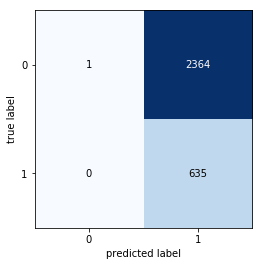

In [38]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_true = cm_df['y_true'].to_list()
y_pred = cm_df['y_pred'].to_list()

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(4, 4))

plt.show()

# Metrics

In [41]:
from sklearn.metrics import classification_report

In [42]:
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2365
           1       0.21      1.00      0.35       635

    accuracy                           0.21      3000
   macro avg       0.61      0.50      0.18      3000
weighted avg       0.83      0.21      0.07      3000

